# Trabajo de memoria en Lares
Autor: Francisco Cuitiño Riquelme

## Lectura de Data y preprocesamiento de datos


In [2]:
# Libnerías utiles, descomentar si es necesario, yo no lo descargo por que ya lo tengo 100% real no fake
# !pip install pandas matplotlib plotnine seaborn statsmodels scikit-learn pyreadstat openpyxl folium geopandas fuzzywuzzy python-Levenshtein dill pandas geopy scipy

# Importación de bibliotecas necesarias
import pandas as pd              # Manipulación de datos
import numpy as np               # Operaciones numéricas
import matplotlib.pyplot as plt   # Visualización
import plotnine as p9             # Visualización estilo ggplot
import seaborn as sns             # Gráficos de correlación
import statsmodels.api as sm      # Modelos estadísticos
import datetime                   # Manejo de fechas
import pyreadstat                 # Lectura de archivos SPSS/Stata
import openpyxl                   # Lectura y escritura de archivos Excel
import geopandas as gpd           # Trabajar con datos geoespaciales
import folium                     # Visualización de mapas interactivos
import re                         # Expresiones regulares


In [3]:
# Cargar el archivo CSV correctamente
data_csv = pd.read_csv('data_terrenos_20210101_20240805.csv', sep=';')

KeyboardInterrupt: 

In [ ]:
# Eliminar comillas simples de todas las columnas que son de tipo string
data_csv = data_csv.apply(lambda col: col.str.replace("'", "") if col.dtype == "object" else col)


In [ ]:
# Modificar los nombres de las columnas
data_csv.columns = data_csv.columns.str.replace(r"^X.|.$", "", regex=True)


In [ ]:
# Corregir los nombres de las columnas eliminando las comillas simples adicionales
data_csv.columns = data_csv.columns.str.replace("'", "")

# Verifica los nombres de las columnas después de limpiar
print(data_csv.columns)


In [ ]:
# Función para verificar si un valor es numérico
def is_numeric_string(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

# Crear una nueva columna 'descripcion_2' con valores NaN
data_csv['descripcion_2'] = pd.NA

# Iterar sobre las filas y rellenar la columna 'descripcion_2' con la descripción
for i in range(1, len(data_csv)):
    if not is_numeric_string(data_csv.loc[i, 'id']):
        data_csv.loc[i - 1, 'descripcion_2'] = data_csv.loc[i, 'id']

# Eliminar filas donde la columna 'id' no es numérica
data_csv = data_csv[data_csv['id'].apply(is_numeric_string)]


### Estudio de regiones

In [ ]:
# Conteo de datos por región
cont_region = data_csv['region'].value_counts().reset_index()
cont_region.columns = ['region', 'count']
print(cont_region)

In [ ]:
# Eliminar filas donde las regiones son "Otros Paises"
data_csv = data_csv[data_csv['region'] != "Otros Paises"]


In [ ]:
# Conteo de datos por región
cont_region = data_csv['region'].value_counts().reset_index()
cont_region.columns = ['region', 'count']
print(cont_region)

In [ ]:
# Seleccionar casos específicos de regiones mal nombradas
regiones_interes = ["Magallanes Y La Antártica Chilena", "Ohiggins", "X Los Lagos", "XI Aisén", "La Araucanía"]

# Filtrar las filas de interés
data_reg_interes = data_csv[data_csv['region'].isin(regiones_interes)]

# Visualizar los datos
print(data_reg_interes)

# Guardar en un archivo CSV (opcional, descomentar si lo deseas usar)
data_reg_interes.to_csv('data recuperada/nombre_de_regiones_cambiadas2.csv', index=False)


In [ ]:
# Diccionario de nombres incorrectos y sus correcciones
region_corregida = {
    "Magallanes Y La Antártica Chilena": "Magallanes y la Antártica",
    "Ohiggins": "Libertador General Bernardo OHiggins",
    "X Los Lagos": "Los Lagos",
    "XI Aisén": "Aysén",
    "La Araucanía": "Araucanía"
}

# Reemplazar nombres incorrectos en la columna 'region'
for nombre_incorrecto, nombre_correcto in region_corregida.items():
    data_csv['region'] = data_csv['region'].replace(nombre_incorrecto, nombre_correcto)


In [ ]:
# Diccionario para convertir los nombres de las regiones a mayúsculas
regiones = {
    "Antofagasta": "ANTOFAGASTA",
    "Araucanía": "ARAUCANIA",
    "Arica y Parinacota": "ARICA Y PARINACOTA",
    "Atacama": "ATACAMA",
    "Aysén": "AYSEN",
    "Biobío": "BIOBIO",
    "Coquimbo": "COQUIMBO",
    "Libertador General Bernardo OHiggins": "LIBERTADOR GENERAL BERNARDO OHIGGINS",
    "Los Lagos": "LOS LAGOS",
    "Los Ríos": "LOS RIOS",
    "Magallanes y la Antártica": "MAGALLANES",
    "Maule": "MAULE",
    "Metropolitana": "METROPOLITANA",
    "Ñuble": "NUBLE",
    "Tarapacá": "TARAPACA",
    "Valparaíso": "VALPARAISO"
}

# Reemplazar los nombres de las regiones por las versiones en mayúsculas
for nombre_incorrecto, nombre_mayus in regiones.items():
    data_csv['region'] = data_csv['region'].replace(nombre_incorrecto, nombre_mayus)


In [ ]:
# Conteo de datos por región
cont_region = data_csv['region'].value_counts().reset_index()
cont_region.columns = ['region', 'count']

# Visualizar el conteo
cont_region.head(20)


In [ ]:
# Definir la lista de regiones y comunas
regiones_comunas = {
    "ARICA Y PARINACOTA": ["ARICA", "CAMARONES", "GENERAL LAGOS", "PUTRE"],
    "TARAPACA": ["ALTO HOSPICIO", "IQUIQUE", "HUARA", "CAMINA", "COLCHANE", "PICA", "POZO ALMONTE"],
    "ANTOFAGASTA": ["ANTOFAGASTA", "CALAMA", "MARIA ELENA", "MEJILLONES", "OLLAGUE", "SAN PEDRO DE ATACAMA", "SIERRA GORDA", "TALTAL", "TOCOPILLA"],
    "ATACAMA": ["ALTO DEL CARMEN", "CALDERA", "CHANARAL", "COPIAPO", "DIEGO DE ALMAGRO", "FREIRINA", "HUASCO", "TIERRA AMARILLA", "VALLENAR"],
    "COQUIMBO": ["ANDACOLLO", "CANELA", "COMBARBALA", "COQUIMBO", "ILLAPEL", "LA HIGUERA", "LA SERENA", "LOS VILOS", "MONTE PATRIA", "OVALLE", "PAIHUANO", "PUNITAQUI", "RIO HURTADO", "SALAMANCA", "VICUNA"],
    "VALPARAISO": ["ALGARROBO", "CABILDO", "CALLE LARGA", "CARTAGENA", "CASABLANCA", "CATEMU", "CONCON", "EL QUISCO", "EL TABO", "HIJUELAS", "ISLA DE PASCUA", "JUAN FERNANDEZ", "LA CALERA", "LA CRUZ", "LA LIGUA", "LIMACHE", "LLAILLAY", "LOS ANDES", "NOGALES", "OLMUE", "PANQUEHUE", "PAPUDO", "PETORCA", "PUCHUNCAVI", "PUTAENDO", "QUILLOTA", "QUILPUE", "QUINTERO", "RINCONADA", "SAN ANTONIO", "SAN ESTEBAN", "SAN FELIPE", "SANTA MARIA", "SANTO DOMINGO", "VALPARAISO", "VILLA ALEMANA", "VINA DEL MAR", "ZAPALLAR"],
    "METROPOLITANA": ["ALHUE", "BUIN", "CALERA DE TANGO", "CERRILLOS", "CERRO NAVIA", "COLINA", "CONCHALI", "CURACAVI", "EL BOSQUE", "EL MONTE", "ESTACION CENTRAL", "HUECHURABA", "INDEPENDENCIA", "ISLA DE MAIPO", "LA CISTERNA", "LA FLORIDA", "LA GRANJA", "LAMPA", "LA PINTANA", "LA REINA", "LAS CONDES", "LO BARNECHEA", "LO ESPEJO", "LO PRADO", "MACUL", "MAIPU", "MARIA PINTO", "MELIPILLA", "NUNOA", "PADRE HURTADO", "PAINE", "PEDRO AGUIRRE CERDA", "PENAFLOR", "PENALOLEN", "PIRQUE", "PROVIDENCIA", "PUDAHUEL", "PUENTE ALTO", "QUILICURA", "QUINTA NORMAL", "RECOLETA", "RENCA", "SAN BERNARDO", "SAN JOAQUIN", "SAN JOSE DE MAIPO", "SAN MIGUEL", "SAN PEDRO", "SAN RAMON", "SANTIAGO", "TALAGANTE", "TILTIL", "VITACURA"],
    "LIBERTADOR GENERAL BERNARDO OHIGGINS": ["CHEPICA", "CHIMBARONGO", "CODEGUA", "COINCO", "COLTAUCO", "DONIHUE", "GRANEROS", "LA ESTRELLA", "LAS CABRAS", "LITUECHE", "LOLOL", "MACHALI", "MALLOA", "MARCHIHUE", "MOSTAZAL", "NANCAGUA", "NAVIDAD", "OLIVAR", "PALMILLA", "PAREDONES", "PERALILLO", "PEUMO", "PICHIDEGUA", "PICHILEMU", "PLACILLA", "PUMANQUE", "QUINTA DE TILCOCO", "RANCAGUA", "RENGO", "REQUINOA", "SAN FERNANDO", "SANTA CRUZ", "SAN VICENTE"],
    "MAULE": ["CAUQUENES", "CHANCO", "COLBUN", "CONSTITUCION", "CUREPTO", "CURICO", "EMPEDRADO", "HUALANE", "LICANTEN", "LINARES", "LONGAVI", "MAULE", "MOLINA", "PARRAL", "PELARCO", "PELLUHUE", "PENCAHUE", "RAUCO", "RETIRO", "RIO CLARO", "ROMERAL", "SAGRADA FAMILIA", "SAN CLEMENTE", "SAN JAVIER", "SAN RAFAEL", "TALCA", "TENO", "VICHUQUEN", "VILLA ALEGRE", "YERBAS BUENAS"],
    "NUBLE": ["BULNES", "CHILLAN", "CHILLAN VIEJO", "COBQUECURA", "COELEMU", "COIHUECO", "EL CARMEN", "NINHUE", "NIQUEN", "PEMUCO", "PINTO", "PORTEZUELO", "QUILLON", "QUIRIHUE", "SAN CARLOS", "SAN FABIAN", "SAN IGNACIO", "SAN NICOLAS", "TREGUACO", "YUNGAY"],
    "BIOBIO": ["ALTO BIOBIO", "ANTUCO", "ARAUCO", "CABRERO", "CANETE", "CHIGUAYANTE", "CONCEPCION", "CONTULMO", "CORONEL", "CURANILAHUE", "FLORIDA", "HUALPEN", "HUALQUI", "LAJA", "LEBU", "LOS ALAMOS", "LOS ANGELES", "LOTA", "MULCHEN", "NACIMIENTO", "NEGRETE", "PENCO", "QUILACO", "QUILLECO", "SAN PEDRO DE LA PAZ", "SAN ROSENDO", "SANTA BARBARA", "SANTA JUANA", "TALCAHUANO", "TIRUA", "TOME", "TUCAPEL", "YUMBEL"],
    "ARAUCANIA": ["ANGOL", "CARAHUE", "CHOLCHOL", "COLLIPULLI", "CUNCO", "CURACAUTIN", "CURARREHUE", "ERCILLA", "FREIRE", "GALVARINO", "GORBEA", "LAUTARO", "LONCOCHE", "LONQUIMAY", "LOS SAUCES", "LUMACO", "MELIPEUCO", "NUEVA IMPERIAL", "PADRE LAS CASAS", "PERQUENCO", "PITRUFQUEN", "PUCON", "PUREN", "RENAICO", "SAAVEDRA", "TEMUCO", "TEODORO SCHMIDT", "TOLTEN", "TRAIGUEN", "VICTORIA", "VILCUN", "VILLARRICA"],
    "LOS RIOS": ["CORRAL", "FUTRONO", "LAGO RANCO", "LANCO", "LA UNION", "LOS LAGOS", "MAFIL", "MARIQUINA", "PAILLACO", "PANGUIPULLI", "RIO BUENO", "VALDIVIA"],
    "LOS LAGOS": ["ANCUD", "CALBUCO", "CASTRO", "CHAITEN", "CHONCHI", "COCHAMO", "CURACO DE VELEZ", "DALCAHUE", "FRESIA", "FRUTILLAR", "FUTALEUFU", "HUALAIHUE", "LLANQUIHUE", "LOS MUERMOS", "MAULLIN", "OSORNO", "PALENA", "PUERTO MONTT", "PUERTO OCTAY", "PUERTO VARAS", "PUQUELDON", "PURRANQUE", "PUYEHUE", "QUEILEN", "QUELLON", "QUEMCHI", "QUINCHAO", "RIO NEGRO", "SAN JUAN DE LA COSTA", "SAN PABLO"],
    "AYSEN": ["AYSEN", "CHILE CHICO", "CISNES", "COCHRANE", "COYHAIQUE", "GUAITECAS", "LAGO VERDE", "OHIGGINS", "RIO IBANEZ", "TORTEL"],
    "MAGALLANES": ["ANTARTICA", "CABO DE HORNOS", "LAGUNA BLANCA", "NATALES", "PORVENIR", "PRIMAVERA", "PUNTA ARENAS", "RIO VERDE", "SAN GREGORIO", "TIMAUKEL", "TORRES DEL PAINE"]
}

# Descomponer la lista en un solo vector de comunas
comunas = [comuna for lista_comunas in regiones_comunas.values() for comuna in lista_comunas]

# Convertir el vector en un dataframe con una sola columna
df_comunas = pd.DataFrame({'Comuna': comunas})

# Mostrar las primeras filas del dataframe
print(df_comunas.head())

# Guardar en un archivo Excel
# df_comunas.to_excel('/content/drive/MyDrive/Memoria/comunas_chile.xlsx', index=False)


In [ ]:
import re
import unicodedata

# Modificar la función de normalización de texto para manejar valores NaN y no textuales
def normalize_text(text):
    if isinstance(text, float) and pd.isna(text):
        return text  # Si es NaN, devolver NaN

    if not isinstance(text, str):
        return str(text)  # Convertir otros tipos a cadena de texto

    # Convertir el texto a mayúsculas
    text = text.upper()

    # Reemplazar tildes y otros caracteres especiales usando 'unicodedata' para descomponer el texto
    text = ''.join(
        (c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')
    )

    # Reemplazar la 'Ñ' por 'N'
    text = text.replace('Ñ', 'N')

    # Eliminar espacios extras
    text = re.sub(r'\s+', ' ', text)  # Reemplaza múltiples espacios por uno solo
    text = text.strip()  # Elimina espacios al principio y final

    return text



In [ ]:
import Levenshtein as lev
import pandas as pd

# Diccionario con regiones y comunas (definido previamente en un paso anterior)
# regiones_comunas = {...}

# Función que encuentra la comuna más cercana
def find_closest_comuna(region_name, comuna_name):
    if pd.isna(region_name) or pd.isna(comuna_name):
        return None

    # Verificar si la región existe en el listado y que comuna_name no es "NULL"
    if region_name in regiones_comunas and comuna_name != "NULL":
        comunas = regiones_comunas[region_name]

        # Filtrar cualquier comuna que sea "NULL"
        comunas = [comuna for comuna in comunas if comuna != "NULL"]

        # Si hay comunas válidas, calcular la distancia de Levenshtein
        if len(comunas) > 0:
            distances = [lev.distance(comuna, comuna_name) for comuna in comunas]

            # Encontrar la comuna con la menor distancia
            min_distance = min(distances)
            if min_distance <= max(len(comuna) for comuna in comunas) * 0.5:  # Umbral ajustable
                closest_comuna = comunas[distances.index(min_distance)]
                return closest_comuna

    # Si no se encuentra coincidencia suficientemente cercana
    return f"{comuna_name}*"



In [ ]:
# Aplicar la función de normalización a las columnas 'region' y 'comuna'
data_csv['region_norm'] = data_csv['region'].apply(normalize_text)
data_csv['comuna_norm'] = data_csv['comuna'].apply(normalize_text)


In [ ]:
# Crear la columna 'comuna_match' utilizando la función de distancia de Levenshtein
data_csv['comuna_match'] = data_csv.apply(lambda row: find_closest_comuna(row['region_norm'], row['comuna_norm']), axis=1)


In [ ]:
# Calcular la frecuencia de 'comuna_norm'
frec_comuna_norm = data_csv['comuna_norm'].value_counts().reset_index()
frec_comuna_norm.columns = ['comuna_norm', 'frequency']  # Renombrar las columnas

# Calcular la frecuencia de 'comuna_match'
frec_comuna_match = data_csv['comuna_match'].value_counts().reset_index()
frec_comuna_match.columns = ['comuna_match', 'frequency']  # Renombrar las columnas

# Mostrar las primeras filas del resultado
print(frec_comuna_norm.head())
print(frec_comuna_match.head())


In [ ]:
# Contar las comunas únicas en la columna 'comuna'
num_comunas_unicas = data_csv['comuna'].nunique()

# Contar las comunas normalizadas únicas en la columna 'comuna_norm'
num_comunas_norm_unicas = data_csv['comuna_norm'].nunique()

# Contar las comunas normalizadas únicas en la columna 'comuna_match'
num_comunas_match_unicas = data_csv['comuna_match'].nunique()
# Imprimir los resultados
print(f"Cantidad de comunas únicas: {num_comunas_unicas}")
print(f"Cantidad de comunas normalizadas únicas: {num_comunas_norm_unicas}")
print(f"Cantidad de comunas match únicas: {num_comunas_match_unicas}")


Seleccionar casos específicos de comunas mal nombradas

In [ ]:
# Lista de comunas mal nombradas
comunas_norm_interes = [
    "ALGARROBITO*", "ANTILHUE*", "BAJO MOLLE*", "CALETA TORTEL*", "CALLUMAPU*",
    "CENTRAL LOS MOLLES*", "CENTRO DE COQUIMBO*", "CERRILLOS DE TAMAYA*", "CERRO ALEGRE*",
    "CERRO ARTILLERIA - ARRAYAN*", "CERRO MARIPOSA*", "CERRO PANTEON*", "CERRO YUNGAY*",
    "CHACARILLA MAULE*", "CHILECITO*", "CHILLAN VIEJO*", "CRUZ DEL TERCER MILENIO*",
    "EL ESTERO - EL MANZANO*", "EMBALSE RAPEL*", "ENSENADA ROLECHA*", "FRANCISCO MOSTAZAL*",
    "GUANAQUERO*", "HUENTELAUQUEN*", "ISLA DEL REY*", "LA JUNTA*", "LAGO CASTOR*",
    "LAGUNA DE ZAPALLAR*", "LOS NICHES POBRES*", "LOS QUILLAYES - SANTA CLARISA*",
    "MALALCAHUELLO*", "NO INFORMADA*", "OHIGGINS*", "PARQUE JUAN LOPEZ*", "POCONCHILE*",
    "PUERTO DOMINGUEZ*", "REUMEN*", "ROCAS DE SANTO DOMINGO*", "SAN FRANCISCO DE MOSTAZAL*",
    "SAN JOSÉ DE LA MARIQUINA*", "SAN JOSE DE LA MARIQUINA*", "SAN JUAN DE LA COSTA*",
    "SAN VICENTE DE TAGUA TAGUA*", "SANTA ANA DE TREBULCO*", "VILLA CERRO CASTILLO*",
    "VILLA OHIGGINS*"
]

# Filtrar las filas donde 'comuna_match' está en 'comunas_norm_interes'
data_comunas_interes = data_csv[data_csv['comuna_match'].isin(comunas_norm_interes)]

# Mostrar las primeras filas del resultado
data_comunas_interes.head()

# (Opcional) Guardar los datos en un archivo CSV
data_comunas_interes.to_csv('data recuperada/nombre_de_comunas_cambiadas.csv', index=False)


Corrección de los nombres de las comunas

In [ ]:
# Diccionario de correcciones
correcciones_comunas = {
    "ALGARROBITO*": "LA SERENA",
    "ANTILHUE*": "LOS LAGOS",
    "BAJO MOLLE*": "IQUIQUE",
    "CALETA TORTEL*": "TORTEL",
    "CALLUMAPU*": "VALDIVIA",
    "CENTRAL LOS MOLLES*": "MONTE PATRIA",
    "CENTRO DE COQUIMBO*": "COQUIMBO",
    "CERRILLOS DE TAMAYA*": "COQUIMBO",
    "CERRO ALEGRE*": "VALPARAISO",
    "CERRO ARTILLERIA - ARRAYAN*": "VALPARAISO",
    "CERRO MARIPOSA*": "VALPARAISO",
    "CERRO PANTEON*": "VALPARAISO",
    "CERRO YUNGAY*": "VALPARAISO",
    "CHACARILLA MAULE*": "MAULE",
    "CHILECITO*": "MONTE PATRIA",
    "CHILLAN VIEJO*": "CHILLAN VIEJO",
    "CRUZ DEL TERCER MILENIO*": "COQUIMBO",
    "EL ESTERO - EL MANZANO*": "LAS CABRAS",
    "EMBALSE RAPEL*": "LAS CABRAS",
    "ENSENADA ROLECHA*": "HUALAIHUE",
    "FRANCISCO MOSTAZAL*": "MOSTAZAL",
    "GUANAQUERO*": "COQUIMBO",
    "HUENTELAUQUEN*": "CANELA",
    "ISLA DEL REY*": "CORRAL",
    "LA JUNTA*": "CISNES",
    "LAGO CASTOR*": "COYHAIQUE",
    "LAGUNA DE ZAPALLAR*": "ZAPALLAR",
    "LOS NICHES POBRES*": "CURICO",
    "LOS QUILLAYES - SANTA CLARISA*": "LAS CABRAS",
    "MALALCAHUELLO*": "CURACAUTIN",
    "OHIGGINS*": "FRESIA",
    "PARQUE JUAN LOPEZ*": "ANTOFAGASTA",
    "POCONCHILE*": "ARICA",
    "PUERTO DOMINGUEZ*": "SAAVEDRA",
    "REUMEN*": "PAILLACO",
    "ROCAS DE SANTO DOMINGO*": "SANTO DOMINGO",
    "SAN FRANCISCO DE MOSTAZAL*": "MOSTAZAL",
    "SAN JOSÉ DE LA MARIQUINA*": "MARIQUINA",
    "SAN JOSE DE LA MARIQUINA*": "MARIQUINA",
    "SAN JUAN DE LA COSTA*": "SAN JUAN DE LA COSTA",
    "SAN VICENTE DE TAGUA TAGUA*": "SAN VICENTE",
    "SANTA ANA DE TREBULCO*": "TALAGANTE",
    "VILLA CERRO CASTILLO*": "TORRES DEL PAINE",
    "VILLA OHIGGINS*": "OHIGGINS"
}

# Aplicar las correcciones en la columna 'comuna_match'
data_csv['comuna_match'] = data_csv['comuna_match'].apply(lambda comuna: correcciones_comunas.get(comuna, comuna))


Calcular la frecuencia de las comunas corregidas

In [ ]:
# Calcular la frecuencia de las comunas corregidas ('comuna_match')
frec_comuna_match = data_csv['comuna_match'].value_counts().reset_index()
frec_comuna_match.columns = ['comuna_match', 'frequency']

# Mostrar las primeras filas del resultado
frec_comuna_match.head()


In [ ]:
# Contar el número de comunas únicas en la columna 'comuna_match'
num_comunas_unicas = data_csv['comuna_match'].nunique()

# Mostrar el resultado
print(f"Cantidad de comunas únicas en 'comuna_match': {num_comunas_unicas}")


Filtrar los datos con "NULL*" o terminados en "*"

In [ ]:
# Contar el número de comunas únicas en la columna 'comuna_match'
num_sin_comunas = data_csv['comuna_match'].isna().sum()

# Mostrar el resultado
print(f"Cantidad de datos sin  comunas 'comuna_match': {num_sin_comunas}")

In [ ]:
import pandas as pd

# Filtrar las filas que tienen "NULL*" o cualquier valor que termine con "*" o NaN
data_null = data_csv[data_csv['comuna_match'].str.contains(r'NULL\*|\*$', na=False) | data_csv['comuna_match'].isna()]

# Mostrar las primeras filas del resultado y la cantidad total de filas
print(f"Cantidad de datos con 'NULL*', que terminan con '*' o NaN: {len(data_null)}")
data_null.head()

# (Opcional) Guardar los datos en un archivo CSV
# data_null.to_csv('/content/drive/MyDrive/Memoria/data_null.csv', index=False)


Contar cuántos datos sin comuna tienen región indicada

In [ ]:
# Ver cuántos datos sin comuna tienen indicada la región
frec_region_null = data_null['region_norm'].value_counts().reset_index()
frec_region_null.columns = ['region_norm', 'frequency']

# Mostrar las primeras filas del resultado
frec_region_null.head()


In [ ]:
# Guardar los datos filtrados en un archivo CSV (opcional)
data_null.to_csv('data recuperada/data_null.csv', index=False)


## Expresiones regulares para extraer el texto de descripción

In [ ]:
#Paquetes necesarios
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [ ]:
# Cargar la data de comunas
data_null_nodescripcion = pd.read_csv('data recuperada/data_null.csv')
comunas = pd.read_csv('comunas_chile.csv')  # Cargar las comunas desde csv
comunas_norm = comunas['Comuna'].tolist()  # Lista de comunas normalizadas


In [ ]:
# Definir la función normalize_text que maneja valores nulos
def normalize_text(text):
    if pd.isna(text):  # Verificar si el valor es NaN
        return text
    text = text.upper()
    replacements = {
        "Á": "A", "É": "E", "Í": "I", "Ó": "O", "Ú": "U",
        "À": "A", "È": "E", "Ì": "I", "Ò": "O", "Ù": "U",
        "Ä": "A", "Ë": "E", "Ï": "I", "Ö": "O", "Ü": "U",
        "Ñ": "N"
    }
    
    for accented, replacement in replacements.items():
        text = text.replace(accented, replacement)
    
    text = re.sub(r'\s+', ' ', text)  # Reemplazar múltiples espacios por uno solo
    text = text.strip()  # Eliminar espacios al principio y al final
    return text

# Aplicar la función 'normalize_text' a la columna 'descripcion_sin_saltos', manejando NaN
data_null_nodescripcion['descripcion_norm'] = data_null_nodescripcion['descripcion_sin_saltos'].apply(normalize_text)

# Mostrar los resultados en tu entorno local
print(data_null_nodescripcion[['descripcion_sin_saltos', 'descripcion_norm']].head())




In [ ]:
# Función para encontrar la comuna
def find_comuna3(descripcion, comunas_norm):
    if isinstance(descripcion, str):  # Verificar que la descripción sea una cadena

        # Priorizar coincidencias con el contexto "comuna de"
        for comuna in comunas_norm:
            if re.search(r'\bcomuna de\s+' + re.escape(comuna) + r'\b', descripcion, re.IGNORECASE):
                return comuna

        # Si no se encuentra con "comuna de", buscar la primera coincidencia exacta
        for comuna in comunas_norm:
            if re.search(r'\b' + re.escape(comuna) + r'\b', descripcion, re.IGNORECASE):
                return comuna

        # Si no se encuentra coincidencia exacta, buscar con fuzzy matching
        match, score = process.extractOne(descripcion, comunas_norm)
        if score >= 80:  # Ajustar este umbral según sea necesario
            return match

    return None  # Retornar None si no se encuentra coincidencia

# Aplicar la función a la columna 'descripcion_norm'
data_null_nodescripcion['comuna_extraida3_py'] = data_null_nodescripcion['descripcion_norm'].apply(lambda x: find_comuna3(x, comunas_norm))

In [ ]:
# Realizar el conteo de frecuencias en la columna 'comuna_extraida'
frecuencia_comunas = data_null_nodescripcion['comuna_extraida3_py'].value_counts()

# Mostrar el resultado
print(frecuencia_comunas)

In [4]:
# Contar cuántos valores null (NaN o None) hay en la columna 'comuna_extraida3_py'
num_nulls = data_null_nodescripcion['comuna_extraida3_py'].isnull().sum()
# Mostrar el resultado
print(f"Cantidad de valores null en 'comuna_extraida3_py': {num_nulls}")


NameError: name 'data_null_nodescripcion' is not defined

## Agregar las comunas recuperadas a la base principal

In [5]:
# Convertir la columna 'id' a tipo numérico en ambos DataFrames
data_csv['id'] = pd.to_numeric(data_csv['id'], errors='coerce').astype('Int64')
data_null_nodescripcion['id'] = pd.to_numeric(data_null_nodescripcion['id'], errors='coerce').astype('Int64')

# Realizar el merge (left join) entre la base de datos principal y los nuevos datos
data_csv = pd.merge(data_csv, data_null_nodescripcion[['id', 'comuna_extraida3_py']], on='id', how='left')

# Actualizar 'comuna_match' solo si 'comuna_extraida3_py' no es NaN
data_csv['comuna_match'] = np.where(
    data_csv['comuna_extraida3_py'].notna(),
    data_csv['comuna_extraida3_py'],
    data_csv['comuna_match']
)

# Eliminar la columna 'comuna_extraida3_py' que ya no es necesaria
data_csv = data_csv.drop(columns=['comuna_extraida3_py'])




NameError: name 'data_csv' is not defined

In [6]:
# Contar cuántos valores null (NaN o None) hay en la columna 'comuna_match'
num_nulls = data_csv['comuna_match'].isnull().sum()
# Mostrar el resultado
print(f"Cantidad de valores null en 'comuna_match': {num_nulls}")


NameError: name 'data_csv' is not defined

## Extracción de comunas desde enlace

In [7]:
# Filtrar las filas donde 'comuna_match' es NaN
data_enlace = data_csv[data_csv['comuna_match'].isna()]

# Verificar las primeras filas del resultado filtrado
data_enlace.head()
# Contar el número de filas en data_enlace
num_filas = len(data_enlace)

# Mostrar el resultado
print(f"Número de filas en data_enlace: {num_filas}")
# Verificar las primeras filas del resultado filtrado


NameError: name 'data_csv' is not defined

In [8]:
#Cargar las comunas
comunas = pd.read_csv('comunas_chile.csv')  # Cargar las comunas desde csv
# Normalizar la lista de comunas (en minúsculas)
comunas_norm = comunas['Comuna'].tolist()

# Verificar las primeras filas de comunas normalizadas
print(comunas_norm[:10])  # Muestra las primeras 10 comunas normalizadas para asegurarte de que se cargaron correctamente

['ARICA', 'CAMARONES', 'GENERAL LAGOS', 'PUTRE', 'ALTO HOSPICIO', 'IQUIQUE', 'HUARA', 'CAMINA', 'COLCHANE', 'PICA']


In [9]:
# Función para extraer comuna desde el enlace
def extract_comuna_from_url(url, comunas_norm):
    # Convertir URL  para facilitar el matching
    url = normalize_text(url)

    # Buscar coincidencias de comunas en la URL
    for comuna in comunas_norm:
        if comuna in url:
            return comuna

    return None  # Retornar None si no se encuentra una comuna


In [10]:
# Aplicar la función a la columna 'concat' usando .loc para evitar el SettingWithCopyWarning
data_enlace.loc[:, 'comuna_extraida_url'] = data_enlace['concat'].apply(lambda x: extract_comuna_from_url(x, comunas_norm))

# Ver los resultados
print(data_enlace[['concat', 'comuna_extraida_url']])


NameError: name 'data_enlace' is not defined

In [11]:
# Contar los valores None en la columna 'comuna_extraida_url'
conteo_none = data_enlace['comuna_extraida_url'].isna().sum()

# Mostrar el resultado del conteo
print(f"Cantidad de valores None en 'comuna_extraida_url': {conteo_none}")
comunas_recuperadas = len(data_enlace) - conteo_none
print(f"Cantidad de comunas recuperadas: {comunas_recuperadas}")

NameError: name 'data_enlace' is not defined

In [12]:
# Función para encontrar la comuna en el URL aplicando la función normalize_text
def find_comuna_in_url(url, comunas_norm):
    # Reemplazar "-" por espacios
    url_normalized = url.replace('-', ' ')
    
    # Aplicar la función normalize_text para normalizar el texto
    url_normalized = normalize_text(url_normalized)

    # Buscar la comuna en el URL
    for comuna in comunas_norm:
        if re.search(r'\b' + re.escape(comuna) + r'\b', url_normalized):
            return comuna
    return None

# Aplicar la función a la columna 'concat' usando .loc para evitar el SettingWithCopyWarning
data_enlace.loc[:, 'comuna_extraida2_url'] = data_enlace['concat'].apply(lambda x: find_comuna_in_url(x, comunas_norm))


NameError: name 'data_enlace' is not defined

In [13]:
# Contar los valores None en la columna 'comuna_extraida_url'
conteo_none2 = data_enlace['comuna_extraida2_url'].isna().sum()

# Mostrar el resultado del conteo
print(f"Cantidad de valores None en 'comuna_extraida_url2': {conteo_none2}")
comunas_recuperadas2 = len(data_enlace) - conteo_none2
print(f"Cantidad de comunas recuperadas: {comunas_recuperadas2}")

NameError: name 'data_enlace' is not defined

## Agregar comunas recuperadas desde URL

In [14]:
import pandas as pd
import numpy as np

# Realizar el merge (left join) entre la base de datos principal y los nuevos datos
data_csv = pd.merge(data_csv, data_enlace[['id', 'comuna_extraida2_url']], on='id', how='left')

# Actualizar 'comuna_match' solo si 'comuna_extraida2_url' no es NaN
data_csv['comuna_match'] = np.where(
    data_csv['comuna_extraida2_url'].notna(),
    data_csv['comuna_extraida2_url'],
    data_csv['comuna_match']
)

# Eliminar la columna 'comuna_extraida2_url'
data_csv = data_csv.drop(columns=['comuna_extraida2_url'])



NameError: name 'data_csv' is not defined

In [15]:
# Contar los valores None en la columna 'comuna_match'
conteo_none = data_csv['comuna_match'].isna().sum()
print(f"Cantidad de valores None en 'comuna_match': {conteo_none}")

NameError: name 'data_csv' is not defined

## Extracción con ubicación

In [16]:
# 1. Transformar 'latitude' y 'longitude' a tipo numérico
data_csv['latitude'] = pd.to_numeric(data_csv['latitude'], errors='coerce')
data_csv['longitude'] = pd.to_numeric(data_csv['longitude'], errors='coerce')

# 2. Filtrar las filas donde 'latitude' y 'longitude' no son 0.0
data_ubicacion = data_csv[(data_csv['latitude'] != 0.0) & (data_csv['longitude'] != 0.0)]

# 3. Contar cuántas filas no tienen comuna en 'comuna_match' pero si 'latitude' y 'longitude'
na_conubicacion = data_ubicacion['comuna_match'].isna().sum()
print(f"Cantidad de filas sin comuna en 'comuna_match' pero con 'latitude' y 'longitude': {na_conubicacion}")


# 4. Filtrar las filas donde 'comuna_match' está vacío (o es NaN)
data_ubicacion_nocomuna = data_ubicacion[data_ubicacion['comuna_match'].isna() | (data_ubicacion['comuna_match'] == "")]


NameError: name 'data_csv' is not defined

In [17]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from collections import Counter


# Verificar y filtrar coordenadas dentro del rango permitido
data_ubicacion = data_ubicacion[
    (data_ubicacion['latitude'] >= -90) &
    (data_ubicacion['latitude'] <= 90) &
    (data_ubicacion['longitude'] >= -180) &
    (data_ubicacion['longitude'] <= 180)
]

# Separar las filas con y sin comuna asignada
data_con_comuna = data_ubicacion.dropna(subset=['comuna_match'])
data_sin_comuna = data_ubicacion[data_ubicacion['comuna_match'].isna()].copy()  # Usar .copy() para evitar el SettingWithCopyWarning

# Convertir coordenadas a radianes para el cálculo eficiente
coords_con_comuna = np.deg2rad(data_con_comuna[['latitude', 'longitude']].values)
coords_sin_comuna = np.deg2rad(data_sin_comuna[['latitude', 'longitude']].values)

# Crear un KDTree para encontrar las comunas más cercanas
tree = cKDTree(coords_con_comuna)

# Función para encontrar las comunas más cercanas y contar la cantidad de terrenos cercanos
def find_nearest_comunas_with_counts(lat, lon, k=3, radius_km=10):
    lat_lon_rad = np.deg2rad([lat, lon])
    distances, indices = tree.query(lat_lon_rad, k=k)

    # Filtrar los índices y distancias inválidos
    valid_indices = [i for i, dist in zip(indices, distances) if dist <= np.deg2rad(radius_km / 6371.0) and i < len(data_con_comuna)]

    if not valid_indices:  # Si no hay índices válidos, retornar un diccionario vacío
        return {}

    # Obtener las comunas más cercanas
    nearby_comunas = data_con_comuna.iloc[valid_indices]['comuna_match'].values

    # Contar las ocurrencias de cada comuna
    comuna_counts = Counter(nearby_comunas)

    # Seleccionar las k comunas más cercanas y su conteo
    return dict(comuna_counts.most_common(k))

# Aplicar la función a las filas sin comuna
data_sin_comuna.loc[:, 'comunas_cercanas_dict'] = data_sin_comuna.apply(
    lambda row: find_nearest_comunas_with_counts(row['latitude'], row['longitude']), axis=1
)

# Combinar los resultados con el DataFrame original
data_ubicacion = pd.concat([data_con_comuna, data_sin_comuna], ignore_index=True)

# Verificar el resultado
print(data_sin_comuna[['latitude', 'longitude', 'comunas_cercanas_dict']].head())

NameError: name 'data_ubicacion' is not defined

In [18]:
# Función para obtener la comuna con mayor frecuencia (resuelve empates tomando la primera en el diccionario)
def get_comuna_mayor_frecuencia(comunas_dict):
    if not isinstance(comunas_dict, dict) or not comunas_dict:  # Verificar si es un diccionario y si está vacío
        return None
    # Obtener la comuna con la mayor frecuencia; en caso de empate, toma la primera que aparece
    return max(comunas_dict.items(), key=lambda item: (item[1], list(comunas_dict.keys()).index(item[0])))[0]

# Aplicar la función a la columna 'comunas_cercanas_dict'
data_ubicacion['comuna_mayor_frecuencia'] = data_ubicacion['comunas_cercanas_dict'].apply(get_comuna_mayor_frecuencia)

# Filtrar las filas donde 'comuna_mayor_frecuencia' no es None o NaN
filtrado = data_ubicacion[data_ubicacion['comuna_mayor_frecuencia'].notna()]

# Verificar los resultados (filas filtradas)
print(filtrado[['comunas_cercanas_dict', 'comuna_mayor_frecuencia']].head())

NameError: name 'data_ubicacion' is not defined

In [19]:
# Realizar un merge entre data_csv y data_ubicacion para traer la columna 'comuna_mayor_frecuencia'
data_csv = pd.merge(data_csv, data_ubicacion[['id', 'comuna_mayor_frecuencia']], on='id', how='left')

# Actualizar 'comuna_match' en 'data_csv' solo si está vacío y 'comuna_mayor_frecuencia' no es NaN
data_csv['comuna_match'] = np.where(
    (data_csv['comuna_match'].isna() | (data_csv['comuna_match'] == "")) & data_csv['comuna_mayor_frecuencia'].notna(),
    data_csv['comuna_mayor_frecuencia'],
    data_csv['comuna_match']
)

# Eliminar la columna 'comuna_mayor_frecuencia' que ya no es necesaria
data_csv = data_csv.drop(columns=['comuna_mayor_frecuencia'])



NameError: name 'data_csv' is not defined

In [20]:
# Contar el número total de filas en data_csv
total_filas = len(data_csv)
print(f"Número total de filas en data_csv: {total_filas}")


NameError: name 'data_csv' is not defined

In [21]:
# Contar cuántas filas en 'comuna_match' no están vacías (ni NaN ni "")
filas_no_vacias = data_csv['comuna_match'].notna() & (data_csv['comuna_match'] != "")
filas_no_vacias_count = filas_no_vacias.sum()  # Contar cuántas son True
print(f"Número de filas no vacías en 'comuna_match': {filas_no_vacias_count}")


NameError: name 'data_csv' is not defined

### Eliminar filas sin comuna y recuperar la data

In [22]:
# 1. Filtrar filas que tienen algún valor en 'comuna_match' (no NaN ni "")
data_con_comuna = data_csv[data_csv['comuna_match'].notna() & (data_csv['comuna_match'] != "")]

# 2. Contar cuántas filas fueron eliminadas
filas_eliminadas = len(data_csv) - len(data_con_comuna)
print(f"Número de filas eliminadas: {filas_eliminadas}")

# 3. Guardar las filas eliminadas en un archivo CSV
filas_eliminadas_df = data_csv[data_csv['comuna_match'].isna() | (data_csv['comuna_match'] == "")]
filas_eliminadas_df.to_csv('filas_eliminadas.csv', index=False)

# 4. Calcular el porcentaje de filas eliminadas
porcentaje_eliminadas = (filas_eliminadas / len(data_csv)) * 100
print(f"Porcentaje de filas eliminadas: {porcentaje_eliminadas:.2f}%")


NameError: name 'data_csv' is not defined

In [23]:
comunas_unicas = data_con_comuna['comuna_match'].nunique()
print(f"Comunicas unicas existentes: {comunas_unicas}")

NameError: name 'data_con_comuna' is not defined

In [24]:
data_lares = data_con_comuna

NameError: name 'data_con_comuna' is not defined

## Extración de superficie en descripción

In [25]:
import re
import unicodedata

def normalizar_texto(text):
    """Normaliza el texto: lo convierte a minúsculas, elimina tildes y espacios extras."""
    if isinstance(text, str):
        # Convertir a minúsculas y eliminar tildes
        text = text.lower()
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
        # Reemplazar caracteres problemáticos en "hectarea", etc.
        text = re.sub(r'hect[a-z]*', 'hectarea', text)  # Normaliza variantes de hectárea
        text = re.sub(r'\s+', ' ', text).strip()  # Elimina espacios extras
        # Añadir un espacio entre números y unidades de medida, si están pegados
        text = re.sub(r'(\d)([a-zA-Z])', r'\1 \2', text)
        return text
    return ""

def extraer_superficies_dict(text):
    text = normalizar_texto(text)

    # Expresión regular mejorada para capturar superficies, incluyendo mt2
    pattern = r"\b(?!\$)(\d+(?:[.,]\d{1,3})*(?:[.,]\d+)?|\d+)\s*(mil)?\s*(m2|mt2|mts|ms2|mts2|metros cuadrados|ha|hectarea|hectareas|has)\b"

    matches = re.findall(pattern, text)
    superficies_dict = {}

    for idx, match in enumerate(matches):
        num_str, mil_flag, unidad = match

        # Detectar si el punto es un separador de miles o un separador decimal
        if '.' in num_str:
            # Separar la parte antes y después del punto
            partes = num_str.split('.')
            if len(partes[-1]) == 3:  # Si tiene 3 dígitos después del punto, es un separador de miles
                num_str = num_str.replace('.', '')  # Eliminar puntos como separadores de miles
            elif len(partes[-1]) <= 2:  # Si tiene 1 o 2 dígitos después del punto, es un decimal
                num_str = num_str.replace('.', ',')  # Asumimos que quisieron usar coma como decimal

        # Reemplazar las comas que representan decimales por puntos
        num_str = num_str.replace(',', '.')

        # Manejar la palabra "mil"
        if mil_flag == "mil":
            try:
                num_str = str(float(num_str.strip()) * 1000)  # Multiplicar por 1000 cuando aparece "mil"
            except ValueError:
                continue  # Omitir este valor si no se puede convertir a float

        try:
            num = float(num_str)
        except ValueError:
            continue

        # Asegurarse de no convertir valores en m2 como si fueran ha
        if 'ha' in unidad or 'hectarea' in unidad or 'hectareas' in unidad or 'has' in unidad:
            num_m2 = num * 10000  # Convertir hectáreas a metros cuadrados
        else:
            num_m2 = num  # Ya está en metros cuadrados

        # Evitar capturar distancias pequeñas (como 136 m2) antes de terrenos grandes como 5223 m2
        if num_m2 >= 100:  # Evitar errores con medidas muy pequeñas
            superficies_dict[f'superficie_{idx+1}'] = num_m2

    return superficies_dict

def seleccionar_mayor_superficie(superficies_dict):
    """Selecciona la mayor superficie en el diccionario."""
    if superficies_dict:
        return max(superficies_dict.values())
    return None

# Aplicar la función al DataFrame
data_lares['superficies_dict'] = data_lares['descripcion_sin_saltos'].apply(extraer_superficies_dict)
data_lares['mayor_superficie'] = data_lares['superficies_dict'].apply(seleccionar_mayor_superficie)

NameError: name 'data_lares' is not defined

In [26]:
# Verificar el tipo de dato de la columna 'total_o_terreno'
tipo_dato = data_lares['total_o_terreno'].dtype
print(f"El tipo de dato de 'total_o_terreno' es: {tipo_dato}")


NameError: name 'data_lares' is not defined

In [27]:
# Convertir la columna 'total_o_terreno' a numérico
data_lares['total_o_terreno'] = pd.to_numeric(data_lares['total_o_terreno'], errors='coerce')

NameError: name 'data_lares' is not defined

In [28]:
# Contar cuántos valores NaN hay en 'total_o_terreno'
num_nan = data_lares['total_o_terreno'].isna().sum()
print(f"Número de valores NaN en 'total_o_terreno': {num_nan}")

# Contar cuántos valores son iguales a 0 en 'total_o_terreno'
num_cero = (data_lares['total_o_terreno'] == 0).sum()
print(f"Número de valores igual a 0 en 'total_o_terreno': {num_cero}")

# Contar cuántos valores en total son NaN o iguales a 0
num_nan_o_cero = data_lares['total_o_terreno'].isna().sum() + (data_lares['total_o_terreno'] == 0).sum()
print(f"Número de valores NaN o igual a 0 en 'total_o_terreno': {num_nan_o_cero}")


NameError: name 'data_lares' is not defined

In [29]:
total_nodict = (data_lares['superficies_dict'] == {}).sum()
print(f"Cantidad de valores nulos en 'superficies_dict': {total_nodict}")

NameError: name 'data_lares' is not defined

In [30]:
total_dict = (data_lares['superficies_dict'] != {}).sum()
print(f"Cantidad de diccionarios en 'superficies_dict': {total_dict}")

NameError: name 'data_lares' is not defined

In [31]:
import pandas as pd

# Función para calcular la diferencia porcentual y la diferencia absoluta
def calcular_diferencias(row):
    total = row['total_o_terreno']
    mayor = row['mayor_superficie']

    if total != 0 and pd.notna(mayor):
        # Si ambos valores existen, calcular la diferencia porcentual y absoluta
        diff_abs = abs(total - mayor)  # Tomar valor absoluto de la diferencia
        diff_pct = ((total - mayor) / mayor) * 100  # Permitir diferencias negativas o positivas
        return pd.Series([diff_pct, diff_abs])

    elif total == 0 and pd.isna(mayor):
        # Si ambos valores son nulos, marcar para eliminar
        return pd.Series(['eliminar', 'eliminar'])

    elif total != 0 and pd.isna(mayor):
        # Si solo total_o_terreno tiene valor, marcar la diferencia como NaN
        return pd.Series([pd.NA, pd.NA])

    elif total == 0 and pd.notna(mayor):
        # Si solo mayor_superficie tiene valor, marcar como 'agregar'
        return pd.Series(['agregar', 'agregar'])

# Aplicar la función al DataFrame
data_lares[['diferencia_pct', 'diferencia_abs']] = data_lares.apply(calcular_diferencias, axis=1)

# Verificar los resultados
print(data_lares[['total_o_terreno', 'mayor_superficie', 'diferencia_pct', 'diferencia_abs']].head(15))

NameError: name 'data_lares' is not defined

In [32]:
# Para comenzar desde aqui, data respaldada
data_lares.to_csv('data recuperada/data_lares.csv', index=False)

NameError: name 'data_lares' is not defined

## Data desde el 2021

In [33]:
import pandas as pd
data_lares = pd.read_csv('data recuperada/data_lares.csv')

In [34]:
# Forzar la conversión a datetime
data_lares['publicada'] = pd.to_datetime(data_lares['publicada'], errors='coerce')

# Verificar nuevamente el tipo de dato
print(data_lares['publicada'].dtype)

datetime64[ns]


In [35]:
# Convertir la columna 'publicada' a formato de fecha usando .loc

#Filtrar datos desde el 2021
data_2021 = data_lares[data_lares['publicada'].dt.year >= 2021]
#Filtrar datos anteriores al 2021
data_menor_2021 = data_lares[data_lares['publicada'].dt.year < 2021]
#Contar cuantos datos son y guardar en un CSV
datos_eliminados = len(data_menor_2021)

data_menor_2021.to_csv('data recuperada/data_menor_2021.csv', index=False)

#Porcentaje de datos eliminados
total_datos_comuna = len(data_lares)
pct_eliminados = (datos_eliminados / total_datos_comuna) * 100

#Mostrar cuantos datos fueron elminados por fecha
print(f"Total de datos data_lares: {total_datos_comuna}")
print(f"Número de datos anteriores al 2021 eliminados: {datos_eliminados}")
print(f"Porcentaje eliminado de la data con comuna: {pct_eliminados:.2f}%")


Total de datos data_lares: 448126
Número de datos anteriores al 2021 eliminados: 8198
Porcentaje eliminado de la data con comuna: 1.83%


In [153]:
import pandas as pd
data_2019 = pd.read_csv('data recuperada/data_menor_2021.csv')

## Asignación de Regiones

In [36]:
# Ver cuántos valores NaN y cadenas vacías hay en 'region'
nan_count = data_2021['region'].isna().sum()
empty_string_count = (data_2021['region'] == "").sum()

print(f"Valores NaN en 'region': {nan_count}")
print(f"Cadenas vacías en 'region': {empty_string_count}")

Valores NaN en 'region': 42149
Cadenas vacías en 'region': 0


In [154]:
# Ver cuántos valores NaN y cadenas vacías hay en 'region'
nan_count = data_2019['region'].isna().sum()
empty_string_count = (data_2019['region'] == "").sum()

print(f"Valores NaN en 'region': {nan_count}")
print(f"Cadenas vacías en 'region': {empty_string_count}")

Valores NaN en 'region': 4
Cadenas vacías en 'region': 0


In [37]:
# Crear un diccionario inverso para hacer la búsqueda más eficiente
comuna_a_region = {comuna: region for region, comunas in regiones_comunas.items() for comuna in comunas}

# Contar cuántas filas tienen 'region' como NaN o cadena vacía antes de aplicar la función
na_count_before = data_2021['region'].isna().sum() + (data_2021['region'] == "").sum()
print(f"Registros con 'region' como NaN o vacío antes: {na_count_before}")

# Función para asignar la región en base a 'comuna_match'
def asignar_region_por_comuna(comuna, region_actual):
    if pd.isna(region_actual) or region_actual == "":  # Solo asignar si la región está vacía o es NaN
        return comuna_a_region.get(comuna, None)  # Buscar la comuna en el diccionario
    return region_actual  # Si ya tiene región, mantenerla

# Aplicar la función usando 'comuna_match' en lugar de 'comuna'
data_2021['region'] = data_2021.apply(lambda row: asignar_region_por_comuna(row['comuna_match'], row['region']), axis=1)

# Contar cuántas filas aún tienen 'region' como NaN o cadena vacía después
na_count_after = data_2021['region'].isna().sum() + (data_2021['region'] == "").sum()
print(f"Registros con 'region' como NaN o vacío después: {na_count_after}")



NameError: name 'regiones_comunas' is not defined

### Normalizacion comunas del diccionario

In [ ]:
import unicodedata
import re

# Función para normalizar el texto: convertir a minúsculas y eliminar tildes
def normalizar_comuna(comuna):
    if isinstance(comuna, str):
        # Convertir a minúsculas
        comuna = comuna.lower()
        # Eliminar tildes y acentos
        comuna = ''.join((c for c in unicodedata.normalize('NFD', comuna) if unicodedata.category(c) != 'Mn'))
        # Eliminar caracteres especiales y espacios extra
        comuna = re.sub(r'\s+', ' ', comuna.strip())
    return comuna

# Normalizar las comunas en el diccionario 'regiones_comunas'
regiones_comunas_normalizado = {
    region: [normalizar_comuna(comuna) for comuna in comunas] 
    for region, comunas in regiones_comunas.items()
}


# Crear un diccionario inverso para hacer la búsqueda más eficiente
comuna_a_region_normalizado = {
    comuna: region for region, comunas in regiones_comunas_normalizado.items() for comuna in comunas
}

# Función para asignar la región en base a la comuna
def asignar_region_por_comuna(comuna, region_actual):
    if pd.isna(region_actual) or region_actual == "":  # Solo asignar si la región está vacía o es NaN
        return comuna_a_region_normalizado.get(comuna, None)  # Buscar la comuna en el diccionario normalizado
    return region_actual  # Si ya tiene región, mantenerla

# Aplicar la función usando 'comuna_match' (no es necesario normalizar 'comuna_match' ahora)
data_2021['region'] = data_2021.apply(lambda row: asignar_region_por_comuna(row['comuna_match'], row['region']), axis=1)

# Contar cuántas filas aún tienen 'region' como NaN o cadena vacía después
na_count_after = data_2021['region'].isna().sum() + (data_2021['region'] == "").sum()
print(f"Registros con 'region' como NaN o vacío después: {na_count_after}")



In [ ]:
# Filtrar los registros que tienen 'region' como NaN o vacía
sin_region = data_2021[data_2021['region'].isna() | (data_2021['region'] == "")]

# Contar cuántos datos serán eliminados
datos_eliminados = len(sin_region)

# Eliminar los registros sin región de 'data_2021'
data_2021 = data_2021.drop(sin_region.index)

# Calcular el total de datos restantes
total_datos_restantes = len(data_2021)

# Calcular el porcentaje de datos eliminados
porcentaje_eliminados = (datos_eliminados / (total_datos_restantes + datos_eliminados)) * 100

# Mostrar el número de datos eliminados, el porcentaje y el total de datos restantes
print(f"Número de datos eliminados: {datos_eliminados}")
print(f"Porcentaje de datos eliminados: {porcentaje_eliminados:.2f}%")
print(f"Total de datos restantes: {total_datos_restantes}")

# (Opcional) Guardar el nuevo DataFrame sin los registros eliminados
data_2021.to_csv('data recuperada/data_2021_sin_10_sin_region.csv', index=False)


# Duplicados data completa

In [ ]:
# Convertir la columna 'id' a enteros (si aplica)
data_2021['id'] = data_2021['id'].astype('Int64')
print(data_2021.columns)

In [155]:
# Convertir la columna 'id' a enteros (si aplica)
data_2019['id'] = data_2019['id'].astype('Int64')
print(data_2019.columns)

Index(['id', 'concat', 'publicada', 'created_at', 'data_source', 'tipo',
       'sub_tipo', 'precio_clp', 'precio_uf', 'region', 'comuna', 'latitude',
       'longitude', 'total_o_terreno', 'util_o_construido', 'active',
       'fecha_finalizacion', 'precio_clp_inicial', 'precio_uf_inicial',
       'descripcion_sin_saltos', 'direccion_sin_saltos', 'descripcion_2',
       'region_norm', 'comuna_norm', 'comuna_match', 'superficies_dict',
       'mayor_superficie', 'diferencia_pct', 'diferencia_abs'],
      dtype='object')


## Generación de semestres

In [ ]:
# Convertir la columna 'publicada' a formato datetime usando .loc
data_2021.loc[:, 'publicada'] = pd.to_datetime(data_2021['publicada'], errors='coerce')

# Crear una nueva columna 'semestre' que agrupe por semestres usando .loc
data_2021.loc[:, 'semestre'] = data_2021['publicada'].dt.year.astype(str) + "S" + ((data_2021['publicada'].dt.month - 1) // 6 + 1).astype(str)

# Verificar los semestres creados
print(data_2021[['publicada', 'semestre']].head())



In [156]:
# Asegurarte de que la columna 'publicada' esté en el formato datetime
data_2019['publicada'] = pd.to_datetime(data_2019['publicada'], errors='coerce')

# Verificar si hay valores que no se pudieron convertir (NaT)
print("Valores no convertidos a datetime:")
print(data_2019[data_2019['publicada'].isna()])

# Crear una nueva columna 'semestre' que agrupe por semestres
data_2019['semestre'] = data_2019['publicada'].dt.year.astype(str) + "S" + ((data_2019['publicada'].dt.month - 1) // 6 + 1).astype(str)

# Verificar los semestres creados
print(data_2019[['publicada', 'semestre']].head())


Valores no convertidos a datetime:
Empty DataFrame
Columns: [id, concat, publicada, created_at, data_source, tipo, sub_tipo, precio_clp, precio_uf, region, comuna, latitude, longitude, total_o_terreno, util_o_construido, active, fecha_finalizacion, precio_clp_inicial, precio_uf_inicial, descripcion_sin_saltos, direccion_sin_saltos, descripcion_2, region_norm, comuna_norm, comuna_match, superficies_dict, mayor_superficie, diferencia_pct, diferencia_abs]
Index: []

[0 rows x 29 columns]
   publicada semestre
0 2020-06-26   2020S1
1 2020-09-28   2020S2
2 2020-06-26   2020S1
3 2020-03-05   2020S1
4 2020-06-11   2020S1


### Procesamiento de texto

In [ ]:
import re
import pandas as pd

# Modificar la función de preprocesamiento para manejar NaN
def preprocesar_texto(texto):
    if pd.isna(texto):
        return ''
    texto = str(texto).lower()
    texto = re.sub(r'[^\w\s]', '', texto)
    texto = ' '.join(texto.split())  # Eliminar espacios en blanco adicionales
    return texto

# Aplicar el preprocesamiento a la columna de descripciones en data_2021
data_2021['descripcion_normalizada'] = data_2021['descripcion_sin_saltos'].apply(preprocesar_texto)

# Verificar los primeros resultados
print(data_2021[['descripcion_sin_saltos', 'descripcion_normalizada']].head())

In [157]:
import re
import pandas as pd

# Modificar la función de preprocesamiento para manejar NaN
def preprocesar_texto(texto):
    if pd.isna(texto):
        return ''
    texto = str(texto).lower()
    texto = re.sub(r'[^\w\s]', '', texto)
    texto = ' '.join(texto.split())  # Eliminar espacios en blanco adicionales
    return texto

# Aplicar el preprocesamiento a la columna de descripciones en data_2021
data_2019['descripcion_normalizada'] = data_2019['descripcion_sin_saltos'].apply(preprocesar_texto)

# Verificar los primeros resultados
print(data_2019[['descripcion_sin_saltos', 'descripcion_normalizada']].head())

                              descripcion_sin_saltos  \
0  UBICACIÓNTerreno ubicado en sector Americo Ves...   
1  Excelente terreno muy bien ubicado en el barri...   
2  UBICACIÓN- Terreno agrícola ubicado en la comu...   
3                                Otros tendido aéreo   
4  UBICACIÓNEl terreno se emplaza en el acceso de...   

                             descripcion_normalizada  
0  ubicaciónterreno ubicado en sector americo ves...  
1  excelente terreno muy bien ubicado en el barri...  
2  ubicación terreno agrícola ubicado en la comun...  
3                                otros tendido aéreo  
4  ubicaciónel terreno se emplaza en el acceso de...  


## Detección de duplicados por región y semestre con vectorización TD-IDF y la similaridad coseno

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Filtrar las filas que son de enero de 2021 en adelante
# data_2021 = data_2021[data_2021['publicada'] >= '2021-01-01']

# Asegurarse de que la columna 'duplicados_con' existe en el DataFrame
data_2021['duplicados_con'] = [[] for _ in range(len(data_2021))]  # Crear la columna vacía

# Definir el umbral de similaridad
umbral = 0.85

# Crear una lista para almacenar los resultados de duplicados de todas las regiones
duplicados_totales = []

# Recorrer cada región
for region, grupo_region in data_2021.groupby('region'):
    print(f"Procesando duplicados para la región: {region}")

    # Recorrer cada semestre dentro de la región
    for semestre, grupo_semestre in grupo_region.groupby('semestre'):
        print(f"Procesando duplicados para el semestre: {semestre} en la región {region}")

        # Asegurarse de que el grupo tiene al menos 2 filas para hacer comparaciones
        if len(grupo_semestre) < 2:
            continue

        # Crear el vectorizador TF-IDF para las descripciones normalizadas del grupo por semestre
        vectorizer = TfidfVectorizer()

        # Transformar las descripciones normalizadas en una matriz TF-IDF
        tfidf_matrix = vectorizer.fit_transform(grupo_semestre['descripcion_normalizada'])

        # Calcular la similaridad coseno para las descripciones del grupo
        similaridad_coseno = cosine_similarity(tfidf_matrix)

        # Crear una columna 'duplicados_con' vacía para almacenar los IDs duplicados dentro del semestre
        grupo_semestre['duplicados_con'] = [[] for _ in range(len(grupo_semestre))]

        # Encontrar duplicados dentro del semestre
        duplicados_region = []
        for i in range(similaridad_coseno.shape[0]):
            for j in range(similaridad_coseno.shape[1]):
                # Evitar comparar una fila consigo misma y evitar duplicados repetidos
                if i != j and similaridad_coseno[i, j] > umbral:
                    id_1 = grupo_semestre.iloc[i]['id']
                    id_2 = grupo_semestre.iloc[j]['id']

                    # Verificar que el duplicado aún no está en la lista de duplicados
                    if id_2 not in grupo_semestre.iloc[i]['duplicados_con']:
                        duplicados_region.append((id_1, id_2))
                        grupo_semestre.at[grupo_semestre.index[i], 'duplicados_con'].append(id_2)

                    if id_1 not in grupo_semestre.iloc[j]['duplicados_con']:
                        grupo_semestre.at[grupo_semestre.index[j], 'duplicados_con'].append(id_1)

        # Guardar los duplicados encontrados para este semestre dentro de la región
        duplicados_totales.extend(duplicados_region)

        # Actualizar el DataFrame principal con los duplicados encontrados en el grupo por semestre
        data_2021.update(grupo_semestre)

# Eliminar duplicados en las listas de duplicados
data_2021['duplicados_con'] = data_2021['duplicados_con'].apply(lambda x: list(set(x)))

# Marcar los registros duplicados en la columna 'duplicado'
data_2021['duplicado'] = data_2021['duplicados_con'].apply(lambda x: len(x) > 0)

# Mostrar los pares de duplicados encontrados en todas las regiones y semestres
print(f"Pares de duplicados encontrados en todas las regiones y semestres: {len(duplicados_totales)}")
for dup in duplicados_totales:
    print(f"Duplicado entre id {dup[0]} y id {dup[1]}")

In [158]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Filtrar las filas que son de enero de 2021 en adelante
# data_2021 = data_2021[data_2021['publicada'] >= '2021-01-01']

# Asegurarse de que la columna 'duplicados_con' existe en el DataFrame
data_2019['duplicados_con'] = [[] for _ in range(len(data_2019))]  # Crear la columna vacía

# Definir el umbral de similaridad
umbral = 0.85

# Crear una lista para almacenar los resultados de duplicados de todas las regiones
duplicados_totales = []

# Recorrer cada región
for region, grupo_region in data_2019.groupby('region'):
    print(f"Procesando duplicados para la región: {region}")

    # Recorrer cada semestre dentro de la región
    for semestre, grupo_semestre in grupo_region.groupby('semestre'):
        print(f"Procesando duplicados para el semestre: {semestre} en la región {region}")

        # Asegurarse de que el grupo tiene al menos 2 filas para hacer comparaciones
        if len(grupo_semestre) < 2:
            continue

        # Crear el vectorizador TF-IDF para las descripciones normalizadas del grupo por semestre
        vectorizer = TfidfVectorizer()

        # Transformar las descripciones normalizadas en una matriz TF-IDF
        tfidf_matrix = vectorizer.fit_transform(grupo_semestre['descripcion_normalizada'])

        # Calcular la similaridad coseno para las descripciones del grupo
        similaridad_coseno = cosine_similarity(tfidf_matrix)

        # Crear una columna 'duplicados_con' vacía para almacenar los IDs duplicados dentro del semestre
        grupo_semestre['duplicados_con'] = [[] for _ in range(len(grupo_semestre))]

        # Encontrar duplicados dentro del semestre
        duplicados_region = []
        for i in range(similaridad_coseno.shape[0]):
            for j in range(similaridad_coseno.shape[1]):
                # Evitar comparar una fila consigo misma y evitar duplicados repetidos
                if i != j and similaridad_coseno[i, j] > umbral:
                    id_1 = grupo_semestre.iloc[i]['id']
                    id_2 = grupo_semestre.iloc[j]['id']

                    # Verificar que el duplicado aún no está en la lista de duplicados
                    if id_2 not in grupo_semestre.iloc[i]['duplicados_con']:
                        duplicados_region.append((id_1, id_2))
                        grupo_semestre.at[grupo_semestre.index[i], 'duplicados_con'].append(id_2)

                    if id_1 not in grupo_semestre.iloc[j]['duplicados_con']:
                        grupo_semestre.at[grupo_semestre.index[j], 'duplicados_con'].append(id_1)

        # Guardar los duplicados encontrados para este semestre dentro de la región
        duplicados_totales.extend(duplicados_region)

        # Actualizar el DataFrame principal con los duplicados encontrados en el grupo por semestre
        data_2019.update(grupo_semestre)

# Eliminar duplicados en las listas de duplicados
data_2019['duplicados_con'] = data_2019['duplicados_con'].apply(lambda x: list(set(x)))

# Marcar los registros duplicados en la columna 'duplicado'
data_2019['duplicado'] = data_2019['duplicados_con'].apply(lambda x: len(x) > 0)

# Mostrar los pares de duplicados encontrados en todas las regiones y semestres
print(f"Pares de duplicados encontrados en todas las regiones y semestres: {len(duplicados_totales)}")
for dup in duplicados_totales:
    print(f"Duplicado entre id {dup[0]} y id {dup[1]}")

Procesando duplicados para la región: ANTOFAGASTA
Procesando duplicados para el semestre: 2020S1 en la región ANTOFAGASTA
Procesando duplicados para el semestre: 2020S2 en la región ANTOFAGASTA
Procesando duplicados para la región: ARAUCANIA
Procesando duplicados para el semestre: 2016S2 en la región ARAUCANIA
Procesando duplicados para el semestre: 2017S1 en la región ARAUCANIA
Procesando duplicados para el semestre: 2017S2 en la región ARAUCANIA
Procesando duplicados para el semestre: 2018S1 en la región ARAUCANIA
Procesando duplicados para el semestre: 2018S2 en la región ARAUCANIA
Procesando duplicados para el semestre: 2019S1 en la región ARAUCANIA
Procesando duplicados para el semestre: 2019S2 en la región ARAUCANIA
Procesando duplicados para el semestre: 2020S1 en la región ARAUCANIA
Procesando duplicados para el semestre: 2020S2 en la región ARAUCANIA
Procesando duplicados para la región: ARICA Y PARINACOTA
Procesando duplicados para el semestre: 2020S1 en la región ARICA Y PAR

### Conteo de duplicados por región

In [ ]:
# Contamos los valores TRUE y FALSE en 'duplicado' por 'region'
result = data_2021.groupby(['region', 'duplicado']).size().unstack(fill_value=0)
print(result)

In [159]:
# Contamos los valores TRUE y FALSE en 'duplicado' por 'region'
result = data_2019.groupby(['region', 'duplicado']).size().unstack(fill_value=0)
print(result)

duplicado                             False  True 
region                                            
ANTOFAGASTA                              39     53
ARAUCANIA                               506    255
ARICA Y PARINACOTA                        7      4
ATACAMA                                  19     27
AYSEN                                    76     14
BIOBIO                                  347    100
COQUIMBO                                216     54
LIBERTADOR GENERAL BERNARDO OHIGGINS    620    448
LOS LAGOS                               697    131
LOS RIOS                                266     49
MAGALLANES                                7      6
MAULE                                   670    230
METROPOLITANA                          1042    558
NUBLE                                   186    106
TARAPACA                                 12      7
VALPARAISO                              970    472


In [ ]:
import matplotlib.pyplot as plt

# 1. Contar cuántos duplicados hay por región (True/False)
conteo_duplicados_region = data_2021.groupby(['region', 'duplicado']).size().unstack(fill_value=0)

# 2. Realizar el gráfico de barras agrupadas (True y False por región)
conteo_duplicados_region.plot(kind='bar', stacked=False, color=['skyblue', 'orange'], edgecolor='black', figsize=(10, 6))

# 3. Añadir etiquetas y título
plt.title('Duplicados (True vs False) por región')
plt.xlabel('Región')
plt.ylabel('Número de registros')
plt.xticks(rotation=45)  # Rotar etiquetas de las regiones

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [ ]:
#Guardar CSV para respaldo
data_2021.to_csv('data recuperada/data_2021_sin_10_sin_region.csv', index=False)

In [ ]:
# Contar cuántos 'False' y 'True' hay en la columna 'duplicado'
total_false = data_2021[data_2021['duplicado'] == False].shape[0]
total_true = data_2021[data_2021['duplicado'] == True].shape[0]
print(f"Total de valores False en 'duplicado': {total_false}")
print(f"Total de valores True en 'duplicado': {total_true}")

### Datos sin descripción o con descripción "el vendedor no incluyó una descripción del inmueble"

In [ ]:
# Filtrar la data donde 'descripcion_normalizada' está vacía o coincide con el texto específico
filtro_descripcion = data_2021[
    (data_2021['descripcion_normalizada'].isna()) | 
    (data_2021['descripcion_normalizada'] == 'el vendedor no incluyó una descripción del inmueble') |
    (data_2021['descripcion_normalizada'] == "")
]

datos_sin_descripcion = len(filtro_descripcion)
# Mostrar los resultados del filtro
print(f"Cantidad de datos sin descripción: {datos_sin_descripcion}")

In [160]:
# Filtrar la data donde 'descripcion_normalizada' está vacía o coincide con el texto específico
filtro_descripcion = data_2019[
    (data_2019['descripcion_normalizada'].isna()) | 
    (data_2019['descripcion_normalizada'] == 'el vendedor no incluyó una descripción del inmueble') |
    (data_2019['descripcion_normalizada'] == "")
]

datos_sin_descripcion = len(filtro_descripcion)
# Mostrar los resultados del filtro
print(f"Cantidad de datos sin descripción: {datos_sin_descripcion}")

Cantidad de datos sin descripción: 19


## Detección de duplicados según la ubicación para los datos que no cuentan con descripción

In [ ]:
from sklearn.metrics import pairwise_distances
import numpy as np

# Filtrar los datos sin descripción o con la descripción 'el vendedor no incluyó una descripción del inmueble'
filtro_descripcion = data_2021[
    (data_2021['descripcion_normalizada'].isna()) | 
    (data_2021['descripcion_normalizada'] == 'el vendedor no incluyó una descripción del inmueble') |
    (data_2021['descripcion_normalizada'] == "")
].copy()

# Resetear las columnas 'duplicados_con' y 'duplicado'
filtro_descripcion['duplicados_con'] = [[] for _ in range(len(filtro_descripcion))]
filtro_descripcion['duplicado'] = False  # Reiniciar como False

# Iterar sobre cada región y semestre en el conjunto filtrado
for region, grupo_region in filtro_descripcion.groupby('region'):
    for semestre, grupo_semestre in grupo_region.groupby('semestre'):
        # Mostrar el progreso actual
        print(f"Procesando {semestre} región {region}...")

        # Filtrar filas con coordenadas válidas (latitud y longitud no iguales a 0)
        grupo_semestre = grupo_semestre[(grupo_semestre['latitude'] != 0) & (grupo_semestre['longitude'] != 0)]

        # Solo proceder si hay al menos 2 filas en el grupo después del filtrado
        if len(grupo_semestre) < 2:
            print(f"Omitido {semestre} región {region} (menos de 2 propiedades con coordenadas válidas)")
            continue

        # Crear una matriz de latitud y longitud
        coordenadas = grupo_semestre[['latitude', 'longitude']].to_numpy()

        # Calcular la matriz de distancias (distancia euclidiana aproximada para lat/lon)
        distancias = pairwise_distances(coordenadas, metric='euclidean')

        # Convertir la distancia en metros (asumiendo que la distancia euclidiana está en grados)
        distancias_metros = distancias * 111000  # Convertimos a metros

        # Definir el umbral de 150 metros para marcar duplicados
        umbral_distancia = 150

        # Iterar sobre la matriz de distancias y marcar duplicados
        for i in range(distancias_metros.shape[0]):
            for j in range(i + 1, distancias_metros.shape[1]):
                if distancias_metros[i, j] < umbral_distancia:
                    id_1 = grupo_semestre.iloc[i]['id']
                    id_2 = grupo_semestre.iloc[j]['id']
                    
                    # Añadir a la lista de duplicados
                    if id_2 not in grupo_semestre.at[grupo_semestre.index[i], 'duplicados_con']:
                        grupo_semestre.at[grupo_semestre.index[i], 'duplicados_con'].append(id_2)
                    if id_1 not in grupo_semestre.at[grupo_semestre.index[j], 'duplicados_con']:
                        grupo_semestre.at[grupo_semestre.index[j], 'duplicados_con'].append(id_1)

        # Actualizar el DataFrame principal con los duplicados encontrados
        filtro_descripcion.update(grupo_semestre)

        # Indicar que se ha terminado de procesar la región y el semestre
        print(f"Procesado completado para {semestre} región {region}")

# Eliminar duplicados en las listas de duplicados
filtro_descripcion['duplicados_con'] = filtro_descripcion['duplicados_con'].apply(lambda x: list(set(x)))

# Marcar los registros duplicados en la columna 'duplicado'
filtro_descripcion['duplicado'] = filtro_descripcion['duplicados_con'].apply(lambda x: len(x) > 0)

# Mostrar cuántos duplicados se encontraron
print(f"Duplicados encontrados en la data sin descripción: {filtro_descripcion['duplicado'].sum()}")

In [161]:
from sklearn.metrics import pairwise_distances
import numpy as np

# Filtrar los datos sin descripción o con la descripción 'el vendedor no incluyó una descripción del inmueble'
filtro_descripcion = data_2019[
    (data_2019['descripcion_normalizada'].isna()) | 
    (data_2019['descripcion_normalizada'] == 'el vendedor no incluyó una descripción del inmueble') |
    (data_2019['descripcion_normalizada'] == "")
].copy()

# Resetear las columnas 'duplicados_con' y 'duplicado'
filtro_descripcion['duplicados_con'] = [[] for _ in range(len(filtro_descripcion))]
filtro_descripcion['duplicado'] = False  # Reiniciar como False

# Iterar sobre cada región y semestre en el conjunto filtrado
for region, grupo_region in filtro_descripcion.groupby('region'):
    for semestre, grupo_semestre in grupo_region.groupby('semestre'):
        # Mostrar el progreso actual
        print(f"Procesando {semestre} región {region}...")

        # Filtrar filas con coordenadas válidas (latitud y longitud no iguales a 0)
        grupo_semestre = grupo_semestre[(grupo_semestre['latitude'] != 0) & (grupo_semestre['longitude'] != 0)]

        # Solo proceder si hay al menos 2 filas en el grupo después del filtrado
        if len(grupo_semestre) < 2:
            print(f"Omitido {semestre} región {region} (menos de 2 propiedades con coordenadas válidas)")
            continue

        # Crear una matriz de latitud y longitud
        coordenadas = grupo_semestre[['latitude', 'longitude']].to_numpy()

        # Calcular la matriz de distancias (distancia euclidiana aproximada para lat/lon)
        distancias = pairwise_distances(coordenadas, metric='euclidean')

        # Convertir la distancia en metros (asumiendo que la distancia euclidiana está en grados)
        distancias_metros = distancias * 111000  # Convertimos a metros

        # Definir el umbral de 150 metros para marcar duplicados
        umbral_distancia = 150

        # Iterar sobre la matriz de distancias y marcar duplicados
        for i in range(distancias_metros.shape[0]):
            for j in range(i + 1, distancias_metros.shape[1]):
                if distancias_metros[i, j] < umbral_distancia:
                    id_1 = grupo_semestre.iloc[i]['id']
                    id_2 = grupo_semestre.iloc[j]['id']
                    
                    # Añadir a la lista de duplicados
                    if id_2 not in grupo_semestre.at[grupo_semestre.index[i], 'duplicados_con']:
                        grupo_semestre.at[grupo_semestre.index[i], 'duplicados_con'].append(id_2)
                    if id_1 not in grupo_semestre.at[grupo_semestre.index[j], 'duplicados_con']:
                        grupo_semestre.at[grupo_semestre.index[j], 'duplicados_con'].append(id_1)

        # Actualizar el DataFrame principal con los duplicados encontrados
        filtro_descripcion.update(grupo_semestre)

        # Indicar que se ha terminado de procesar la región y el semestre
        print(f"Procesado completado para {semestre} región {region}")

# Eliminar duplicados en las listas de duplicados
filtro_descripcion['duplicados_con'] = filtro_descripcion['duplicados_con'].apply(lambda x: list(set(x)))

# Marcar los registros duplicados en la columna 'duplicado'
filtro_descripcion['duplicado'] = filtro_descripcion['duplicados_con'].apply(lambda x: len(x) > 0)

# Mostrar cuántos duplicados se encontraron
print(f"Duplicados encontrados en la data sin descripción: {filtro_descripcion['duplicado'].sum()}")

Procesando 2020S2 región LOS LAGOS...
Procesado completado para 2020S2 región LOS LAGOS
Procesando 2020S2 región LOS RIOS...
Omitido 2020S2 región LOS RIOS (menos de 2 propiedades con coordenadas válidas)
Procesando 2019S2 región METROPOLITANA...
Omitido 2019S2 región METROPOLITANA (menos de 2 propiedades con coordenadas válidas)
Procesando 2020S1 región METROPOLITANA...
Omitido 2020S1 región METROPOLITANA (menos de 2 propiedades con coordenadas válidas)
Procesando 2020S2 región METROPOLITANA...
Procesado completado para 2020S2 región METROPOLITANA
Procesando 2020S2 región VALPARAISO...
Procesado completado para 2020S2 región VALPARAISO
Duplicados encontrados en la data sin descripción: 0


## Contar cuantos grupos de duplicados y datos unicos hay en esta data sin descripción

In [162]:
import networkx as nx
import ast  # Para convertir las listas mal formateadas a listas reales

# Crear un grafo vacío
G = nx.Graph()

# Contar cuántos TRUE y FALSE hay en la columna 'duplicado' en el DataFrame filtrado (filtro_descripcion)
total_true = filtro_descripcion['duplicado'].sum()  # Suma los valores TRUE (True se cuenta como 1)
total_false = len(filtro_descripcion) - total_true  # Total menos los TRUE es igual a los FALSE

# Filtrar solo las filas que son duplicadas (duplicado == True) en filtro_descripcion
data_duplicados = filtro_descripcion[filtro_descripcion['duplicado'] == True]

# Iterar sobre cada fila y su lista de duplicados en la columna 'duplicados_con'
for idx, row in data_duplicados.iterrows():
    # Convertir la cadena de duplicados a una lista usando ast.literal_eval si es necesario
    if isinstance(row['duplicados_con'], str):
        try:
            duplicados_list = ast.literal_eval(row['duplicados_con'])  # Convertir a lista real
        except (ValueError, SyntaxError):
            duplicados_list = []  # Si no se puede convertir, asumir que está vacía
    else:
        duplicados_list = row['duplicados_con']

    # Iterar sobre los duplicados si existen
    if len(duplicados_list) > 0:
        for dup_id in duplicados_list:
            # Evitar errores con valores no válidos
            if dup_id:
                # Añadir nodos y conexiones entre el ID original y cada ID duplicado al grafo
                G.add_edge(row['id'], dup_id)

# Encontrar los grupos de nodos conectados (componentes conectadas)
grupos_duplicados = list(nx.connected_components(G))

# Contar el número total de grupos de duplicados
total_grupos_duplicados = len(grupos_duplicados)

# Mostrar el número total de grupos de duplicados y cuántos TRUE/FALSE hay
print(f"Total de grupos de duplicados: {total_grupos_duplicados}")
print(f"Total de TRUE en 'duplicado' en filtro_descripcion: {total_true}")
print(f"Total de FALSE en 'duplicado' en filtro_descripcion: {total_false}")

Total de grupos de duplicados: 0
Total de TRUE en 'duplicado' en filtro_descripcion: 0
Total de FALSE en 'duplicado' en filtro_descripcion: 19


In [ ]:
import networkx as nx
import ast  # Para convertir las listas mal formateadas a listas reales

# Crear un grafo vacío
G = nx.Graph()

# Contar cuántos TRUE y FALSE hay en la columna 'duplicado' en el DataFrame filtrado (filtro_descripcion)
total_true = filtro_descripcion['duplicado'].sum()  # Suma los valores TRUE (True se cuenta como 1)
total_false = len(filtro_descripcion) - total_true  # Total menos los TRUE es igual a los FALSE

# Filtrar solo las filas que son duplicadas (duplicado == True) en filtro_descripcion
data_duplicados = filtro_descripcion[filtro_descripcion['duplicado'] == True]

# Iterar sobre cada fila y su lista de duplicados en la columna 'duplicados_con'
for idx, row in data_duplicados.iterrows():
    # Convertir la cadena de duplicados a una lista usando ast.literal_eval si es necesario
    if isinstance(row['duplicados_con'], str):
        try:
            duplicados_list = ast.literal_eval(row['duplicados_con'])  # Convertir a lista real
        except (ValueError, SyntaxError):
            duplicados_list = []  # Si no se puede convertir, asumir que está vacía
    else:
        duplicados_list = row['duplicados_con']

    # Iterar sobre los duplicados si existen
    if len(duplicados_list) > 0:
        for dup_id in duplicados_list:
            # Evitar errores con valores no válidos
            if dup_id:
                # Añadir nodos y conexiones entre el ID original y cada ID duplicado al grafo
                G.add_edge(row['id'], dup_id)

# Encontrar los grupos de nodos conectados (componentes conectadas)
grupos_duplicados = list(nx.connected_components(G))

# Contar el número total de grupos de duplicados
total_grupos_duplicados = len(grupos_duplicados)

# Mostrar el número total de grupos de duplicados y cuántos TRUE/FALSE hay
print(f"Total de grupos de duplicados: {total_grupos_duplicados}")
print(f"Total de TRUE en 'duplicado' en filtro_descripcion: {total_true}")
print(f"Total de FALSE en 'duplicado' en filtro_descripcion: {total_false}")

### Actualizar filas identificadas

In [ ]:
# Contar el número de filas en data_2021 antes del merge
print(f"Número de filas en data_2021 antes del merge: {len(data_2021)}")

# Actualizamos las columnas en 'data_2021' con los datos de 'filtro_descripcion' en base a 'id'
# Primero hacemos un merge entre 'data_2021' y 'filtro_descripcion' basándonos en 'id'
# Esto asegura que estamos actualizando solo las filas que coinciden en 'id'
data_actualizada = data_2021.set_index('id').combine_first(filtro_descripcion.set_index('id')).reset_index()

# Contar el número de filas en data_2021 después del merge
print(f"Número de filas en data_2021 después del merge: {len(data_actualizada)}")

# Asignar la data actualizada a 'data_2021'
data_2021 = data_actualizada

# Guardar la data actualizada si lo deseas
data_2021.to_csv("data recuperada/data_2021_actualizada.csv", index=False)


In [163]:
# Contar el número de filas en data_2019 antes del merge
print(f"Número de filas en data_2019 antes del merge: {len(data_2019)}")

# Actualizamos las columnas en 'data_2019' con los datos de 'filtro_descripcion' en base a 'id'
# Primero hacemos un merge entre 'data_2019' y 'filtro_descripcion' basándonos en 'id'
# Esto asegura que estamos actualizando solo las filas que coinciden en 'id'
data_actualizada = data_2019.set_index('id').combine_first(filtro_descripcion.set_index('id')).reset_index()

# Contar el número de filas en data_2019 después del merge
print(f"Número de filas en data_2019 después del merge: {len(data_actualizada)}")

# Asignar la data actualizada a 'data_2019'
data_2019 = data_actualizada

# Guardar la data actualizada si lo deseas
data_2019.to_csv("data recuperada/data_2019_actualizada.csv", index=False)

Número de filas en data_2019 antes del merge: 8198
Número de filas en data_2019 después del merge: 8198


### Contar cuantos grupos duplicados hay

In [ ]:
import networkx as nx
import ast  # Para convertir las listas mal formateadas a listas reales

# Filtrar solo las filas que son duplicadas (duplicado == True) en data_2021
data_duplicados = data_2021[data_2021['duplicado'] == True]

# Crear un grafo vacío
G = nx.Graph()

# Iterar sobre cada fila y su lista de duplicados en la columna 'duplicados_con'
for idx, row in data_duplicados.iterrows():
    # Convertir la cadena de duplicados a una lista usando ast.literal_eval si es necesario
    if isinstance(row['duplicados_con'], str):
        try:
            duplicados_list = ast.literal_eval(row['duplicados_con'])  # Convertir a lista real
        except (ValueError, SyntaxError):
            duplicados_list = []  # Si no se puede convertir, asumir que está vacía
    else:
        duplicados_list = row['duplicados_con']

    # Iterar sobre los duplicados si existen
    if len(duplicados_list) > 0:
        for dup_id in duplicados_list:
            # Evitar errores con valores no válidos
            if dup_id:
                # Añadir nodos y conexiones entre el ID original y cada ID duplicado al grafo
                G.add_edge(row['id'], dup_id)

# Encontrar los grupos de nodos conectados (componentes conectadas)
grupos_duplicados = list(nx.connected_components(G))

# Contar el número total de grupos de duplicados
total_grupos_duplicados = len(grupos_duplicados)

# Mostrar el número total de grupos de duplicados
print(f"Total de grupos de duplicados: {total_grupos_duplicados}")

# Si quieres verificar cuántos TRUE y FALSE hay en 'duplicado' en data_2021
total_true = data_2021['duplicado'].sum()  # Suma los valores TRUE
total_false = len(data_2021) - total_true  # El total menos los TRUE es igual a los FALSE

print(f"Total de TRUE en 'duplicado' en data_2021: {total_true}")
print(f"Total de FALSE en 'duplicado' en data_2021: {total_false}")

In [164]:
import networkx as nx
import ast  # Para convertir las listas mal formateadas a listas reales

# Filtrar solo las filas que son duplicadas (duplicado == True) en data_2019
data_duplicados = data_2019[data_2019['duplicado'] == True]

# Crear un grafo vacío
G = nx.Graph()

# Iterar sobre cada fila y su lista de duplicados en la columna 'duplicados_con'
for idx, row in data_duplicados.iterrows():
    # Convertir la cadena de duplicados a una lista usando ast.literal_eval si es necesario
    if isinstance(row['duplicados_con'], str):
        try:
            duplicados_list = ast.literal_eval(row['duplicados_con'])  # Convertir a lista real
        except (ValueError, SyntaxError):
            duplicados_list = []  # Si no se puede convertir, asumir que está vacía
    else:
        duplicados_list = row['duplicados_con']

    # Iterar sobre los duplicados si existen
    if len(duplicados_list) > 0:
        for dup_id in duplicados_list:
            # Evitar errores con valores no válidos
            if dup_id:
                # Añadir nodos y conexiones entre el ID original y cada ID duplicado al grafo
                G.add_edge(row['id'], dup_id)

# Encontrar los grupos de nodos conectados (componentes conectadas)
grupos_duplicados = list(nx.connected_components(G))

# Contar el número total de grupos de duplicados
total_grupos_duplicados = len(grupos_duplicados)

# Mostrar el número total de grupos de duplicados
print(f"Total de grupos de duplicados: {total_grupos_duplicados}")

# Si quieres verificar cuántos TRUE y FALSE hay en 'duplicado' en data_2019
total_true = data_2019['duplicado'].sum()  # Suma los valores TRUE
total_false = len(data_2019) - total_true  # El total menos los TRUE es igual a los FALSE

print(f"Total de TRUE en 'duplicado' en data_2019: {total_true}")
print(f"Total de FALSE en 'duplicado' en data_2019: {total_false}")

Total de grupos de duplicados: 783
Total de TRUE en 'duplicado' en data_2019: 2514
Total de FALSE en 'duplicado' en data_2019: 5684


## Crear columnas con el valor UF e identificación si estan dentro del margen [27000;39000]


In [ ]:
import pandas as pd

# Convertir las columnas a valores numéricos, reemplazando valores no convertibles por NaN
data_2021['precio_clp_inicial'] = pd.to_numeric(data_2021['precio_clp_inicial'], errors='coerce')
data_2021['precio_uf_inicial'] = pd.to_numeric(data_2021['precio_uf_inicial'], errors='coerce')
data_2021['precio_clp'] = pd.to_numeric(data_2021['precio_clp'], errors='coerce')
data_2021['precio_uf'] = pd.to_numeric(data_2021['precio_uf'], errors='coerce')

# Crear columna 'valor_uf_inicial' dividiendo 'precio_clp_inicial' entre 'precio_uf_inicial'
data_2021['valor_uf_inicial'] = data_2021['precio_clp_inicial'] / data_2021['precio_uf_inicial']

# Crear columna 'valor_uf' dividiendo 'precio_clp' entre 'precio_uf'
data_2021['valor_uf'] = data_2021['precio_clp'] / data_2021['precio_uf']

# Crear columna 'margen_uf_inicial' que pone 1 si 'valor_uf_inicial' está dentro del rango [27000, 39000], 0 si no
data_2021['margen_uf_inicial'] = data_2021['valor_uf_inicial'].apply(lambda x: 1 if 27000 <= x <= 39000 else 0)

# Crear columna 'margen_uf' que pone 1 si 'valor_uf' está dentro del rango [27000, 39000], 0 si no
data_2021['margen_uf'] = data_2021['valor_uf'].apply(lambda x: 1 if 27000 <= x <= 39000 else 0)

# Guardar la data actualizada en CSV
data_2021.to_csv("data recuperada/data_2021.csv", index=False)


In [165]:
import pandas as pd

# Convertir las columnas a valores numéricos, reemplazando valores no convertibles por NaN
data_2019['precio_clp_inicial'] = pd.to_numeric(data_2019['precio_clp_inicial'], errors='coerce')
data_2019['precio_uf_inicial'] = pd.to_numeric(data_2019['precio_uf_inicial'], errors='coerce')
data_2019['precio_clp'] = pd.to_numeric(data_2019['precio_clp'], errors='coerce')
data_2019['precio_uf'] = pd.to_numeric(data_2019['precio_uf'], errors='coerce')

# Crear columna 'valor_uf_inicial' dividiendo 'precio_clp_inicial' entre 'precio_uf_inicial'
data_2019['valor_uf_inicial'] = data_2019['precio_clp_inicial'] / data_2019['precio_uf_inicial']

# Crear columna 'valor_uf' dividiendo 'precio_clp' entre 'precio_uf'
data_2019['valor_uf'] = data_2019['precio_clp'] / data_2019['precio_uf']

# Crear columna 'margen_uf_inicial' que pone 1 si 'valor_uf_inicial' está dentro del rango [27000, 39000], 0 si no
data_2019['margen_uf_inicial'] = data_2019['valor_uf_inicial'].apply(lambda x: 1 if 27000 <= x <= 39000 else 0)

# Crear columna 'margen_uf' que pone 1 si 'valor_uf' está dentro del rango [27000, 39000], 0 si no
data_2019['margen_uf'] = data_2019['valor_uf'].apply(lambda x: 1 if 27000 <= x <= 39000 else 0)

# Guardar la data actualizada en CSV
data_2019.to_csv("data recuperada/data_2019.csv", index=False)

## Actualizar superficies y eliminar data sin superficie

### Columna de diferencia entre superficie extraída y declarada

In [ ]:
import pandas as pd

# Función para calcular la diferencia porcentual, la diferencia absoluta
def calcular_diferencias(row):
    total = row['total_o_terreno']
    mayor = row['mayor_superficie']

    if total != 0 and pd.notna(mayor):
        # Si ambos valores existen, calcular la diferencia porcentual y absoluta
        diff_abs = abs(total - mayor)  # Tomar valor absoluto de la diferencia
        diff_pct = ((total - mayor) / mayor) * 100  # Diferencia porcentual (puede ser positiva o negativa)

        return pd.Series([diff_pct, diff_abs])

    elif total == 0 and pd.isna(mayor):
        # Si ambos valores son nulos, marcar para eliminar
        return pd.Series(['eliminar', 'eliminar'])

    elif total != 0 and pd.isna(mayor):
        # Si solo total_o_terreno tiene valor, marcar la diferencia como NaN
        return pd.Series([pd.NA, pd.NA])

    elif total == 0 and pd.notna(mayor):
        # Si solo mayor_superficie tiene valor, marcar como 'agregar'
        return pd.Series(['agregar', 'agregar'])

# Aplicar la función al DataFrame para crear las columnas 'diferencia_pct' y 'diferencia_abs'
data_2021[['diferencia_pct', 'diferencia_abs']] = data_2021.apply(calcular_diferencias, axis=1)

# Crear la nueva columna 'dif_pct_abs' basada en 'diferencia_pct'
# Verificar si 'diferencia_pct' es numérico y calcular el valor absoluto, de lo contrario, dejar como NA
data_2021['dif_pct_abs'] = pd.to_numeric(data_2021['diferencia_pct'], errors='coerce').abs()

# Verificar los resultados
print(data_2021[['total_o_terreno', 'mayor_superficie', 'diferencia_pct', 'diferencia_abs', 'dif_pct_abs']].head(15))


In [166]:
import pandas as pd

# Función para calcular la diferencia porcentual, la diferencia absoluta
def calcular_diferencias(row):
    total = row['total_o_terreno']
    mayor = row['mayor_superficie']

    if total != 0 and pd.notna(mayor):
        # Si ambos valores existen, calcular la diferencia porcentual y absoluta
        diff_abs = abs(total - mayor)  # Tomar valor absoluto de la diferencia
        diff_pct = ((total - mayor) / mayor) * 100  # Diferencia porcentual (puede ser positiva o negativa)

        return pd.Series([diff_pct, diff_abs])

    elif total == 0 and pd.isna(mayor):
        # Si ambos valores son nulos, marcar para eliminar
        return pd.Series(['eliminar', 'eliminar'])

    elif total != 0 and pd.isna(mayor):
        # Si solo total_o_terreno tiene valor, marcar la diferencia como NaN
        return pd.Series([pd.NA, pd.NA])

    elif total == 0 and pd.notna(mayor):
        # Si solo mayor_superficie tiene valor, marcar como 'agregar'
        return pd.Series(['agregar', 'agregar'])

# Aplicar la función al DataFrame para crear las columnas 'diferencia_pct' y 'diferencia_abs'
data_2019[['diferencia_pct', 'diferencia_abs']] = data_2019.apply(calcular_diferencias, axis=1)

# Crear la nueva columna 'dif_pct_abs' basada en 'diferencia_pct'
# Verificar si 'diferencia_pct' es numérico y calcular el valor absoluto, de lo contrario, dejar como NA
data_2019['dif_pct_abs'] = pd.to_numeric(data_2019['diferencia_pct'], errors='coerce').abs()

# Verificar los resultados
print(data_2019[['total_o_terreno', 'mayor_superficie', 'diferencia_pct', 'diferencia_abs', 'dif_pct_abs']].head(15))

    total_o_terreno  mayor_superficie diferencia_pct diferencia_abs  \
0             61855           61800.0       0.088997           55.0   
1              1103               NaN           <NA>           <NA>   
2           1500000         1500000.0            0.0            0.0   
3           1480000               NaN           <NA>           <NA>   
4            260900          264900.0      -1.510004         4000.0   
5              1836            1836.0            0.0            0.0   
6            274300          286840.0      -4.371775        12540.0   
7              6200               NaN           <NA>           <NA>   
8           1262300         1262300.0            0.0            0.0   
9             14900           14900.0            0.0            0.0   
10          7166700         7150000.0       0.233566        16700.0   
11           380000          380000.0            0.0            0.0   
12            10700           10700.0            0.0            0.0   
13    

In [ ]:
import pandas as pd

# Guardar el número total de filas antes de eliminar
total_filas_inicial = len(data_2021)

# Crear un DataFrame para almacenar las filas eliminadas
filas_eliminadas = pd.DataFrame(columns=data_2021.columns)

# Iterar sobre cada fila para aplicar los criterios
for idx, row in data_2021.iterrows():
    total = row['total_o_terreno']
    mayor = row['mayor_superficie']
    dif_pct_abs = row['dif_pct_abs']
    
    # 1. Si 'total_o_terreno' != 0 y 'mayor_superficie' es NaN, dejamos 'total_o_terreno' como está
    if total != 0 and pd.isna(mayor):
        continue
    
    # 2. Si 'total_o_terreno' es 0 y 'mayor_superficie' no es NaN, asignamos el valor de 'mayor_superficie' a 'total_o_terreno'
    elif total == 0 and not pd.isna(mayor):
        data_2021.at[idx, 'total_o_terreno'] = mayor
    
    # 3. Si 'total_o_terreno' != 0 y 'mayor_superficie' tampoco es NaN, aplicamos las reglas según 'dif_pct_abs'
    elif total != 0 and not pd.isna(mayor):
        # Si 'dif_pct_abs' == 100 o 50, dejamos 'total_o_terreno' sin cambios
        if dif_pct_abs == 100 or dif_pct_abs == 50:
            continue
        # Si 'dif_pct_abs' es menor que 100, reemplazamos 'total_o_terreno' por 'mayor_superficie'
        elif dif_pct_abs < 100:
            data_2021.at[idx, 'total_o_terreno'] = mayor
        # Si 'dif_pct_abs' es mayor que 100, también reemplazamos 'total_o_terreno' por 'mayor_superficie'
        elif dif_pct_abs > 100:
            data_2021.at[idx, 'total_o_terreno'] = mayor
    
    # 4. Si ambos 'total_o_terreno' y 'mayor_superficie' son 0 o NaN, eliminamos la fila (la guardamos primero)
    if (total == 0 or pd.isna(total)) and (mayor == 0 or pd.isna(mayor)):
        # Agregar la fila al DataFrame de filas eliminadas
        filas_eliminadas = pd.concat([filas_eliminadas, pd.DataFrame([row])], ignore_index=True)
        # Marcar la fila para eliminación
        data_2021.at[idx, 'to_delete'] = True

# Eliminar las filas que fueron marcadas para eliminación
data_2021_limpia = data_2021[data_2021['to_delete'].isna()].drop(columns=['to_delete'])

# Guardar las filas eliminadas para revisión
filas_eliminadas.to_csv("data recuperada/filas_eliminadas_terreno.csv", index=False)

# Guardar el DataFrame limpio (sin las filas eliminadas)
data_2021_limpia.to_csv("data recuperada/data_2021_limpia.csv", index=False)

# Verificar los resultados
total_filas_final = len(data_2021_limpia)
filas_eliminadas_count = len(filas_eliminadas)

# Calcular el porcentaje de filas eliminadas
porcentaje_eliminadas = (filas_eliminadas_count / total_filas_inicial) * 100

# Mostrar los resultados
print(f"Total de filas antes de la eliminación: {total_filas_inicial}")
print(f"Total de filas eliminadas: {filas_eliminadas_count}")
print(f"Porcentaje de filas eliminadas: {porcentaje_eliminadas:.2f}%")
print(f"Total de filas en la data actualizada: {total_filas_final}")


In [167]:
import pandas as pd

# Guardar el número total de filas antes de eliminar
total_filas_inicial = len(data_2019)

# Crear un DataFrame para almacenar las filas eliminadas
filas_eliminadas = pd.DataFrame(columns=data_2019.columns)

# Iterar sobre cada fila para aplicar los criterios
for idx, row in data_2019.iterrows():
    total = row['total_o_terreno']
    mayor = row['mayor_superficie']
    dif_pct_abs = row['dif_pct_abs']
    
    # 1. Si 'total_o_terreno' != 0 y 'mayor_superficie' es NaN, dejamos 'total_o_terreno' como está
    if total != 0 and pd.isna(mayor):
        continue
    
    # 2. Si 'total_o_terreno' es 0 y 'mayor_superficie' no es NaN, asignamos el valor de 'mayor_superficie' a 'total_o_terreno'
    elif total == 0 and not pd.isna(mayor):
        data_2019.at[idx, 'total_o_terreno'] = mayor
    
    # 3. Si 'total_o_terreno' != 0 y 'mayor_superficie' tampoco es NaN, aplicamos las reglas según 'dif_pct_abs'
    elif total != 0 and not pd.isna(mayor):
        # Si 'dif_pct_abs' == 100 o 50, dejamos 'total_o_terreno' sin cambios
        if dif_pct_abs == 100 or dif_pct_abs == 50:
            continue
        # Si 'dif_pct_abs' es menor que 100, reemplazamos 'total_o_terreno' por 'mayor_superficie'
        elif dif_pct_abs < 100:
            data_2021.at[idx, 'total_o_terreno'] = mayor
        # Si 'dif_pct_abs' es mayor que 100, también reemplazamos 'total_o_terreno' por 'mayor_superficie'
        elif dif_pct_abs > 100:
            data_2021.at[idx, 'total_o_terreno'] = mayor
    
    # 4. Si ambos 'total_o_terreno' y 'mayor_superficie' son 0 o NaN, eliminamos la fila (la guardamos primero)
    if (total == 0 or pd.isna(total)) and (mayor == 0 or pd.isna(mayor)):
        # Agregar la fila al DataFrame de filas eliminadas
        filas_eliminadas = pd.concat([filas_eliminadas, pd.DataFrame([row])], ignore_index=True)
        # Marcar la fila para eliminación
        data_2019.at[idx, 'to_delete'] = True

# Eliminar las filas que fueron marcadas para eliminación
data_2019_limpia = data_2019[data_2019['to_delete'].isna()].drop(columns=['to_delete'])

# Guardar las filas eliminadas para revisión
#filas_eliminadas.to_csv("data recuperada/filas_eliminadas_terreno.csv", index=False)

# Guardar el DataFrame limpio (sin las filas eliminadas)
data_2019_limpia.to_csv("data recuperada/data_2019_limpia.csv", index=False)

# Verificar los resultados
total_filas_final = len(data_2019_limpia)
filas_eliminadas_count = len(filas_eliminadas)

# Calcular el porcentaje de filas eliminadas
porcentaje_eliminadas = (filas_eliminadas_count / total_filas_inicial) * 100

# Mostrar los resultados
print(f"Total de filas antes de la eliminación: {total_filas_inicial}")
print(f"Total de filas eliminadas: {filas_eliminadas_count}")
print(f"Porcentaje de filas eliminadas: {porcentaje_eliminadas:.2f}%")
print(f"Total de filas en la data actualizada: {total_filas_final}")

C:\Users\franc\AppData\Local\Temp\ipykernel_21588\3287579791.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\franc\AppData\Local\Temp\ipykernel_21588\3287579791.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '877.09' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


Total de filas antes de la eliminación: 8198
Total de filas eliminadas: 288
Porcentaje de filas eliminadas: 3.51%
Total de filas en la data actualizada: 7910


In [168]:
data_2019 = data_2019_limpia


In [ ]:
data_2021 = data_2021_limpia


# Consolidación datos duplicados

In [171]:
filtro_descripcion = data_2019[
    (data_2019['descripcion_normalizada'].isna()) | 
    (data_2019['descripcion_normalizada'] == 'el vendedor no incluyó una descripción del inmueble') |
    (data_2019['descripcion_normalizada'] == "")
].copy()


data_duplicados = filtro_descripcion[filtro_descripcion['duplicado'] == True]

In [172]:
data_duplicados.columns

Index(['id', 'concat', 'publicada', 'created_at', 'data_source', 'tipo',
       'sub_tipo', 'precio_clp', 'precio_uf', 'region', 'comuna', 'latitude',
       'longitude', 'total_o_terreno', 'util_o_construido', 'active',
       'fecha_finalizacion', 'precio_clp_inicial', 'precio_uf_inicial',
       'descripcion_sin_saltos', 'direccion_sin_saltos', 'descripcion_2',
       'region_norm', 'comuna_norm', 'comuna_match', 'superficies_dict',
       'mayor_superficie', 'diferencia_pct', 'diferencia_abs', 'semestre',
       'descripcion_normalizada', 'duplicados_con', 'duplicado',
       'valor_uf_inicial', 'valor_uf', 'margen_uf_inicial', 'margen_uf',
       'dif_pct_abs'],
      dtype='object')

In [173]:
# Verificar los tipos de datos de las columnas utilizadas en los criterios
columnas_criterio = ['publicada', 'margen_uf_inicial', 'margen_uf', 'data_source']

# Asegurarse de que las columnas están presentes en el DataFrame y revisar los tipos de datos
for columna in columnas_criterio:
    if columna in data_duplicados.columns:
        print(f"Tipo de dato de '{columna}': {data_duplicados[columna].dtype}")
    else:
        print(f"La columna '{columna}' no está presente en el DataFrame.")

# También revisar si hay algún valor inusual (como listas o diccionarios) en las columnas
for columna in columnas_criterio:
    if columna in data_duplicados.columns:
        valores_unicos = data_duplicados[columna].unique()
        print(f"Valores únicos en la columna '{columna}': {valores_unicos[:10]}")  # Muestra los primeros 10 valores


Tipo de dato de 'publicada': datetime64[ns]
Tipo de dato de 'margen_uf_inicial': int64
Tipo de dato de 'margen_uf': int64
Tipo de dato de 'data_source': object
Valores únicos en la columna 'publicada': <DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]
Valores únicos en la columna 'margen_uf_inicial': []
Valores únicos en la columna 'margen_uf': []
Valores únicos en la columna 'data_source': []


In [ ]:
import pandas as pd
import numpy as np

# Guardar el número total de filas antes del proceso de eliminación
total_filas_antes = len(data_2021)

# 1. Filtrar solo las filas que son duplicadas (duplicado == True)
data_duplicados = data_2021[data_2021['duplicado'] == True].copy()

# Crear un DataFrame para almacenar las filas "completadas" (una fila por grupo de duplicados)
data_completa = pd.DataFrame(columns=data_duplicados.columns)

# 2. Iterar sobre los grupos de duplicados
for grupo in grupos_duplicados:
    # Convertir el grupo en una lista de IDs
    ids_grupo = list(grupo)
    
    # Obtener las filas del DataFrame original que pertenecen a este grupo
    filas_grupo = data_duplicados[data_duplicados['id'].isin(ids_grupo)].copy()

    # Asegurarse de que hay al menos una fila en el grupo antes de continuar
    if filas_grupo.empty:
        continue

    # 3. Ordenar las filas según los criterios:
    # 1. Menor cantidad de NaN
    # 2. Fecha más reciente dentro del semestre ('publicada')
    # 3. Priorizar donde 'margen_uf_inicial' o 'margen_uf' == 1
    # 4. Priorizar donde 'data_source' == 'Portalinmobiliario'
    
    filas_grupo['na_count'] = filas_grupo.isna().sum(axis=1)
    
    filas_grupo = filas_grupo.sort_values(
        by=['na_count', 'publicada', 'margen_uf_inicial', 'margen_uf', 'data_source'],
        ascending=[True, False, False, False, False]
    )

    # Seleccionar la fila principal que ahora es la primera después del ordenamiento
    fila_principal = filas_grupo.iloc[0].copy()

    # Iterar sobre las demás filas del grupo para completar la información faltante
    for _, fila in filas_grupo.iterrows():
        for columna in data_duplicados.columns:
            # Si el valor de la columna en la fila principal es NaN, intenta rellenarlo
            if not isinstance(fila_principal[columna], (list, np.ndarray)) and pd.isna(fila_principal[columna]):
                fila_principal[columna] = fila[columna]

    # Añadir la fila "completada" al nuevo DataFrame usando pd.concat
    data_completa = pd.concat([data_completa, pd.DataFrame([fila_principal])], ignore_index=True)

# Eliminar la columna auxiliar 'na_count'
data_completa.drop(columns=['na_count'], inplace=True)

# 4. Ahora combinamos data_completa con las filas que no son duplicados
data_no_duplicados = data_2021[data_2021['duplicado'] == False]

# Combinar las filas no duplicadas con las filas completadas de duplicados
data_final = pd.concat([data_no_duplicados, data_completa], ignore_index=True)

# Verificar cuántas filas se eliminaron
filas_eliminadas = total_filas_antes - len(data_final)

# Calcular el porcentaje de filas eliminadas
porcentaje_eliminadas = (filas_eliminadas / total_filas_antes) * 100

# 5. Guardar el DataFrame final con solo una fila por grupo de duplicados y las filas no duplicadas
data_final.to_csv("data recuperada/data_2021_final.csv", index=False)

# Verificar los resultados
print(f"Total de filas antes del proceso: {total_filas_antes}")
print(f"Total de filas eliminadas (por grupos de duplicados): {filas_eliminadas}")
print(f"Porcentaje de filas eliminadas: {porcentaje_eliminadas:.2f}%")
print(f"Total de filas finales (después de eliminar duplicados): {len(data_final)}")



In [174]:
import pandas as pd
import numpy as np

# Guardar el número total de filas antes del proceso de eliminación
total_filas_antes = len(data_2019)

# 1. Filtrar solo las filas que son duplicadas (duplicado == True)
data_duplicados = data_2019[data_2019['duplicado'] == True].copy()

# Crear un DataFrame para almacenar las filas "completadas" (una fila por grupo de duplicados)
data_completa = pd.DataFrame(columns=data_duplicados.columns)

# 2. Iterar sobre los grupos de duplicados
for grupo in grupos_duplicados:
    # Convertir el grupo en una lista de IDs
    ids_grupo = list(grupo)
    
    # Obtener las filas del DataFrame original que pertenecen a este grupo
    filas_grupo = data_duplicados[data_duplicados['id'].isin(ids_grupo)].copy()

    # Asegurarse de que hay al menos una fila en el grupo antes de continuar
    if filas_grupo.empty:
        continue

    # 3. Ordenar las filas según los criterios:
    # 1. Menor cantidad de NaN
    # 2. Fecha más reciente dentro del semestre ('publicada')
    # 3. Priorizar donde 'margen_uf_inicial' o 'margen_uf' == 1
    # 4. Priorizar donde 'data_source' == 'Portalinmobiliario'
    
    filas_grupo['na_count'] = filas_grupo.isna().sum(axis=1)
    
    filas_grupo = filas_grupo.sort_values(
        by=['na_count', 'publicada', 'margen_uf_inicial', 'margen_uf', 'data_source'],
        ascending=[True, False, False, False, False]
    )

    # Seleccionar la fila principal que ahora es la primera después del ordenamiento
    fila_principal = filas_grupo.iloc[0].copy()

    # Iterar sobre las demás filas del grupo para completar la información faltante
    for _, fila in filas_grupo.iterrows():
        for columna in data_duplicados.columns:
            # Si el valor de la columna en la fila principal es NaN, intenta rellenarlo
            if not isinstance(fila_principal[columna], (list, np.ndarray)) and pd.isna(fila_principal[columna]):
                fila_principal[columna] = fila[columna]

    # Añadir la fila "completada" al nuevo DataFrame usando pd.concat
    data_completa = pd.concat([data_completa, pd.DataFrame([fila_principal])], ignore_index=True)

# Eliminar la columna auxiliar 'na_count'
data_completa.drop(columns=['na_count'], inplace=True)

# 4. Ahora combinamos data_completa con las filas que no son duplicados
data_no_duplicados = data_2019[data_2019['duplicado'] == False]

# Combinar las filas no duplicadas con las filas completadas de duplicados
data_final = pd.concat([data_no_duplicados, data_completa], ignore_index=True)

# Verificar cuántas filas se eliminaron
filas_eliminadas = total_filas_antes - len(data_final)

# Calcular el porcentaje de filas eliminadas
porcentaje_eliminadas = (filas_eliminadas / total_filas_antes) * 100

# 5. Guardar el DataFrame final con solo una fila por grupo de duplicados y las filas no duplicadas
data_final.to_csv("data recuperada/data_2019_final.csv", index=False)

# Verificar los resultados
print(f"Total de filas antes del proceso: {total_filas_antes}")
print(f"Total de filas eliminadas (por grupos de duplicados): {filas_eliminadas}")
print(f"Porcentaje de filas eliminadas: {porcentaje_eliminadas:.2f}%")
print(f"Total de filas finales (después de eliminar duplicados): {len(data_final)}")


C:\Users\franc\AppData\Local\Temp\ipykernel_21588\3337490937.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\franc\AppData\Local\Temp\ipykernel_21588\3337490937.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\franc\AppData\Local\Temp\ipykernel_21588\3337490937.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. 

Total de filas antes del proceso: 7910
Total de filas eliminadas (por grupos de duplicados): 1677
Porcentaje de filas eliminadas: 21.20%
Total de filas finales (después de eliminar duplicados): 6233


In [175]:
#Gurdar CSV (punto de control)
data_2019 = data_final
data_2019.to_csv("data recuperada/data_2019_final.csv", index=False)

In [ ]:
#Gurdar CSV (punto de control)
data_2021 = data_final
data_2021.to_csv("data recuperada/data_2021_final.csv", index=False)

# Analisis de datos
Una vez con la data limpia se procederá a analizar los datos

In [176]:
import pandas as pd 
data_2021_v2 = pd.read_csv("data recuperada/data_2021_final.csv")
data_2019 = pd.read_csv("data recuperada/data_2019_final.csv")

In [177]:
import pandas as pd

# Unir los DataFrames data_2021_v2 y data_2019
data_unida = pd.concat([data_2021_v2, data_2019], ignore_index=True)

# Mostrar las primeras filas del DataFrame combinado
print(data_unida.head())


     id                                             concat   publicada  \
0   279  https://www.portalinmobiliario.com/venta/parce...  2021-01-14   
1   325  https://www.portalinmobiliario.com/MLC-2134217...  2023-11-02   
2  2845  https://www.portalinmobiliario.com/MLC-1049503...  2021-09-28   
3  3196  https://www.portalinmobiliario.com/venta/sitio...  2021-05-22   
4  3465  https://www.portalinmobiliario.com/MLC-5525020...  2021-09-28   

   created_at         data_source     tipo sub_tipo    precio_clp  \
0  2019-11-30  Portalinmobiliario  Terreno  Parcela  6.000000e+07   
1  2020-07-07  Portalinmobiliario  Terreno  Terreno  6.180938e+09   
2  2020-10-23  Portalinmobiliario  Terreno  Terreno  4.426067e+09   
3  2020-10-23  Portalinmobiliario  Terreno  Terreno  3.848790e+09   
4  2020-10-23  Portalinmobiliario  Terreno  Terreno  2.300000e+09   

       precio_uf         region  ... duplicado  valor_uf_inicial  \
0    2028.991584      LOS LAGOS  ...     False      28042.624790   
1  1

### Cantidad de datos por región

In [ ]:
print(data_2021.columns)

In [ ]:
import matplotlib.pyplot as plt

# Contar la cantidad de datos por región
conteo_por_region = data_2021['region'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
conteo_por_region.plot(kind='bar', color='skyblue')

# Personalizar el gráfico
plt.title('Cantidad de Datos por Región')
plt.xlabel('Región')
plt.ylabel('Cantidad de Datos')
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para mayor claridad
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [ ]:
# Contar cuántos valores únicos hay en una columna específica (por ejemplo, 'columna_ejemplo')
valores_unicos = data_2021['comuna_match'].nunique()

# Mostrar el número de valores únicos
print(f"Cantidad de valores únicos en 'comuna_match': {valores_unicos}")


In [ ]:
import matplotlib.pyplot as plt

# Contar la cantidad de publicaciones (filas) por comuna
conteo_por_comuna = data_2021['comuna_match'].value_counts()

# Crear un histograma para visualizar la distribución de publicaciones por comuna
plt.figure(figsize=(10, 6))
plt.hist(conteo_por_comuna, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de la Cantidad de Publicaciones por Comuna')
plt.xlabel('Cantidad de Publicaciones')
plt.ylabel('Número de Comunas')
plt.tight_layout()
plt.show()

# Crear un boxplot para visualizar la dispersión de publicaciones por comuna
plt.figure(figsize=(10, 6))
plt.boxplot(conteo_por_comuna, vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
plt.title('Boxplot de Publicaciones por Comuna')
plt.xlabel('Cantidad de Publicaciones')
plt.tight_layout()
plt.show()

# Calcular el promedio de publicaciones por comuna
promedio_publicaciones = conteo_por_comuna.mean()

# Mostrar el promedio de publicaciones por comuna
print(f"Promedio de publicaciones por comuna: {promedio_publicaciones:.2f}")


In [ ]:
import matplotlib.pyplot as plt

# Seleccionar las 15 comunas con más publicaciones
top_15_comunas = data_2021['comuna_match'].value_counts().nlargest(15)

# Crear un gráfico de barras para las 15 comunas con más publicaciones
plt.figure(figsize=(10, 6))
top_15_comunas.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 15 Comunas con Más Publicaciones')
plt.xlabel('Comuna')
plt.ylabel('Cantidad de Publicaciones')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Seleccionar las 15 comunas con más publicaciones en total
top_10_comunas = data_2021['comuna_match'].value_counts().nlargest(10).index

# Filtrar los datos para incluir solo las filas de las 15 comunas principales
data_top_10 = data_2021[data_2021['comuna_match'].isin(top_10_comunas)]

# Agrupar los datos por comuna y semestre, y contar la cantidad de publicaciones
conteo_por_comuna_semestre = data_top_10.groupby(['comuna_match', 'semestre']).size().unstack(fill_value=0)

# Crear el gráfico de barras agrupadas
conteo_por_comuna_semestre.T.plot(kind='bar', figsize=(12, 8), edgecolor='black')

# Personalizar el gráfico
plt.title('Evolución de Publicaciones en las 10 Comunas con Más Publicaciones por Semestre')
plt.xlabel('Semestre')
plt.ylabel('Cantidad de Publicaciones')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Comuna', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Seleccionar las 8 comunas con más publicaciones en total
top_8_comunas = data_2021['comuna_match'].value_counts().nlargest(8).index

# Filtrar los datos para incluir solo las filas de las 8 comunas principales
data_top_8 = data_2021[data_2021['comuna_match'].isin(top_8_comunas)]

# Agrupar los datos por comuna y semestre, y contar la cantidad de publicaciones
conteo_por_comuna_semestre = data_top_8.groupby(['comuna_match', 'semestre']).size().unstack(fill_value=0)

# Crear una grilla de subplots (2 filas, 4 columnas)
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# Aplanar los ejes para iterar fácilmente
axs = axs.flatten()

# Generar gráficos individuales para cada comuna
for i, comuna in enumerate(top_8_comunas):
    conteo_por_comuna_semestre.loc[comuna].plot(kind='bar', ax=axs[i], color='skyblue', edgecolor='black')
    axs[i].set_title(f'Publicaciones por Semestre - {comuna}')
    axs[i].set_xlabel('Semestre')
    axs[i].set_ylabel('Cantidad de Publicaciones')
    axs[i].tick_params(axis='x', rotation=45)

# Ajustar el layout para que los gráficos no se solapen
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Seleccionar las 10 comunas con más publicaciones en total
top_10_comunas = data_2021['comuna_match'].value_counts().nlargest(10).index

# Filtrar los datos para incluir solo las filas de las 10 comunas principales
data_top_10 = data_2021[data_2021['comuna_match'].isin(top_10_comunas)]

# Agrupar los datos por comuna y semestre, y contar la cantidad de publicaciones
conteo_por_comuna_semestre = data_top_10.groupby(['comuna_match', 'semestre']).size().unstack(fill_value=0)

# Reindexar para asegurarnos de tener todas las columnas de los semestres de 2021S1 a 2024S1
semestres = ['2021S1', '2021S2', '2022S1', '2022S2', '2023S1', '2023S2', '2024S1']
conteo_por_comuna_semestre = conteo_por_comuna_semestre.reindex(columns=semestres, fill_value=0)

# Mostrar la tabla
conteo_por_comuna_semestre_top_10 = conteo_por_comuna_semestre.loc[top_10_comunas]

# Mostrar la tabla en la consola
print(conteo_por_comuna_semestre_top_10)

# Opcional: Guardar la tabla en un archivo CSV si lo deseas
# conteo_por_comuna_semestre_top_10.to_csv('conteo_top_10_comunas_por_semestre.csv', index=True)


In [ ]:
data_2021[['precio_clp', 'precio_uf']].describe()


### Columna 'UF_Ha'

In [ ]:
# Primero, asegurarnos de que las columnas precio_uf y total_o_terreno sean numéricas
data_2021['precio_uf'] = pd.to_numeric(data_2021['precio_uf'], errors='coerce')
data_2021['total_o_terreno'] = pd.to_numeric(data_2021['total_o_terreno'], errors='coerce')

# Evitar divisiones por cero o valores no válidos
# Crear la columna 'UF_Ha' solo si 'total_o_terreno' es mayor que 0
data_2021['UF_Ha'] = data_2021.apply(
    lambda row: row['precio_uf'] / (row['total_o_terreno'] / 10000) if row['total_o_terreno'] > 0 else None, axis=1
)

# Verificar los primeros resultados
print(data_2021[['id','precio_clp','precio_uf', 'total_o_terreno', 'UF_Ha']].head())


In [178]:
# Primero, asegurarnos de que las columnas precio_uf y total_o_terreno sean numéricas
data_unida['precio_uf'] = pd.to_numeric(data_unida['precio_uf'], errors='coerce')
data_unida['total_o_terreno'] = pd.to_numeric(data_unida['total_o_terreno'], errors='coerce')

# Evitar divisiones por cero o valores no válidos
# Crear la columna 'UF_Ha' solo si 'total_o_terreno' es mayor que 0
data_unida['UF_Ha'] = data_unida.apply(
    lambda row: row['precio_uf'] / (row['total_o_terreno'] / 10000) if row['total_o_terreno'] > 0 else None, axis=1
)

# Verificar los primeros resultados
print(data_unida[['id','precio_clp','precio_uf', 'total_o_terreno', 'UF_Ha']].head())

     id    precio_clp      precio_uf  total_o_terreno         UF_Ha
0   279  6.000000e+07    2028.991584           5000.0   4057.983169
1   325  6.180938e+09  169000.000000          65000.0  26000.000000
2  2845  4.426067e+09  129300.000000          43100.0  30000.000000
3  3196  3.848790e+09  118250.000000          47300.0  25000.000000
4  3465  2.300000e+09   73536.699609         730600.0   1006.524769


In [ ]:
data_2021.to_csv("data recuperada/data_2021_final.csv", index = False)

In [ ]:
import pandas as pd
data_2021 = pd.read_csv("data recuperada/data_2021_final.csv")

### Graficar superficies

In [ ]:
# Verificar los valores máximos
print(data_2021['total_o_terreno'].describe())


In [ ]:
# Calcular el total de datos
total_datos = len(data_2021)

# Calcular los datos menores a 1 millón de metros cuadrados
datos_menor_1millon = len(data_2021[data_2021['total_o_terreno'] <= 1000000])

# Imprimir los resultados
print(f"Total de datos: {total_datos}")
print(f"Datos con superficies menores o iguales a 1 millón de metros cuadrados: {datos_menor_1millon}")



In [ ]:
# Crear los rangos de superficie
rango_1 = data_2021[(data_2021['total_o_terreno'] >= 0) & (data_2021['total_o_terreno'] < 1000)]
rango_2 = data_2021[(data_2021['total_o_terreno'] >= 1000) & (data_2021['total_o_terreno'] < 5000)]
rango_3 = data_2021[(data_2021['total_o_terreno'] >= 5000) & (data_2021['total_o_terreno'] < 10000)]
rango_4 = data_2021[(data_2021['total_o_terreno'] >= 10000) & (data_2021['total_o_terreno'] < 50000)]
rango_5 = data_2021[(data_2021['total_o_terreno'] >= 50000) & (data_2021['total_o_terreno'] < 100000)]
rango_6 = data_2021[(data_2021['total_o_terreno'] >= 100000) & (data_2021['total_o_terreno'] < 200000)]
rango_7 = data_2021[(data_2021['total_o_terreno'] >= 200000) & (data_2021['total_o_terreno'] < 500000)]
rango_8 = data_2021[(data_2021['total_o_terreno'] >= 500000) & (data_2021['total_o_terreno'] < 1000000)]
rango_9 = data_2021[(data_2021['total_o_terreno'] > 1000000) & (data_2021['total_o_terreno'] < 10000000)]  # Rango adicional

# Crear una figura en grid para graficar los histogramas de cada rango
plt.figure(figsize=(12, 14))

# Graficar los rangos originales
plt.subplot(5, 2, 1)
plt.hist(rango_1['total_o_terreno'], bins=30, color='blue', edgecolor='black')
plt.title('0 a 1000 metros cuadrados')

plt.subplot(5, 2, 2)
plt.hist(rango_2['total_o_terreno'], bins=30, color='green', edgecolor='black')
plt.title('1000 a 5000 metros cuadrados')

plt.subplot(5, 2, 3)
plt.hist(rango_3['total_o_terreno'], bins=30, color='red', edgecolor='black')
plt.title('5000 a 10000 metros cuadrados')

plt.subplot(5, 2, 4)
plt.hist(rango_4['total_o_terreno'], bins=30, color='purple', edgecolor='black')
plt.title('10000 a 50000 metros cuadrados')

plt.subplot(5, 2, 5)
plt.hist(rango_5['total_o_terreno'], bins=30, color='orange', edgecolor='black')
plt.title('50000 a 100000 metros cuadrados')

plt.subplot(5, 2, 6)
plt.hist(rango_6['total_o_terreno'], bins=30, color='pink', edgecolor='black')
plt.title('100000 a 200000 metros cuadrados')

plt.subplot(5, 2, 7)
plt.hist(rango_7['total_o_terreno'], bins=30, color='cyan', edgecolor='black')
plt.title('200000 a 500000 metros cuadrados')

plt.subplot(5, 2, 8)
plt.hist(rango_8['total_o_terreno'], bins=30, color='yellow', edgecolor='black')
plt.title('500000 a 1000000 metros cuadrados')

# Graficar el rango adicional para mayores a 1 millón de metros cuadrados
plt.subplot(5, 2, 9)
plt.hist(rango_9['total_o_terreno'], bins=30, color='brown', edgecolor='black')
plt.title('1 millón a 10millones de metros cuadrados')

plt.tight_layout()
plt.show()


In [ ]:
# Contar los datos en cada rango de superficie desde 5000 a 10000 metros cuadrados
rango_5000_6000_count = len(data_2021[(data_2021['total_o_terreno'] >= 5000) & (data_2021['total_o_terreno'] < 6000)])
rango_6000_7000_count = len(data_2021[(data_2021['total_o_terreno'] >= 6000) & (data_2021['total_o_terreno'] < 7000)])
rango_7000_8000_count = len(data_2021[(data_2021['total_o_terreno'] >= 7000) & (data_2021['total_o_terreno'] < 8000)])
rango_8000_9000_count = len(data_2021[(data_2021['total_o_terreno'] >= 8000) & (data_2021['total_o_terreno'] < 9000)])
rango_9000_10000_count = len(data_2021[(data_2021['total_o_terreno'] >= 9000) & (data_2021['total_o_terreno'] < 10000)])

# Imprimir el conteo de datos en cada rango
print(f"Datos entre 5000 y 6000 metros cuadrados: {rango_5000_6000_count}")
print(f"Datos entre 6000 y 7000 metros cuadrados: {rango_6000_7000_count}")
print(f"Datos entre 7000 y 8000 metros cuadrados: {rango_7000_8000_count}")
print(f"Datos entre 8000 y 9000 metros cuadrados: {rango_8000_9000_count}")
print(f"Datos entre 9000 y 10000 metros cuadrados: {rango_9000_10000_count}")


In [ ]:
# Crear los rangos de superficie desde 5000 a 10000 metros cuadrados en pasos de 1000 metros
rango_5000_6000 = data_2021[(data_2021['total_o_terreno'] >= 5000) & (data_2021['total_o_terreno'] < 6000)]
rango_6000_7000 = data_2021[(data_2021['total_o_terreno'] >= 6000) & (data_2021['total_o_terreno'] < 7000)]
rango_7000_8000 = data_2021[(data_2021['total_o_terreno'] >= 7000) & (data_2021['total_o_terreno'] < 8000)]
rango_8000_9000 = data_2021[(data_2021['total_o_terreno'] >= 8000) & (data_2021['total_o_terreno'] < 9000)]
rango_9000_10000 = data_2021[(data_2021['total_o_terreno'] >= 9000) & (data_2021['total_o_terreno'] < 10000)]

# Crear una figura para graficar los histogramas de cada rango
plt.figure(figsize=(10, 10))

# Graficar cada rango en pasos de 1000 metros
plt.subplot(3, 2, 1)
plt.hist(rango_5000_6000['total_o_terreno'], bins=30, color='blue', edgecolor='black')
plt.title('5000 a 6000 metros cuadrados')

plt.subplot(3, 2, 2)
plt.hist(rango_6000_7000['total_o_terreno'], bins=30, color='green', edgecolor='black')
plt.title('6000 a 7000 metros cuadrados')

plt.subplot(3, 2, 3)
plt.hist(rango_7000_8000['total_o_terreno'], bins=30, color='red', edgecolor='black')
plt.title('7000 a 8000 metros cuadrados')

plt.subplot(3, 2, 4)
plt.hist(rango_8000_9000['total_o_terreno'], bins=30, color='purple', edgecolor='black')
plt.title('8000 a 9000 metros cuadrados')

plt.subplot(3, 2, 5)
plt.hist(rango_9000_10000['total_o_terreno'], bins=30, color='orange', edgecolor='black')
plt.title('9000 a 10000 metros cuadrados')

plt.tight_layout()
plt.show()


### Grafico de frecuencia de terrenos entre 5000 a 8000 separados por semestre

In [ ]:
# Filtrar los datos en el rango de 5000 a 8000 metros cuadrados
rango_5000_8000 = data_2021[(data_2021['total_o_terreno'] >= 5000) & (data_2021['total_o_terreno'] <= 8000)]

# Obtener los semestres únicos
semestres = rango_5000_8000['semestre'].unique()

# Definir el número de filas según la cantidad de semestres
num_semestres = len(semestres)
num_filas = (num_semestres + 1) // 2  # Ajustar el número de filas en función de los semestres

# Crear una figura para los subplots
plt.figure(figsize=(12, num_filas * 5))

# Crear gráficos separados para cada semestre
for i, semestre in enumerate(semestres, 1):
    plt.subplot(num_filas, 2, i)
    # Filtrar los datos por semestre
    data_semestre = rango_5000_8000[rango_5000_8000['semestre'] == semestre]
    # Graficar la distribución de frecuencias
    plt.hist(data_semestre['total_o_terreno'], bins=30, color='blue', edgecolor='black')
    plt.title(f'Semestre {semestre}')
    plt.xlabel('Superficie (m2)')
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Crear un boxplot de la columna 'total_o_terreno'
plt.figure(figsize=(10, 6))
plt.boxplot(data_2021['total_o_terreno'].dropna())  # Excluir valores NaN si los hay
plt.title('Boxplot de la distribución de superficies (total_o_terreno)')
plt.ylabel('Superficie (m2)')
plt.grid(True)
plt.show()


In [ ]:
# Calcular los cuartiles y el IQR
Q1 = data_2021['total_o_terreno'].quantile(0.25)
Q3 = data_2021['total_o_terreno'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para identificar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los datos que no son outliers
data_sin_outliers = data_2021[(data_2021['total_o_terreno'] >= lower_bound) & (data_2021['total_o_terreno'] <= upper_bound)]

# Mostrar el número de outliers identificados
outliers = data_2021[(data_2021['total_o_terreno'] < lower_bound) | (data_2021['total_o_terreno'] > upper_bound)]
print(f"Número de outliers identificados: {len(outliers)}")

# Crear un boxplot de los datos sin outliers
plt.figure(figsize=(10, 6))
plt.boxplot(data_sin_outliers['total_o_terreno'].dropna())
plt.title('Boxplot de la distribución de superficies sin outliers')
plt.ylabel('Superficie (m2)')
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Filtrar los datos menores o iguales a 1 millón de metros cuadrados
data_menor_1millon = data_2021[data_2021['total_o_terreno'] <= 1000000]

# Calcular los cuartiles y el IQR en los datos filtrados
Q1 = data_menor_1millon['total_o_terreno'].quantile(0.25)
Q3 = data_menor_1millon['total_o_terreno'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para identificar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los datos que no son outliers
data_sin_outliers = data_menor_1millon[(data_menor_1millon['total_o_terreno'] >= lower_bound) & 
                                       (data_menor_1millon['total_o_terreno'] <= upper_bound)]

# Mostrar el número de outliers identificados
outliers = data_menor_1millon[(data_menor_1millon['total_o_terreno'] < lower_bound) | 
                              (data_menor_1millon['total_o_terreno'] > upper_bound)]
cantidad_outliers = len(outliers)
cantidad_total = len(data_menor_1millon)
cantidad_sin_outliers = len(data_sin_outliers)

# Crear un boxplot de los datos sin outliers
plt.figure(figsize=(10, 6))
plt.boxplot(data_sin_outliers['total_o_terreno'].dropna())
plt.title('Boxplot de la distribución de superficies sin outliers (<= 1 millón m2)')
plt.ylabel('Superficie (m2)')
plt.grid(True)
plt.show()

# Imprimir las cantidades de datos
print(f"Cantidad total de datos: {cantidad_total}")
print(f"Cantidad de datos sin outliers: {cantidad_sin_outliers}")
print(f"Cantidad de outliers identificados: {cantidad_outliers}")


In [ ]:
data_2021['UF_Ha_inicial'] = data_2021.apply(
    lambda row: row['precio_uf_inicial'] / (row['total_o_terreno'] / 10000) if row['total_o_terreno'] > 0 else None, axis=1
)

data_2021['superficie_Ha'] =data_2021.apply(
    lambda row: (row['total_o_terreno'] / 10000) if row['total_o_terreno'] > 0 else None, axis=1
)

In [ ]:
print(data_2021.columns)

In [ ]:
# 
# Seleccionar las columnas 'id', 'total_o_terreno', 'region', y 'comuna'
columnas_seleccionadas = ['id', 'publicada','fecha_finalizacion','total_o_terreno', 'region', 'comuna_match','latitude','longitude','active', 'precio_clp_inicial','precio_uf_inicial','descripcion_normalizada','valor_uf_inicial','valor_uf','margen_uf_inicial','margen_uf','UF_Ha','total_o_terreno_ha','precio_clp','precio_uf', 'UF_Ha_inicial']

# Crear un nuevo DataFrame con solo las columnas especificadas
data_filtrada = data_2021.loc[:, columnas_seleccionadas]

data_filtrada.to_csv("data recuperada/data_filtrada.csv", index=False)

In [ ]:
print(data_filtrada.columns)

## Estudio distribución de datos

In [ ]:
import pandas as pd

# Asegúrate de tener tu DataFrame data_2021
# Agrupar por comuna_match
def calcular_estadisticos(grupo):
    Q1 = grupo['total_o_terreno'].quantile(0.25)
    Q3 = grupo['total_o_terreno'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Calcular los estadísticos
    min_val = grupo['total_o_terreno'].min()
    mean_val = grupo['total_o_terreno'].mean()
    median_val = grupo['total_o_terreno'].median()
    max_val = grupo['total_o_terreno'].max()
    
    # Filtrar los datos fuera de los límites
    outliers_lower = grupo[grupo['total_o_terreno'] < lower_bound]
    outliers_upper = grupo[grupo['total_o_terreno'] > upper_bound]
    total_outliers = len(outliers_lower) + len(outliers_upper)
    
    # Calcular el total de datos por comuna
    total_datos = len(grupo)
    
    # Calcular el porcentaje de datos fuera de los rangos
    pct_outliers = (total_outliers / total_datos) * 100 if total_datos > 0 else 0
    
    # Devolver los resultados en un DataFrame
    return pd.Series({
        'Mínimo': min_val,
        'Media': mean_val,
        'Mediana': median_val,
        'Máximo': max_val,
        'Q1': Q1,
        'Q3': Q3,
        'Cantidad Fuera del Lower Bound': len(outliers_lower),
        'Cantidad Fuera del Upper Bound': len(outliers_upper),
        'Total Fuera de los Rangos': total_outliers,
        'Total de Datos': total_datos,  # Añadido: Total de datos por comuna
        '% Fuera de los Rangos': pct_outliers  # Añadido: % de datos fuera de los rangos
    })

# Aplicar la función a cada grupo por comuna_match
estadisticos_por_comuna = data_2021.groupby('comuna_match').apply(calcular_estadisticos)

# Mostrar el resultado
print(estadisticos_por_comuna)



In [ ]:
# Guardar el DataFrame estadisticos_por_comuna en un archivo CSV
estadisticos_por_comuna.to_csv('data recuperada/estadisticos_por_comuna.csv', index=True)

In [ ]:
import pandas as pd
import re

# Definir una función para identificar si el valor sigue el patrón de un número telefónico
def es_numero_telefono(valor):
    # Convertir el valor a cadena para asegurarnos de que la regex funcione
    valor_str = str(valor).strip()  # Limpiar posibles espacios
    
    # Expresión regular actualizada para detectar números que empiezan con 569, tienen 8 dígitos adicionales y terminan en ceros
    # Permite manejar números con .0 al final
    patron_telefono = r'^569\d{8}0{3,}\.?0*$'
    
    # Verificar si el valor coincide con el patrón
    return bool(re.match(patron_telefono, valor_str))

# Contar cuántos valores en la columna 'total_o_terreno' tienen el formato de un número telefónico
total_telefonos = data_2021['total_o_terreno'].apply(es_numero_telefono).sum()

# Mostrar el total
print(f"Total de terrenos con números telefónicos: {total_telefonos}")


In [ ]:
import pandas as pd
import re

# Definir una función para identificar si el valor sigue el patrón de un número telefónico
def es_numero_telefono(valor):
    # Convertir el valor a cadena para asegurarnos de que la regex funcione
    valor_str = str(valor).strip()  # Limpiar posibles espacios
    
    # Expresión regular para detectar números que empiezan con 569, tienen 8 dígitos adicionales y terminan en ceros
    patron_telefono = r'^569\d{8}0{3,}\.?0*$'
    
    # Verificar si el valor coincide con el patrón
    return bool(re.match(patron_telefono, valor_str))

# Aplicar la función a la columna 'total_o_terreno' para identificar las filas
filas_telefonos = data_2021[data_2021['total_o_terreno'].apply(es_numero_telefono)]

# Mostrar las filas que contienen números telefónicos en el campo de superficie
print(filas_telefonos)
filas_telefonos.to_csv("data recuperada/filas telefono.csv", index = False)

In [ ]:
import pandas as pd
import re
import ast  # Para convertir cadenas a diccionarios

# Función para verificar si un valor es un número telefónico
def es_numero_telefono(valor):
    valor_str = str(valor).strip()
    patron_telefono = r'^569\d{8}0{3,}\.?0*$'
    return bool(re.match(patron_telefono, valor_str))

# Función para encontrar el mayor valor no telefónico en superficies_dict
def obtener_mayor_superficie_valida(superficies):
    # Convertir de cadena a diccionario si es necesario
    if isinstance(superficies, str):
        superficies = ast.literal_eval(superficies)  # Convertir cadena a diccionario
    
    # Extraer solo los valores del diccionario
    valores_superficies = list(superficies.values())
    
    # Filtrar y excluir cualquier valor que sea un número telefónico
    valores_validos = [valor for valor in valores_superficies if not es_numero_telefono(valor)]
    
    if len(valores_validos) == 0:
        return None  # Si no hay valores válidos, devolver None
    
    # Devolver el mayor valor válido (que no sea número telefónico)
    return max(valores_validos)

# Iterar sobre las filas de filas_telefonos y actualizar 'total_o_terreno'
for index, row in filas_telefonos.iterrows():
    nuevo_valor = obtener_mayor_superficie_valida(row['superficies_dict'])
    
    # Si obtenemos un valor válido, actualizamos 'total_o_terreno' en filas_telefonos
    if nuevo_valor is not None:
        filas_telefonos.at[index, 'total_o_terreno'] = nuevo_valor

# Mostrar las filas actualizadas
print(filas_telefonos[['total_o_terreno', 'superficies_dict']])

filas_telefonos.to_csv("data recuperada/filas telefono.csv", index = False)

In [ ]:
# Actualizar las columnas que dependen de total_o_terreno
for index, row in filas_telefonos.iterrows():
    # Calcular superficie en hectáreas
    superficie_ha = row['total_o_terreno'] / 10000 if row['total_o_terreno'] > 0 else None
    
    # Calcular UF por hectárea usando valor_uf y valor_uf_inicial
    uf_ha = row['valor_uf'] / superficie_ha if superficie_ha and row['valor_uf'] else None
    uf_ha_inicial = row['valor_uf_inicial'] / superficie_ha if superficie_ha and row['valor_uf_inicial'] else None
    
    # Actualizar las columnas en filas_telefonos
    filas_telefonos.at[index, 'superficie_Ha'] = superficie_ha
    filas_telefonos.at[index, 'UF_Ha'] = uf_ha
    filas_telefonos.at[index, 'UF_Ha_inicial'] = uf_ha_inicial

# Mostrar las filas actualizadas
print(filas_telefonos[['total_o_terreno', 'superficie_Ha', 'UF_Ha', 'UF_Ha_inicial']])
filas_telefonos.to_csv("data recuperada/filas telefono.csv", index = False)

In [ ]:
#Actualización de los valores en data principal
# Actualizar las columnas en el DataFrame principal (data_2021) usando el índice de filas_telefonos
data_2021.update(filas_telefonos[['total_o_terreno', 'superficie_Ha', 'UF_Ha', 'UF_Ha_inicial']])

# Verificar que se han actualizado las filas correspondientes en data_2021
print(data_2021.loc[filas_telefonos.index, ['total_o_terreno', 'superficie_Ha', 'UF_Ha', 'UF_Ha_inicial']])
data_2021.to_csv("data recuperada/data_2021_final.csv", index = False)

In [ ]:
import re

# Función para verificar si un valor es un número telefónico
def es_numero_telefono(valor):
    valor_str = str(valor).strip()
    patron_telefono = r'^569\d{8}0{3,}\.?0*$'
    return bool(re.match(patron_telefono, valor_str))

# Total de datos antes de la eliminación
total_datos_antes = len(data_2021)
print(f"Total de datos antes de la eliminación: {total_datos_antes}")

# Identificar las filas que tienen números telefónicos en 'total_o_terreno'
filas_a_eliminar = data_2021[data_2021['total_o_terreno'].apply(es_numero_telefono)]

# Cantidad de filas que serán eliminadas
total_eliminados = len(filas_a_eliminar)
print(f"Total de filas seleccionadas para eliminar: {total_eliminados}")

# Porcentaje de datos que serán eliminados
porcentaje_eliminados = (total_eliminados / total_datos_antes) * 100
print(f"Porcentaje de datos eliminados: {porcentaje_eliminados:.2f}%")

# Eliminar esas filas de data_2021
data_2021_limpio = data_2021[~data_2021.index.isin(filas_a_eliminar.index)]

# Total de datos después de la eliminación
total_datos_despues = len(data_2021_limpio)
print(f"Total de datos después de la eliminación: {total_datos_despues}")

# Porcentaje de datos restantes
porcentaje_restantes = (total_datos_despues / total_datos_antes) * 100
print(f"Porcentaje de datos restantes: {porcentaje_restantes:.2f}%")

# (Opcional) Verificar el DataFrame limpio
print(data_2021_limpio[['total_o_terreno']].head())


In [38]:
data_2021= data_2021_limpio
data_2021.to_csv("data recuperada/data_2021_final.csv", index = False)

NameError: name 'data_2021_limpio' is not defined

In [39]:
# Sumar el total de datos y el total fuera de los rangos
total_datos = estadisticos_por_comuna['Total de Datos'].sum()
total_fuera_rangos = estadisticos_por_comuna['Total Fuera de los Rangos'].sum()

# Calcular el porcentaje de datos fuera de los rangos
porcentaje_fuera_rangos = (total_fuera_rangos / total_datos) * 100 if total_datos > 0 else 0

# Mostrar los resultados
print(f"Suma de Total de Datos: {total_datos}")
print(f"Suma de Total Fuera de los Rangos: {total_fuera_rangos}")
print(f"Porcentaje de datos fuera de los rangos: {porcentaje_fuera_rangos:.2f}%")


NameError: name 'estadisticos_por_comuna' is not defined

In [40]:
import matplotlib.pyplot as plt

# Calcular los cuartiles y el IQR en todo el DataFrame data_2021
Q1 = data_2021['total_o_terreno'].quantile(0.25)
Q3 = data_2021['total_o_terreno'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para identificar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los datos que no son outliers
data_sin_outliers = data_2021[(data_2021['total_o_terreno'] >= lower_bound) & 
                              (data_2021['total_o_terreno'] <= upper_bound)]

# Filtrar los datos que son outliers
outliers = data_2021[(data_2021['total_o_terreno'] < lower_bound) | 
                     (data_2021['total_o_terreno'] > upper_bound)]

# Calcular las cantidades
cantidad_total = len(data_2021)
cantidad_sin_outliers = len(data_sin_outliers)
cantidad_outliers = len(outliers)

# Calcular el porcentaje de outliers
porcentaje_outliers = (cantidad_outliers / cantidad_total) * 100 if cantidad_total > 0 else 0

# Imprimir las cantidades
print(f"Cantidad total de datos: {cantidad_total}")
print(f"Cantidad de datos sin outliers: {cantidad_sin_outliers}")
print(f"Cantidad de outliers identificados: {cantidad_outliers}")
print(f"Porcentaje de outliers: {porcentaje_outliers:.2f}%")



Cantidad total de datos: 439928
Cantidad de datos sin outliers: 383607
Cantidad de outliers identificados: 56321
Porcentaje de outliers: 12.80%


### Extraccion de precios

In [41]:
import re

def extraer_valor_terreno(text):
    # Verificar si el valor es una cadena de texto
    if not isinstance(text, str):
        return {}

    # Expresión regular mejorada para valores monetarios pegados a las unidades, como "4ufmt2" o "4ufm2"
    pattern = r"(\d+(?:[.,]\d{1,3})*)\s*(mil|uf|clp|pesos)?\s*(m2|mt2|ufm2|uf/m2|ha|hectareas?)?"

    # Buscar coincidencias
    matches = re.findall(pattern, text)
    valores_dict = {}

    for idx, match in enumerate(matches):
        num_str, unidad_moneda, unidad_terreno = match

        # Manejo de separadores de miles y decimales
        if '.' in num_str:
            partes = num_str.split('.')
            if len(partes[-1]) == 3:  # Asumir que el punto es separador de miles
                num_str = num_str.replace('.', '')  # Eliminar el punto separador de miles
            else:  # El punto es separador decimal
                num_str = num_str.replace(',', '').replace('.', '.')
        else:
            num_str = num_str.replace(',', '')  # Reemplazar comas si son separadores de miles

        # Si el valor tiene "mil", multiplicar por 1000
        if unidad_moneda == 'mil':
            num = float(num_str) * 1000
        else:
            num = float(num_str)

        # Crear la clave con el índice de cada valor detectado
        valor_clave = f'valor_{idx+1}'

        # Determinar el tipo de valor según la unidad monetaria y del terreno
        if 'uf' in unidad_moneda or 'ufm2' in unidad_terreno or 'uf/m2' in unidad_terreno:
            valores_dict[valor_clave] = {'valor': num, 'moneda': 'UF', 'unidad': 'm2'}
        elif 'clp' in unidad_moneda or '$' in unidad_moneda or 'pesos' in unidad_moneda:
            valores_dict[valor_clave] = {'valor': num, 'moneda': 'CLP'}
        elif 'ha' in unidad_terreno or 'hectarea' in unidad_terreno:
            valores_dict[valor_clave] = {'valor': num, 'moneda': 'CLP', 'unidad': 'ha'}
        else:
            valores_dict[valor_clave] = {'valor': num, 'moneda': 'desconocido'}

    return valores_dict

# Aplicar la función al DataFrame
data_2021['valores_terreno'] = data_2021['descripcion_normalizada'].apply(extraer_valor_terreno)

# Mostrar los resultados
print(data_2021[['descripcion_normalizada', 'valores_terreno']].head())




KeyError: 'descripcion_normalizada'

In [ ]:
data_valor = data_2021
data_valor.to_csv('data recuperada/data valores.csv', index = False)

In [ ]:
import pandas as pd

# Asegúrate de tener tu DataFrame data_2021
# Agrupar por comuna_match
def calcular_estadisticos(grupo):
    Q1 = grupo['total_o_terreno'].quantile(0.25)
    Q3 = grupo['total_o_terreno'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Calcular los estadísticos
    min_val = grupo['total_o_terreno'].min()
    mean_val = grupo['total_o_terreno'].mean()
    median_val = grupo['total_o_terreno'].median()
    max_val = grupo['total_o_terreno'].max()
    
    # Filtrar los datos fuera de los límites
    outliers_lower = grupo[grupo['total_o_terreno'] < lower_bound]
    outliers_upper = grupo[grupo['total_o_terreno'] > upper_bound]
    total_outliers = len(outliers_lower) + len(outliers_upper)
    
    # Calcular el total de datos por comuna
    total_datos = len(grupo)
    
    # Calcular el porcentaje de datos fuera de los rangos
    pct_outliers = (total_outliers / total_datos) * 100 if total_datos > 0 else 0
    
    # Devolver los resultados en un DataFrame
    return pd.Series({
        'Mínimo': min_val,
        'Media': mean_val,
        'Mediana': median_val,
        'Máximo': max_val,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,  # Añadido: IQR
        'Lower Bound': lower_bound,  # Añadido: Lower Bound
        'Upper Bound': upper_bound,  # Añadido: Upper Bound
        'Cantidad Fuera del Lower Bound': len(outliers_lower),
        'Cantidad Fuera del Upper Bound': len(outliers_upper),
        'Total Fuera de los Rangos': total_outliers,
        'Total de Datos': total_datos,
        '% Fuera de los Rangos': pct_outliers
    })

# Filtrar el DataFrame donde 'total_o_terreno' > 100
data_filtrada = data_2021[data_2021['total_o_terreno'] > 100]

# Aplicar la función a cada grupo por comuna_match
estadisticos_por_comuna2 = data_filtrada.groupby('comuna_match').apply(calcular_estadisticos)

# Mostrar el resultado
print(estadisticos_por_comuna2)



estadisticos_por_comuna2.to_csv('data recuperada/estadisticos_por_comuna2.csv')


In [ ]:
# Sumar el total de datos y el total fuera de los rangos
total_datos = estadisticos_por_comuna2['Total de Datos'].sum()
total_fuera_rangos = estadisticos_por_comuna2['Total Fuera de los Rangos'].sum()

# Calcular el porcentaje de datos fuera de los rangos
porcentaje_fuera_rangos = (total_fuera_rangos / total_datos) * 100 if total_datos > 0 else 0

# Mostrar los resultados
print(f"Suma de Total de Datos: {total_datos}")
print(f"Suma de Total Fuera de los Rangos: {total_fuera_rangos}")
print(f"Porcentaje de datos fuera de los rangos: {porcentaje_fuera_rangos:.2f}%")

## Distribucion 20 comunas con mayor % de outliers

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ordenar el DataFrame por % Fuera de los Rangos en orden descendente y seleccionar las primeras 20 filas
top_20_comunas = estadisticos_por_comuna2.sort_values(by='% Fuera de los Rangos', ascending=False).head(20).index

# Definir un valor límite para eliminar outliers extremos en La Serena
limite_superior = 1e4  # Ajustar este valor según sea necesario

# Filtrar los datos originales para las 20 comunas con mayor % Fuera de los Rangos
# Excluir valores extremos en La Serena
data_top_20 = data_filtrada[(data_filtrada['comuna_match'].isin(top_20_comunas)) &
                            (data_filtrada['total_o_terreno'] <= limite_superior)]

# Crear un gráfico de boxplot para ver la distribución de 'total_o_terreno' en las comunas seleccionadas
plt.figure(figsize=(12, 8))
sns.boxplot(x='comuna_match', y='total_o_terreno', data=data_top_20)
plt.xticks(rotation=90)
plt.title('Distribución de total_o_terreno en las 20 comunas con mayor % Fuera de los Rangos')
plt.ylabel('Total o Terreno (m2)')
plt.xlabel('Comuna')

# Mostrar el gráfico
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir un valor límite superior para eliminar outliers extremos
limite_superior = 20000  # Definido como 20,000

# Filtrar los datos originales para las 20 comunas con mayor % Fuera de los Rangos
# Aplicar el límite superior
data_top_20 = data_filtrada[(data_filtrada['comuna_match'].isin(top_20_comunas)) &
                            (data_filtrada['total_o_terreno'] <= limite_superior)]

# Crear una grilla de 4 filas por 5 columnas para mostrar las 20 comunas
fig, axes = plt.subplots(4, 5, figsize=(20, 15), sharex=True, sharey=True)

# Ajustar el espacio entre los subplots
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Asegurarse de que axes sea un array plano para iterar fácilmente
axes = axes.flatten()

# Generar una gráfica de densidad (kdeplot) para cada comuna
for i, comuna in enumerate(top_20_comunas):
    # Filtrar los datos de la comuna actual
    data_comuna = data_top_20[data_top_20['comuna_match'] == comuna]
    
    # Graficar la densidad en el subplot correspondiente
    sns.kdeplot(data_comuna['total_o_terreno'], ax=axes[i], fill=True)
    
    # Calcular la mediana de la comuna actual
    mediana = data_comuna['total_o_terreno'].median()
    
    # Dibujar una línea vertical punteada en la mediana
    axes[i].axvline(mediana, color='red', linestyle='--', linewidth=1.5)
    
    # Agregar el título con el nombre de la comuna
    axes[i].set_title(comuna)
    
    # Etiquetas para el eje x
    axes[i].set_xlabel('Total o Terreno (m2)')
    
    # Etiquetas para el eje y
    axes[i].set_ylabel('Densidad')

# Título global para toda la grilla
plt.suptitle('Distribución de densidad de total_o_terreno con mediana (punteada) en las 20 comunas con mayor % Fuera de los Rangos', fontsize=16)

# Mostrar el gráfico
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
import numpy as np

# Filtrar los datos originales para las 20 comunas con mayor % Fuera de los Rangos
data_top_20 = data_filtrada[data_filtrada['comuna_match'].isin(top_20_comunas)]

# Crear una grilla de 4 filas por 5 columnas para mostrar las 20 comunas
fig, axes = plt.subplots(4, 5, figsize=(20, 15), sharex=True, sharey=True)

# Ajustar el espacio entre los subplots
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Asegurarse de que axes sea un array plano para iterar fácilmente
axes = axes.flatten()

# Iterar sobre cada comuna en las 20 comunas más relevantes
for i, comuna in enumerate(top_20_comunas):
    # Filtrar los datos de la comuna actual
    data_comuna = data_top_20[data_top_20['comuna_match'] == comuna]
    
    # Filtrar los valores de total_o_terreno en la comuna
    X = data_comuna[['total_o_terreno']].values

    # Aplicar Isolation Forest a los datos de la comuna
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    outliers = iso_forest.fit_predict(X)
    
    # Solucionar el warning usando .loc
    data_comuna.loc[:, 'isolation_forest'] = outliers
    
    # Filtrar los outliers (-1) detectados por Isolation Forest
    outliers_iso_forest = data_comuna[data_comuna['isolation_forest'] == -1]
    
    # Crear un gráfico de densidad para los datos de la comuna
    sns.kdeplot(data_comuna['total_o_terreno'], ax=axes[i], fill=True, cmap="Blues")
    
    # Graficar los outliers detectados por Isolation Forest como puntos rojos
    axes[i].scatter(outliers_iso_forest['total_o_terreno'], np.zeros(len(outliers_iso_forest)), 
                    color='red', label="Valores atípicos", edgecolor='k')
    
    # Añadir el título de la comuna
    axes[i].set_title(comuna)
    
    # Etiquetas para el eje x e y
    axes[i].set_xlabel('Total o Terreno (m2)')
    axes[i].set_ylabel('Densidad')

    # Cambiar la escala del eje x a logarítmica para mejorar la visualización
    axes[i].set_xscale('log')

# Título global para toda la grilla
plt.suptitle('Detección de Outliers usando Isolation Forest en las 20 comunas con mayor % Fuera de los Rangos', fontsize=16)

# Mostrar el gráfico
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
import numpy as np

# Definir el límite superior para total_o_terreno
limite_superior = 20000

# Filtrar los datos originales para las 20 comunas con mayor % Fuera de los Rangos
# Aplicar el límite superior para total_o_terreno
data_top_20 = data_filtrada[(data_filtrada['comuna_match'].isin(top_20_comunas)) &
                            (data_filtrada['total_o_terreno'] <= limite_superior)]

# Crear una grilla de 4 filas por 5 columnas para mostrar las 20 comunas
fig, axes = plt.subplots(4, 5, figsize=(20, 15), sharex=True, sharey=True)

# Ajustar el espacio entre los subplots
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Asegurarse de que axes sea un array plano para iterar fácilmente
axes = axes.flatten()

# Iterar sobre cada comuna en las 20 comunas más relevantes
for i, comuna in enumerate(top_20_comunas):
    # Crear una copia del subconjunto de datos para evitar el SettingWithCopyWarning
    data_comuna = data_top_20[data_top_20['comuna_match'] == comuna].copy()
    
    # Filtrar los valores de total_o_terreno en la comuna
    X = data_comuna[['total_o_terreno']].values

    # Aplicar Isolation Forest a los datos de la comuna
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    outliers = iso_forest.fit_predict(X)
    
    # Agregar los resultados al DataFrame de la comuna actual sin el warning
    data_comuna['isolation_forest'] = outliers
    
    # Filtrar los outliers (-1) detectados por Isolation Forest
    outliers_iso_forest = data_comuna[data_comuna['isolation_forest'] == -1]
    
    # Crear un gráfico bidimensional de densidad para los datos de la comuna
    sns.kdeplot(x=data_comuna['total_o_terreno'], y=data_comuna.index, ax=axes[i], 
                fill=True, cmap="Blues", thresh=0.05)
    
    # Graficar los outliers detectados por Isolation Forest como puntos rojos
    axes[i].scatter(outliers_iso_forest['total_o_terreno'], outliers_iso_forest.index, 
                    color='red', label="Valores atípicos", edgecolor='k')
    
    # Añadir el título de la comuna
    axes[i].set_title(comuna)
    
    # Etiquetas para el eje x e y
    axes[i].set_xlabel('Total o Terreno (m2)')
    axes[i].set_ylabel('Índice')

# Título global para toda la grilla
plt.suptitle('Detección de Outliers usando Isolation Forest (hasta 25,000 m2) en las 20 comunas con mayor % Fuera de los Rangos', fontsize=16)

# Mostrar el gráfico
plt.show()



In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest

# Definir una función para calcular los estadísticos y detectar outliers por comuna
def calcular_estadisticos_isolation_forest(grupo):
    # Calcular estadísticas básicas
    min_val = grupo['total_o_terreno'].min()
    mean_val = grupo['total_o_terreno'].mean()
    median_val = grupo['total_o_terreno'].median()
    max_val = grupo['total_o_terreno'].max()
    
    # Aplicar Isolation Forest para detectar outliers
    X = grupo[['total_o_terreno']].values
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    outliers = iso_forest.fit_predict(X)
    
    # Contar los outliers detectados
    total_outliers = (outliers == -1).sum()
    
    # Total de datos en la comuna
    total_datos = len(grupo)
    
    # Calcular el porcentaje de outliers
    porcentaje_outliers = (total_outliers / total_datos) * 100 if total_datos > 0 else 0
    
    # Devolver los resultados en un DataFrame
    return pd.Series({
        'Mínimo': min_val,
        'Media': mean_val,
        'Mediana': median_val,
        'Máximo': max_val,
        'Total Outliers Isolation Forest': total_outliers,  # Número de outliers detectados
        'Total de Datos': total_datos,  # Total de datos por comuna
        '% Outliers': porcentaje_outliers  # Porcentaje de outliers
    })

# Aplicar la función a cada grupo por comuna_match
estadisticos_por_comuna3 = data_filtrada.groupby('comuna_match').apply(calcular_estadisticos_isolation_forest)




In [ ]:
estadisticos_por_comuna3.to_csv("data recuperada/estadisticos por comuna isolation forest.csv")

In [180]:
import pandas as pd
from sklearn.ensemble import IsolationForest

# Definir una función para calcular los estadísticos y detectar outliers por comuna
def calcular_estadisticos_isolation_forest(grupo):
    # Calcular estadísticas básicas
    min_val = grupo['total_o_terreno'].min()
    mean_val = grupo['total_o_terreno'].mean()
    median_val = grupo['total_o_terreno'].median()
    max_val = grupo['total_o_terreno'].max()
    
    # Aplicar Isolation Forest para detectar outliers
    X = grupo[['total_o_terreno']].values
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    outliers = iso_forest.fit_predict(X)
    
    # Contar los outliers detectados
    total_outliers = (outliers == -1).sum()
    
    # Total de datos en la comuna
    total_datos = len(grupo)
    
    # Calcular el porcentaje de outliers
    porcentaje_outliers = (total_outliers / total_datos) * 100 if total_datos > 0 else 0
    
    # Devolver los resultados en un DataFrame
    return pd.Series({
        'Mínimo': min_val,
        'Media': mean_val,
        'Mediana': median_val,
        'Máximo': max_val,
        'Total Outliers Isolation Forest': total_outliers,  # Número de outliers detectados
        'Total de Datos': total_datos,  # Total de datos por comuna
        '% Outliers': porcentaje_outliers  # Porcentaje de outliers
    })

# Aplicar la función a cada grupo por comuna_match
estadisticos_por_comuna2019 = data_unida.groupby('comuna_match').apply(calcular_estadisticos_isolation_forest)

C:\Users\franc\AppData\Local\Temp\ipykernel_21588\404894048.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [ ]:
# Sumar el total de datos y el total de outliers detectados por Isolation Forest
suma_total_datos = estadisticos_por_comuna3['Total de Datos'].sum()
suma_total_outliers = estadisticos_por_comuna3['Total Outliers Isolation Forest'].sum()

# Calcular el porcentaje de outliers
porcentaje_outliers = (suma_total_outliers / suma_total_datos) * 100 if suma_total_datos > 0 else 0

# Imprimir los resultados
print(f"Suma de Total de Datos: {suma_total_datos:.1f}")
print(f"Suma de Total de Outliers (Isolation Forest): {suma_total_outliers:.1f}")
print(f"Porcentaje de outliers detectados: {porcentaje_outliers:.2f}%")


In [181]:
# Sumar el total de datos y el total de outliers detectados por Isolation Forest
suma_total_datos = estadisticos_por_comuna2019['Total de Datos'].sum()
suma_total_outliers = estadisticos_por_comuna2019['Total Outliers Isolation Forest'].sum()

# Calcular el porcentaje de outliers
porcentaje_outliers = (suma_total_outliers / suma_total_datos) * 100 if suma_total_datos > 0 else 0

# Imprimir los resultados
print(f"Suma de Total de Datos: {suma_total_datos:.1f}")
print(f"Suma de Total de Outliers (Isolation Forest): {suma_total_outliers:.1f}")
print(f"Porcentaje de outliers detectados: {porcentaje_outliers:.2f}%")

Suma de Total de Datos: 236598.0
Suma de Total de Outliers (Isolation Forest): 11540.0
Porcentaje de outliers detectados: 4.88%


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
import numpy as np

# Paso 1: Seleccionar las 20 comunas con mayor % de outliers usando IQR
top_20_comunas = estadisticos_por_comuna2.sort_values('% Fuera de los Rangos', ascending=False).head(20).index

# Paso 2: Filtrar los datos de las 20 comunas seleccionadas
data_top_20 = data_filtrada[data_filtrada['comuna_match'].isin(top_20_comunas)]

# Crear una grilla de 4 filas por 5 columnas para mostrar las 20 comunas
fig, axes = plt.subplots(4, 5, figsize=(20, 15), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Asegurarse de que axes sea un array plano para iterar fácilmente
axes = axes.flatten()

# Iterar sobre cada comuna en las 20 comunas más relevantes
for i, comuna in enumerate(top_20_comunas):
    # Crear una copia del subconjunto de datos para evitar el SettingWithCopyWarning
    data_comuna = data_top_20[data_top_20['comuna_match'] == comuna].copy()
    
    # Paso 3: Aplicar Isolation Forest para detectar y eliminar outliers
    X = data_comuna[['total_o_terreno']].values
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    outliers = iso_forest.fit_predict(X)
    
    # Filtrar los datos sin outliers (donde la predicción no es -1)
    data_comuna_sin_outliers = data_comuna[outliers != -1]
    
    # Paso 4: Graficar las densidades solo con los datos sin outliers
    sns.kdeplot(data_comuna_sin_outliers['total_o_terreno'], ax=axes[i], fill=True, cmap="Blues")
    
    # Añadir el título de la comuna
    axes[i].set_title(comuna)
    
    # Etiquetas para el eje x e y
    axes[i].set_xlabel('Total o Terreno (m2)')
    axes[i].set_ylabel('Densidad')

# Título global para toda la grilla
plt.suptitle('Densidad de las 20 Comunas con Mayor % Fuera del Rango (Sin Outliers de Isolation Forest)', fontsize=16)

# Mostrar el gráfico
plt.show()


In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest

# Paso 1: Filtrar los valores menores a 100 en total_o_terreno
data_original_len = len(data_2021)  # Guardar el número original de datos
data_menores_100 = data_2021[data_2021['total_o_terreno'] < 100]  # Filtrar los datos menores a 100
data_filtrada = data_2021[data_2021['total_o_terreno'] >= 100]  # Eliminar los datos menores a 100

# Guardar la cantidad de datos menores a 100 eliminados
eliminados_menores_100 = len(data_menores_100)

# Paso 2: Aplicar Isolation Forest para detectar y eliminar outliers
X = data_filtrada[['total_o_terreno']].values
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(X)

# Filtrar los outliers detectados
data_outliers = data_filtrada[outliers == -1]
data_sin_outliers = data_filtrada[outliers != -1]  # Mantener solo los datos que no son outliers

# Guardar la cantidad de outliers eliminados
eliminados_outliers = len(data_outliers)

# Paso 3: Calcular el porcentaje de datos eliminados y el len final de la data
total_datos_eliminados = eliminados_menores_100 + eliminados_outliers
porcentaje_eliminados = (total_datos_eliminados / data_original_len) * 100
data_final_len = len(data_sin_outliers)

# Paso 4: Imprimir los resultados
print(f"Total de datos en data_2021: {data_original_len}")
print(f"Datos eliminados (menores a 100 m2): {eliminados_menores_100}")
print(f"Datos eliminados (outliers): {eliminados_outliers}")
print(f"Porcentaje de datos eliminados: {porcentaje_eliminados:.2f}%")
print(f"Total de datos después de las eliminaciones: {data_final_len}")


In [ ]:
data_sin_outliers.to_csv("data recuperada/data sin outliers superficie.csv", index =False)

In [182]:
import pandas as pd
from sklearn.ensemble import IsolationForest

# Paso 1: Filtrar los valores menores a 100 en total_o_terreno
data_original_len = len(data_unida)  # Guardar el número original de datos
data_menores_100 = data_unida[data_unida['total_o_terreno'] < 100]  # Filtrar los datos menores a 100
data_filtrada2019 = data_unida[data_unida['total_o_terreno'] >= 100]  # Eliminar los datos menores a 100

# Guardar la cantidad de datos menores a 100 eliminados
eliminados_menores_100 = len(data_menores_100)

# Paso 2: Aplicar Isolation Forest para detectar y eliminar outliers
X = data_filtrada2019[['total_o_terreno']].values
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(X)

# Filtrar los outliers detectados
data_outliers = data_filtrada2019[outliers == -1]
data_sin_outliers = data_filtrada2019[outliers != -1]  # Mantener solo los datos que no son outliers

# Guardar la cantidad de outliers eliminados
eliminados_outliers = len(data_outliers)

# Paso 3: Calcular el porcentaje de datos eliminados y el len final de la data
total_datos_eliminados = eliminados_menores_100 + eliminados_outliers
porcentaje_eliminados = (total_datos_eliminados / data_original_len) * 100
data_final_len = len(data_sin_outliers)

# Paso 4: Imprimir los resultados
print(f"Total de datos en data_unida: {data_original_len}")
print(f"Datos eliminados (menores a 100 m2): {eliminados_menores_100}")
print(f"Datos eliminados (outliers): {eliminados_outliers}")
print(f"Porcentaje de datos eliminados: {porcentaje_eliminados:.2f}%")
print(f"Total de datos después de las eliminaciones: {data_final_len}")


Total de datos en data_unida: 236598
Datos eliminados (menores a 100 m2): 2067
Datos eliminados (outliers): 11717
Porcentaje de datos eliminados: 5.83%
Total de datos después de las eliminaciones: 222814


In [183]:
data_sin_outliers.to_csv("data recuperada/data sin outliers superficie 2019.csv", index =False)

In [6]:
import pandas as pd
data_2019 = pd.read_csv("data recuperada/data sin outliers superficie 2019.csv")

# PUNTO DE CONTROL 

In [7]:
import pandas as pd
data_2021 = pd.read_csv("data recuperada/data sin outliers superficie.csv")


## Estudio de precios 

In [8]:
# Evitar división por cero
data_2021['costo_m2_uf'] = data_2021['precio_uf'] / data_2021['total_o_terreno']


In [186]:
data_2019['costo_m2_uf'] = data_2019['precio_uf'] / data_2019['total_o_terreno']
data_2019.to_csv("data recuperada/data sin outliers superficie 2019.csv", index =False)

In [42]:
data_2021.to_csv("data recuperada/data sin outliers superficie.csv", index =False)


KeyboardInterrupt



In [9]:
import pandas as pd
data_2021 = pd.read_csv("data recuperada/data sin outliers superficie.csv")

### Cantidad de datos por rango de superficie

In [10]:
# Contar el número total de datos
total_datos = len(data_2021)

# Filtrar los datos por rangos de total_o_terreno
rango_100_499 = data_2021[(data_2021['total_o_terreno'] >= 100) & (data_2021['total_o_terreno'] <= 499)]
rango_500_4999 = data_2021[(data_2021['total_o_terreno'] >= 500) & (data_2021['total_o_terreno'] <= 4999)]
rango_5000_10000 = data_2021[(data_2021['total_o_terreno'] >= 5000) & (data_2021['total_o_terreno'] <= 10000)]
rango_10001_100000 = data_2021[(data_2021['total_o_terreno'] >= 10001) & (data_2021['total_o_terreno'] <= 100000)]
mayor_100000 = data_2021[data_2021['total_o_terreno'] > 100000]

# Calcular la cantidad y porcentaje de datos en cada rango
datos_100_499 = len(rango_100_499)
datos_500_4999 = len(rango_500_4999)
datos_5000_10000 = len(rango_5000_10000)
datos_10001_100000 = len(rango_10001_100000)
datos_mayor_100000 = len(mayor_100000)

# Calcular los porcentajes
porcentaje_100_499 = (datos_100_499 / total_datos) * 100
porcentaje_500_4999 = (datos_500_4999 / total_datos) * 100
porcentaje_5000_10000 = (datos_5000_10000 / total_datos) * 100
porcentaje_10001_100000 = (datos_10001_100000 / total_datos) * 100
porcentaje_mayor_100000 = (datos_mayor_100000 / total_datos) * 100

# Imprimir los resultados
print(f"Total de datos: {total_datos}")
print(f"Datos entre 100 y 499 m2: {datos_100_499} ({porcentaje_100_499:.2f}%)")
print(f"Datos entre 500 y 4999 m2: {datos_500_4999} ({porcentaje_500_4999:.2f}%)")
print(f"Datos entre 5000 y 10000 m2: {datos_5000_10000} ({porcentaje_5000_10000:.2f}%)")
print(f"Datos entre 10001 y 100000 m2: {datos_10001_100000} ({porcentaje_10001_100000:.2f}%)")
print(f"Datos mayores de 100000 m2: {datos_mayor_100000} ({porcentaje_mayor_100000:.2f}%)")


Total de datos: 327671
Datos entre 100 y 499 m2: 18177 (5.55%)
Datos entre 500 y 4999 m2: 63460 (19.37%)
Datos entre 5000 y 10000 m2: 129834 (39.62%)
Datos entre 10001 y 100000 m2: 29514 (9.01%)
Datos mayores de 100000 m2: 15367 (4.69%)


## Boxplot por rango

C:\Users\franc\AppData\Local\Temp\ipykernel_19596\627150389.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rango_superficie', y='costo_m2_uf', data=data_2021, palette="Blues")


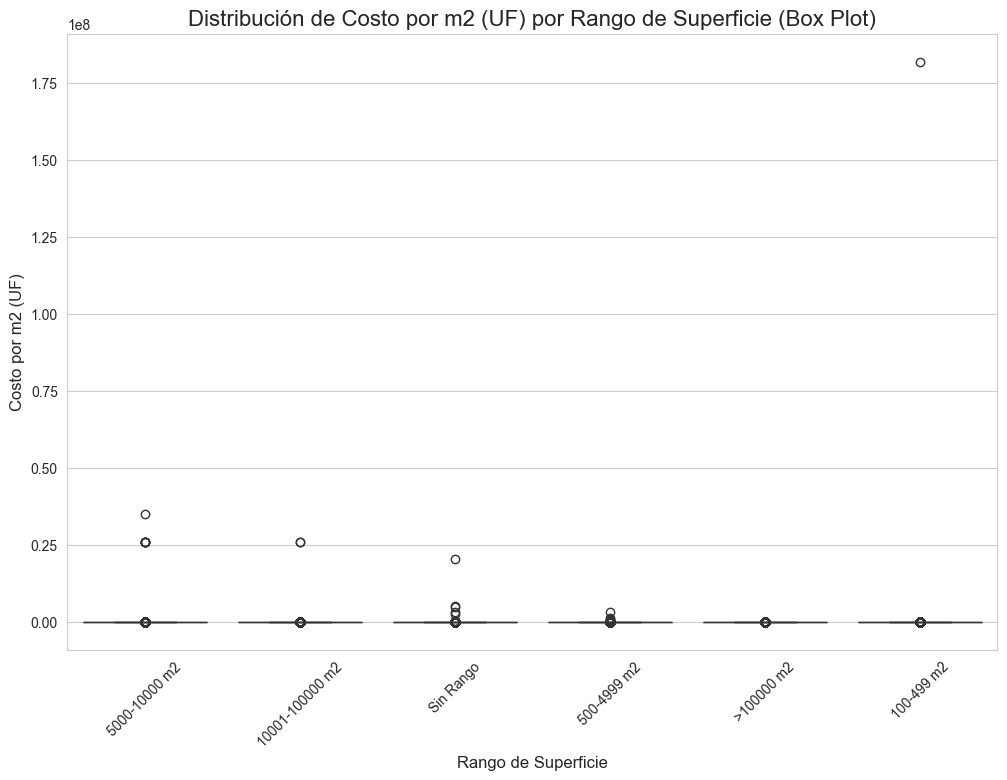

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Paso 1: Clasificar los datos por rangos de superficie (si no lo has hecho antes)
def clasificar_rango_superficie(row):
    if row['total_o_terreno'] >= 100 and row['total_o_terreno'] <= 499:
        return '100-499 m2'
    elif row['total_o_terreno'] >= 500 and row['total_o_terreno'] <= 4999:
        return '500-4999 m2'
    elif row['total_o_terreno'] >= 5000 and row['total_o_terreno'] <= 10000:
        return '5000-10000 m2'
    elif row['total_o_terreno'] >= 10001 and row['total_o_terreno'] <= 100000:
        return '10001-100000 m2'
    elif row['total_o_terreno'] > 100000:
        return '>100000 m2'
    else:
        return 'Sin Rango'

# Aplicar la clasificación a data_2021
data_2021['rango_superficie'] = data_2021.apply(clasificar_rango_superficie, axis=1)

# Paso 2: Crear el box plot para costo_m2_uf por rango de superficie
plt.figure(figsize=(12, 8))

# Crear el boxplot
sns.boxplot(x='rango_superficie', y='costo_m2_uf', data=data_2021, palette="Blues")

# Personalización del gráfico
plt.title('Distribución de Costo por m2 (UF) por Rango de Superficie (Box Plot)', fontsize=16)
plt.xlabel('Rango de Superficie', fontsize=12)
plt.ylabel('Costo por m2 (UF)', fontsize=12)
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()



## Densidad por rango

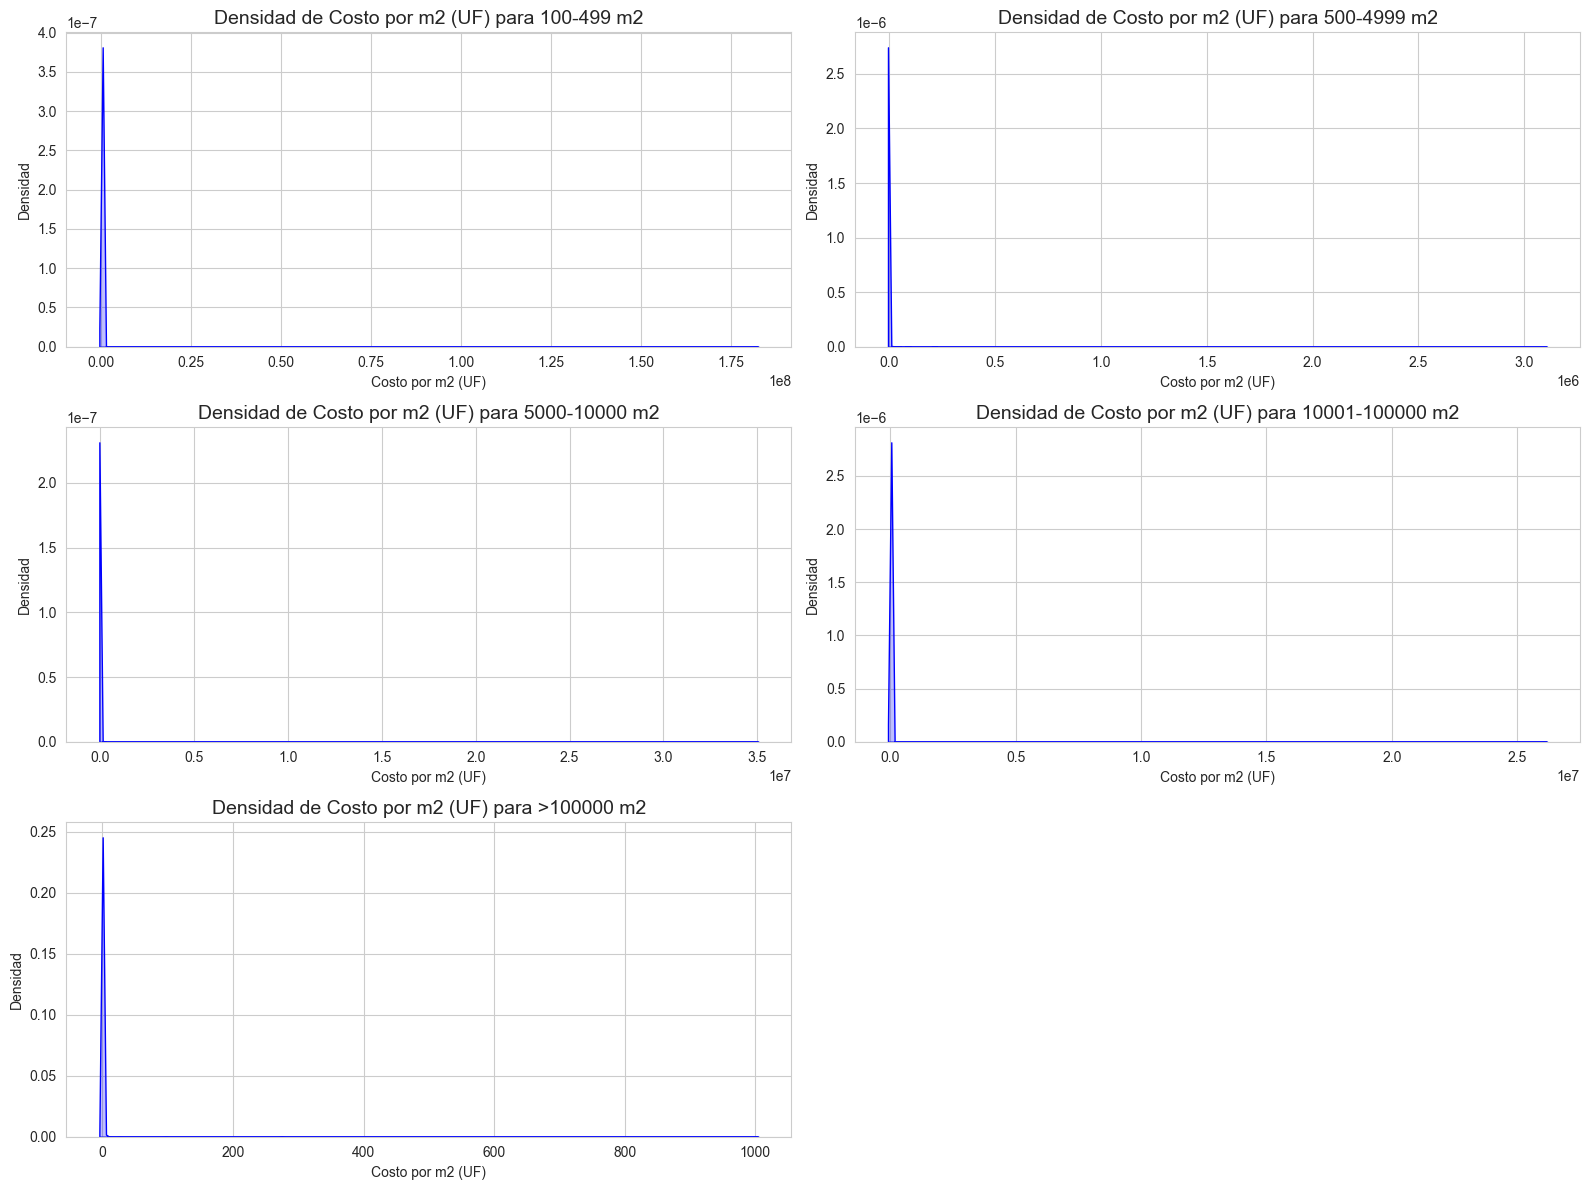

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Paso 1: Filtrar las categorías de rangos de superficie que ya tenemos en data_2021
rango_superficies = ['100-499 m2', '500-4999 m2', '5000-10000 m2', '10001-100000 m2', '>100000 m2']

# Paso 2: Crear un grid de gráficos de densidad
plt.figure(figsize=(16, 12))

# Crear un subplot para cada rango de superficie
for i, rango in enumerate(rango_superficies):
    plt.subplot(3, 2, i + 1)
    
    # Filtrar los datos del rango de superficie actual
    data_rango = data_2021[data_2021['rango_superficie'] == rango]
    
    # Crear el kdeplot (gráfico de densidad)
    sns.kdeplot(data=data_rango, x='costo_m2_uf', fill=True, color='blue')
    
    # Título del gráfico
    plt.title(f'Densidad de Costo por m2 (UF) para {rango}', fontsize=14)
    
    # Etiquetas
    plt.xlabel('Costo por m2 (UF)')
    plt.ylabel('Densidad')

# Ajustar el espacio entre subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [11]:
import pandas as pd

# Paso 1: Clasificar los datos por rangos de superficie (si no lo has hecho antes)
def clasificar_rango_superficie(row):
    if row['total_o_terreno'] >= 100 and row['total_o_terreno'] <= 499:
        return '100-499 m2'
    elif row['total_o_terreno'] >= 500 and row['total_o_terreno'] <= 4999:
        return '500-4999 m2'
    elif row['total_o_terreno'] >= 5000 and row['total_o_terreno'] <= 10000:
        return '5000-10000 m2'
    elif row['total_o_terreno'] >= 10001 and row['total_o_terreno'] <= 100000:
        return '10001-100000 m2'
    elif row['total_o_terreno'] > 100000:
        return '>100000 m2'
    else:
        return 'Sin Rango'

# Aplicar la clasificación a data_2021
data_2021['rango_superficie'] = data_2021.apply(clasificar_rango_superficie, axis=1)

# Paso 2: Definir una función para calcular los estadísticos y detectar outliers con IQR por comuna y semestre
def calcular_estadisticos_con_iqr(grupo):
    # Calcular estadísticas básicas sobre 'costo_m2_uf'
    min_val = grupo['costo_m2_uf'].min()
    mean_val = grupo['costo_m2_uf'].mean()
    median_val = grupo['costo_m2_uf'].median()
    max_val = grupo['costo_m2_uf'].max()
    
    # Calcular Q1, Q3, IQR y los límites inferior y superior
    Q1 = grupo['costo_m2_uf'].quantile(0.25)
    Q3 = grupo['costo_m2_uf'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtrar los outliers usando los límites inferior y superior
    outliers_lower = grupo[grupo['costo_m2_uf'] < lower_bound]
    outliers_upper = grupo[grupo['costo_m2_uf'] > upper_bound]
    total_outliers = len(outliers_lower) + len(outliers_upper)
    
    # Total de datos en el grupo
    total_datos = len(grupo)
    
    # Calcular el porcentaje de outliers
    porcentaje_outliers = (total_outliers / total_datos) * 100 if total_datos > 0 else 0
    
    # Devolver los resultados en un DataFrame
    return pd.Series({
        'Mínimo': min_val,
        'Media': mean_val,
        'Mediana': median_val,
        'Máximo': max_val,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Total Outliers (IQR)': total_outliers,  # Número de outliers detectados
        'Total de Datos': total_datos,  # Total de datos por grupo
        '% Outliers': porcentaje_outliers  # Porcentaje de outliers
    })

# Paso 3: Crear una tabla de estadísticas por cada rango de superficie y guardarlas como CSV

# Definir los rangos de superficie
rangos_superficie = ['100-499 m2', '500-4999 m2', '5000-10000 m2', '10001-100000 m2', '>100000 m2']

# Iterar sobre cada rango de superficie y generar la tabla correspondiente
for rango in rangos_superficie:
    # Filtrar los datos para el rango actual
    data_rango = data_2021[data_2021['rango_superficie'] == rango]
    
    # Agrupar por comuna y semestre, y aplicar la función de estadísticas
    estadisticos_por_rango = data_rango.groupby(['comuna_match', 'semestre'], group_keys=False).apply(calcular_estadisticos_con_iqr)
    
    # Guardar cada tabla en un archivo CSV con un nombre que incluye el rango de superficie
    nombre_archivo = f"data recuperada/estadisticos_{rango.replace(' ', '_').replace('>', 'mas')}.csv"
    estadisticos_por_rango.to_csv(nombre_archivo)
    
    # Mostrar la tabla del rango actual
    print(f"\nEstadísticas para el rango de superficie {rango} guardadas en {nombre_archivo}")


KeyError: 'semestre'

In [187]:
# Paso 1: Clasificar los datos por rangos de superficie (si no lo has hecho antes)
def clasificar_rango_superficie(row):
    if row['total_o_terreno'] >= 100 and row['total_o_terreno'] <= 499:
        return '100-499 m2'
    elif row['total_o_terreno'] >= 500 and row['total_o_terreno'] <= 4999:
        return '500-4999 m2'
    elif row['total_o_terreno'] >= 5000 and row['total_o_terreno'] <= 10000:
        return '5000-10000 m2'
    elif row['total_o_terreno'] >= 10001 and row['total_o_terreno'] <= 100000:
        return '10001-100000 m2'
    elif row['total_o_terreno'] > 100000:
        return '>100000 m2'
    else:
        return 'Sin Rango'

# Aplicar la clasificación a data_2021
data_2019['rango_superficie'] = data_2019.apply(clasificar_rango_superficie, axis=1)

In [188]:
# Lista de rangos de superficie que ya habías definido
rangos_superficie = ['100-499 m2', '500-4999 m2', '5000-10000 m2', '10001-100000 m2', '>100000 m2']

In [ ]:
import pandas as pd

# Lista de rangos de superficie que ya habías definido
rangos_superficie = ['100-499 m2', '500-4999 m2', '5000-10000 m2', '10001-100000 m2', '>100000 m2']

# Inicializar las variables para acumular el total de datos y outliers
total_datos_suma = 0
total_outliers_suma = 0

# Iterar sobre cada rango de superficie para sumar los totales de datos y outliers
for rango in rangos_superficie:
    # Leer el archivo CSV correspondiente
    nombre_archivo = f"data recuperada/estadisticos_{rango.replace(' ', '_').replace('>', 'mas')}.csv"
    estadisticos_por_rango = pd.read_csv(nombre_archivo)
    
    # Sumar el total de datos y el total de outliers por rango
    total_datos_rango = estadisticos_por_rango['Total de Datos'].sum()
    total_outliers_rango = estadisticos_por_rango['Total Outliers (IQR)'].sum()
    
    # Calcular el porcentaje de outliers por rango
    porcentaje_outliers_rango = (total_outliers_rango / total_datos_rango) * 100 if total_datos_rango > 0 else 0
    
    # Mostrar los resultados por rango
    print(f"\nRango de superficie: {rango}")
    print(f"Suma de Total de Datos: {total_datos_rango}")
    print(f"Suma de Total de Outliers: {total_outliers_rango}")
    print(f"Porcentaje de outliers: {porcentaje_outliers_rango:.2f}%")
    
    # Acumular los totales para el cálculo final
    total_datos_suma += total_datos_rango
    total_outliers_suma += total_outliers_rango

# Total de datos en toda la data_2021
total_datos_entera = len(data_2021)

# Calcular el porcentaje de outliers en comparación con toda la data
porcentaje_outliers_total = (total_outliers_suma / total_datos_entera) * 100 if total_datos_entera > 0 else 0

# Mostrar los resultados totales
print("\n--- Resumen total ---")
print(f"Suma de Total de Datos en todos los rangos: {total_datos_suma}")
print(f"Suma de Total de Outliers en todos los rangos: {total_outliers_suma}")
print(f"Total de datos en toda la data: {total_datos_entera}")
print(f"Porcentaje de outliers en comparación con toda la data: {porcentaje_outliers_total:.2f}%")



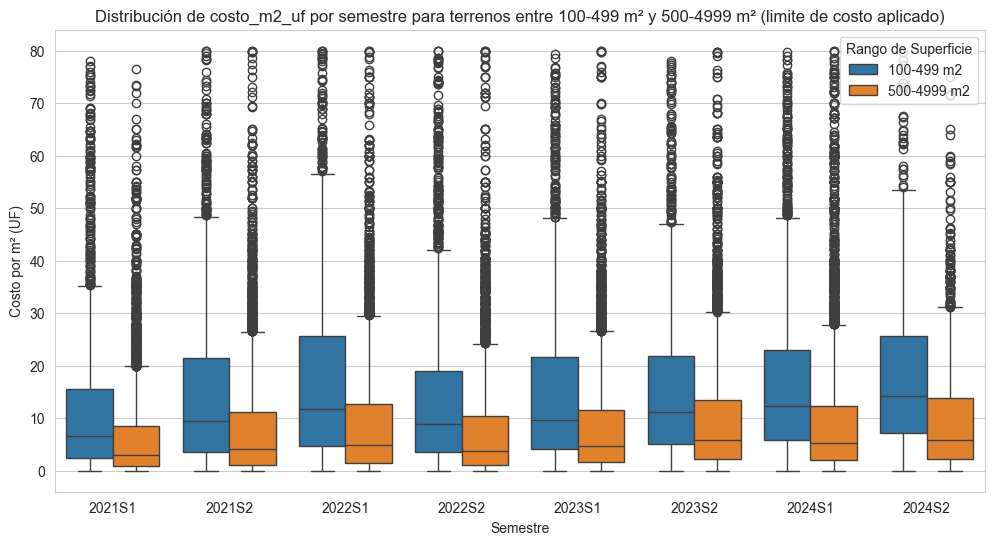

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer un límite superior para el costo por metro cuadrado (por ejemplo, 500 UF/m²)
limite_costo = 80

# Filtrar los datos para terrenos entre 100-499 m2 y 500-4999 m2, y limitar el costo_m2_uf
data_filtrada = data_2021[(data_2021['rango_superficie'].isin(['100-499 m2', '500-4999 m2'])) &
                          (data_2021['costo_m2_uf'] <= limite_costo)]

# Graficar la distribución de costo_m2_uf por semestre
plt.figure(figsize=(12, 6))
sns.boxplot(x='semestre', y='costo_m2_uf', hue='rango_superficie', data=data_filtrada)

# Personalizar el gráfico
plt.title('Distribución de costo_m2_uf por semestre para terrenos entre 100-499 m² y 500-4999 m² (limite de costo aplicado)')
plt.xlabel('Semestre')
plt.ylabel('Costo por m² (UF)')
plt.legend(title='Rango de Superficie')

# Mostrar el gráfico
plt.show()



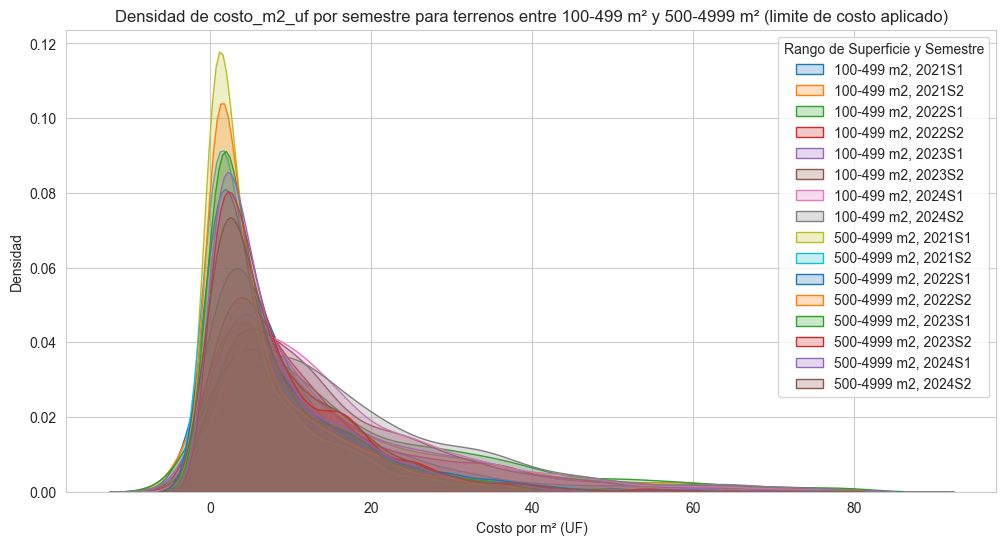

In [17]:
plt.figure(figsize=(12, 6))

# Graficar la densidad de costo_m2_uf por semestre y rango de superficie, con límite aplicado
for rango in ['100-499 m2', '500-4999 m2']:
    for semestre in data_filtrada['semestre'].unique():
        sns.kdeplot(
            data=data_filtrada[(data_filtrada['rango_superficie'] == rango) & (data_filtrada['semestre'] == semestre)],
            x='costo_m2_uf', label=f"{rango}, {semestre}", fill=True
        )

# Personalizar el gráfico
plt.title('Densidad de costo_m2_uf por semestre para terrenos entre 100-499 m² y 500-4999 m² (limite de costo aplicado)')
plt.xlabel('Costo por m² (UF)')
plt.ylabel('Densidad')
plt.legend(title='Rango de Superficie y Semestre')

# Mostrar el gráfico
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Establecer un límite superior para el costo por metro cuadrado (por ejemplo, 100 UF/m²)
limite_costo = 80

# Filtrar los datos para terrenos entre 100-499 m2 y limitar el costo_m2_uf
data_100_499 = data_2021[(data_2021['rango_superficie'] == '100-499 m2') &
                         (data_2021['costo_m2_uf'] <= limite_costo)]

# Filtrar los datos para terrenos entre 500-4999 m2 y limitar el costo_m2_uf
data_500_4999 = data_2021[(data_2021['rango_superficie'] == '500-4999 m2') &
                          (data_2021['costo_m2_uf'] <= limite_costo)]

# Crear el primer grid para terrenos entre 100-499 m²
g1 = sns.FacetGrid(data_100_499, col="semestre", col_wrap=4, margin_titles=True, height=4, aspect=1.5)
g1.map(sns.kdeplot, "costo_m2_uf", fill=True)
g1.set_axis_labels("Costo por m² (UF)", "Densidad")
g1.fig.subplots_adjust(top=0.85)
g1.fig.suptitle('Densidad de costo_m2_uf para terrenos entre 100-499 m² (límite de costo aplicado)', fontsize=16)
g1.set_titles(col_template="Semestre: {col_name}")
g1.tight_layout()

# Mostrar el primer gráfico
plt.show()

# Crear el segundo grid para terrenos entre 500-4999 m²
g2 = sns.FacetGrid(data_500_4999, col="semestre", col_wrap=4, margin_titles=True, height=4, aspect=1.5)
g2.map(sns.kdeplot, "costo_m2_uf", fill=True)
g2.set_axis_labels("Costo por m² (UF)", "Densidad")
g2.fig.subplots_adjust(top=0.85)
g2.fig.suptitle('Densidad de costo_m2_uf para terrenos entre 500-4999 m² (límite de costo aplicado)', fontsize=16)
g2.set_titles(col_template="Semestre: {col_name}")
g2.tight_layout()

# Mostrar el segundo gráfico
plt.show()


In [ ]:
import pandas as pd

# Paso 1: Filtrar los datos para quitar los registros con costo_m2_uf = 0
data_con_costo = data_2021[data_2021['costo_m2_uf'] != 0]

# Paso 2: Contar cuántos datos se eliminaron por cada rango de superficie
rangos_superficie = ['100-499 m2', '500-4999 m2', '5000-10000 m2', '10001-100000 m2', '>100000 m2']

# Contar los datos eliminados y los totales por cada rango de superficie
conteo_eliminados = {}
conteo_totales = {}

for rango in rangos_superficie:
    total_datos_rango = len(data_2021[data_2021['rango_superficie'] == rango])
    total_datos_con_costo_rango = len(data_con_costo[data_con_costo['rango_superficie'] == rango])
    eliminados = total_datos_rango - total_datos_con_costo_rango
    conteo_eliminados[rango] = eliminados
    conteo_totales[rango] = total_datos_rango

# Mostrar los resultados
for rango in rangos_superficie:
    print(f"Rango de superficie {rango}:")
    print(f"  Total de datos: {conteo_totales[rango]}")
    print(f"  Eliminados con costo_m2_uf = 0: {conteo_eliminados[rango]}")
    print(f"  Datos restantes: {conteo_totales[rango] - conteo_eliminados[rango]}\n")


In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest

# Paso 1: Definir la función para aplicar Isolation Forest, detectar outliers y calcular estadísticos
def detectar_outliers_isolation_forest_con_estadisticos(data):
    # Eliminar los valores faltantes en 'costo_m2_uf' antes de aplicar Isolation Forest
    data = data.dropna(subset=['costo_m2_uf'])
    
    # Definir el modelo de Isolation Forest
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    
    # Aplicar Isolation Forest sobre la columna 'costo_m2_uf'
    data['is_outlier'] = iso_forest.fit_predict(data[['costo_m2_uf']])
    
    # Los outliers serán aquellos con el valor de -1
    data['is_outlier'] = data['is_outlier'].apply(lambda x: 1 if x == -1 else 0)
    
    # Contar cuántos outliers se detectaron
    total_outliers = data['is_outlier'].sum()
    
    # Calcular los estadísticos básicos
    min_val = data['costo_m2_uf'].min()
    mean_val = data['costo_m2_uf'].mean()
    median_val = data['costo_m2_uf'].median()
    max_val = data['costo_m2_uf'].max()
    
    return data, total_outliers, min_val, mean_val, median_val, max_val

# Inicializamos una lista para almacenar los resultados
resultados_outliers = []

# Inicializamos un DataFrame para almacenar la data sin outliers
data_sin_outliers = pd.DataFrame()

# Paso 2: Iterar sobre cada rango de superficie, comuna y semestre
for rango in rangos_superficie:
    # Filtrar los datos para cada rango de superficie
    data_rango = data_con_costo[data_con_costo['rango_superficie'] == rango]
    
    # Agrupar por comuna y semestre
    for (comuna, semestre), data_grupo in data_rango.groupby(['comuna_match', 'semestre']):
        # Aplicar la función para detectar outliers con Isolation Forest en cada grupo y calcular estadísticos
        data_grupo, total_outliers_grupo, min_val, mean_val, median_val, max_val = detectar_outliers_isolation_forest_con_estadisticos(data_grupo)
        
        # Filtrar los datos que no son outliers y agregarlos a 'data_sin_outliers'
        data_sin_outliers = pd.concat([data_sin_outliers, data_grupo[data_grupo['is_outlier'] == 0]])
        
        # Calcular el porcentaje de outliers
        total_datos_grupo = len(data_grupo)
        porcentaje_outliers_grupo = (total_outliers_grupo / total_datos_grupo) * 100 if total_datos_grupo > 0 else 0
        
        # Almacenar los resultados en la lista
        resultados_outliers.append({
            'Rango de Superficie': rango,
            'Comuna': comuna,
            'Semestre': semestre,
            'Total de Datos': total_datos_grupo,
            'Total Outliers (Isolation)': total_outliers_grupo,
            '% Outliers': porcentaje_outliers_grupo,
            'Mínimo': min_val,
            'Media': mean_val,
            'Mediana': median_val,
            'Máximo': max_val
        })

# Convertir la lista de resultados en un DataFrame
df_resultados_outliers = pd.DataFrame(resultados_outliers)

# Paso 3: Guardar las tablas como CSV
for rango in rangos_superficie:
    # Filtrar los resultados para cada rango de superficie
    df_rango = df_resultados_outliers[df_resultados_outliers['Rango de Superficie'] == rango]
    
    # Guardar el archivo CSV
    nombre_archivo = f"data recuperada/outliers_isolation_{rango.replace(' ', '_').replace('>', 'mas')}.csv"
    df_rango.to_csv(nombre_archivo, index=False)
    
    # Mostrar la ruta donde se guarda el archivo
    print(f"Tabla de outliers y estadísticos para el rango de superficie {rango} guardada en: {nombre_archivo}")

# Paso 4: Guardar los datos sin outliers en un CSV
data_sin_outliers.to_csv("data recuperada/data_sin_outliers.csv", index=False)

print(f"Data sin outliers guardada en: data recuperada/data_sin_outliers.csv")




In [190]:
data_2019.columns

Index(['id', 'concat', 'publicada', 'created_at', 'data_source', 'tipo',
       'sub_tipo', 'precio_clp', 'precio_uf', 'region', 'comuna', 'latitude',
       'longitude', 'total_o_terreno', 'util_o_construido', 'active',
       'fecha_finalizacion', 'precio_clp_inicial', 'precio_uf_inicial',
       'descripcion_sin_saltos', 'direccion_sin_saltos', 'descripcion_2',
       'region_norm', 'comuna_norm', 'comuna_match', 'superficies_dict',
       'mayor_superficie', 'diferencia_pct', 'diferencia_abs', 'semestre',
       'descripcion_normalizada', 'duplicados_con', 'duplicado',
       'valor_uf_inicial', 'valor_uf', 'margen_uf_inicial', 'margen_uf',
       'dif_pct_abs', 'UF_Ha', 'total_o_terreno_ha', 'UF_Ha_inicial',
       'superficie_Ha', 'costo_m2_uf', 'rango_superficie'],
      dtype='object')

In [191]:
#-----------------------------------------2019------------------------------------------------------#
import pandas as pd
from sklearn.ensemble import IsolationForest

# Paso 1: Definir la función para aplicar Isolation Forest, detectar outliers y calcular estadísticos
def detectar_outliers_isolation_forest_con_estadisticos(data):
    # Eliminar los valores faltantes en 'costo_m2_uf' antes de aplicar Isolation Forest
    data = data.dropna(subset=['costo_m2_uf'])
    
    # Asegurarse de que hay suficientes datos para aplicar el modelo
    if len(data) < 1:
        return data, 0, None, None, None, None  # Devolver valores nulos si no hay datos suficientes
    
    # Definir el modelo de Isolation Forest
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    
    # Aplicar Isolation Forest sobre la columna 'costo_m2_uf'
    data['is_outlier'] = iso_forest.fit_predict(data[['costo_m2_uf']])
    
    # Los outliers serán aquellos con el valor de -1
    data['is_outlier'] = data['is_outlier'].apply(lambda x: 1 if x == -1 else 0)
    
    # Contar cuántos outliers se detectaron
    total_outliers = data['is_outlier'].sum()
    
    # Calcular los estadísticos básicos
    min_val = data['costo_m2_uf'].min()
    mean_val = data['costo_m2_uf'].mean()
    median_val = data['costo_m2_uf'].median()
    max_val = data['costo_m2_uf'].max()
    
    return data, total_outliers, min_val, mean_val, median_val, max_val

# Inicializamos una lista para almacenar los resultados
resultados_outliers = []

# Inicializamos un DataFrame para almacenar la data sin outliers
data_sin_outliers = pd.DataFrame()

# Asegúrate de que 'rangos_superficie', 'data_2019', 'semestre', 'comuna_match' y 'costo_m2_uf' están definidos
rangos_superficie = data_2019['rango_superficie'].unique()

# Paso 2: Iterar sobre cada rango de superficie, comuna y semestre
for rango in rangos_superficie:
    # Filtrar los datos para cada rango de superficie
    data_rango = data_2019[data_2019['rango_superficie'] == rango]
    
    # Agrupar por comuna y semestre
    for (comuna, semestre), data_grupo in data_rango.groupby(['comuna_match', 'semestre']):
        # Verificar si hay suficientes datos en la columna 'costo_m2_uf'
        if data_grupo['costo_m2_uf'].isna().all() or len(data_grupo.dropna(subset=['costo_m2_uf'])) == 0:
            print(f"Omitiendo {semestre} en comuna {comuna}: sin datos suficientes")
            continue
        
        # Aplicar la función para detectar outliers con Isolation Forest en cada grupo y calcular estadísticos
        data_grupo, total_outliers_grupo, min_val, mean_val, median_val, max_val = detectar_outliers_isolation_forest_con_estadisticos(data_grupo)
        
        # Filtrar los datos que no son outliers y agregarlos a 'data_sin_outliers'
        data_sin_outliers = pd.concat([data_sin_outliers, data_grupo[data_grupo['is_outlier'] == 0]])
        
        # Calcular el porcentaje de outliers
        total_datos_grupo = len(data_grupo)
        porcentaje_outliers_grupo = (total_outliers_grupo / total_datos_grupo) * 100 if total_datos_grupo > 0 else 0
        
        # Almacenar los resultados en la lista
        resultados_outliers.append({
            'Rango de Superficie': rango,
            'Comuna': comuna,
            'Semestre': semestre,
            'Total de Datos': total_datos_grupo,
            'Total Outliers (Isolation)': total_outliers_grupo,
            '% Outliers': porcentaje_outliers_grupo,
            'Mínimo': min_val,
            'Media': mean_val,
            'Mediana': median_val,
            'Máximo': max_val
        })

# Convertir la lista de resultados en un DataFrame
df_resultados_outliers = pd.DataFrame(resultados_outliers)

# Paso 3: Guardar los datos sin outliers en un CSV
data_sin_outliers.to_csv("data recuperada/data_sin_outliers2019.csv", index=False)

# Mostrar un mensaje con la ruta del archivo
print(f"Data sin outliers guardada en: data recuperada/data_sin_outliers2019.csv")




C:\Users\franc\AppData\Local\Temp\ipykernel_21588\1888569012.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\franc\AppData\Local\Temp\ipykernel_21588\1888569012.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\franc\AppData\Local\Temp\ipykernel_21588\1888569012.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

Omitiendo 2020S2 en comuna TORRES DEL PAINE: sin datos suficientes


C:\Users\franc\AppData\Local\Temp\ipykernel_21588\1888569012.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\franc\AppData\Local\Temp\ipykernel_21588\1888569012.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\franc\AppData\Local\Temp\ipykernel_21588\1888569012.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

Omitiendo 2020S2 en comuna RENAICO: sin datos suficientes


C:\Users\franc\AppData\Local\Temp\ipykernel_21588\1888569012.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\franc\AppData\Local\Temp\ipykernel_21588\1888569012.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\franc\AppData\Local\Temp\ipykernel_21588\1888569012.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

Omitiendo 2019S1 en comuna LAS CONDES: sin datos suficientes
Omitiendo 2019S1 en comuna MACUL: sin datos suficientes


C:\Users\franc\AppData\Local\Temp\ipykernel_21588\1888569012.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\franc\AppData\Local\Temp\ipykernel_21588\1888569012.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Data sin outliers guardada en: data recuperada/data_sin_outliers2019.csv


In [192]:
data_2019 = pd.read_csv("data recuperada/data_sin_outliers2019.csv")

In [ ]:
import pandas as pd

# Sumar el total de outliers y total de datos por cada rango de superficie
outliers_por_rango = df_resultados_outliers.groupby('Rango de Superficie').agg({
    'Total Outliers (Isolation)': 'sum',
    'Total de Datos': 'sum'
}).reset_index()

# Calcular el porcentaje de outliers por rango de superficie
outliers_por_rango['% Outliers'] = (outliers_por_rango['Total Outliers (Isolation)'] / 
                                    outliers_por_rango['Total de Datos']) * 100

# Calcular el total general de datos y de outliers en toda la data
total_outliers_general = outliers_por_rango['Total Outliers (Isolation)'].sum()
total_datos_general = outliers_por_rango['Total de Datos'].sum()

# Calcular el porcentaje de outliers en comparación con el total de la data
porcentaje_outliers_general = (total_outliers_general / total_datos_general) * 100

# Mostrar los resultados por rango de superficie
print("Comparación por rango de superficie:")
print(outliers_por_rango)

# Mostrar el resultado general
print("\nComparación general de toda la data:")
print(f"Total de Outliers en toda la data: {total_outliers_general}")
print(f"Total de Datos en toda la data: {total_datos_general}")
print(f"Porcentaje de Outliers en toda la data: {porcentaje_outliers_general:.2f}%")


# Punto de CONTROL 18/10

In [12]:
import pandas as pd
data_2021 = pd.read_csv("data recuperada/data_sin_outliers.csv")

In [3]:
data_2021

id                                             concat  \
0        678938  https://www.portalinmobiliario.com/venta/sitio...   
1        707064  https://www.portalinmobiliario.com/venta/sitio...   
2        746705  https://www.portalinmobiliario.com/MLC-5792674...   
3        843165  https://www.yapo.cl/valparaiso/comprar/en_vent...   
4        846906  https://www.yapo.cl/valparaiso/comprar/inviert...   
...         ...                                                ...   
200265  2268461  https://www.portalinmobiliario.com/MLC-1964824...   
200266  7635076  https://www.portalinmobiliario.com/MLC-1494194...   
200267  6951979  https://www.portalinmobiliario.com/MLC-2268579...   
200268  7725735  https://www.portalinmobiliario.com/MLC-1500024...   
200269  7762536  https://www.portalinmobiliario.com/MLC-2571611...   

         publicada  created_at         data_source     tipo sub_tipo  \
0       2021-02-05  2021-01-05  Portalinmobiliario  Terreno  Terreno   
1       2021-01-19  2021-01-28  Portalinmobiliario  Terreno  Terreno   
2       2021-01-30  2021-02-04  Portalinmobiliario  Terreno  Terreno   
3       2021-02-22  2021-02-24                Yapo  Terreno  Terreno   
4       2021-02-20  2021-02-24                Yapo  Terreno  Terreno   
...            ...         ...                 ...      ...      ...   
200265  2024-03-16  2022-01-21  Portalinmobiliario  Terreno  Terreno   
200266  2024-06-17  2024-06-18  Portalinmobiliario  Terreno  Terreno   
200267  2024-01-12  2024-02-10  Portalinmobiliario  Terreno  Terreno   
200268  2024-07-04  2024-07-05  Portalinmobiliario  Terreno  Terreno   
200269  2024-07-12  2024-07-13  Portalinmobiliario  Terreno  Terreno   

          precio_clp     precio_uf      region  ... margen_uf  dif_pct_abs  \
0       6.164553e+07   2100.000000  VALPARAISO  ...         1          NaN   
1       3.900000e+07   1339.501911  VALPARAISO  ...         1          NaN   
2       5.700000e+07   1947.685842  VALPARAISO  ...         1     0.000000   
3       5.500000e+07   1884.030000  VALPARAISO  ...         1          NaN   
4       2.400000e+08   8221.230000  VALPARAISO  ...         1     0.000000   
...              ...           ...         ...  ...       ...          ...   
200265  7.251596e+08  19500.000000  VALPARAISO  ...         1    98.524805   
200266  1.145624e+08   3050.000000  VALPARAISO  ...         1    91.300000   
200267  5.137618e+08  14000.000000  VALPARAISO  ...         1    98.389000   
200268  1.155815e+08   3050.000000  VALPARAISO  ...         1    91.300000   
200269  1.749582e+09  46550.000000  VALPARAISO  ...         1     0.000000   

                UF_Ha  total_o_terreno_ha  UF_Ha_inicial  superficie_Ha  \
0        52500.000000              0.0400   52500.000000         0.0400   
1        72405.508722              0.0185   72405.508722         0.0185   
2        55648.166905              0.0350   55714.285714         0.0350   
3        41407.252747              0.0455   41407.252747         0.0455   
4       194815.876777              0.0422  194815.876777         0.0422   
...               ...                 ...            ...            ...   
200265     550.867687             35.3987     593.242125        35.3987   
200266     254.166667             12.0000     254.166667        12.0000   
200267     700.000000             20.0000     700.000000        20.0000   
200268     254.166667             12.0000     254.166667        12.0000   
200269    1443.410853             32.2500    1443.410853        32.2500   

                                          valores_terreno  costo_m2_uf  \
0                                                      {}     5.250000   
1                                                      {}     7.240551   
2       {'valor_1': {'valor': 350.0, 'moneda': 'descon...     5.564817   
3                                                      {}     4.140725   
4       {'valor_1': {'valor': 1.0, 'moneda': 'desconoc...    19.481588   
...                      

In [ ]:
data_2021 = data_sin_outliers

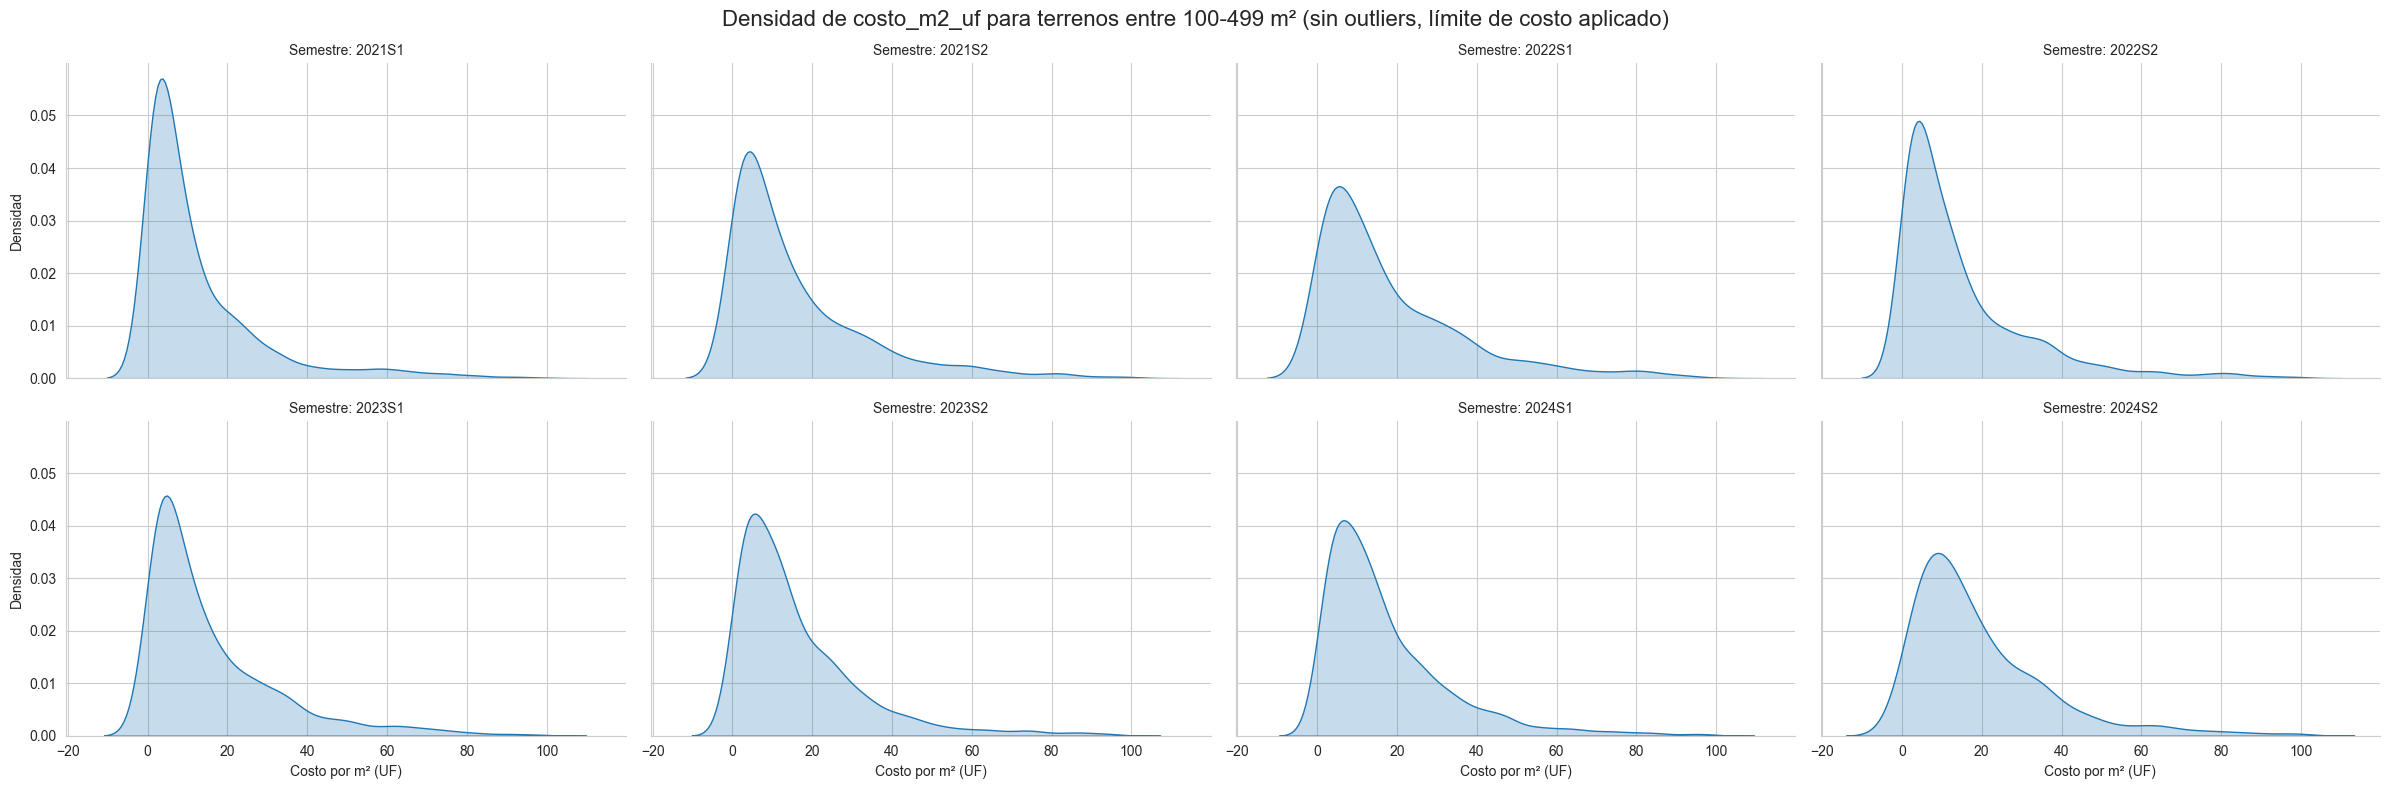

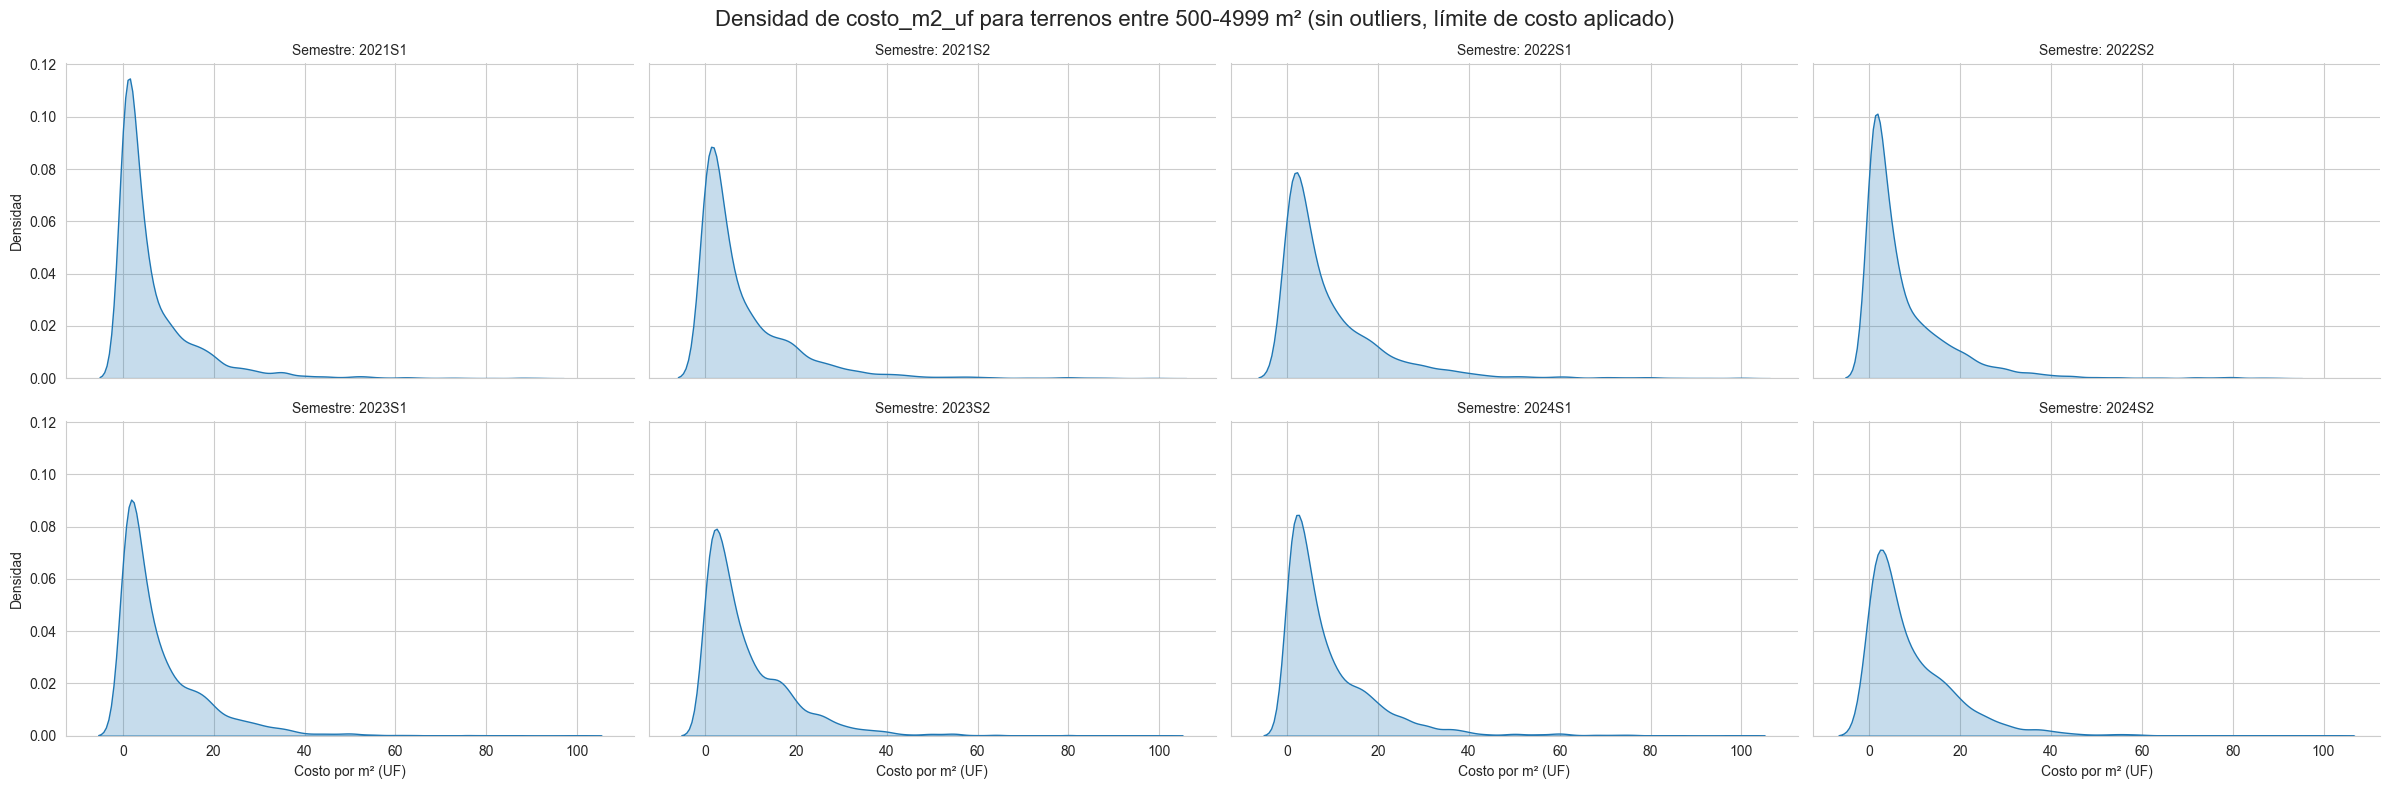

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Establecer un límite superior para el costo por metro cuadrado (por ejemplo, 80 UF/m²)
limite_costo = 100

# Filtrar los datos para terrenos entre 100-499 m2, limitar el costo_m2_uf y excluir los outliers
data_100_499_sin_outliers = data_2021[(data_2021['rango_superficie'] == '100-499 m2') &
                                      (data_2021['costo_m2_uf'] <= limite_costo) &
                                      (data_2021['is_outlier'] == 0)]

# Filtrar los datos para terrenos entre 500-4999 m2, limitar el costo_m2_uf y excluir los outliers
data_500_4999_sin_outliers = data_2021[(data_2021['rango_superficie'] == '500-4999 m2') &
                                       (data_2021['costo_m2_uf'] <= limite_costo) &
                                       (data_2021['is_outlier'] == 0)]

# Crear el primer grid para terrenos entre 100-499 m² sin outliers
g1 = sns.FacetGrid(data_100_499_sin_outliers, col="semestre", col_wrap=4, margin_titles=True, height=4, aspect=1.5)
g1.map(sns.kdeplot, "costo_m2_uf", fill=True)
g1.set_axis_labels("Costo por m² (UF)", "Densidad")
g1.fig.subplots_adjust(top=0.85)
g1.fig.suptitle('Densidad de costo_m2_uf para terrenos entre 100-499 m² (sin outliers, límite de costo aplicado)', fontsize=16)
g1.set_titles(col_template="Semestre: {col_name}")
g1.tight_layout()

# Mostrar el primer gráfico
plt.show()

# Crear el segundo grid para terrenos entre 500-4999 m² sin outliers
g2 = sns.FacetGrid(data_500_4999_sin_outliers, col="semestre", col_wrap=4, margin_titles=True, height=4, aspect=1.5)
g2.map(sns.kdeplot, "costo_m2_uf", fill=True)
g2.set_axis_labels("Costo por m² (UF)", "Densidad")
g2.fig.subplots_adjust(top=0.85)
g2.fig.suptitle('Densidad de costo_m2_uf para terrenos entre 500-4999 m² (sin outliers, límite de costo aplicado)', fontsize=16)
g2.set_titles(col_template="Semestre: {col_name}")
g2.tight_layout()

# Mostrar el segundo gráfico
plt.show()


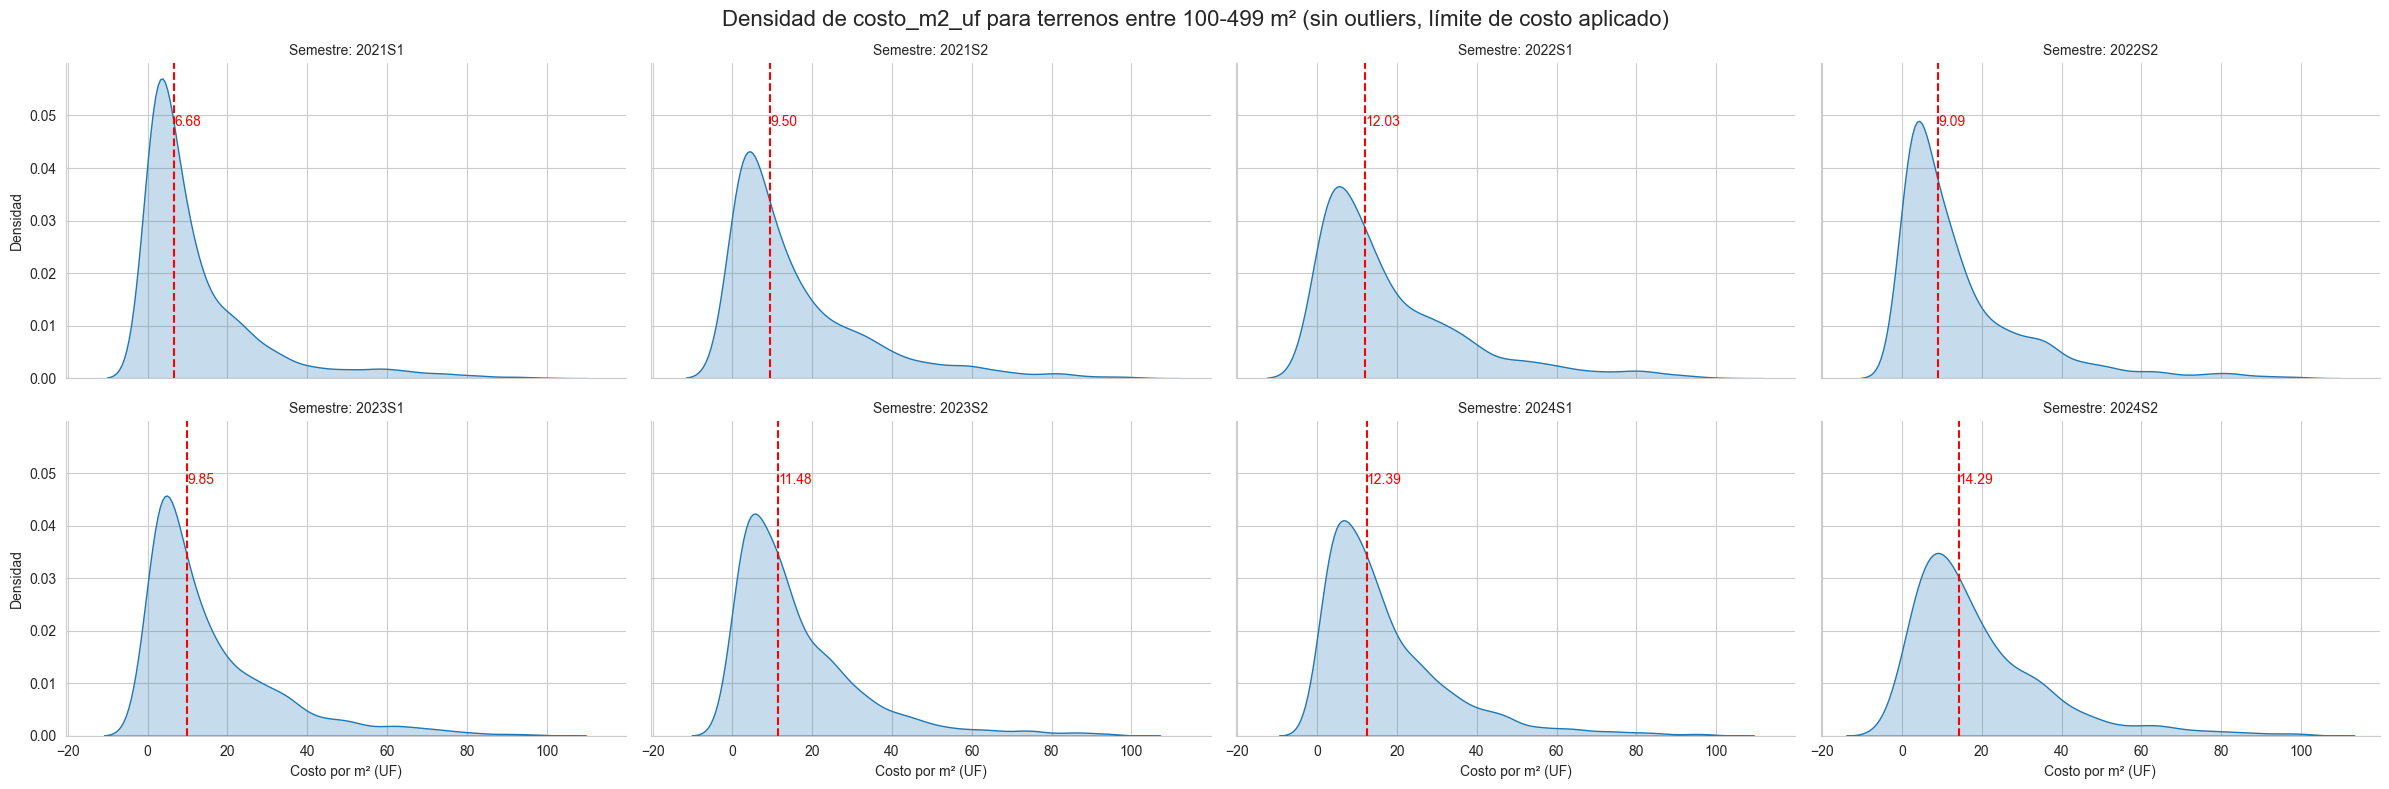

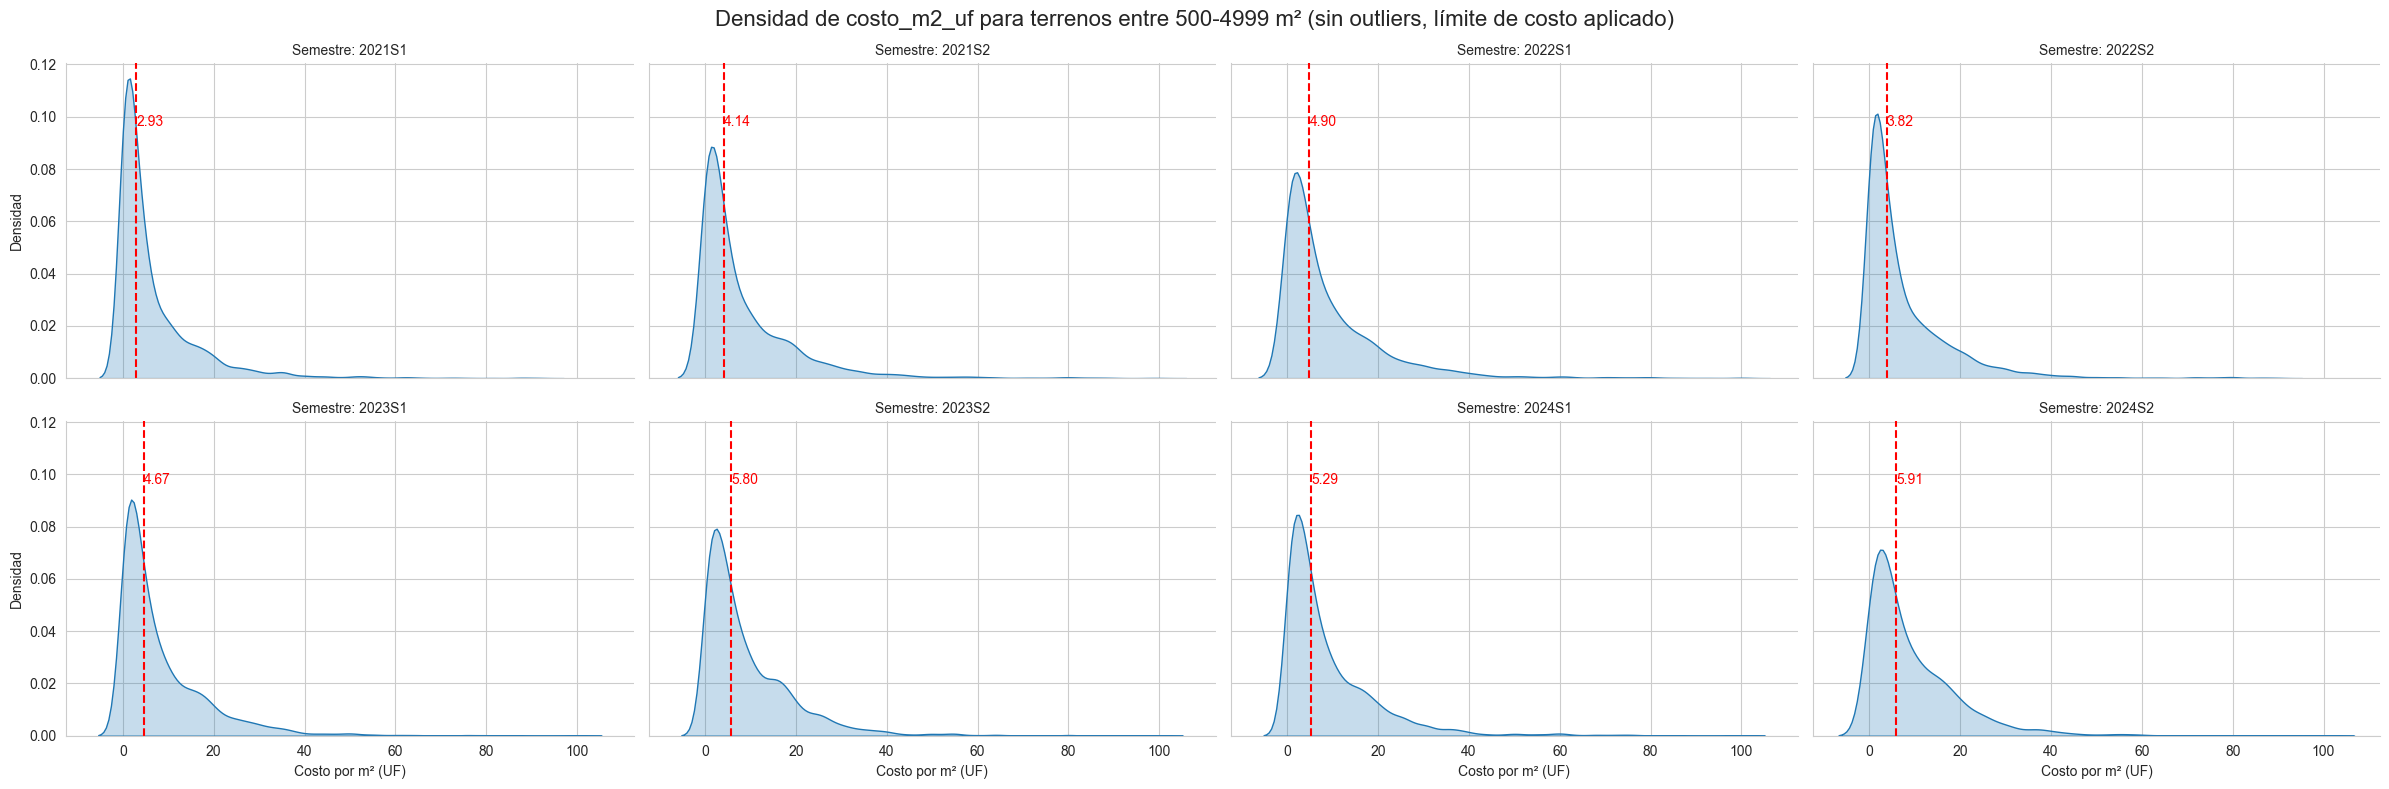

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Establecer un límite superior para el costo por metro cuadrado (por ejemplo, 100 UF/m²)
limite_costo = 100

# Filtrar los datos para terrenos entre 100-499 m2, limitar el costo_m2_uf y excluir los outliers
data_100_499_sin_outliers = data_2021[(data_2021['rango_superficie'] == '100-499 m2') &
                                      (data_2021['costo_m2_uf'] <= limite_costo) &
                                      (data_2021['is_outlier'] == 0)]

# Filtrar los datos para terrenos entre 500-4999 m2, limitar el costo_m2_uf y excluir los outliers
data_500_4999_sin_outliers = data_2021[(data_2021['rango_superficie'] == '500-4999 m2') &
                                       (data_2021['costo_m2_uf'] <= limite_costo) &
                                       (data_2021['is_outlier'] == 0)]

# Función para graficar la densidad y agregar la línea de la mediana
def plot_with_median(data, **kwargs):
    ax = plt.gca()  # Obtener el eje actual
    sns.kdeplot(data=data, x="costo_m2_uf", fill=True, ax=ax)
    # Calcular la mediana
    median_val = data['costo_m2_uf'].median()
    # Dibujar la línea de la mediana
    ax.axvline(median_val, color='red', linestyle='--', label=f'Mediana: {median_val:.2f}')
    # Colocar el texto de la mediana
    ax.text(median_val, ax.get_ylim()[1] * 0.8, f'{median_val:.2f}', color='red')

# Crear el primer grid para terrenos entre 100-499 m² sin outliers
g1 = sns.FacetGrid(data_100_499_sin_outliers, col="semestre", col_wrap=4, margin_titles=True, height=4, aspect=1.5)
g1.map_dataframe(plot_with_median)
g1.set_axis_labels("Costo por m² (UF)", "Densidad")
g1.fig.subplots_adjust(top=0.85)
g1.fig.suptitle('Densidad de costo_m2_uf para terrenos entre 100-499 m² (sin outliers, límite de costo aplicado)', fontsize=16)
g1.set_titles(col_template="Semestre: {col_name}")
g1.tight_layout()

# Mostrar el primer gráfico
plt.show()

# Crear el segundo grid para terrenos entre 500-4999 m² sin outliers
g2 = sns.FacetGrid(data_500_4999_sin_outliers, col="semestre", col_wrap=4, margin_titles=True, height=4, aspect=1.5)
g2.map_dataframe(plot_with_median)
g2.set_axis_labels("Costo por m² (UF)", "Densidad")
g2.fig.subplots_adjust(top=0.85)
g2.fig.suptitle('Densidad de costo_m2_uf para terrenos entre 500-4999 m² (sin outliers, límite de costo aplicado)', fontsize=16)
g2.set_titles(col_template="Semestre: {col_name}")
g2.tight_layout()

# Mostrar el segundo gráfico
plt.show()


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Establecer un límite superior para el costo por metro cuadrado (por ejemplo, 100 UF/m²)
limite_costo = 100

# Filtrar los datos para terrenos entre 100-499 m2, limitar el costo_m2_uf y excluir los outliers
data_100_499_sin_outliers = data_2019[(data_2019['rango_superficie'] == '100-499 m2') &
                                      (data_2019['costo_m2_uf'] <= limite_costo) &
                                      (data_2019['is_outlier'] == 0)]

# Filtrar los datos para terrenos entre 500-4999 m2, limitar el costo_m2_uf y excluir los outliers
data_500_4999_sin_outliers = data_2019[(data_2019['rango_superficie'] == '500-4999 m2') &
                                       (data_2019['costo_m2_uf'] <= limite_costo) &
                                       (data_2019['is_outlier'] == 0)]

# Función para graficar la densidad y agregar la línea de la mediana
def plot_with_median(data, **kwargs):
    ax = plt.gca()  # Obtener el eje actual
    sns.kdeplot(data=data, x="costo_m2_uf", fill=True, ax=ax)
    # Calcular la mediana
    median_val = data['costo_m2_uf'].median()
    # Dibujar la línea de la mediana
    ax.axvline(median_val, color='red', linestyle='--', label=f'Mediana: {median_val:.2f}')
    # Colocar el texto de la mediana
    ax.text(median_val, ax.get_ylim()[1] * 0.8, f'{median_val:.2f}', color='red')

# Crear el primer grid para terrenos entre 100-499 m² sin outliers
g1 = sns.FacetGrid(data_100_499_sin_outliers, col="semestre", col_wrap=4, margin_titles=True, height=4, aspect=1.5)
g1.map_dataframe(plot_with_median)
g1.set_axis_labels("Costo por m² (UF)", "Densidad")
g1.fig.subplots_adjust(top=0.85)
g1.fig.suptitle('Densidad de costo_m2_uf para terrenos entre 100-499 m² (sin outliers, límite de costo aplicado)', fontsize=16)
g1.set_titles(col_template="Semestre: {col_name}")
g1.tight_layout()

# Mostrar el primer gráfico
plt.show()

# Crear el segundo grid para terrenos entre 500-4999 m² sin outliers
g2 = sns.FacetGrid(data_500_4999_sin_outliers, col="semestre", col_wrap=4, margin_titles=True, height=4, aspect=1.5)
g2.map_dataframe(plot_with_median)
g2.set_axis_labels("Costo por m² (UF)", "Densidad")
g2.fig.subplots_adjust(top=0.85)
g2.fig.suptitle('Densidad de costo_m2_uf para terrenos entre 500-4999 m² (sin outliers, límite de costo aplicado)', fontsize=16)
g2.set_titles(col_template="Semestre: {col_name}")
g2.tight_layout()

# Mostrar el segundo gráfico
plt.show()


NameError: name 'data_2019' is not defined

### Punto de control

### Algarrobo y Puerto Varas desde 2019

In [196]:
# Filtrar los datos de la comuna PUERTO VARAS
puerto_varas_data = data_2019[data_2019['comuna_match'] == 'PUERTO VARAS']

# Obtener los semestres únicos de la comuna PUERTO VARAS
semestres_unicos_pv = puerto_varas_data['semestre'].unique()

# Mostrar los semestres únicos
print("Semestres únicos en la comuna PUERTO VARAS:")
print(semestres_unicos_pv)


Semestres únicos en la comuna PUERTO VARAS:
['2020S1' '2020S2' '2021S1' '2021S2' '2022S1' '2022S2' '2023S1' '2023S2'
 '2024S1' '2024S2' '2018S2']


In [197]:
# Filtrar los datos de la comuna ALGARROBO
algarrobo_data = data_2019[data_2019['comuna_match'] == 'ALGARROBO']

# Obtener los semestres únicos de la comuna ALGARROBO
semestres_unicos_alg = algarrobo_data['semestre'].unique()

# Mostrar los semestres únicos
print("Semestres únicos en la comuna ALGARROBO:")
print(semestres_unicos_alg)

Semestres únicos en la comuna ALGARROBO:
['2019S1' '2020S1' '2020S2' '2021S1' '2021S2' '2022S1' '2022S2' '2023S1'
 '2023S2' '2024S1' '2024S2']


In [199]:
import pandas as pd

# Filtrar los datos para las comunas de ALGARROBO y PUERTO VARAS, y los rangos de superficie especificados
data_filtrada = data_2019[
    (data_2019['comuna_match'].isin(['ALGARROBO', 'PUERTO VARAS'])) &
    (data_2019['rango_superficie'].isin(['500-4999 m2', '10001-100000 m2']))
]

# Agrupar por comuna, semestre y rango de superficie, y contar la cantidad de terrenos en cada categoría
conteo_por_semestre = data_filtrada.groupby(['comuna_match', 'semestre', 'rango_superficie']).size().unstack(fill_value=0)

# Mostrar el conteo de datos por semestre, comuna y rango de superficie
print(conteo_por_semestre)


rango_superficie       10001-100000 m2  500-4999 m2
comuna_match semestre                              
ALGARROBO    2020S1                  2            6
             2020S2                  3           13
             2021S1                 12           31
             2021S2                 20           40
             2022S1                 34           33
             2022S2                 46           45
             2023S1                 40           54
             2023S2                 48           45
             2024S1                 59           76
             2024S2                 13           30
PUERTO VARAS 2018S2                  1            0
             2020S1                  2            2
             2020S2                 10            3
             2021S1                 65           44
             2021S2                 72           39
             2022S1                 47           49
             2022S2                 94           57
            

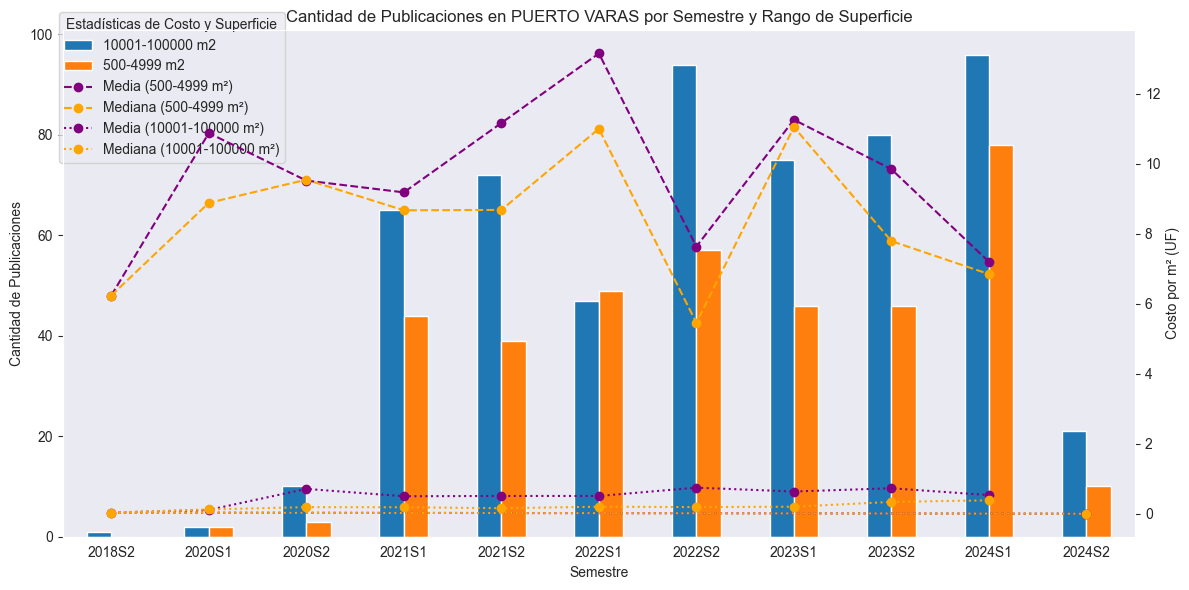

In [195]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar los datos para la comuna de ALGARROBO y los rangos de superficie especificados
data_puerto_varas = data_2019[(data_2019['comuna_match'] == 'PUERTO VARAS') & 
                              (data_2019['rango_superficie'].isin(['500-4999 m2', '10001-100000 m2']))]

# Agrupar por semestre y rango de superficie y contar la cantidad de terrenos en cada categoría
conteo_oferta = data_puerto_varas.groupby(['semestre', 'rango_superficie']).size().unstack()

# Crear el gráfico de barras
fig, ax1 = plt.subplots(figsize=(12, 6))
conteo_oferta.plot(kind='bar', ax=ax1)

# Personalizar el gráfico
plt.title('Cantidad de Publicaciones en PUERTO VARAS por Semestre y Rango de Superficie')
ax1.set_xlabel('Semestre')
ax1.set_ylabel('Cantidad de Publicaciones')
ax1.set_xticks(range(len(conteo_oferta)))
ax1.set_xticklabels(conteo_oferta.index, rotation=0)
ax1.grid(False)

# Crear un segundo eje y calcular las estadísticas por rango de superficie
ax2 = ax1.twinx()

# Calcular las estadísticas para cada rango de superficie
rango_500_4999 = data_puerto_varas[data_puerto_varas['rango_superficie'] == '500-4999 m2'].groupby('semestre')['costo_m2_uf'].agg(['min', 'max', 'mean', 'median'])
rango_10001_100000 = data_puerto_varas[data_puerto_varas['rango_superficie'] == '10001-100000 m2'].groupby('semestre')['costo_m2_uf'].agg(['min', 'max', 'mean', 'median'])

# Graficar las líneas de tendencia por separado para cada rango de superficie
#ax2.plot(rango_500_4999.index, rango_500_4999['min'], label='Min (500-4999 m²)', marker='o', color='green', linestyle='--')
#ax2.plot(rango_500_4999.index, rango_500_4999['max'], label='Max (500-4999 m²)', marker='o', color='red', linestyle='--')
ax2.plot(rango_500_4999.index, rango_500_4999['mean'], label='Media (500-4999 m²)', marker='o', color='purple', linestyle='--')
ax2.plot(rango_500_4999.index, rango_500_4999['median'], label='Mediana (500-4999 m²)', marker='o', color='orange', linestyle='--')

#ax2.plot(rango_10001_100000.index, rango_10001_100000['min'], label='Min (10001-100000 m²)', marker='o', color='green', linestyle=':')
#ax2.plot(rango_10001_100000.index, rango_10001_100000['max'], label='Max (10001-100000 m²)', marker='o', color='red', linestyle=':')
ax2.plot(rango_10001_100000.index, rango_10001_100000['mean'], label='Media (10001-100000 m²)', marker='o', color='purple', linestyle=':')
ax2.plot(rango_10001_100000.index, rango_10001_100000['median'], label='Mediana (10001-100000 m²)', marker='o', color='orange', linestyle=':')

# Etiquetas y ajustes del segundo eje
ax2.set_ylabel('Costo por m² (UF)')
ax2.grid(False)

# Combinar las leyendas en una sola y ajustar su posición más a la derecha
lineas, etiquetas = ax1.get_legend_handles_labels()
lineas2, etiquetas2 = ax2.get_legend_handles_labels()
ax1.legend(lineas + lineas2, etiquetas + etiquetas2, loc='upper left', bbox_to_anchor=(-0.01, 1.05), title='Estadísticas de Costo y Superficie')

# Ajustar diseño
plt.tight_layout()
plt.show()

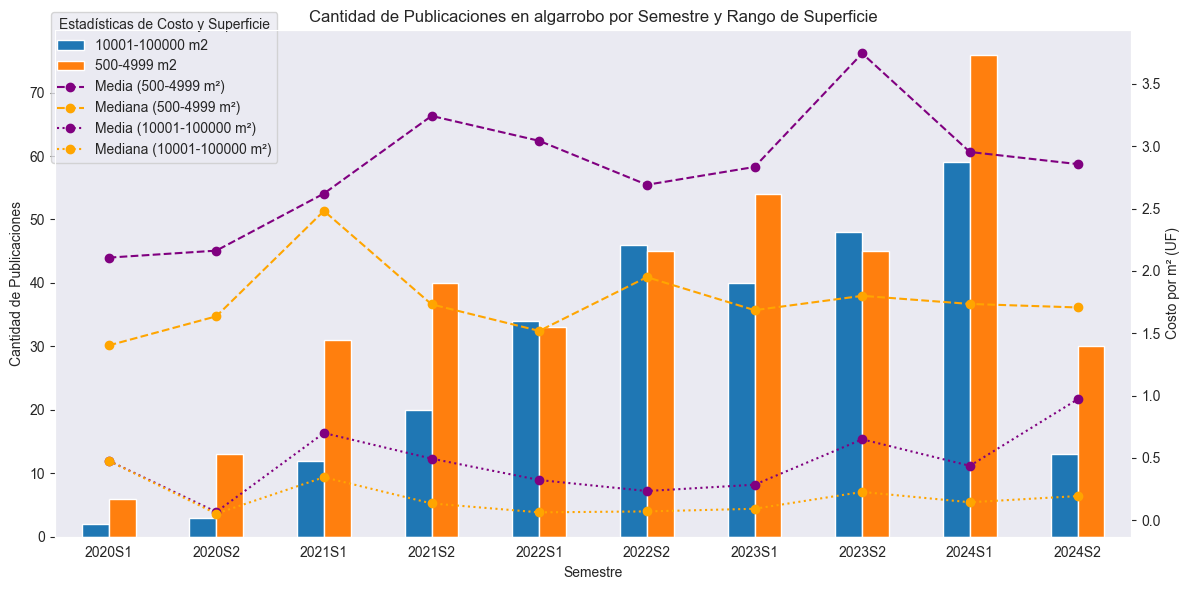

In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar los datos para la comuna de ALGARROBO y los rangos de superficie especificados
data_algarrobo = data_2019[(data_2019['comuna_match'] == 'ALGARROBO') & 
                              (data_2019['rango_superficie'].isin(['500-4999 m2', '10001-100000 m2']))]

# Agrupar por semestre y rango de superficie y contar la cantidad de terrenos en cada categoría
conteo_oferta = data_algarrobo.groupby(['semestre', 'rango_superficie']).size().unstack()

# Crear el gráfico de barras
fig, ax1 = plt.subplots(figsize=(12, 6))
conteo_oferta.plot(kind='bar', ax=ax1)

# Personalizar el gráfico
plt.title('Cantidad de Publicaciones en algarrobo por Semestre y Rango de Superficie')
ax1.set_xlabel('Semestre')
ax1.set_ylabel('Cantidad de Publicaciones')
ax1.set_xticks(range(len(conteo_oferta)))
ax1.set_xticklabels(conteo_oferta.index, rotation=0)
ax1.grid(False)

# Crear un segundo eje y calcular las estadísticas por rango de superficie
ax2 = ax1.twinx()

# Calcular las estadísticas para cada rango de superficie
rango_500_4999 = data_algarrobo[data_algarrobo['rango_superficie'] == '500-4999 m2'].groupby('semestre')['costo_m2_uf'].agg(['min', 'max', 'mean', 'median'])
rango_10001_100000 = data_algarrobo[data_algarrobo['rango_superficie'] == '10001-100000 m2'].groupby('semestre')['costo_m2_uf'].agg(['min', 'max', 'mean', 'median'])

# Graficar las líneas de tendencia por separado para cada rango de superficie
#ax2.plot(rango_500_4999.index, rango_500_4999['min'], label='Min (500-4999 m²)', marker='o', color='green', linestyle='--')
#ax2.plot(rango_500_4999.index, rango_500_4999['max'], label='Max (500-4999 m²)', marker='o', color='red', linestyle='--')
ax2.plot(rango_500_4999.index, rango_500_4999['mean'], label='Media (500-4999 m²)', marker='o', color='purple', linestyle='--')
ax2.plot(rango_500_4999.index, rango_500_4999['median'], label='Mediana (500-4999 m²)', marker='o', color='orange', linestyle='--')

#ax2.plot(rango_10001_100000.index, rango_10001_100000['min'], label='Min (10001-100000 m²)', marker='o', color='green', linestyle=':')
#ax2.plot(rango_10001_100000.index, rango_10001_100000['max'], label='Max (10001-100000 m²)', marker='o', color='red', linestyle=':')
ax2.plot(rango_10001_100000.index, rango_10001_100000['mean'], label='Media (10001-100000 m²)', marker='o', color='purple', linestyle=':')
ax2.plot(rango_10001_100000.index, rango_10001_100000['median'], label='Mediana (10001-100000 m²)', marker='o', color='orange', linestyle=':')

# Etiquetas y ajustes del segundo eje
ax2.set_ylabel('Costo por m² (UF)')
ax2.grid(False)

# Combinar las leyendas en una sola y ajustar su posición más a la derecha
lineas, etiquetas = ax1.get_legend_handles_labels()
lineas2, etiquetas2 = ax2.get_legend_handles_labels()
ax1.legend(lineas + lineas2, etiquetas + etiquetas2, loc='upper left', bbox_to_anchor=(-0.01, 1.05), title='Estadísticas de Costo y Superficie')

# Ajustar diseño
plt.tight_layout()
plt.show()

In [13]:
data_2021.to_csv("data recuperada/data_2021.csv", index=False)

KeyboardInterrupt: 

In [14]:
import pandas as pd
data_2021 = pd.read_csv("data recuperada/data_2021.csv")

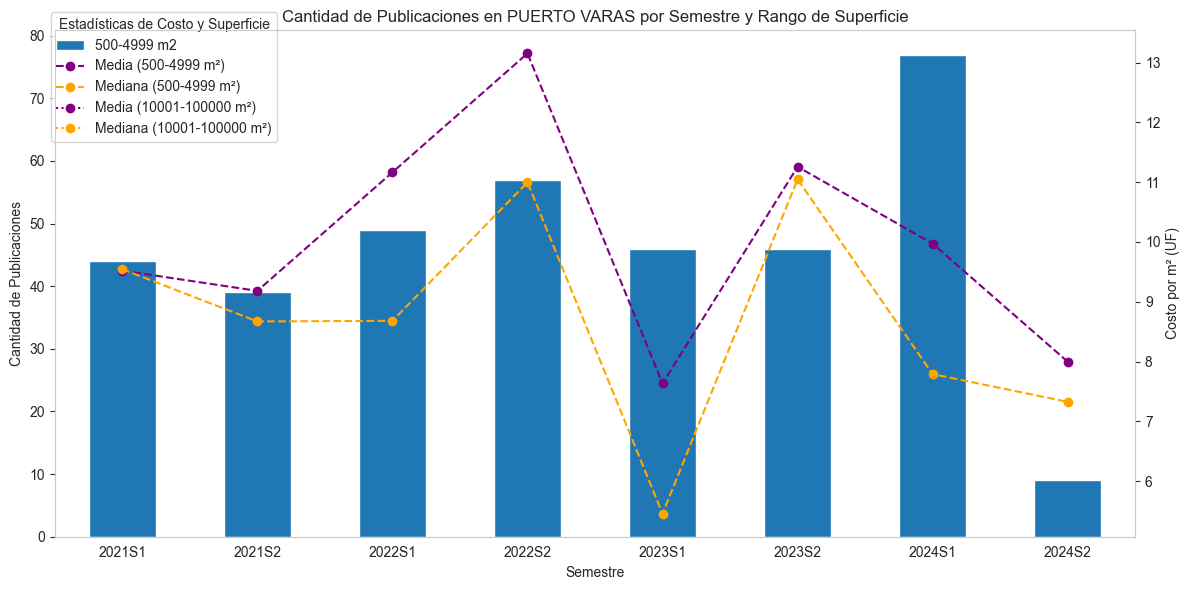

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar los datos para la comuna de ALGARROBO y los rangos de superficie especificados
data_puerto_varas = data_2021[(data_2021['comuna_match'] == 'PUERTO VARAS') & 
                              (data_2021['rango_superficie'].isin(['500-4999 m2', '10001-100000 m2']))]

# Agrupar por semestre y rango de superficie y contar la cantidad de terrenos en cada categoría
conteo_oferta = data_puerto_varas.groupby(['semestre', 'rango_superficie']).size().unstack()

# Crear el gráfico de barras
fig, ax1 = plt.subplots(figsize=(12, 6))
conteo_oferta.plot(kind='bar', ax=ax1)

# Personalizar el gráfico
plt.title('Cantidad de Publicaciones en PUERTO VARAS por Semestre y Rango de Superficie')
ax1.set_xlabel('Semestre')
ax1.set_ylabel('Cantidad de Publicaciones')
ax1.set_xticks(range(len(conteo_oferta)))
ax1.set_xticklabels(conteo_oferta.index, rotation=0)
ax1.grid(False)

# Crear un segundo eje y calcular las estadísticas por rango de superficie
ax2 = ax1.twinx()

# Calcular las estadísticas para cada rango de superficie
rango_500_4999 = data_puerto_varas[data_puerto_varas['rango_superficie'] == '500-4999 m2'].groupby('semestre')['costo_m2_uf'].agg(['min', 'max', 'mean', 'median'])
rango_10001_100000 = data_puerto_varas[data_puerto_varas['rango_superficie'] == '10001-100000 m2'].groupby('semestre')['costo_m2_uf'].agg(['min', 'max', 'mean', 'median'])

# Graficar las líneas de tendencia por separado para cada rango de superficie
#ax2.plot(rango_500_4999.index, rango_500_4999['min'], label='Min (500-4999 m²)', marker='o', color='green', linestyle='--')
#ax2.plot(rango_500_4999.index, rango_500_4999['max'], label='Max (500-4999 m²)', marker='o', color='red', linestyle='--')
ax2.plot(rango_500_4999.index, rango_500_4999['mean'], label='Media (500-4999 m²)', marker='o', color='purple', linestyle='--')
ax2.plot(rango_500_4999.index, rango_500_4999['median'], label='Mediana (500-4999 m²)', marker='o', color='orange', linestyle='--')

#ax2.plot(rango_10001_100000.index, rango_10001_100000['min'], label='Min (10001-100000 m²)', marker='o', color='green', linestyle=':')
#ax2.plot(rango_10001_100000.index, rango_10001_100000['max'], label='Max (10001-100000 m²)', marker='o', color='red', linestyle=':')
ax2.plot(rango_10001_100000.index, rango_10001_100000['mean'], label='Media (10001-100000 m²)', marker='o', color='purple', linestyle=':')
ax2.plot(rango_10001_100000.index, rango_10001_100000['median'], label='Mediana (10001-100000 m²)', marker='o', color='orange', linestyle=':')

# Etiquetas y ajustes del segundo eje
ax2.set_ylabel('Costo por m² (UF)')
ax2.grid(False)

# Combinar las leyendas en una sola y ajustar su posición más a la derecha
lineas, etiquetas = ax1.get_legend_handles_labels()
lineas2, etiquetas2 = ax2.get_legend_handles_labels()
ax1.legend(lineas + lineas2, etiquetas + etiquetas2, loc='upper left', bbox_to_anchor=(-0.01, 1.05), title='Estadísticas de Costo y Superficie')

# Ajustar diseño
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtrar los datos para la comuna de ALGARROBO y los rangos de superficie especificados
data_algarrobo = data_2021[(data_2021['comuna_match'] == 'ALGARROBO') & 
                           (data_2021['rango_superficie'].isin(['500-4999 m2', '10001-100000 m2']))]

# Agrupar por semestre y rango de superficie y contar la cantidad de terrenos en cada categoría
conteo_oferta = data_algarrobo.groupby(['semestre', 'rango_superficie']).size().unstack()

# Crear el gráfico de barras
fig, ax1 = plt.subplots(figsize=(12, 6))

# Graficar las barras con los datos
conteo_oferta.plot(kind='bar', ax=ax1, zorder=5, width=0.7)

# Personalizar el gráfico de barras
ax1.set_title('Cantidad de Publicaciones en ALGARROBO por Semestre y Rango de Superficie')
ax1.set_xlabel('Semestre')
ax1.set_ylabel('Cantidad de Publicaciones')
ax1.set_xticks(range(len(conteo_oferta)))
ax1.set_xticklabels(conteo_oferta.index, rotation=0)
ax1.grid(True, axis='y', linestyle='--', zorder=0)  # Solo la cuadrícula en las barras
ax1.legend(title='Rango de Superficie')

# Calcular las estadísticas (media, mediana, máximo, mínimo) por semestre para el costo_m2_uf
stats = data_algarrobo.groupby('semestre')['costo_m2_uf'].agg(['min', 'max', 'mean', 'median'])

# Crear el segundo eje y graficar las líneas de tendencia de costo_m2_uf
ax2 = ax1.twinx()
ax2.plot(stats.index, stats['min'], color='green', marker='o', label='Min', linestyle='--', zorder=3)
ax2.plot(stats.index, stats['max'], color='red', marker='o', label='Max', linestyle='--', zorder=3)
ax2.plot(stats.index, stats['mean'], color='magenta', marker='o', label='Media', linestyle='-', zorder=3)
ax2.plot(stats.index, stats['median'], color='orange', marker='o', label='Mediana', linestyle='-', zorder=3)

# Personalizar el gráfico de líneas
ax2.set_ylabel('Costo por m² (UF)')
ax2.legend(loc='upper right', title='Estadísticas de Costo')

# Desactivar la cuadrícula del eje secundario (ax2) para que no interfiera con las barras
ax2.grid(False)

# Ajustar el diseño del gráfico
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar los datos para la comuna de ALGARROBO y los rangos de superficie especificados
data_puerto_varas = data_2021[(data_2021['comuna_match'] == 'ALGARROBO') & 
                              (data_2021['rango_superficie'].isin(['500-4999 m2', '10001-100000 m2']))]

# Agrupar por semestre y rango de superficie y contar la cantidad de terrenos en cada categoría
conteo_oferta = data_puerto_varas.groupby(['semestre', 'rango_superficie']).size().unstack()

# Crear el gráfico de barras
fig, ax1 = plt.subplots(figsize=(12, 6))
conteo_oferta.plot(kind='bar', ax=ax1)

# Personalizar el gráfico
plt.title('Cantidad de Publicaciones en ALGARROBO por Semestre y Rango de Superficie')
ax1.set_xlabel('Semestre')
ax1.set_ylabel('Cantidad de Publicaciones')
ax1.set_xticks(range(len(conteo_oferta)))
ax1.set_xticklabels(conteo_oferta.index, rotation=0)
ax1.grid(False)

# Crear un segundo eje y calcular las estadísticas por rango de superficie
ax2 = ax1.twinx()

# Calcular las estadísticas para cada rango de superficie
rango_500_4999 = data_puerto_varas[data_puerto_varas['rango_superficie'] == '500-4999 m2'].groupby('semestre')['costo_m2_uf'].agg(['min', 'max', 'mean', 'median'])
rango_10001_100000 = data_puerto_varas[data_puerto_varas['rango_superficie'] == '10001-100000 m2'].groupby('semestre')['costo_m2_uf'].agg(['min', 'max', 'mean', 'median'])

# Graficar las líneas de tendencia por separado para cada rango de superficie
#ax2.plot(rango_500_4999.index, rango_500_4999['min'], label='Min (500-4999 m²)', marker='o', color='green', linestyle='--')
#ax2.plot(rango_500_4999.index, rango_500_4999['max'], label='Max (500-4999 m²)', marker='o', color='red', linestyle='--')
ax2.plot(rango_500_4999.index, rango_500_4999['mean'], label='Media (500-4999 m²)', marker='o', color='purple', linestyle='--')
ax2.plot(rango_500_4999.index, rango_500_4999['median'], label='Mediana (500-4999 m²)', marker='o', color='orange', linestyle='--')

#ax2.plot(rango_10001_100000.index, rango_10001_100000['min'], label='Min (10001-100000 m²)', marker='o', color='green', linestyle=':')
#ax2.plot(rango_10001_100000.index, rango_10001_100000['max'], label='Max (10001-100000 m²)', marker='o', color='red', linestyle=':')
ax2.plot(rango_10001_100000.index, rango_10001_100000['mean'], label='Media (10001-100000 m²)', marker='o', color='purple', linestyle=':')
ax2.plot(rango_10001_100000.index, rango_10001_100000['median'], label='Mediana (10001-100000 m²)', marker='o', color='orange', linestyle=':')

# Etiquetas y ajustes del segundo eje
ax2.set_ylabel('Costo por m² (UF)')
ax2.grid(False)

# Combinar las leyendas en una sola y ajustar su posición más a la derecha
lineas, etiquetas = ax1.get_legend_handles_labels()
lineas2, etiquetas2 = ax2.get_legend_handles_labels()
ax1.legend(lineas + lineas2, etiquetas + etiquetas2, loc='upper left', bbox_to_anchor=(0, 1.0), title='Estadísticas de Costo y Superficie')

# Ajustar diseño
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar los datos para la comuna de ALGARROBO y los rangos de superficie especificados
data_puerto_varas = data_2021[(data_2021['comuna_match'] == 'MACHALI') & 
                              (data_2021['rango_superficie'].isin(['500-4999 m2', '10001-100000 m2']))]

# Agrupar por semestre y rango de superficie y contar la cantidad de terrenos en cada categoría
conteo_oferta = data_puerto_varas.groupby(['semestre', 'rango_superficie']).size().unstack()

# Crear el gráfico de barras
fig, ax1 = plt.subplots(figsize=(12, 6))
conteo_oferta.plot(kind='bar', ax=ax1)

# Personalizar el gráfico
plt.title('Cantidad de Publicaciones en MACHALI por Semestre y Rango de Superficie')
ax1.set_xlabel('Semestre')
ax1.set_ylabel('Cantidad de Publicaciones')
ax1.set_xticks(range(len(conteo_oferta)))
ax1.set_xticklabels(conteo_oferta.index, rotation=0)
ax1.grid(False)

# Crear un segundo eje y calcular las estadísticas por rango de superficie
ax2 = ax1.twinx()

# Calcular las estadísticas para cada rango de superficie
rango_500_4999 = data_puerto_varas[data_puerto_varas['rango_superficie'] == '500-4999 m2'].groupby('semestre')['costo_m2_uf'].agg(['min', 'max', 'mean', 'median'])
rango_10001_100000 = data_puerto_varas[data_puerto_varas['rango_superficie'] == '10001-100000 m2'].groupby('semestre')['costo_m2_uf'].agg(['min', 'max', 'mean', 'median'])

# Graficar las líneas de tendencia por separado para cada rango de superficie
#ax2.plot(rango_500_4999.index, rango_500_4999['min'], label='Min (500-4999 m²)', marker='o', color='green', linestyle='--')
#ax2.plot(rango_500_4999.index, rango_500_4999['max'], label='Max (500-4999 m²)', marker='o', color='red', linestyle='--')
ax2.plot(rango_500_4999.index, rango_500_4999['mean'], label='Media (500-4999 m²)', marker='o', color='purple', linestyle='--')
ax2.plot(rango_500_4999.index, rango_500_4999['median'], label='Mediana (500-4999 m²)', marker='o', color='orange', linestyle='--')

#ax2.plot(rango_10001_100000.index, rango_10001_100000['min'], label='Min (10001-100000 m²)', marker='o', color='green', linestyle=':')
#ax2.plot(rango_10001_100000.index, rango_10001_100000['max'], label='Max (10001-100000 m²)', marker='o', color='red', linestyle=':')
ax2.plot(rango_10001_100000.index, rango_10001_100000['mean'], label='Media (10001-100000 m²)', marker='o', color='purple', linestyle=':')
ax2.plot(rango_10001_100000.index, rango_10001_100000['median'], label='Mediana (10001-100000 m²)', marker='o', color='orange', linestyle=':')

# Etiquetas y ajustes del segundo eje
ax2.set_ylabel('Costo por m² (UF)')
ax2.grid(False)

# Combinar las leyendas en una sola y ajustar su posición más a la derecha
lineas, etiquetas = ax1.get_legend_handles_labels()
lineas2, etiquetas2 = ax2.get_legend_handles_labels()
ax1.legend(lineas + lineas2, etiquetas + etiquetas2, loc='upper left', bbox_to_anchor=(0, 1), title='Estadísticas de Costo y Superficie')

# Ajustar diseño
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Filtrar los datos del rango de superficie de 10001 a 100000 m2 para la comuna de Machalí
data_filtrada = data_2021[(data_2021['rango_superficie'] == '10001-100000 m2') & 
                          (data_2021['comuna_match'] == 'MACHALI') & 
                          (data_2021['semestre'] != '2024S2')]  # Excluir 2024S2

# Agrupar por semestre y calcular la media del costo por m²
data_train = data_filtrada.groupby('semestre')['costo_m2_uf'].mean().reset_index()

# Filtrar los datos de 2024S2 para validación posterior
data_2024S2 = data_2021[(data_2021['rango_superficie'] == '10001-100000 m2') & 
                        (data_2021['comuna_match'] == 'MACHALI') & 
                        (data_2021['semestre'] == '2024S2')]
data_val = data_2024S2.groupby('semestre')['costo_m2_uf'].mean().reset_index()

# Mostrar los resultados
print("Datos de entrenamiento (hasta 2024S1):")
print(data_train)

print("\nDatos de validación (2024S2):")
print(data_val)



In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Convertir los semestres a valores numéricos para el modelo
data_train['semestre_num'] = np.arange(len(data_train))

# Crear el modelo de regresión lineal
X_train = data_train[['semestre_num']]
y_train = data_train['costo_m2_uf']

modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Predecir para el semestre 2024S2 (que será el siguiente valor numérico)
semestre_2024S2 = np.array([[len(data_train)]])  # El semestre siguiente en la secuencia
prediccion_2024S2 = modelo.predict(semestre_2024S2)

print(f"Predicción para 2024S2: {prediccion_2024S2[0]:.2f} UF/m²")


In [ ]:
# Obtener el valor real de 2024S2
valor_real_2024S2 = data_val['costo_m2_uf'].values[0]

# Calcular el error
error = abs(prediccion_2024S2[0] - valor_real_2024S2)
print(f"Valor real de 2024S2: {valor_real_2024S2:.2f} UF/m²")
print(f"Error de predicción: {error:.2f} UF/m²")


In [ ]:
import matplotlib.pyplot as plt

# Gráfico de los datos reales y la predicción
plt.figure(figsize=(10, 6))

# Graficar los datos históricos
plt.plot(data_train['semestre'], data_train['costo_m2_uf'], label='Datos Históricos', marker='o')

# Añadir la predicción de 2024S2
plt.scatter('2024S2', prediccion_2024S2, color='red', label=f'Predicción 2024S2 ({prediccion_2024S2[0]:.2f} UF/m²)', zorder=5)
plt.scatter('2024S2', valor_real_2024S2, color='green', label=f'Valor Real 2024S2 ({valor_real_2024S2:.2f} UF/m²)', zorder=5)

# Personalizar el gráfico
plt.title('Predicción del Costo por m² (10001-100000 m²) para 2024S2')
plt.xlabel('Semestre')
plt.ylabel('Costo por m² (UF)')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Filtrar los datos del rango de superficie de 10001 a 100000 m2 para la comuna de Machalí
data_filtrada = data_2021[(data_2021['rango_superficie'] == '10001-100000 m2') & 
                          (data_2021['comuna_match'] == 'MACHALI') & 
                          (data_2021['semestre'] != '2024S2')]  # Excluir 2024S2

# Crear un diccionario que asigne un número ordinal a cada semestre
semestre_ordinal = {
    '2021S1': 1,
    '2021S2': 2,
    '2022S1': 3,
    '2022S2': 4,
    '2023S1': 5,
    '2023S2': 6,
    '2024S1': 7
}

# Aplicar la conversión a valores ordinales
data_filtrada['semestre_ordinal'] = data_filtrada['semestre'].map(semestre_ordinal)

# Dividir los datos en características (X) y etiquetas (y)
X_train = data_filtrada[['semestre_ordinal']]  # Usamos el semestre ordinal como característica
y_train = data_filtrada['costo_m2_uf']  # El costo por m² en UF es la etiqueta

# Crear el modelo de regresión lineal
modelo = LinearRegression()

# Entrenar el modelo con los datos de entrenamiento
modelo.fit(X_train, y_train)

# Filtrar los datos de 2024S2 para validación
data_2024S2 = data_2021[(data_2021['rango_superficie'] == '10001-100000 m2') & 
                        (data_2021['comuna_match'] == 'MACHALI') & 
                        (data_2021['semestre'] == '2024S2')]

# Asignar el valor ordinal para 2024S2
data_2024S2['semestre_ordinal'] = 8  # Para 2024S2, asignamos 8

# Realizar la predicción para los datos de 2024S2
X_val = data_2024S2[['semestre_ordinal']]
y_pred = modelo.predict(X_val)

# Mostrar la predicción y el valor real
valor_real_2024S2 = data_2024S2['costo_m2_uf'].mean()  # Valor real promedio de 2024S2
print(f"Predicción del costo por m² en UF para 2024S2: {y_pred.mean():.2f} UF/m²")
print(f"Valor real del costo por m² en UF para 2024S2: {valor_real_2024S2:.2f} UF/m²")



In [ ]:
print(data_2021.columns)

In [ ]:

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Paso 1: Filtrar los datos para los rangos de superficie 500-4999 m² y 10001-100000 m²
data_filtrada = data_2021[data_2021['rango_superficie'].isin(['500-4999 m2', '10001-100000 m2'])]

# Paso 2: Agrupar por comuna y calcular la mediana para cada característica relevante
data_agrupada = data_filtrada.groupby('comuna_match').agg({
    'total_o_terreno': 'median',  # Usar la mediana
    'precio_uf': 'median',  # Usar la mediana
    'costo_m2_uf': 'median'  # Usar la mediana
}).dropna().reset_index()

# Paso 3: Normalizar las características
scaler = StandardScaler()
data_normalizada = pd.DataFrame(scaler.fit_transform(data_agrupada[['total_o_terreno', 'precio_uf', 'costo_m2_uf']]),
                                columns=['total_o_terreno', 'precio_uf', 'costo_m2_uf'])

# Paso 4: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_normalizada)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

# Paso 5: Aplicar K-means con el número óptimo de clusters
kmeans = KMeans(n_clusters=4, random_state=42)  # Cambia el número de clusters según el resultado del método del codo
data_agrupada['cluster'] = kmeans.fit_predict(data_normalizada)

# Mostrar los resultados
print(data_agrupada.head())

# Paso 6: Visualización de los clusters con etiquetas para PUERTO VARAS, ALGARROBO, y MACHALI
plt.figure(figsize=(10, 6))
plt.scatter(data_normalizada['total_o_terreno'], data_normalizada['costo_m2_uf'], c=data_agrupada['cluster'],
            cmap='viridis', label='Clusters')

# Comunas a resaltar
comunas_destacadas = ['PUERTO VARAS', 'ALGARROBO', 'MACHALI']

# Añadir puntos rojos para las comunas seleccionadas
for i, row in data_agrupada.iterrows():
    if row['comuna_match'] in comunas_destacadas:
        plt.scatter(data_normalizada.iloc[i]['total_o_terreno'],
                    data_normalizada.iloc[i]['costo_m2_uf'],
                    color='red', s=100,
                    label=row['comuna_match'] if row['comuna_match'] not in plt.gca().get_legend_handles_labels()[
                        1] else "")

# Añadir etiquetas para las comunas seleccionadas
for i, row in data_agrupada.iterrows():
    if row['comuna_match'] in comunas_destacadas:
        plt.text(data_normalizada.iloc[i]['total_o_terreno'],
                 data_normalizada.iloc[i]['costo_m2_uf'],
                 row['comuna_match'], fontsize=12, color='black')

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en Características de Terreno')
plt.xlabel('Total Terreno (normalizado)')
plt.ylabel('Costo por m² (UF) (normalizado)')
plt.legend(loc='best')
plt.grid(True)

plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Paso 1: Asegurarse de que la data_filtrada tiene los clusters asignados
data_filtrada = data_2021[data_2021['rango_superficie'].isin(['500-4999 m2', '10001-100000 m2'])]

# Añadir la columna de clusters al data_filtrada
data_filtrada = data_filtrada.merge(data_agrupada[['comuna_match', 'cluster']], on='comuna_match')

# Paso 2: Agrupar por semestre y cluster, y calcular la media del costo por m²
data_tendencia = data_filtrada.groupby(['semestre', 'cluster'])['costo_m2_uf'].mean().reset_index()

# Paso 3: Graficar la tendencia del costo por m² por cluster
plt.figure(figsize=(10, 6))

for cluster in data_tendencia['cluster'].unique():
    cluster_data = data_tendencia[data_tendencia['cluster'] == cluster]
    plt.plot(cluster_data['semestre'], cluster_data['costo_m2_uf'], marker='o', label=f'Cluster {cluster}')

# Personalizar el gráfico
plt.title('Tendencia del costo por m² (UF) por Semestre y Cluster')
plt.xlabel('Semestre')
plt.ylabel('Costo por m² (UF)')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Definir los rangos de superficie de interés, incluyendo 100-499 m²
rangos_superficie = ['100-499 m2', '500-4999 m2', '5000-10000 m2', '10001-100000 m2', '>100000 m2']

# Paso 1: Calcular el total de datos por comuna
data_comuna_total = data_2021.groupby('comuna_match').size().reset_index(name='Total de Datos')

# Paso 2: Calcular el porcentaje y total de datos por rango de superficie en cada comuna
for rango in rangos_superficie:
    # Filtrar los datos para el rango de superficie actual
    data_rango = data_2021[data_2021['rango_superficie'] == rango]

    # Calcular el total de datos en ese rango por comuna
    data_rango_total = data_rango.groupby('comuna_match').size().reset_index(name=f'Total {rango}')

    # Calcular el porcentaje de datos en ese rango sobre el total de la comuna
    data_comuna_total = data_comuna_total.merge(data_rango_total, on='comuna_match', how='left')
    data_comuna_total[f'% {rango}'] = (data_comuna_total[f'Total {rango}'] / data_comuna_total['Total de Datos']) * 100

# Paso 3: Calcular las estadísticas (mediana, media, desviación estándar, IQR, min, max) de costo_m2_uf por rango de superficie en cada comuna
for rango in rangos_superficie:
    # Filtrar los datos para el rango de superficie actual
    data_rango_estadisticas = data_2021[data_2021['rango_superficie'] == rango]

    # Calcular la mediana, media, desviación estándar, IQR (Q3 - Q1), min, max
    data_estadisticas = data_rango_estadisticas.groupby('comuna_match').agg(
        mediana=(f'costo_m2_uf', 'median'),
        media=(f'costo_m2_uf', 'mean'),
        desviacion_std=(f'costo_m2_uf', 'std'),
        Q1=(f'costo_m2_uf', lambda x: x.quantile(0.25)),
        Q3=(f'costo_m2_uf', lambda x: x.quantile(0.75)),
        min_costo=(f'costo_m2_uf', 'min'),
        max_costo=(f'costo_m2_uf', 'max')
    ).reset_index()

    # Calcular el IQR (Q3 - Q1)
    data_estadisticas[f'IQR costo_m2_uf {rango}'] = data_estadisticas['Q3'] - data_estadisticas['Q1']

    # Eliminar las columnas Q1 y Q3, ya que solo se necesitaban para el cálculo del IQR
    data_estadisticas.drop(columns=['Q1', 'Q3'], inplace=True)

    # Renombrar las columnas para cada rango de superficie
    data_estadisticas.rename(columns={
        'mediana': f'Mediana costo_m2_uf {rango}',
        'media': f'Media costo_m2_uf {rango}',
        'desviacion_std': f'Desviación costo_m2_uf {rango}',
        'min_costo': f'Mínimo costo_m2_uf {rango}',
        'max_costo': f'Máximo costo_m2_uf {rango}'
    }, inplace=True)

    # Combinar con la tabla principal
    data_comuna_total = data_comuna_total.merge(data_estadisticas, on='comuna_match', how='left')

# Rellenar NaN con 0 para valores que no tienen datos
data_comuna_total.fillna(0, inplace=True)

# Mostrar la tabla
print(data_comuna_total.head())

# Guardar en un archivo CSV si lo deseas
data_comuna_total.to_csv('data recuperada/estadisticos_por_comuna_y_rango.csv', index=False)



In [ ]:
# Suponiendo que tienes una columna de precios por comuna en tu dataset:
precios_comuna = data_2021['costo_m2_uf']

# Ajustar una distribución Gamma a los datos
alpha, loc, beta = stats.gamma.fit(precios_comuna, floc=0)

# Mostrar los parámetros estimados
print(f"Parámetro alpha (forma): {alpha}")
print(f"Parámetro beta (escala): {beta}")

# Limitar el rango de los valores de x para mejorar la visualización
x = np.linspace(np.percentile(precios_comuna, 1), np.percentile(precios_comuna, 99), 100)

# Graficar la distribución ajustada a los datos
plt.hist(precios_comuna, bins=30, density=True, alpha=0.6, color='g', label='Datos originales')

# Calcular la función de densidad ajustada (gamma)
pdf_gamma = stats.gamma.pdf(x, a=alpha, scale=beta)
plt.plot(x, pdf_gamma, 'r-', label='Distribución Gamma ajustada')

# Ajustar los ejes para mejorar la visualización
plt.xlim([np.percentile(precios_comuna, 5), np.percentile(precios_comuna, 95)])

# Mostrar el gráfico
plt.title('Ajuste de Distribución Gamma a los Precios por Comuna (ajustado)')
plt.xlabel('Costo m2 UF')
plt.ylabel('Densidad')
plt.legend()
plt.grid(True)
plt.show()


## PUNTO DE CONTROL

In [44]:
import pandas as pd
# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

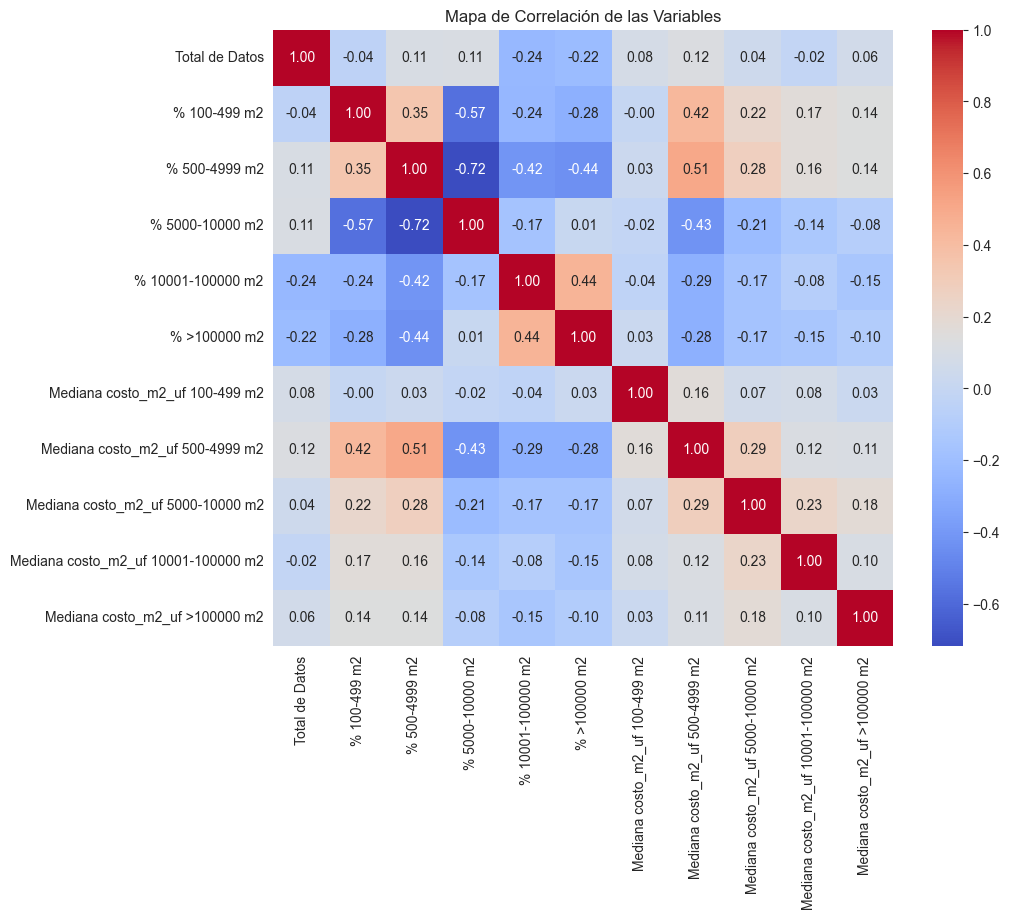

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than ava

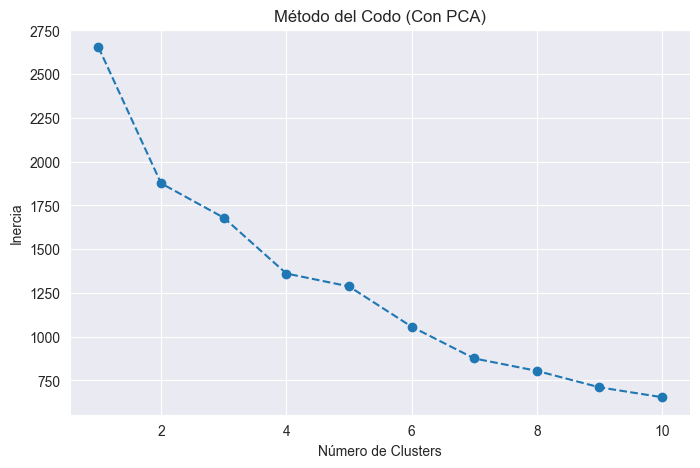

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


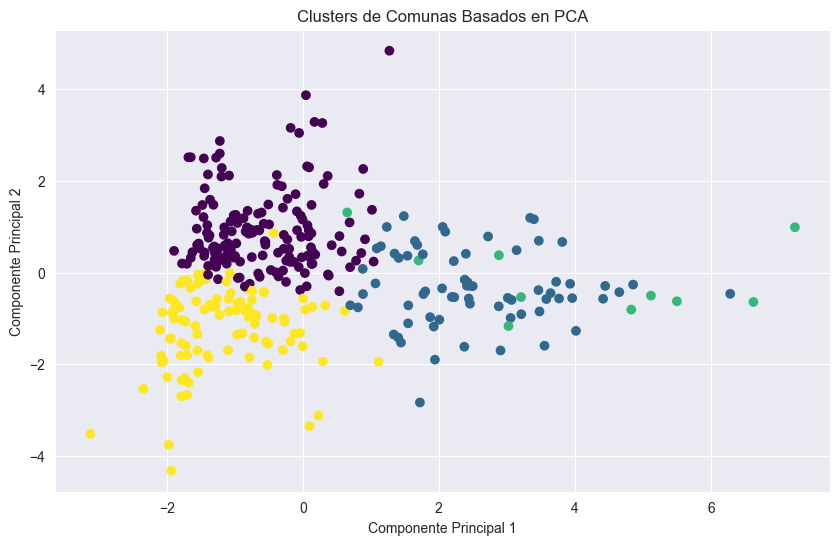

      comuna_match  Total de Datos  Total 100-499 m2  % 100-499 m2  \
0        ALGARROBO            1602             188.0     11.735331   
1            ALHUE              32               1.0      3.125000   
2      ALTO BIOBIO              11               2.0     18.181818   
3  ALTO DEL CARMEN              22               1.0      4.545455   
4    ALTO HOSPICIO             249              56.0     22.489960   

   Total 500-4999 m2  % 500-4999 m2  Total 5000-10000 m2  % 5000-10000 m2  \
0              350.0      21.847690                754.0        47.066167   
1                4.0      12.500000                 10.0        31.250000   
2                2.0      18.181818                  5.0        45.454545   
3                6.0      27.272727                  8.0        36.363636   
4               39.0      15.662651                110.0        44.176707   

   Total 10001-100000 m2  % 10001-100000 m2  ...  \
0                  271.0          16.916355  ...   
1           

In [45]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables relevantes para el clustering
variables_clustering = [
    'Total de Datos',
    '% 100-499 m2', '% 500-4999 m2', '% 5000-10000 m2', '% 10001-100000 m2', '% >100000 m2',
    'Mediana costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
    'Mediana costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar los datos usando StandardScaler (Estandarización)
scaler = StandardScaler()
X_normalizado = scaler.fit_transform(X)

# Paso 4: Detectar colinealidad con un heatmap de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(X_normalizado, columns=variables_clustering).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Correlación de las Variables')
plt.show()

# Paso 5: Aplicar PCA para reducir la dimensionalidad (eliminar colinealidad)
pca = PCA(n_components=5)  # Reducir a 5 componentes principales
X_pca = pca.fit_transform(X_normalizado)

# Paso 6: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo (Con PCA)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

# Paso 7: Aplicar K-means con el número óptimo de clusters
kmeans = KMeans(n_clusters=4, random_state=42)  # Cambia el número de clusters según el resultado del método del codo
data_estadisticos['cluster'] = kmeans.fit_predict(X_pca)

# Paso 8: Visualización de los clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_estadisticos['cluster'], cmap='viridis')
plt.title('Clusters de Comunas Basados en PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()

# Paso 9: Guardar los resultados de clustering
data_estadisticos.to_csv('data recuperada/estadisticos_por_comuna_con_clusters.csv', index=False)

# Mostrar las primeras filas con los clusters
print(data_estadisticos.head())



Varianzas explicadas por cada componente principal:
PC1: 0.2767
PC2: 0.1534
PC3: 0.1100
PC4: 0.1040
PC5: 0.0912

Cargas de los Componentes Principales:
     Total de Datos  % 500-4999 m2  % 5000-10000 m2  % 10001-100000 m2  \
PC1        0.143460       0.518726        -0.338474          -0.323838   
PC2        0.452210      -0.162770         0.594465          -0.501532   
PC3       -0.042159      -0.282683         0.194457           0.086318   
PC4        0.318449       0.016517        -0.072706           0.063992   
PC5        0.183062       0.006794        -0.103209           0.061044   

     % >100000 m2  Mediana costo_m2_uf 100-499 m2  \
PC1     -0.354604                        0.084180   
PC2     -0.368722                        0.009477   
PC3      0.178085                        0.499096   
PC4      0.169411                        0.749413   
PC5      0.227716                       -0.050443   

     Mediana costo_m2_uf 500-4999 m2  Mediana costo_m2_uf 5000-10000 m2  \
PC1      

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than ava

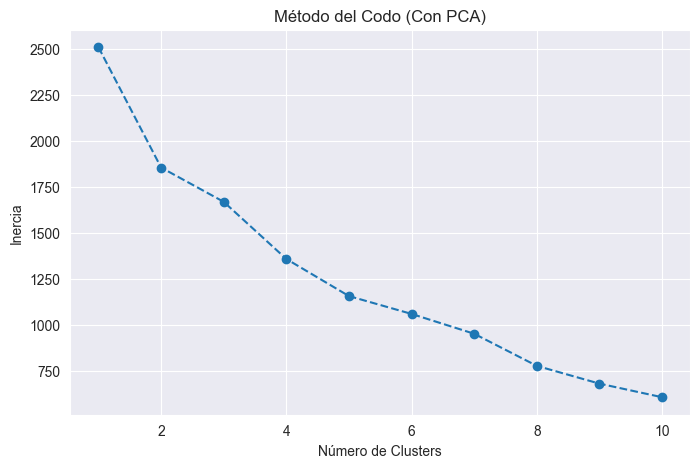

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



Silhouette Score para el modelo: 0.2991

Clusters de las comunas seleccionadas:
Comuna ALGARROBO pertenece al cluster 0
Comuna PUERTO VARAS pertenece al cluster 0
Comuna MACHALI pertenece al cluster 1


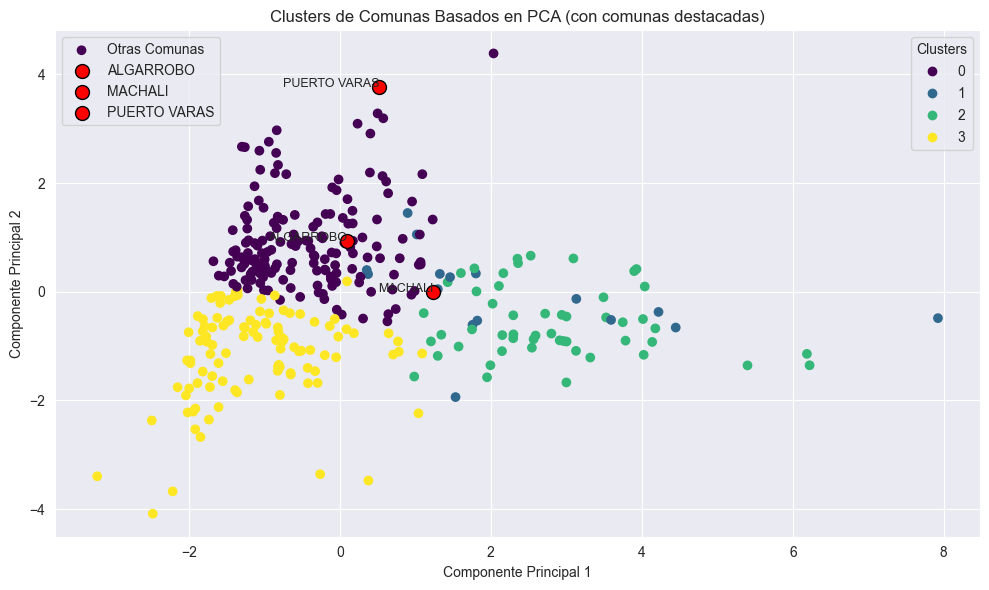


Características promedio por cluster:
         Total de Datos  Total 100-499 m2  % 100-499 m2  Total 500-4999 m2  \
cluster                                                                      
0            828.602410         51.078313      5.784159         145.174699   
1            537.647059         89.176471     18.246749         228.470588   
2            702.096154        110.500000     19.625433         398.365385   
3            161.066038          9.245283      7.448120          20.830189   

         % 500-4999 m2  Total 5000-10000 m2  % 5000-10000 m2  \
cluster                                                        
0            15.590691           482.174699        59.506383   
1            37.955457           138.000000        28.299585   
2            55.608476           121.307692        14.669784   
3            13.713379            66.811321        36.779361   

         Total 10001-100000 m2  % 10001-100000 m2  Total >100000 m2  ...  \
cluster                        

In [46]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Eliminar la columna "Unnamed: 0" si existe
if 'Unnamed: 0' in data_estadisticos.columns:
    data_estadisticos = data_estadisticos.drop(columns=['Unnamed: 0'])

# Paso 2: Seleccionar las variables relevantes para el clustering
variables_clustering = [
    'Total de Datos', '% 500-4999 m2', '% 5000-10000 m2', '% 10001-100000 m2', '% >100000 m2',
    'Mediana costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
    'Mediana costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar los datos usando StandardScaler (Estandarización)
scaler = StandardScaler()
X_normalizado = scaler.fit_transform(X)

# Paso 4: Aplicar PCA para reducir la dimensionalidad (eliminar colinealidad)
pca = PCA(n_components=5)  # Reducir a 5 componentes principales
X_pca = pca.fit_transform(X_normalizado)

# Imprimir las varianzas explicadas por cada componente principal
varianzas_explicadas = pca.explained_variance_ratio_
print("Varianzas explicadas por cada componente principal:")
for i, varianza in enumerate(varianzas_explicadas):
    print(f"PC{i + 1}: {varianza:.4f}")

# Imprimir las cargas de los componentes principales
cargas_componentes = pd.DataFrame(pca.components_, columns=variables_clustering,
                                  index=[f'PC{i + 1}' for i in range(pca.n_components_)])
print("\nCargas de los Componentes Principales:")
print(cargas_componentes)

# Paso 5: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo (Con PCA)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

# Paso 6: Aplicar K-means con el número óptimo de clusters
kmeans = KMeans(n_clusters=4, random_state=42)  # Cambia el número de clusters según el resultado del método del codo
data_estadisticos['cluster'] = kmeans.fit_predict(X_pca)

# Calcular el silhouette score para evaluar la calidad de la agrupación
silhouette_avg = silhouette_score(X_pca, data_estadisticos['cluster'])
print(f"\nSilhouette Score para el modelo: {silhouette_avg:.4f}")

# Paso 7: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['ALGARROBO', 'PUERTO VARAS', 'MACHALI']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Mostrar a qué cluster pertenecen las comunas seleccionadas
print("\nClusters de las comunas seleccionadas:")
for comuna in comunas_a_marcar:
    cluster_comuna = data_estadisticos[data_estadisticos['comuna_match'] == comuna]['cluster'].values[0]
    print(f"Comuna {comuna} pertenece al cluster {cluster_comuna}")

# Paso 8: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_estadisticos['cluster'], cmap='viridis', label='Otras Comunas')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_pca[pos_comunas.index, 0], X_pca[pos_comunas.index, 1]):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir la leyenda con los clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
plt.gca().add_artist(legend1)

# Añadir la leyenda de las comunas destacadas
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en PCA (con comunas destacadas)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Paso 9: Mostrar las características promedio por cluster (solo columnas numéricas)
print("\nCaracterísticas promedio por cluster:")

# Seleccionar solo las columnas numéricas para calcular las medias
columnas_numericas = data_estadisticos.select_dtypes(include=['float64', 'int64']).columns

# Agrupar por cluster y calcular las medias de las columnas numéricas
caracteristicas_cluster = data_estadisticos.groupby('cluster')[columnas_numericas].mean()

# Mostrar el resultado
print(caracteristicas_cluster)


### Normalizacion con RobustScaler/Normalizer

Varianzas explicadas por cada componente principal:
PC1: 0.6016
PC2: 0.1683
PC3: 0.1091
PC4: 0.0480
PC5: 0.0445

Cargas de los Componentes Principales:
     Total de Datos  % 500-4999 m2  % 5000-10000 m2  % 10001-100000 m2  \
PC1        0.708231      -0.286231        -0.490404          -0.383845   
PC2       -0.228431       0.684088        -0.676957          -0.075644   
PC3        0.059747      -0.307136        -0.437164           0.810538   
PC4        0.062381      -0.094241         0.002362          -0.168417   
PC5        0.658538       0.582341         0.325223           0.301072   

     % >100000 m2  Mediana costo_m2_uf 100-499 m2  \
PC1     -0.112402                       -0.119271   
PC2     -0.074792                        0.075443   
PC3      0.218343                        0.077745   
PC4      0.142333                        0.964265   
PC5      0.157705                        0.039780   

     Mediana costo_m2_uf 500-4999 m2  Mediana costo_m2_uf 5000-10000 m2  \
PC1      

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than ava

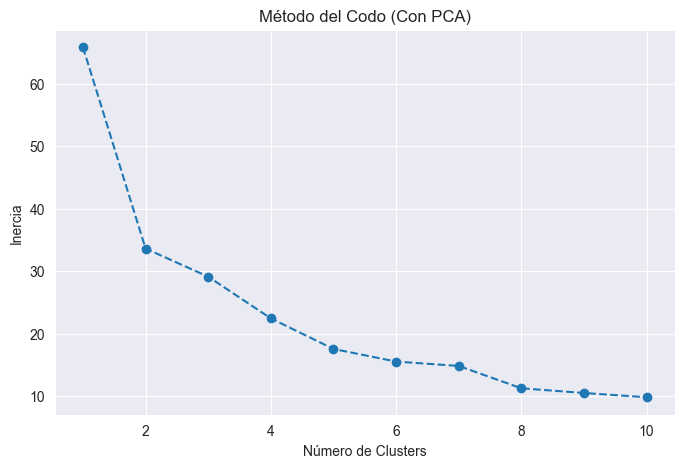

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



Silhouette Score para el modelo: 0.5031

Clusters de las comunas seleccionadas:
Comuna ALGARROBO pertenece al cluster 0
Comuna PUERTO VARAS pertenece al cluster 0
Comuna MACHALI pertenece al cluster 0


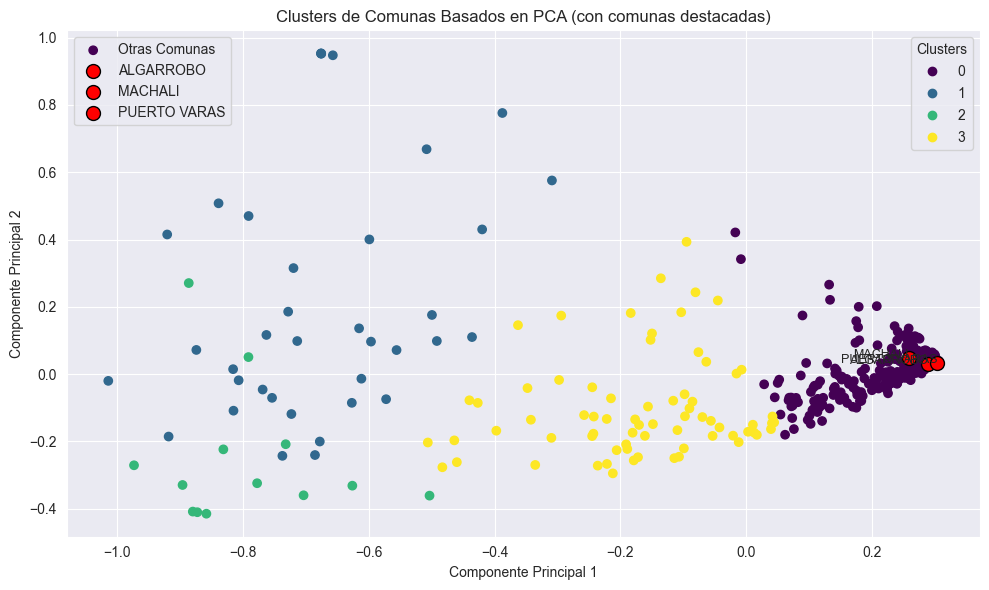


Características promedio por cluster:
         Total de Datos  Total 100-499 m2  % 100-499 m2  Total 500-4999 m2  \
cluster                                                                      
0            871.194570         73.230769      9.180703         224.968326   
1             20.756757          2.297297     10.930280           5.270270   
2             15.000000          1.076923      8.612999           1.846154   
3             96.757143          6.257143      7.643768          13.842857   

         % 500-4999 m2  Total 5000-10000 m2  % 5000-10000 m2  \
cluster                                                        
0            23.644740           416.764706        45.894948   
1            30.391653             5.540541        22.798656   
2            11.813378             8.846154        65.291368   
3            15.357198            47.885714        45.506743   

         Total 10001-100000 m2  % 10001-100000 m2  Total >100000 m2  ...  \
cluster                        

In [87]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Eliminar la columna "Unnamed: 0" si existe
if 'Unnamed: 0' in data_estadisticos.columns:
    data_estadisticos = data_estadisticos.drop(columns=['Unnamed: 0'])

# Paso 2: Seleccionar las variables relevantes para el clustering
variables_clustering = [
    'Total de Datos', '% 500-4999 m2', '% 5000-10000 m2', '% 10001-100000 m2', '% >100000 m2',
    'Mediana costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
    'Mediana costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando RobustScaler (en lugar de StandardScaler)
#scaler = RobustScaler()
scaler = Normalizer()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 4: Aplicar PCA para reducir la dimensionalidad (eliminar colinealidad)
pca = PCA(n_components=5)  # Reducir a 5 componentes principales
X_pca = pca.fit_transform(X_normalizado)

# Imprimir las varianzas explicadas por cada componente principal
varianzas_explicadas = pca.explained_variance_ratio_
print("Varianzas explicadas por cada componente principal:")
for i, varianza in enumerate(varianzas_explicadas):
    print(f"PC{i + 1}: {varianza:.4f}")

# Imprimir las cargas de los componentes principales
cargas_componentes = pd.DataFrame(pca.components_, columns=variables_clustering,
                                  index=[f'PC{i + 1}' for i in range(pca.n_components_)])
print("\nCargas de los Componentes Principales:")
print(cargas_componentes)

# Paso 5: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo (Con PCA)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

# Paso 6: Aplicar K-means con el número óptimo de clusters
kmeans = KMeans(n_clusters=4, random_state=42)  # Cambia el número de clusters según el resultado del método del codo
data_estadisticos['cluster'] = kmeans.fit_predict(X_pca)

# Calcular el silhouette score para evaluar la calidad de la agrupación
silhouette_avg = silhouette_score(X_pca, data_estadisticos['cluster'])
print(f"\nSilhouette Score para el modelo: {silhouette_avg:.4f}")

# Paso 7: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['ALGARROBO', 'PUERTO VARAS', 'MACHALI']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Mostrar a qué cluster pertenecen las comunas seleccionadas
print("\nClusters de las comunas seleccionadas:")
for comuna in comunas_a_marcar:
    cluster_comuna = data_estadisticos[data_estadisticos['comuna_match'] == comuna]['cluster'].values[0]
    print(f"Comuna {comuna} pertenece al cluster {cluster_comuna}")

# Paso 8: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_estadisticos['cluster'], cmap='viridis', label='Otras Comunas')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_pca[pos_comunas.index, 0], X_pca[pos_comunas.index, 1]):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir la leyenda con los clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
plt.gca().add_artist(legend1)

# Añadir la leyenda de las comunas destacadas
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en PCA (con comunas destacadas)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Paso 9: Mostrar las características promedio por cluster (solo columnas numéricas)
print("\nCaracterísticas promedio por cluster:")

# Seleccionar solo las columnas numéricas para calcular las medias
columnas_numericas = data_estadisticos.select_dtypes(include=['float64', 'int64']).columns

# Agrupar por cluster y calcular las medias de las columnas numéricas
caracteristicas_cluster = data_estadisticos.groupby('cluster')[columnas_numericas].mean()

# Mostrar el resultado
print(caracteristicas_cluster)

print("\nCaracterísticas mediana por cluster:")

# Agrupar por cluster y calcular las medianas de las columnas numéricas
caracteristicas_cluster_median = data_estadisticos.groupby('cluster')[columnas_numericas].median()

# Mostrar el resultado
print(caracteristicas_cluster_median)


In [90]:
data_estadisticos.columns

Index(['comuna_match', 'Total de Datos', 'Total 100-499 m2', '% 100-499 m2',
       'Total 500-4999 m2', '% 500-4999 m2', 'Total 5000-10000 m2',
       '% 5000-10000 m2', 'Total 10001-100000 m2', '% 10001-100000 m2',
       'Total >100000 m2', '% >100000 m2', 'Mediana costo_m2_uf 100-499 m2',
       'Media costo_m2_uf 100-499 m2', 'Desviación costo_m2_uf 100-499 m2',
       'Mínimo costo_m2_uf 100-499 m2', 'Máximo costo_m2_uf 100-499 m2',
       'IQR costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
       'Media costo_m2_uf 500-4999 m2', 'Desviación costo_m2_uf 500-4999 m2',
       'Mínimo costo_m2_uf 500-4999 m2', 'Máximo costo_m2_uf 500-4999 m2',
       'IQR costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
       'Media costo_m2_uf 5000-10000 m2',
       'Desviación costo_m2_uf 5000-10000 m2',
       'Mínimo costo_m2_uf 5000-10000 m2', 'Máximo costo_m2_uf 5000-10000 m2',
       'IQR costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2',
       'Me

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


Silhouette Score para el modelo: 0.2921


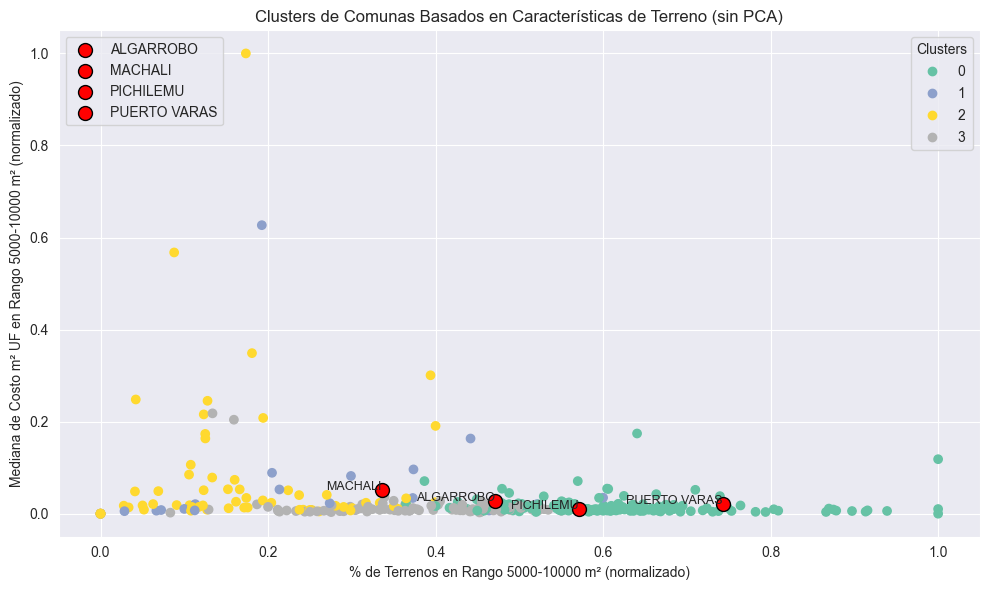


Pesos de cada variable en el clustering (valores de los centroides):
   Total de Datos  % 500-4999 m2  % 5000-10000 m2  % 10001-100000 m2  \
0        0.105138       0.130950         0.615532           0.229656   
1        0.068469       0.391293         0.265864           0.167881   
2        0.101785       0.526658         0.173081           0.154108   
3        0.020964       0.138740         0.350617           0.477871   

   % >100000 m2  Mediana costo_m2_uf 500-4999 m2  \
0      0.128405                         0.041717   
1      0.064680                         0.142430   
2      0.046366                         0.166943   
3      0.318569                         0.044405   

   Mediana costo_m2_uf 5000-10000 m2  Mediana costo_m2_uf 10001-100000 m2  \
0                           0.016208                             0.011546   
1                           0.074408                             0.039095   
2                           0.076570                             0.027827   


In [108]:

import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total de Datos',
    '% 500-4999 m2', '% 5000-10000 m2', '% 10001-100000 m2', '% >100000 m2',
    'Mediana costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
    'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]


# Paso 3: Normalizar las características usando RobustScaler (en lugar de StandardScaler)
#scaler = RobustScaler()
scaler = MinMaxScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['% 5000-10000 m2'], X_normalizado['Mediana costo_m2_uf 5000-10000 m2'],
                      c=data_estadisticos['cluster'], cmap='Set2')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, '% 5000-10000 m2'], 
                        X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 5000-10000 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('% de Terrenos en Rango 5000-10000 m² (normalizado)')
plt.ylabel('Mediana de Costo m² UF en Rango 5000-10000 m² (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Paso 7: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)



# Paso 9: Mostrar las características promedio por cluster (solo columnas numéricas)
print("\nCaracterísticas promedio por cluster:")

# Seleccionar solo las columnas numéricas para calcular las medias
columnas_numericas = data_estadisticos.select_dtypes(include=['float64', 'int64']).columns

# Agrupar por cluster y calcular las medias de las columnas numéricas
caracteristicas_cluster = data_estadisticos.groupby('cluster')[columnas_numericas].mean()

# Mostrar el resultado
print(caracteristicas_cluster)

print("\nCaracterísticas mediana por cluster:")

# Agrupar por cluster y calcular las medianas de las columnas numéricas
caracteristicas_cluster_median = data_estadisticos.groupby('cluster')[columnas_numericas].median()

# Mostrar el resultado
print(caracteristicas_cluster_median)
# Paso 7: Guardar los resultados con clustering en un archivo CSV
#data_estadisticos.to_csv('data recuperada/estadisticos_por_comuna_con_clusters_sin_PCA.csv', index=False)

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


Silhouette Score para el modelo: 0.5274


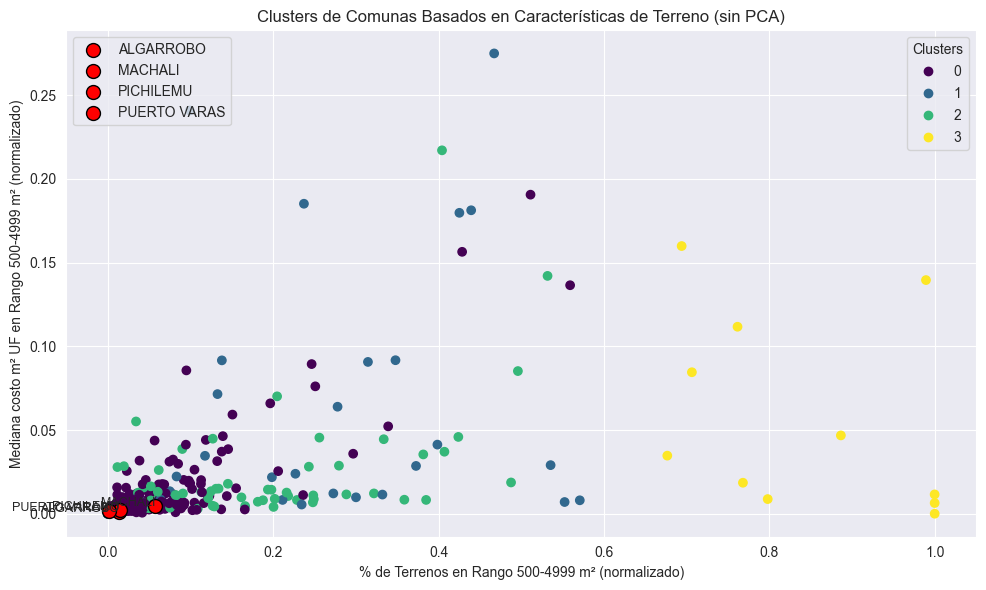


Pesos de cada variable en el clustering (valores de los centroides):
   Total de Datos  % 500-4999 m2  % 5000-10000 m2  % 10001-100000 m2  \
0        0.982642       0.054881         0.107989           0.043502   
1        0.280638       0.213646         0.592582           0.482355   
2        0.803669       0.169392         0.431448           0.240702   
3        0.255911       0.843664         0.174028           0.130623   

   % >100000 m2  Mediana costo_m2_uf 500-4999 m2  \
0      0.014601                         0.011026   
1      0.130261                         0.050292   
2      0.099138                         0.021797   
3      0.036839                         0.056573   

   Mediana costo_m2_uf 5000-10000 m2  Mediana costo_m2_uf 10001-100000 m2  \
0                           0.001774                             0.001254   
1                           0.003196                             0.019435   
2                           0.002475                             0.003055   


In [49]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total de Datos',
    '% 500-4999 m2', '% 5000-10000 m2', '% 10001-100000 m2', '% >100000 m2',
    'Mediana costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
    'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando RobustScaler (en lugar de StandardScaler)
#scaler = RobustScaler()
scaler = Normalizer()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)
'''
# Paso 4: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_normalizado)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo (sin PCA)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()
'''
# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['% 500-4999 m2'], X_normalizado['Mediana costo_m2_uf 500-4999 m2'],
                      c=data_estadisticos['cluster'], cmap='viridis')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, '% 500-4999 m2'], 
                        X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 500-4999 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('% de Terrenos en Rango 500-4999 m² (normalizado)')
plt.ylabel('Mediana costo m² UF en Rango 500-4999 m² (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 8: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

# Paso 9: Guardar los resultados con clustering en un archivo CSV
# data_estadisticos.to_csv('data recuperada/estadisticos_por_comuna_con_clusters_sin_PCA.csv', index=False)


C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


Silhouette Score para el modelo: 0.5274


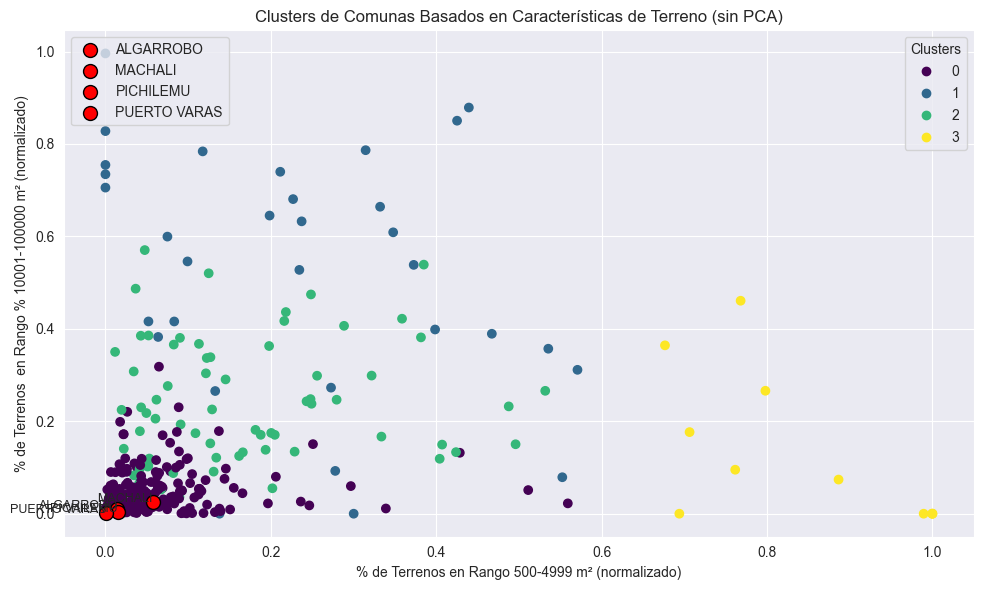


Pesos de cada variable en el clustering (valores de los centroides):
   Total de Datos  % 500-4999 m2  % 5000-10000 m2  % 10001-100000 m2  \
0        0.982642       0.054881         0.107989           0.043502   
1        0.280638       0.213646         0.592582           0.482355   
2        0.803669       0.169392         0.431448           0.240702   
3        0.255911       0.843664         0.174028           0.130623   

   % >100000 m2  Mediana costo_m2_uf 500-4999 m2  \
0      0.014601                         0.011026   
1      0.130261                         0.050292   
2      0.099138                         0.021797   
3      0.036839                         0.056573   

   Mediana costo_m2_uf 5000-10000 m2  Mediana costo_m2_uf 10001-100000 m2  \
0                           0.001774                             0.001254   
1                           0.003196                             0.019435   
2                           0.002475                             0.003055   


In [92]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total de Datos',
    '% 500-4999 m2', '% 5000-10000 m2', '% 10001-100000 m2', '% >100000 m2',
    'Mediana costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
    'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando RobustScaler (en lugar de StandardScaler)
scaler = Normalizer()
#scaler = RobustScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)
'''
# Paso 4: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_normalizado)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo (sin PCA)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()
'''
# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['% 500-4999 m2'], X_normalizado['% 10001-100000 m2'],
                      c=data_estadisticos['cluster'], cmap='viridis')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, '% 500-4999 m2'], 
                        X_normalizado.loc[pos_comunas.index, '% 10001-100000 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('% de Terrenos en Rango 500-4999 m² (normalizado)')
plt.ylabel('% de Terrenos  en Rango % 10001-100000 m² (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 8: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

Silhouette Score para el modelo: 0.5274


C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


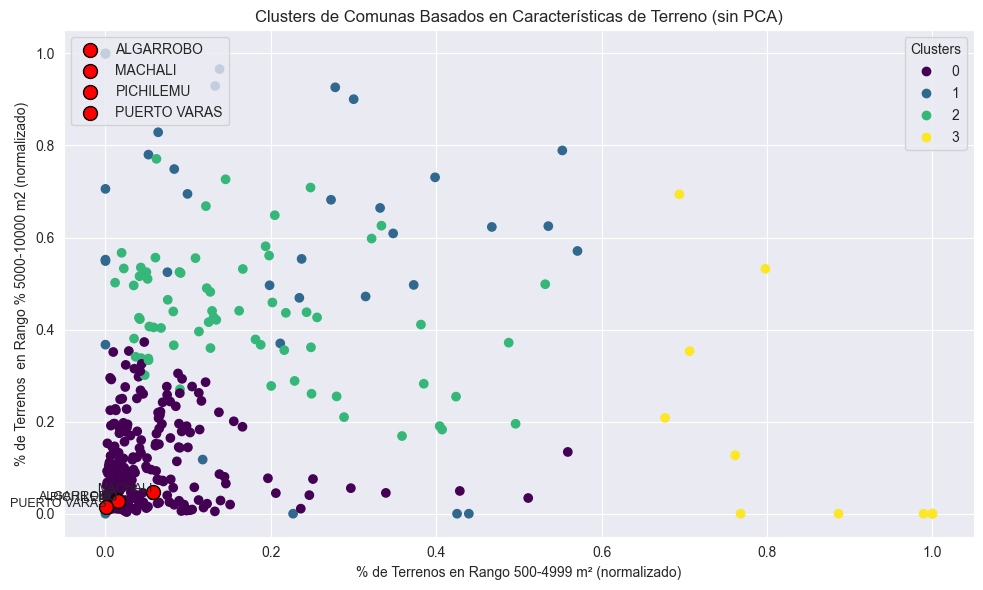


Pesos de cada variable en el clustering (valores de los centroides):
   Total de Datos  % 500-4999 m2  % 5000-10000 m2  % 10001-100000 m2  \
0        0.982642       0.054881         0.107989           0.043502   
1        0.280638       0.213646         0.592582           0.482355   
2        0.803669       0.169392         0.431448           0.240702   
3        0.255911       0.843664         0.174028           0.130623   

   % >100000 m2  Mediana costo_m2_uf 500-4999 m2  \
0      0.014601                         0.011026   
1      0.130261                         0.050292   
2      0.099138                         0.021797   
3      0.036839                         0.056573   

   Mediana costo_m2_uf 5000-10000 m2  Mediana costo_m2_uf 10001-100000 m2  \
0                           0.001774                             0.001254   
1                           0.003196                             0.019435   
2                           0.002475                             0.003055   


In [51]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total de Datos',
    '% 500-4999 m2', '% 5000-10000 m2', '% 10001-100000 m2', '% >100000 m2',
    'Mediana costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
    'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando RobustScaler (en lugar de StandardScaler)
#scaler = RobustScaler()
scaler = Normalizer()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['% 500-4999 m2'], X_normalizado['% 5000-10000 m2'],
                      c=data_estadisticos['cluster'], cmap='viridis')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, '% 500-4999 m2'], 
                        X_normalizado.loc[pos_comunas.index, '% 5000-10000 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('% de Terrenos en Rango 500-4999 m² (normalizado)')
plt.ylabel('% de Terrenos  en Rango % 5000-10000 m2 (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 8: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

Silhouette Score para el modelo: 0.5274


C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


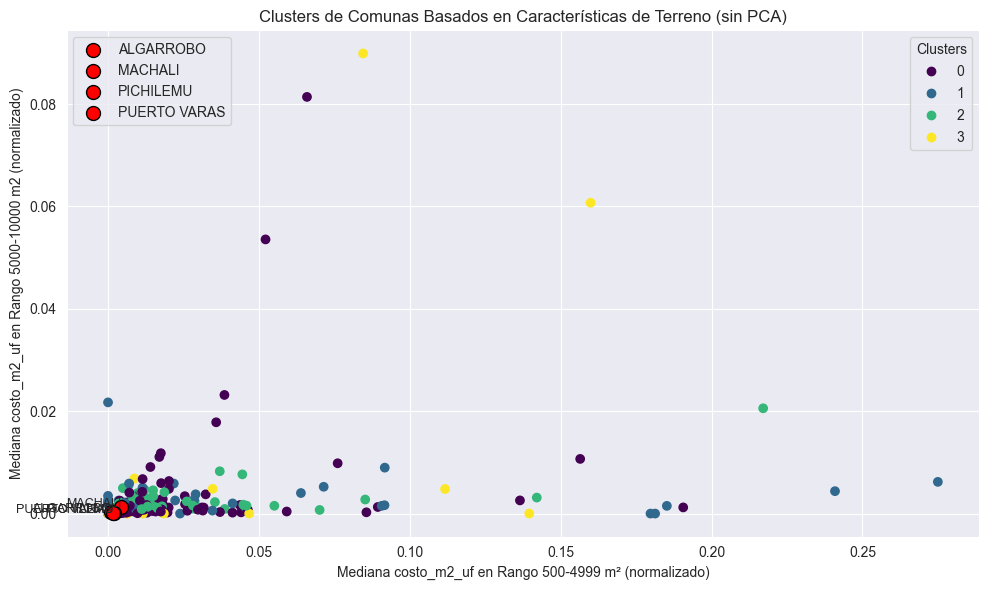


Pesos de cada variable en el clustering (valores de los centroides):
   Total de Datos  % 500-4999 m2  % 5000-10000 m2  % 10001-100000 m2  \
0        0.982642       0.054881         0.107989           0.043502   
1        0.280638       0.213646         0.592582           0.482355   
2        0.803669       0.169392         0.431448           0.240702   
3        0.255911       0.843664         0.174028           0.130623   

   % >100000 m2  Mediana costo_m2_uf 500-4999 m2  \
0      0.014601                         0.011026   
1      0.130261                         0.050292   
2      0.099138                         0.021797   
3      0.036839                         0.056573   

   Mediana costo_m2_uf 5000-10000 m2  Mediana costo_m2_uf 10001-100000 m2  \
0                           0.001774                             0.001254   
1                           0.003196                             0.019435   
2                           0.002475                             0.003055   


In [52]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total de Datos',
    '% 500-4999 m2', '% 5000-10000 m2', '% 10001-100000 m2', '% >100000 m2',
    'Mediana costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
    'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando RobustScaler (en lugar de StandardScaler)
#scaler = RobustScaler()
scaler = Normalizer()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['Mediana costo_m2_uf 500-4999 m2'], X_normalizado['Mediana costo_m2_uf 5000-10000 m2'],
                      c=data_estadisticos['cluster'], cmap='viridis')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 500-4999 m2'], 
                        X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 5000-10000 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('Mediana costo_m2_uf en Rango 500-4999 m² (normalizado)')
plt.ylabel('Mediana costo_m2_uf en Rango 5000-10000 m2 (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 8: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

Silhouette Score para el modelo: 0.5274


C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


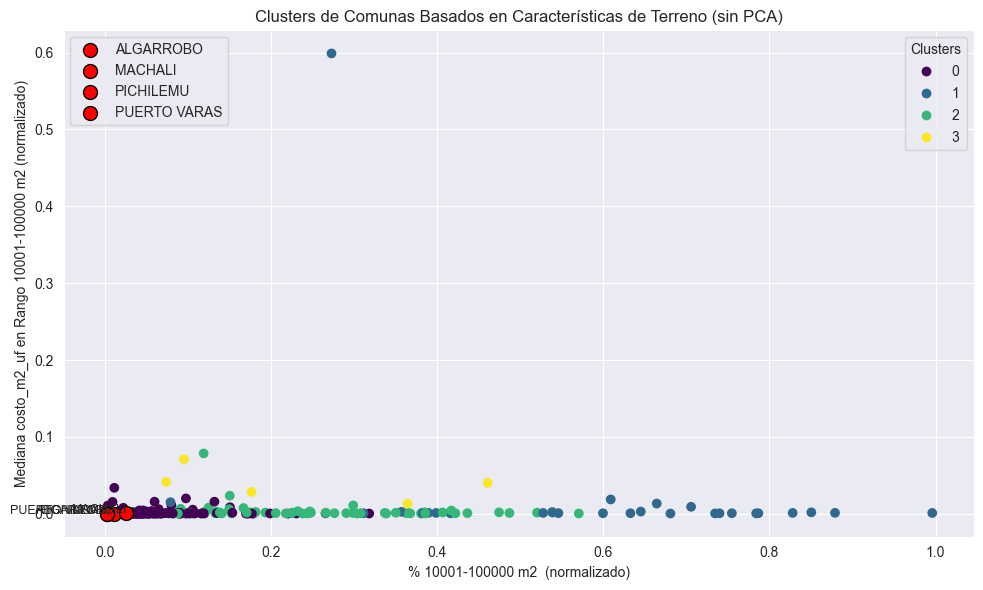


Pesos de cada variable en el clustering (valores de los centroides):
   Total de Datos  % 500-4999 m2  % 5000-10000 m2  % 10001-100000 m2  \
0        0.982642       0.054881         0.107989           0.043502   
1        0.280638       0.213646         0.592582           0.482355   
2        0.803669       0.169392         0.431448           0.240702   
3        0.255911       0.843664         0.174028           0.130623   

   % >100000 m2  Mediana costo_m2_uf 500-4999 m2  \
0      0.014601                         0.011026   
1      0.130261                         0.050292   
2      0.099138                         0.021797   
3      0.036839                         0.056573   

   Mediana costo_m2_uf 5000-10000 m2  Mediana costo_m2_uf 10001-100000 m2  \
0                           0.001774                             0.001254   
1                           0.003196                             0.019435   
2                           0.002475                             0.003055   


In [53]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total de Datos',
    '% 500-4999 m2', '% 5000-10000 m2', '% 10001-100000 m2', '% >100000 m2',
    'Mediana costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
    'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando RobustScaler (en lugar de StandardScaler)
scaler = Normalizer()
#scaler = RobustScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['% 10001-100000 m2'], X_normalizado['Mediana costo_m2_uf 10001-100000 m2'],
                      c=data_estadisticos['cluster'], cmap='viridis')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, '% 10001-100000 m2'], 
                        X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 10001-100000 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('% 10001-100000 m2  (normalizado)')
plt.ylabel('Mediana costo_m2_uf en Rango 10001-100000 m2 (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 8: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


Silhouette Score para el modelo: 0.3769


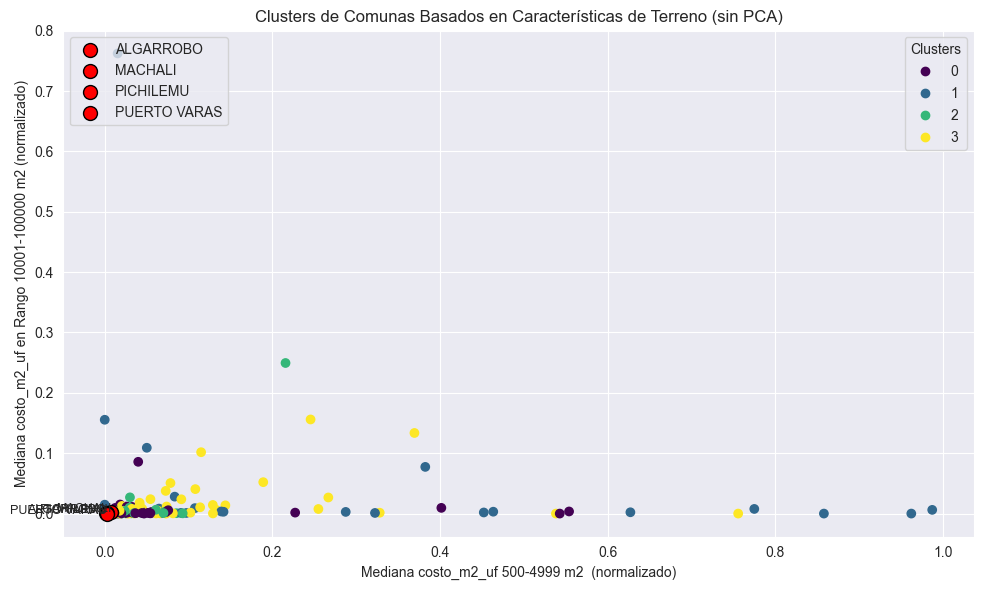


Pesos de cada variable en el clustering (valores de los centroides):
   Total 100-499 m2  Total 500-4999 m2  Total 5000-10000 m2  \
0          0.079221           0.185523             0.916687   
1          0.123355           0.168361             0.282110   
2          0.124302           0.361634             0.659282   
3          0.324435           0.796097             0.269794   

   Total 10001-100000 m2  Mediana costo_m2_uf 100-499 m2  \
0               0.250722                        0.048224   
1               0.299128                        0.648125   
2               0.551056                        0.065952   
3               0.173067                        0.077565   

   Mediana costo_m2_uf 500-4999 m2  Mediana costo_m2_uf 5000-10000 m2  \
0                         0.020587                           0.006837   
1                         0.246537                           0.022559   
2                         0.024841                           0.005342   
3                    

In [106]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total 100-499 m2', 'Total 500-4999 m2', 'Total 5000-10000 m2', 'Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
    'Mediana costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]


# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando RobustScaler (en lugar de StandardScaler)
#scaler = RobustScaler()
scaler = Normalizer()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['Mediana costo_m2_uf 500-4999 m2'], X_normalizado['Mediana costo_m2_uf 10001-100000 m2'],
                      c=data_estadisticos['cluster'], cmap='viridis')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 500-4999 m2'], 
                        X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 10001-100000 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('Mediana costo_m2_uf 500-4999 m2  (normalizado)')
plt.ylabel('Mediana costo_m2_uf en Rango 10001-100000 m2 (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 8: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

Varianzas explicadas por cada componente principal:
PC1: 0.6016
PC2: 0.1683
PC3: 0.1091
PC4: 0.0480
PC5: 0.0445

Cargas de los Componentes Principales:
     Total de Datos  % 500-4999 m2  % 5000-10000 m2  % 10001-100000 m2  \
PC1        0.708231      -0.286231        -0.490404          -0.383845   
PC2       -0.228431       0.684088        -0.676957          -0.075644   
PC3        0.059747      -0.307136        -0.437164           0.810538   
PC4        0.062381      -0.094241         0.002362          -0.168417   
PC5        0.658538       0.582341         0.325223           0.301072   

     % >100000 m2  Mediana costo_m2_uf 100-499 m2  \
PC1     -0.112402                       -0.119271   
PC2     -0.074792                        0.075443   
PC3      0.218343                        0.077745   
PC4      0.142333                        0.964265   
PC5      0.157705                        0.039780   

     Mediana costo_m2_uf 500-4999 m2  Mediana costo_m2_uf 5000-10000 m2  \
PC1      

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than ava

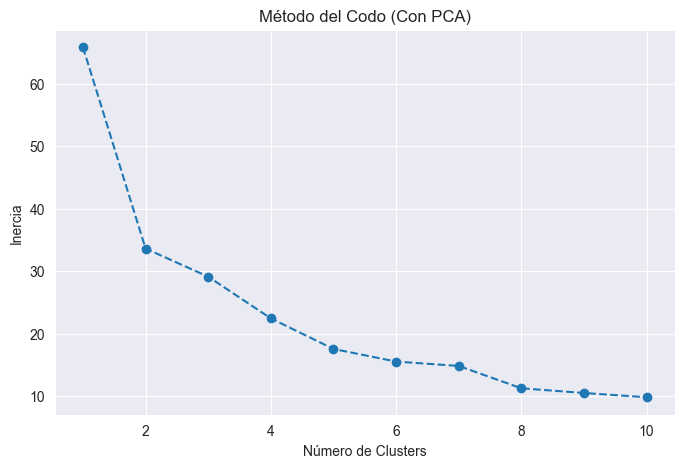

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



Silhouette Score para el modelo: 0.5031


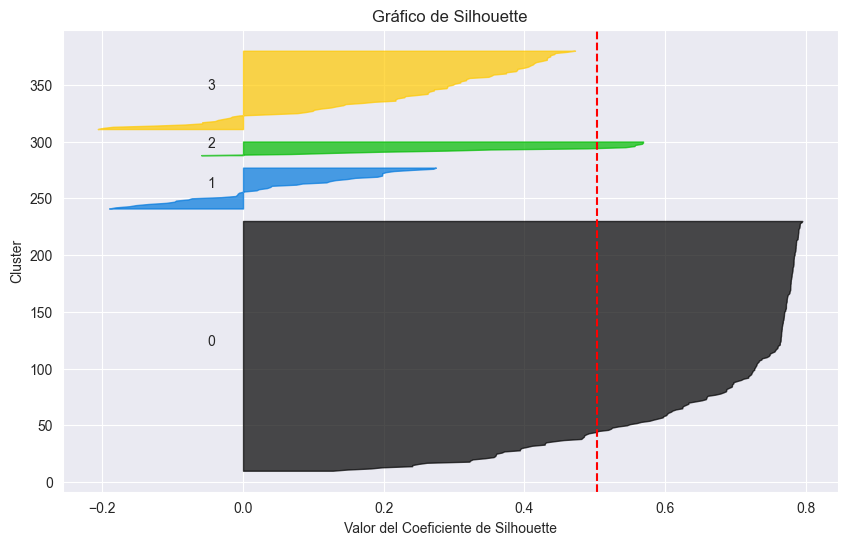


Clusters de las comunas seleccionadas:
Comuna ALGARROBO pertenece al cluster 0
Comuna PUERTO VARAS pertenece al cluster 0
Comuna MACHALI pertenece al cluster 0


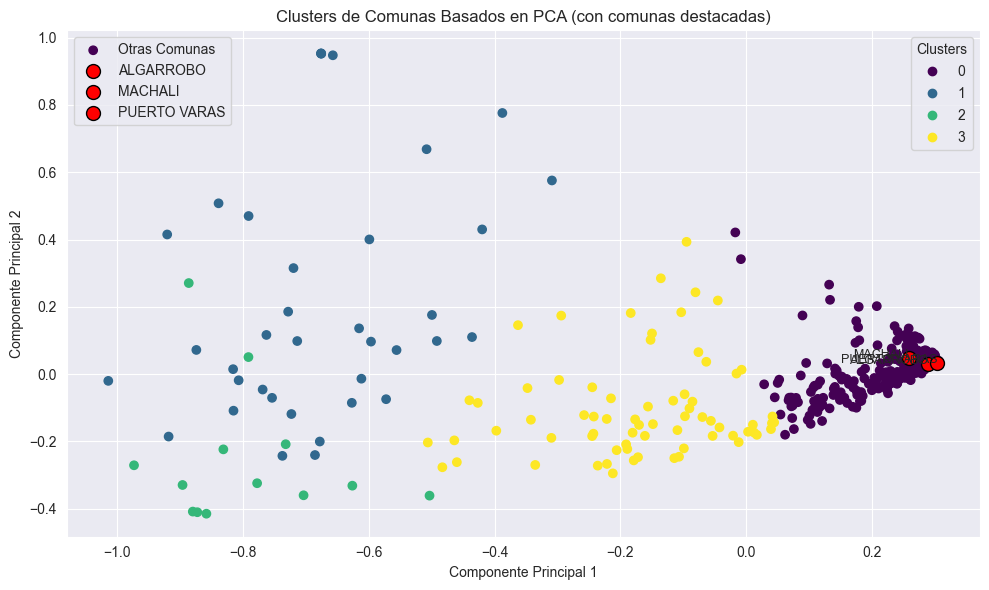


Características promedio por cluster:
         Total de Datos  Total 100-499 m2  % 100-499 m2  Total 500-4999 m2  \
cluster                                                                      
0            871.194570         73.230769      9.180703         224.968326   
1             20.756757          2.297297     10.930280           5.270270   
2             15.000000          1.076923      8.612999           1.846154   
3             96.757143          6.257143      7.643768          13.842857   

         % 500-4999 m2  Total 5000-10000 m2  % 5000-10000 m2  \
cluster                                                        
0            23.644740           416.764706        45.894948   
1            30.391653             5.540541        22.798656   
2            11.813378             8.846154        65.291368   
3            15.357198            47.885714        45.506743   

         Total 10001-100000 m2  % 10001-100000 m2  Total >100000 m2  ...  \
cluster                        

In [55]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Eliminar la columna "Unnamed: 0" si existe
if 'Unnamed: 0' in data_estadisticos.columns:
    data_estadisticos = data_estadisticos.drop(columns=['Unnamed: 0'])

# Paso 2: Seleccionar las variables relevantes para el clustering
variables_clustering = [
    'Total de Datos', '% 500-4999 m2', '% 5000-10000 m2', '% 10001-100000 m2', '% >100000 m2',
    'Mediana costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
    'Mediana costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando Normalizer
scaler = Normalizer()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 4: Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=5)  # Reducir a 5 componentes principales
X_pca = pca.fit_transform(X_normalizado)

# Imprimir las varianzas explicadas por cada componente principal
varianzas_explicadas = pca.explained_variance_ratio_
print("Varianzas explicadas por cada componente principal:")
for i, varianza in enumerate(varianzas_explicadas):
    print(f"PC{i + 1}: {varianza:.4f}")

# Imprimir las cargas de los componentes principales
cargas_componentes = pd.DataFrame(pca.components_, columns=variables_clustering,
                                  index=[f'PC{i + 1}' for i in range(pca.n_components_)])
print("\nCargas de los Componentes Principales:")
print(cargas_componentes)

# Paso 5: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo (Con PCA)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

# Paso 6: Aplicar K-means con el número óptimo de clusters
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_pca)

# Calcular el silhouette score para evaluar la calidad de la agrupación
silhouette_avg = silhouette_score(X_pca, data_estadisticos['cluster'])
print(f"\nSilhouette Score para el modelo: {silhouette_avg:.4f}")

# Graficar el Silhouette Score para cada punto
sample_silhouette_values = silhouette_samples(X_pca, data_estadisticos['cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(4):
    ith_cluster_silhouette_values = sample_silhouette_values[data_estadisticos['cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / 4)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10  # 10 for the 0 samples gap between silhouette plots

plt.title("Gráfico de Silhouette")
plt.xlabel("Valor del Coeficiente de Silhouette")
plt.ylabel("Cluster")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.grid(True)
plt.show()

# Paso 7: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['ALGARROBO', 'PUERTO VARAS', 'MACHALI']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Mostrar a qué cluster pertenecen las comunas seleccionadas
print("\nClusters de las comunas seleccionadas:")
for comuna in comunas_a_marcar:
    cluster_comuna = data_estadisticos[data_estadisticos['comuna_match'] == comuna]['cluster'].values[0]
    print(f"Comuna {comuna} pertenece al cluster {cluster_comuna}")

# Paso 8: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_estadisticos['cluster'], cmap='viridis', label='Otras Comunas')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_pca[pos_comunas.index, 0], X_pca[pos_comunas.index, 1]):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir la leyenda con los clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
plt.gca().add_artist(legend1)

# Añadir la leyenda de las comunas destacadas
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en PCA (con comunas destacadas)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 9: Mostrar las características promedio por cluster (solo columnas numéricas)
print("\nCaracterísticas promedio por cluster:")
columnas_numericas = data_estadisticos.select_dtypes(include=['float64', 'int64']).columns
caracteristicas_cluster = data_estadisticos.groupby('cluster')[columnas_numericas].mean()
print(caracteristicas_cluster)

print("\nCaracterísticas mediana por cluster:")
caracteristicas_cluster_median = data_estadisticos.groupby('cluster')[columnas_numericas].median()
print(caracteristicas_cluster_median)


## Min-Max Scaler

Varianzas explicadas por cada componente principal:
PC1: 0.4149
PC2: 0.2517
PC3: 0.0801
PC4: 0.0729
PC5: 0.0675

Cargas de los Componentes Principales:
     Total de Datos  % 500-4999 m2  % 5000-10000 m2  % 10001-100000 m2  \
PC1        0.033671       0.661483        -0.635897          -0.196601   
PC2       -0.215434      -0.101245        -0.528731           0.661043   
PC3       -0.063655       0.043894        -0.007963          -0.488161   
PC4        0.269417      -0.147741        -0.017528           0.335801   
PC5        0.926867       0.018040        -0.056461           0.060453   

     % >100000 m2  Mediana costo_m2_uf 100-499 m2  \
PC1     -0.239284                        0.008928   
PC2      0.466057                       -0.006268   
PC3      0.743951                        0.042897   
PC4     -0.257426                        0.012490   
PC5      0.250138                        0.065423   

     Mediana costo_m2_uf 500-4999 m2  Mediana costo_m2_uf 5000-10000 m2  \
PC1      

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than ava

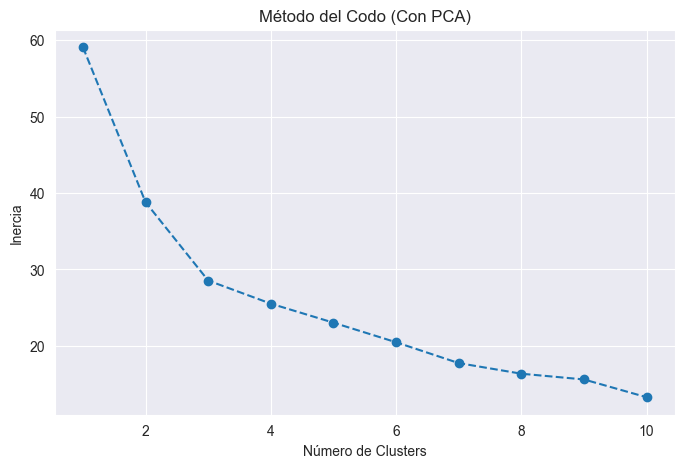

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



Silhouette Score para el modelo: 0.3301


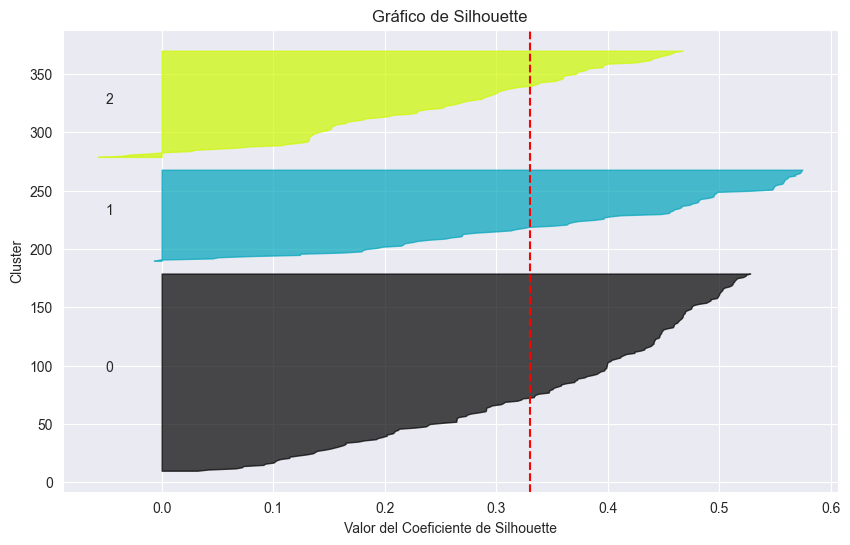


Clusters de las comunas seleccionadas:
Comuna ALGARROBO pertenece al cluster 0
Comuna PUERTO VARAS pertenece al cluster 0
Comuna MACHALI pertenece al cluster 1
Comuna PICHILEMU pertenece al cluster 0


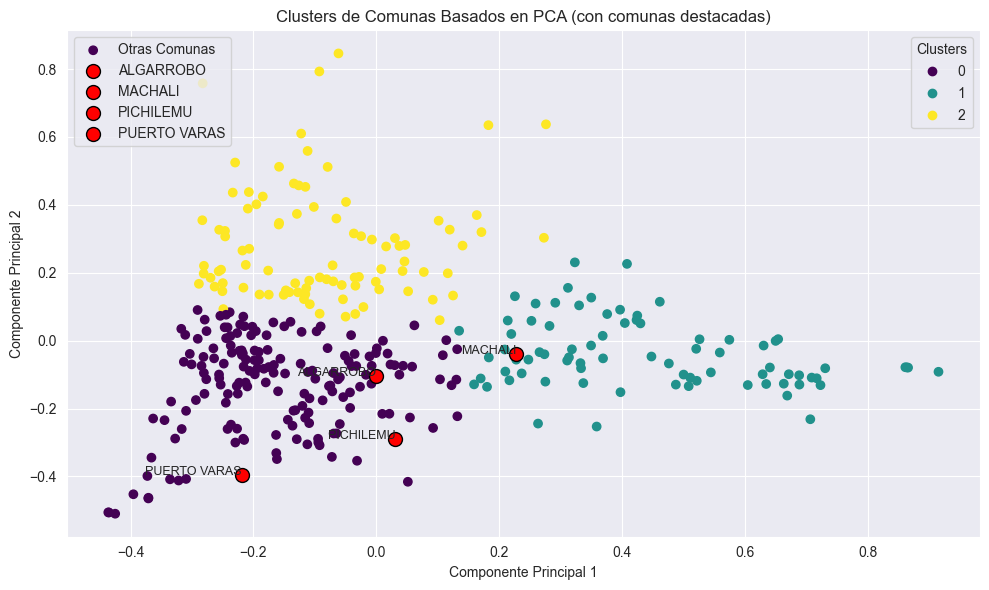


Características promedio por cluster:
         Total de Datos  Total 100-499 m2  % 100-499 m2  Total 500-4999 m2  \
cluster                                                                      
0            758.517647         39.605882      5.289953         116.805882   
1            721.569620        115.202532     19.100049         367.316456   
2            155.630435          9.641304      7.306440          22.076087   

         % 500-4999 m2  Total 5000-10000 m2  % 5000-10000 m2  \
cluster                                                        
0            13.358172           460.300000        61.172073   
1            51.221399           153.025316        17.732985   
2            13.708442            59.097826        35.004731   

         Total 10001-100000 m2  % 10001-100000 m2  Total >100000 m2  ...  \
cluster                                                              ...   
0                   109.958824          15.397509         31.847059  ...   
1                    

In [56]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Eliminar la columna "Unnamed: 0" si existe
if 'Unnamed: 0' in data_estadisticos.columns:
    data_estadisticos = data_estadisticos.drop(columns=['Unnamed: 0'])

# Paso 2: Seleccionar las variables relevantes para el clustering
variables_clustering = [
    'Total de Datos', '% 500-4999 m2', '% 5000-10000 m2', '% 10001-100000 m2', '% >100000 m2',
    'Mediana costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
    'Mediana costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando Normalizer
#scaler = Normalizer()
scaler = MinMaxScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 4: Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=5)  # Reducir a 5 componentes principales
X_pca = pca.fit_transform(X_normalizado)

# Imprimir las varianzas explicadas por cada componente principal
varianzas_explicadas = pca.explained_variance_ratio_
print("Varianzas explicadas por cada componente principal:")
for i, varianza in enumerate(varianzas_explicadas):
    print(f"PC{i + 1}: {varianza:.4f}")

# Imprimir las cargas de los componentes principales
cargas_componentes = pd.DataFrame(pca.components_, columns=variables_clustering,
                                  index=[f'PC{i + 1}' for i in range(pca.n_components_)])
print("\nCargas de los Componentes Principales:")
print(cargas_componentes)

# Paso 5: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo (Con PCA)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

# Paso 6: Aplicar K-means con el número óptimo de clusters
kmeans = KMeans(n_clusters=3, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_pca)

# Calcular el silhouette score para evaluar la calidad de la agrupación
silhouette_avg = silhouette_score(X_pca, data_estadisticos['cluster'])
print(f"\nSilhouette Score para el modelo: {silhouette_avg:.4f}")

# Graficar el Silhouette Score para cada punto
sample_silhouette_values = silhouette_samples(X_pca, data_estadisticos['cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(3):
    ith_cluster_silhouette_values = sample_silhouette_values[data_estadisticos['cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / 3)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10  # 10 for the 0 samples gap between silhouette plots

plt.title("Gráfico de Silhouette")
plt.xlabel("Valor del Coeficiente de Silhouette")
plt.ylabel("Cluster")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.grid(True)
plt.show()

# Paso 7: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['ALGARROBO', 'PUERTO VARAS', 'MACHALI','PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Mostrar a qué cluster pertenecen las comunas seleccionadas
print("\nClusters de las comunas seleccionadas:")
for comuna in comunas_a_marcar:
    cluster_comuna = data_estadisticos[data_estadisticos['comuna_match'] == comuna]['cluster'].values[0]
    print(f"Comuna {comuna} pertenece al cluster {cluster_comuna}")

# Paso 8: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_estadisticos['cluster'], cmap='viridis', label='Otras Comunas')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_pca[pos_comunas.index, 0], X_pca[pos_comunas.index, 1]):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir la leyenda con los clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
plt.gca().add_artist(legend1)

# Añadir la leyenda de las comunas destacadas
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en PCA (con comunas destacadas)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 9: Mostrar las características promedio por cluster (solo columnas numéricas)
print("\nCaracterísticas promedio por cluster:")
columnas_numericas = data_estadisticos.select_dtypes(include=['float64', 'int64']).columns
caracteristicas_cluster = data_estadisticos.groupby('cluster')[columnas_numericas].mean()
print(caracteristicas_cluster)

print("\nCaracterísticas mediana por cluster:")
caracteristicas_cluster_median = data_estadisticos.groupby('cluster')[columnas_numericas].median()
print(caracteristicas_cluster_median)


C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than ava

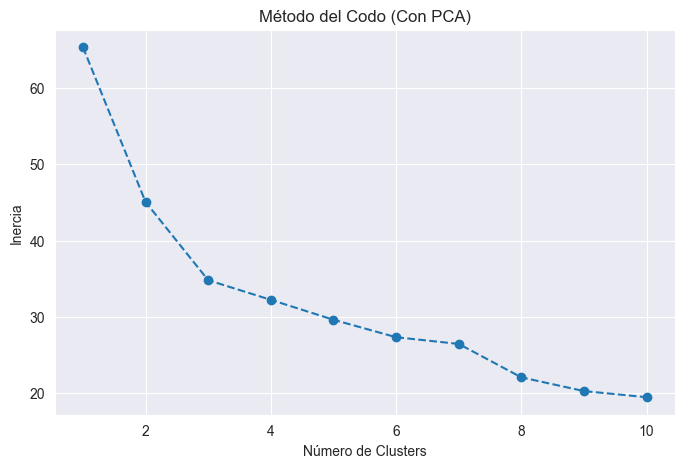

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


Silhouette Score para el modelo: 0.2921


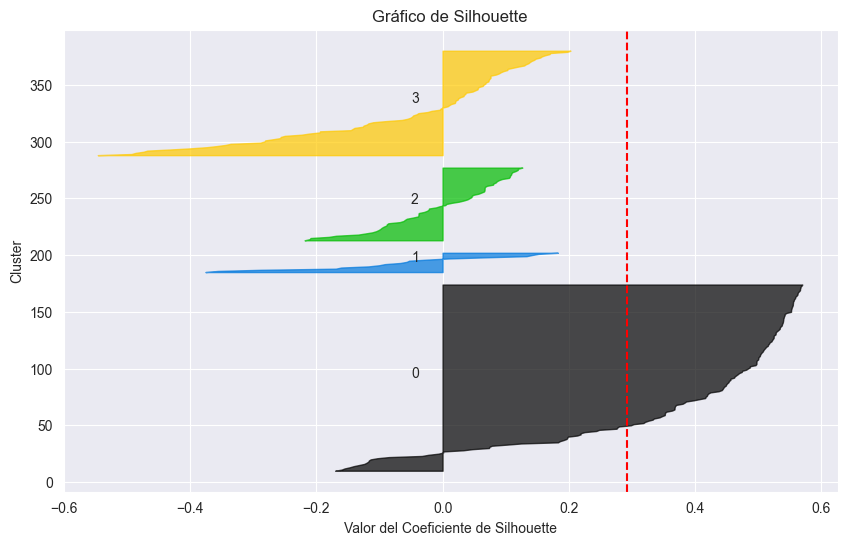

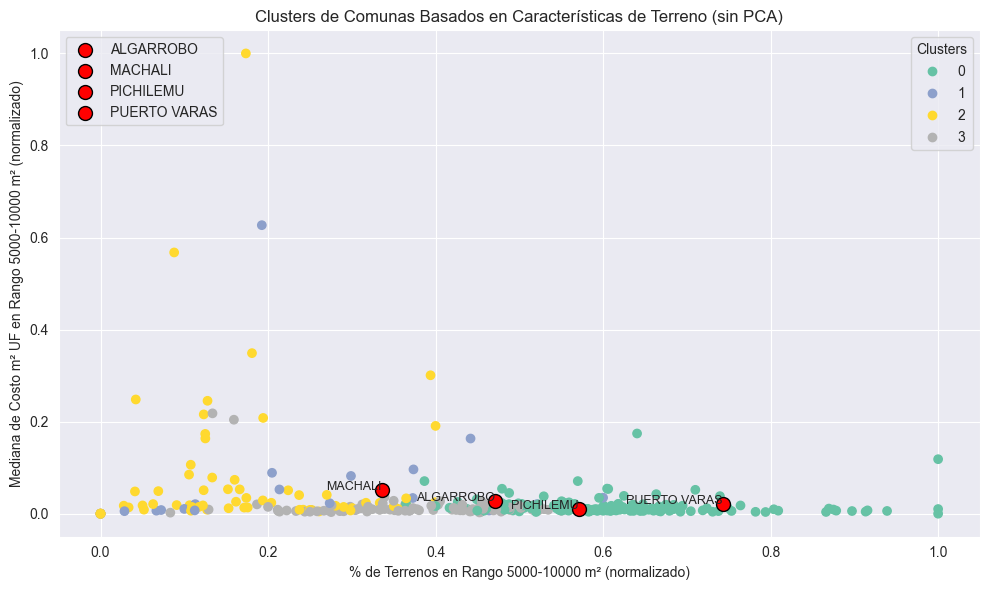


Pesos de cada variable en el clustering (valores de los centroides):
   Total de Datos  % 500-4999 m2  % 5000-10000 m2  % 10001-100000 m2  \
0        0.105138       0.130950         0.615532           0.229656   
1        0.068469       0.391293         0.265864           0.167881   
2        0.101785       0.526658         0.173081           0.154108   
3        0.020964       0.138740         0.350617           0.477871   

   % >100000 m2  Mediana costo_m2_uf 500-4999 m2  \
0      0.128405                         0.041717   
1      0.064680                         0.142430   
2      0.046366                         0.166943   
3      0.318569                         0.044405   

   Mediana costo_m2_uf 5000-10000 m2  Mediana costo_m2_uf 10001-100000 m2  \
0                           0.016208                             0.011546   
1                           0.074408                             0.039095   
2                           0.076570                             0.027827   


In [109]:

import pandas as pd
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total de Datos',
    '% 500-4999 m2', '% 5000-10000 m2', '% 10001-100000 m2', '% >100000 m2',
    'Mediana costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
    'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando StandardScaler
scaler = MinMaxScaler()
#scaler = StandardScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 4: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_normalizado)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo (Con PCA)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()


# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Graficar el Silhouette Score para cada punto
sample_silhouette_values = silhouette_samples(X_pca, data_estadisticos['cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(4):
    ith_cluster_silhouette_values = sample_silhouette_values[data_estadisticos['cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / 4)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10  # 10 for the 0 samples gap between silhouette plots

plt.title("Gráfico de Silhouette")
plt.xlabel("Valor del Coeficiente de Silhouette")
plt.ylabel("Cluster")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.grid(True)
plt.show()


# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['% 5000-10000 m2'], X_normalizado['Mediana costo_m2_uf 5000-10000 m2'],
                      c=data_estadisticos['cluster'], cmap='Set2')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, '% 5000-10000 m2'], 
                        X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 5000-10000 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('% de Terrenos en Rango 5000-10000 m² (normalizado)')
plt.ylabel('Mediana de Costo m² UF en Rango 5000-10000 m² (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Paso 7: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

# Paso 8: Guardar los resultados con clustering en un archivo CSV
# data_estadisticos.to_csv('data recuperada/estadisticos_por_comuna_con_clusters_sin_PCA.csv', index=False)


Silhouette Score para el modelo: 0.2971


C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


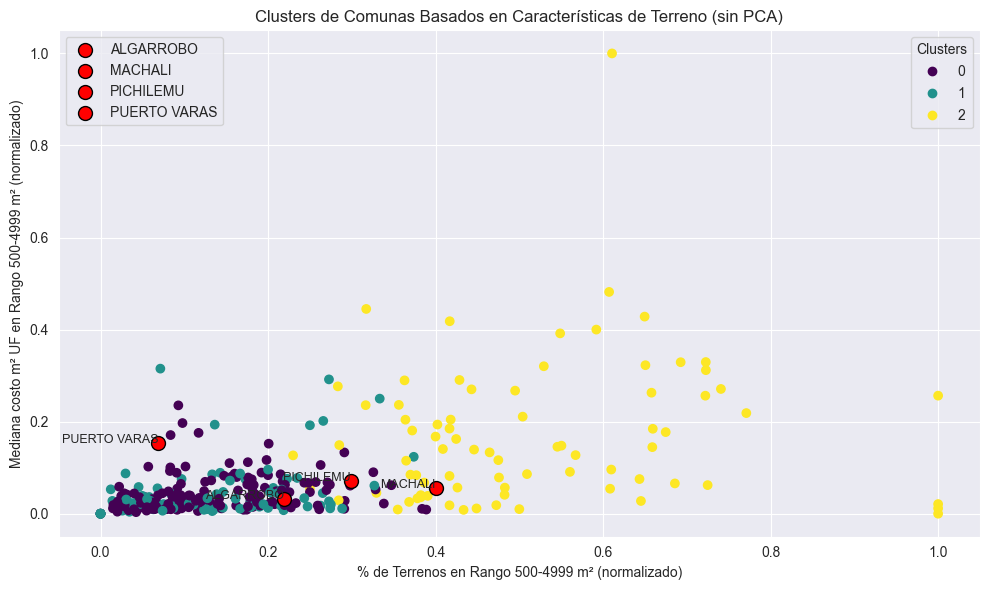


Pesos de cada variable en el clustering (valores de los centroides):
   Total de Datos  % 500-4999 m2  % 5000-10000 m2  % 10001-100000 m2  \
0        0.102854       0.133582         0.611721           0.230963   
1        0.020995       0.137084         0.350047           0.478928   
2        0.097837       0.512214         0.177330           0.152519   

   % >100000 m2  Mediana costo_m2_uf 500-4999 m2  \
0      0.127528                         0.041568   
1      0.321383                         0.044772   
2      0.047403                         0.167627   

   Mediana costo_m2_uf 5000-10000 m2  Mediana costo_m2_uf 10001-100000 m2  \
0                           0.017176                             0.011793   
1                           0.014528                             0.004205   
2                           0.077094                             0.030629   

   Mediana costo_m2_uf >100000 m2  
0                        0.070801  
1                        0.043420  
2              

In [58]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total de Datos',
    '% 500-4999 m2', '% 5000-10000 m2', '% 10001-100000 m2', '% >100000 m2',
    'Mediana costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
    'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando RobustScaler (en lugar de StandardScaler)
#scaler = RobustScaler()
scaler = MinMaxScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=3, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['% 500-4999 m2'], X_normalizado['Mediana costo_m2_uf 500-4999 m2'],
                      c=data_estadisticos['cluster'], cmap='viridis')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, '% 500-4999 m2'], 
                        X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 500-4999 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('% de Terrenos en Rango 500-4999 m² (normalizado)')
plt.ylabel('Mediana costo m² UF en Rango 500-4999 m² (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 8: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

# Paso 9: Guardar los resultados con clustering en un archivo CSV
# data_estadisticos.to_csv('data recuperada/estadisticos_por_comuna_con_clusters_sin_PCA.csv', index=False)


Silhouette Score para el modelo: 0.2971


C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


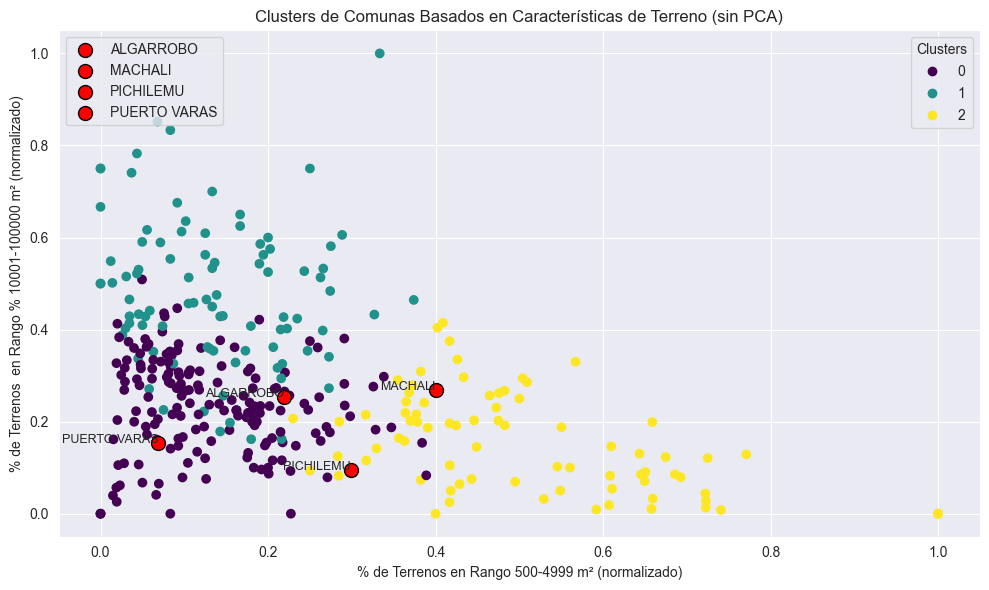


Pesos de cada variable en el clustering (valores de los centroides):


In [59]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total de Datos',
    '% 500-4999 m2', '% 5000-10000 m2', '% 10001-100000 m2', '% >100000 m2',
    'Mediana costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
    'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando RobustScaler (en lugar de StandardScaler)
scaler = MinMaxScaler()
#scaler = RobustScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)
'''
# Paso 4: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_normalizado)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo (sin PCA)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()
'''
# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=3, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['% 500-4999 m2'], X_normalizado['% 10001-100000 m2'],
                      c=data_estadisticos['cluster'], cmap='viridis')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, '% 500-4999 m2'], 
                        X_normalizado.loc[pos_comunas.index, '% 10001-100000 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('% de Terrenos en Rango 500-4999 m² (normalizado)')
plt.ylabel('% de Terrenos  en Rango % 10001-100000 m² (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 8: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")

Silhouette Score para el modelo: 0.2921


C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


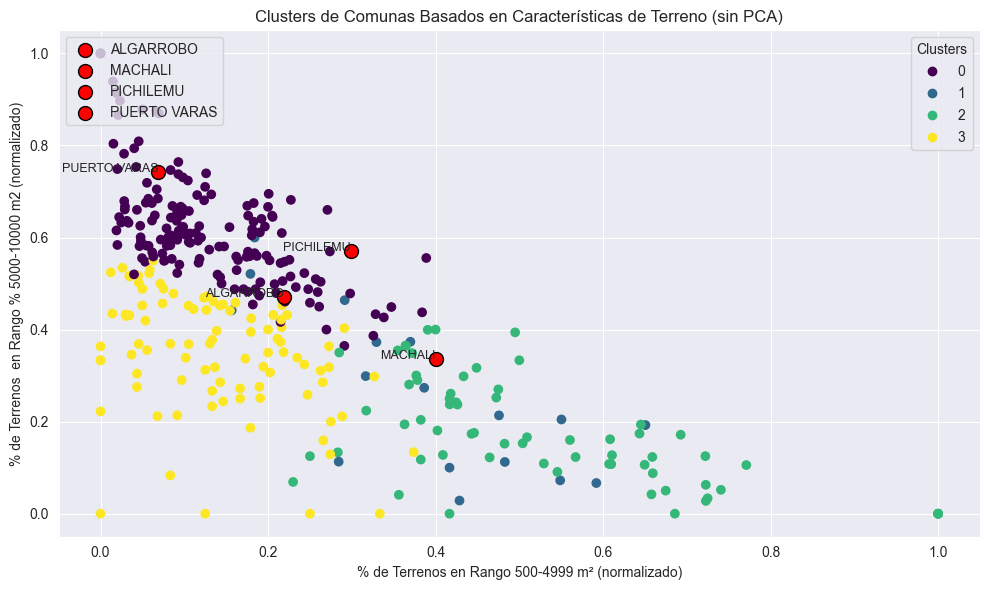


Pesos de cada variable en el clustering (valores de los centroides):
   Total de Datos  % 500-4999 m2  % 5000-10000 m2  % 10001-100000 m2  \
0        0.105138       0.130950         0.615532           0.229656   
1        0.068469       0.391293         0.265864           0.167881   
2        0.101785       0.526658         0.173081           0.154108   
3        0.020964       0.138740         0.350617           0.477871   

   % >100000 m2  Mediana costo_m2_uf 500-4999 m2  \
0      0.128405                         0.041717   
1      0.064680                         0.142430   
2      0.046366                         0.166943   
3      0.318569                         0.044405   

   Mediana costo_m2_uf 5000-10000 m2  Mediana costo_m2_uf 10001-100000 m2  \
0                           0.016208                             0.011546   
1                           0.074408                             0.039095   
2                           0.076570                             0.027827   


In [60]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total de Datos',
    '% 500-4999 m2', '% 5000-10000 m2', '% 10001-100000 m2', '% >100000 m2',
    'Mediana costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
    'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando RobustScaler (en lugar de StandardScaler)
#scaler = RobustScaler()
scaler = MinMaxScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['% 500-4999 m2'], X_normalizado['% 5000-10000 m2'],
                      c=data_estadisticos['cluster'], cmap='viridis')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, '% 500-4999 m2'], 
                        X_normalizado.loc[pos_comunas.index, '% 5000-10000 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('% de Terrenos en Rango 500-4999 m² (normalizado)')
plt.ylabel('% de Terrenos  en Rango % 5000-10000 m2 (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 8: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

Silhouette Score para el modelo: 0.2921


C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


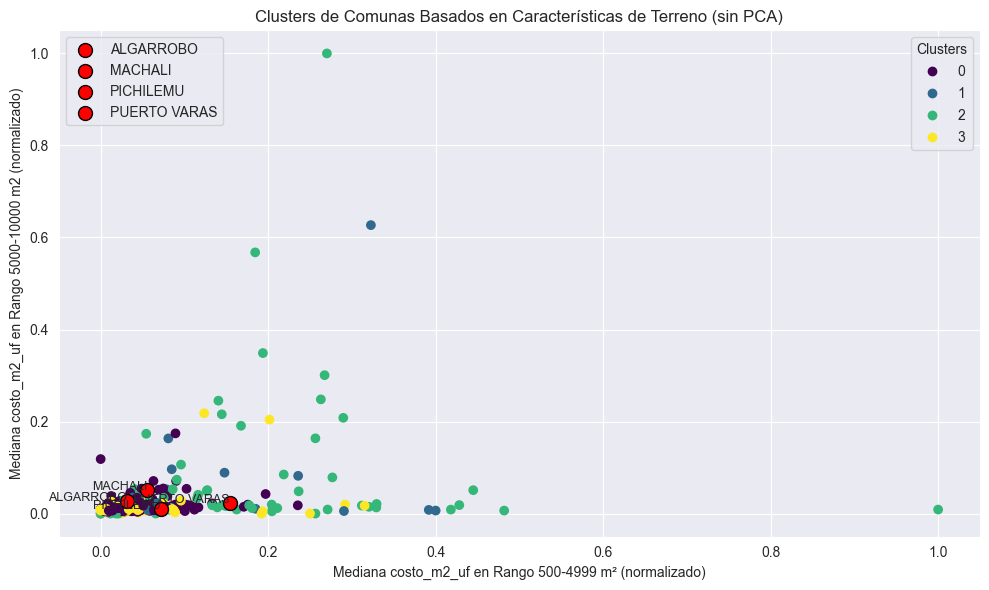


Pesos de cada variable en el clustering (valores de los centroides):
   Total de Datos  % 500-4999 m2  % 5000-10000 m2  % 10001-100000 m2  \
0        0.105138       0.130950         0.615532           0.229656   
1        0.068469       0.391293         0.265864           0.167881   
2        0.101785       0.526658         0.173081           0.154108   
3        0.020964       0.138740         0.350617           0.477871   

   % >100000 m2  Mediana costo_m2_uf 500-4999 m2  \
0      0.128405                         0.041717   
1      0.064680                         0.142430   
2      0.046366                         0.166943   
3      0.318569                         0.044405   

   Mediana costo_m2_uf 5000-10000 m2  Mediana costo_m2_uf 10001-100000 m2  \
0                           0.016208                             0.011546   
1                           0.074408                             0.039095   
2                           0.076570                             0.027827   


In [61]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total de Datos',
    '% 500-4999 m2', '% 5000-10000 m2', '% 10001-100000 m2', '% >100000 m2',
    'Mediana costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
    'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando RobustScaler (en lugar de StandardScaler)
#scaler = RobustScaler()
scaler = MinMaxScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['Mediana costo_m2_uf 500-4999 m2'], X_normalizado['Mediana costo_m2_uf 5000-10000 m2'],
                      c=data_estadisticos['cluster'], cmap='viridis')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 500-4999 m2'], 
                        X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 5000-10000 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('Mediana costo_m2_uf en Rango 500-4999 m² (normalizado)')
plt.ylabel('Mediana costo_m2_uf en Rango 5000-10000 m2 (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 8: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

Silhouette Score para el modelo: 0.2921


C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


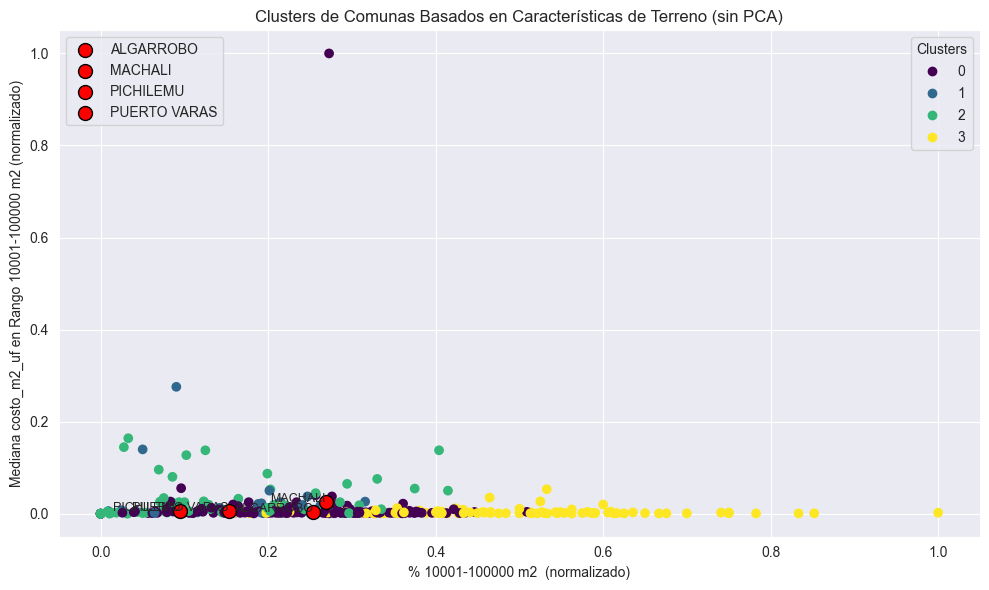


Pesos de cada variable en el clustering (valores de los centroides):
   Total de Datos  % 500-4999 m2  % 5000-10000 m2  % 10001-100000 m2  \
0        0.105138       0.130950         0.615532           0.229656   
1        0.068469       0.391293         0.265864           0.167881   
2        0.101785       0.526658         0.173081           0.154108   
3        0.020964       0.138740         0.350617           0.477871   

   % >100000 m2  Mediana costo_m2_uf 500-4999 m2  \
0      0.128405                         0.041717   
1      0.064680                         0.142430   
2      0.046366                         0.166943   
3      0.318569                         0.044405   

   Mediana costo_m2_uf 5000-10000 m2  Mediana costo_m2_uf 10001-100000 m2  \
0                           0.016208                             0.011546   
1                           0.074408                             0.039095   
2                           0.076570                             0.027827   


In [62]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total de Datos',
    '% 500-4999 m2', '% 5000-10000 m2', '% 10001-100000 m2', '% >100000 m2',
    'Mediana costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
    'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando RobustScaler (en lugar de StandardScaler)
scaler = MinMaxScaler()
#scaler = RobustScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['% 10001-100000 m2'], X_normalizado['Mediana costo_m2_uf 10001-100000 m2'],
                      c=data_estadisticos['cluster'], cmap='viridis')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, '% 10001-100000 m2'], 
                        X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 10001-100000 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('% 10001-100000 m2  (normalizado)')
plt.ylabel('Mediana costo_m2_uf en Rango 10001-100000 m2 (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 8: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

Silhouette Score para el modelo: 0.2921


C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


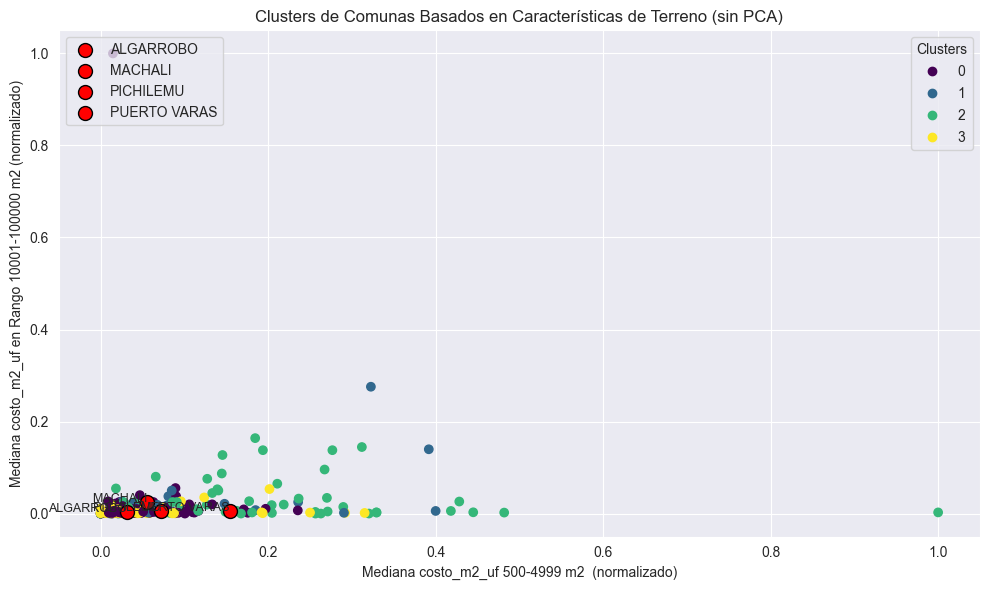


Pesos de cada variable en el clustering (valores de los centroides):
   Total de Datos  % 500-4999 m2  % 5000-10000 m2  % 10001-100000 m2  \
0        0.105138       0.130950         0.615532           0.229656   
1        0.068469       0.391293         0.265864           0.167881   
2        0.101785       0.526658         0.173081           0.154108   
3        0.020964       0.138740         0.350617           0.477871   

   % >100000 m2  Mediana costo_m2_uf 500-4999 m2  \
0      0.128405                         0.041717   
1      0.064680                         0.142430   
2      0.046366                         0.166943   
3      0.318569                         0.044405   

   Mediana costo_m2_uf 5000-10000 m2  Mediana costo_m2_uf 10001-100000 m2  \
0                           0.016208                             0.011546   
1                           0.074408                             0.039095   
2                           0.076570                             0.027827   


In [63]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total de Datos',
             '% 500-4999 m2', '% 5000-10000 m2', '% 10001-100000 m2', '% >100000 m2',
    'Mediana costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
    'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando RobustScaler (en lugar de StandardScaler)
#scaler = RobustScaler()
scaler = MinMaxScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['Mediana costo_m2_uf 500-4999 m2'], X_normalizado['Mediana costo_m2_uf 10001-100000 m2'],
                      c=data_estadisticos['cluster'], cmap='viridis')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 500-4999 m2'], 
                        X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 10001-100000 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('Mediana costo_m2_uf 500-4999 m2  (normalizado)')
plt.ylabel('Mediana costo_m2_uf en Rango 10001-100000 m2 (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 8: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

# Clusterización N datos

In [64]:
# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')
print(data_estadisticos.columns)

Index(['comuna_match', 'Total de Datos', 'Total 100-499 m2', '% 100-499 m2',
       'Total 500-4999 m2', '% 500-4999 m2', 'Total 5000-10000 m2',
       '% 5000-10000 m2', 'Total 10001-100000 m2', '% 10001-100000 m2',
       'Total >100000 m2', '% >100000 m2', 'Mediana costo_m2_uf 100-499 m2',
       'Media costo_m2_uf 100-499 m2', 'Desviación costo_m2_uf 100-499 m2',
       'Mínimo costo_m2_uf 100-499 m2', 'Máximo costo_m2_uf 100-499 m2',
       'IQR costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
       'Media costo_m2_uf 500-4999 m2', 'Desviación costo_m2_uf 500-4999 m2',
       'Mínimo costo_m2_uf 500-4999 m2', 'Máximo costo_m2_uf 500-4999 m2',
       'IQR costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
       'Media costo_m2_uf 5000-10000 m2',
       'Desviación costo_m2_uf 5000-10000 m2',
       'Mínimo costo_m2_uf 5000-10000 m2', 'Máximo costo_m2_uf 5000-10000 m2',
       'IQR costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2',
       'Me

### PCA y Normalizer

Varianzas explicadas por cada componente principal:
PC1: 0.5120
PC2: 0.2092
PC3: 0.1305
PC4: 0.0598
PC5: 0.0533

Cargas de los Componentes Principales:
     Total 100-499 m2  Total 500-4999 m2  Total 5000-10000 m2  \
PC1         -0.244206          -0.611448             0.726396   
PC2         -0.056687          -0.536751            -0.367084   
PC3         -0.018361           0.137995            -0.102645   
PC4         -0.437441          -0.119305            -0.217391   
PC5          0.837865          -0.374557            -0.059416   

     Total 10001-100000 m2  Mediana costo_m2_uf 100-499 m2  \
PC1               0.109617                       -0.122634   
PC2               0.272599                        0.676139   
PC3               0.930228                       -0.267529   
PC4              -0.007471                       -0.463328   
PC5               0.012613                       -0.328163   

     Mediana costo_m2_uf 500-4999 m2  Mediana costo_m2_uf 5000-10000 m2  \
PC1      

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than ava

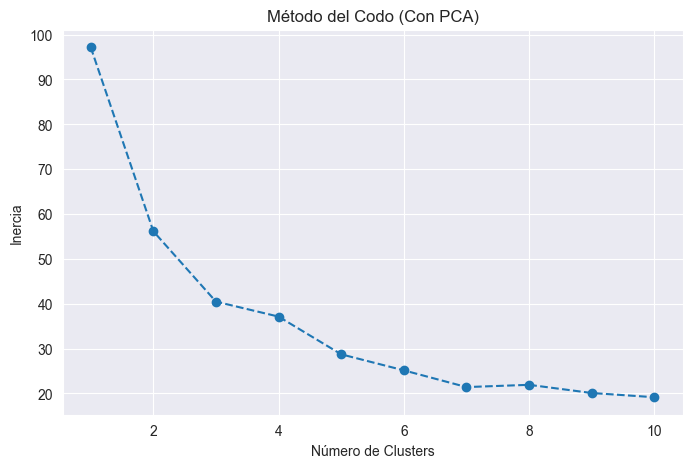

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



Silhouette Score para el modelo: 0.5127


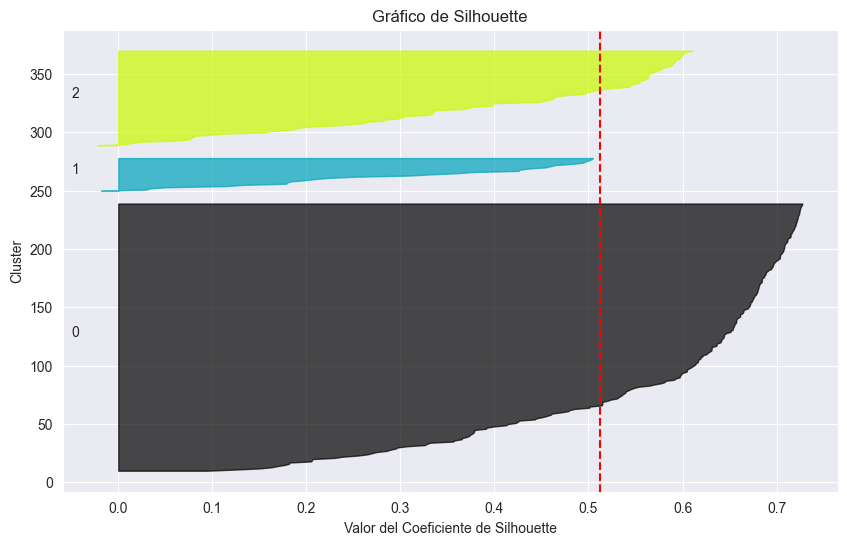


Clusters de las comunas seleccionadas:
Comuna ALGARROBO pertenece al cluster 0
Comuna PUERTO VARAS pertenece al cluster 0
Comuna MACHALI pertenece al cluster 2
Comuna PICHILEMU pertenece al cluster 0


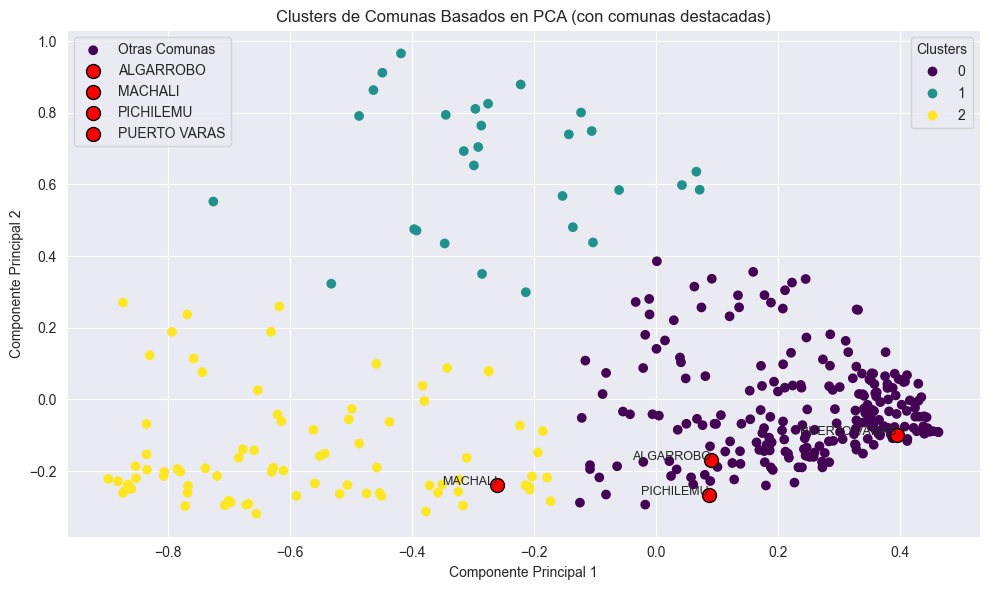


Características promedio por cluster:
         Total de Datos  Total 100-499 m2  % 100-499 m2  Total 500-4999 m2  \
cluster                                                                      
0            610.895652         31.800000      5.128093          92.330435   
1             34.103448          2.379310     13.189662           4.965517   
2            716.768293        113.878049     18.517399         360.073171   

         % 500-4999 m2  Total 5000-10000 m2  % 5000-10000 m2  \
cluster                                                        
0            12.855687           360.856522        55.392090   
1            20.554195            13.586207        27.903988   
2            49.093620           151.048780        17.941431   

         Total 10001-100000 m2  % 10001-100000 m2  Total >100000 m2  ...  \
cluster                                                              ...   
0                    96.326087          19.535740         29.582609  ...   
1                    

In [65]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Eliminar la columna "Unnamed: 0" si existe
if 'Unnamed: 0' in data_estadisticos.columns:
    data_estadisticos = data_estadisticos.drop(columns=['Unnamed: 0'])

# Paso 2: Seleccionar las variables relevantes para el clustering
variables_clustering = [
    'Total 100-499 m2','Total 500-4999 m2','Total 5000-10000 m2','Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
    'Mediana costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando Normalizer
scaler = Normalizer()
#scaler = MinMaxScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 4: Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=5)  # Reducir a 5 componentes principales
X_pca = pca.fit_transform(X_normalizado)

# Imprimir las varianzas explicadas por cada componente principal
varianzas_explicadas = pca.explained_variance_ratio_
print("Varianzas explicadas por cada componente principal:")
for i, varianza in enumerate(varianzas_explicadas):
    print(f"PC{i + 1}: {varianza:.4f}")

# Imprimir las cargas de los componentes principales
cargas_componentes = pd.DataFrame(pca.components_, columns=variables_clustering,
                                  index=[f'PC{i + 1}' for i in range(pca.n_components_)])
print("\nCargas de los Componentes Principales:")
print(cargas_componentes)

# Paso 5: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo (Con PCA)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

# Paso 6: Aplicar K-means con el número óptimo de clusters
kmeans = KMeans(n_clusters=3, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_pca)

# Calcular el silhouette score para evaluar la calidad de la agrupación
silhouette_avg = silhouette_score(X_pca, data_estadisticos['cluster'])
print(f"\nSilhouette Score para el modelo: {silhouette_avg:.4f}")

# Graficar el Silhouette Score para cada punto
sample_silhouette_values = silhouette_samples(X_pca, data_estadisticos['cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(3):
    ith_cluster_silhouette_values = sample_silhouette_values[data_estadisticos['cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / 3)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10  # 10 for the 0 samples gap between silhouette plots

plt.title("Gráfico de Silhouette")
plt.xlabel("Valor del Coeficiente de Silhouette")
plt.ylabel("Cluster")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.grid(True)
plt.show()

# Paso 7: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['ALGARROBO', 'PUERTO VARAS', 'MACHALI','PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Mostrar a qué cluster pertenecen las comunas seleccionadas
print("\nClusters de las comunas seleccionadas:")
for comuna in comunas_a_marcar:
    cluster_comuna = data_estadisticos[data_estadisticos['comuna_match'] == comuna]['cluster'].values[0]
    print(f"Comuna {comuna} pertenece al cluster {cluster_comuna}")

# Paso 8: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_estadisticos['cluster'], cmap='viridis', label='Otras Comunas')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_pca[pos_comunas.index, 0], X_pca[pos_comunas.index, 1]):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir la leyenda con los clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
plt.gca().add_artist(legend1)

# Añadir la leyenda de las comunas destacadas
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en PCA (con comunas destacadas)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 9: Mostrar las características promedio por cluster (solo columnas numéricas)
print("\nCaracterísticas promedio por cluster:")
columnas_numericas = data_estadisticos.select_dtypes(include=['float64', 'int64']).columns
caracteristicas_cluster = data_estadisticos.groupby('cluster')[columnas_numericas].mean()
print(caracteristicas_cluster)

print("\nCaracterísticas mediana por cluster:")
caracteristicas_cluster_median = data_estadisticos.groupby('cluster')[columnas_numericas].median()
print(caracteristicas_cluster_median)


### Normalizer sin PCA (N° datos en vez de %)

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than ava

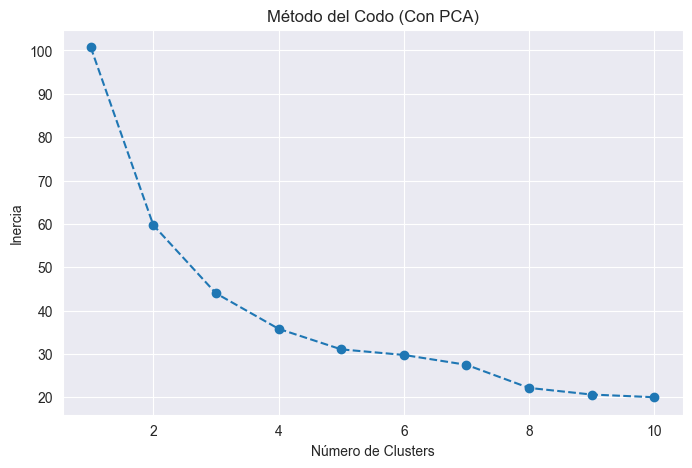

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


Silhouette Score para el modelo: 0.3769


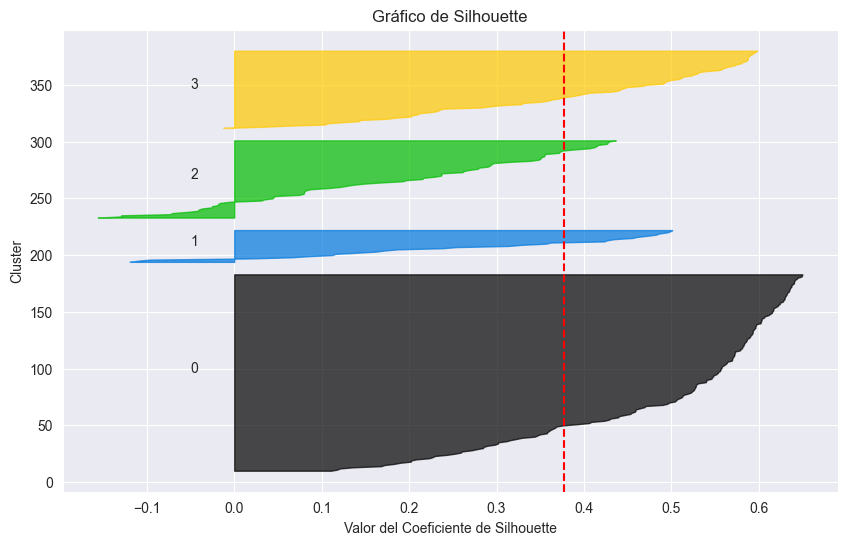

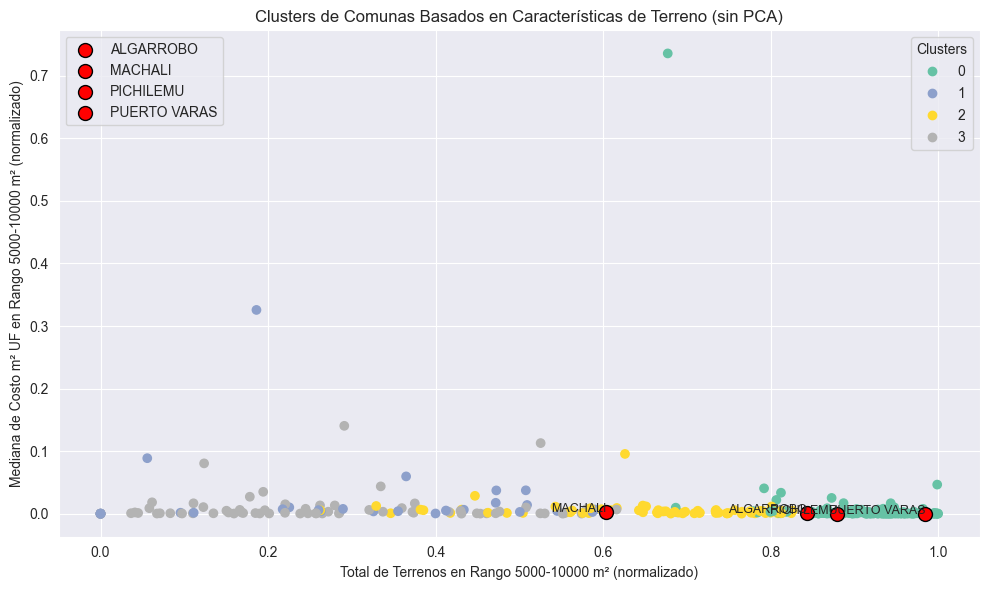


Pesos de cada variable en el clustering (valores de los centroides):
   Total 100-499 m2  Total 500-4999 m2  Total 5000-10000 m2  \
0          0.079221           0.185523             0.916687   
1          0.123355           0.168361             0.282110   
2          0.124302           0.361634             0.659282   
3          0.324435           0.796097             0.269794   

   Total 10001-100000 m2  Mediana costo_m2_uf 100-499 m2  \
0               0.250722                        0.048224   
1               0.299128                        0.648125   
2               0.551056                        0.065952   
3               0.173067                        0.077565   

   Mediana costo_m2_uf 500-4999 m2  Mediana costo_m2_uf 5000-10000 m2  \
0                         0.020587                           0.006837   
1                         0.246537                           0.022559   
2                         0.024841                           0.005342   
3                    

In [66]:

import pandas as pd
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total 100-499 m2','Total 500-4999 m2','Total 5000-10000 m2','Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
    'Mediana costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando StandardScaler
scaler = Normalizer()
#scaler = StandardScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 4: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_normalizado)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo (Con PCA)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()


# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Graficar el Silhouette Score para cada punto
sample_silhouette_values = silhouette_samples(X_pca, data_estadisticos['cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(4):
    ith_cluster_silhouette_values = sample_silhouette_values[data_estadisticos['cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / 4)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10  # 10 for the 0 samples gap between silhouette plots

plt.title("Gráfico de Silhouette")
plt.xlabel("Valor del Coeficiente de Silhouette")
plt.ylabel("Cluster")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.grid(True)
plt.show()


# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['Total 5000-10000 m2'], X_normalizado['Mediana costo_m2_uf 5000-10000 m2'],
                      c=data_estadisticos['cluster'], cmap='Set2')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, 'Total 5000-10000 m2'], 
                        X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 5000-10000 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('Total de Terrenos en Rango 5000-10000 m² (normalizado)')
plt.ylabel('Mediana de Costo m² UF en Rango 5000-10000 m² (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Paso 7: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)


Silhouette Score para el modelo: 0.3769


C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


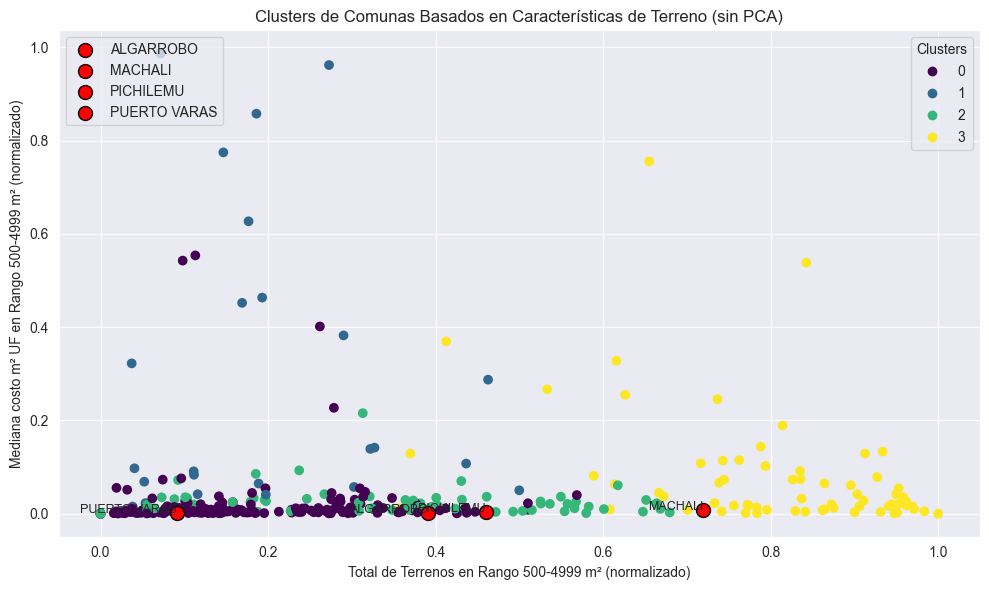


Pesos de cada variable en el clustering (valores de los centroides):
   Total 100-499 m2  Total 500-4999 m2  Total 5000-10000 m2  \
0          0.079221           0.185523             0.916687   
1          0.123355           0.168361             0.282110   
2          0.124302           0.361634             0.659282   
3          0.324435           0.796097             0.269794   

   Total 10001-100000 m2  Mediana costo_m2_uf 100-499 m2  \
0               0.250722                        0.048224   
1               0.299128                        0.648125   
2               0.551056                        0.065952   
3               0.173067                        0.077565   

   Mediana costo_m2_uf 500-4999 m2  Mediana costo_m2_uf 5000-10000 m2  \
0                         0.020587                           0.006837   
1                         0.246537                           0.022559   
2                         0.024841                           0.005342   
3                    

In [67]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total 100-499 m2','Total 500-4999 m2','Total 5000-10000 m2','Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
    'Mediana costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando RobustScaler (en lugar de StandardScaler)
scaler = Normalizer()
#scaler = MinMaxScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['Total 500-4999 m2'], X_normalizado['Mediana costo_m2_uf 500-4999 m2'],
                      c=data_estadisticos['cluster'], cmap='viridis')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, 'Total 500-4999 m2'], 
                        X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 500-4999 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('Total de Terrenos en Rango 500-4999 m² (normalizado)')
plt.ylabel('Mediana costo m² UF en Rango 500-4999 m² (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 8: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

# Paso 9: Guardar los resultados con clustering en un archivo CSV
# data_estadisticos.to_csv('data recuperada/estadisticos_por_comuna_con_clusters_sin_PCA.csv', index=False)


Silhouette Score para el modelo: 0.3769


C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


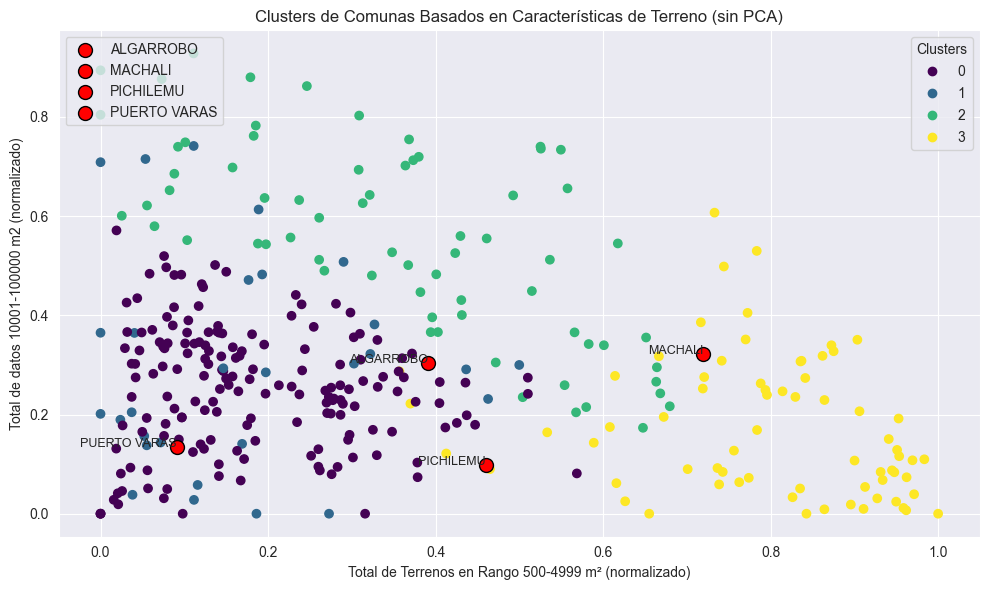


Pesos de cada variable en el clustering (valores de los centroides):
   Total 100-499 m2  Total 500-4999 m2  Total 5000-10000 m2  \
0          0.079221           0.185523             0.916687   
1          0.123355           0.168361             0.282110   
2          0.124302           0.361634             0.659282   
3          0.324435           0.796097             0.269794   

   Total 10001-100000 m2  Mediana costo_m2_uf 100-499 m2  \
0               0.250722                        0.048224   
1               0.299128                        0.648125   
2               0.551056                        0.065952   
3               0.173067                        0.077565   

   Mediana costo_m2_uf 500-4999 m2  Mediana costo_m2_uf 5000-10000 m2  \
0                         0.020587                           0.006837   
1                         0.246537                           0.022559   
2                         0.024841                           0.005342   
3                    

In [68]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total 100-499 m2','Total 500-4999 m2','Total 5000-10000 m2','Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
    'Mediana costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando RobustScaler (en lugar de StandardScaler)
scaler = Normalizer()
#scaler = MinMaxScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['Total 500-4999 m2'], X_normalizado['Total 10001-100000 m2'],
                      c=data_estadisticos['cluster'], cmap='viridis')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, 'Total 500-4999 m2'], 
                        X_normalizado.loc[pos_comunas.index, 'Total 10001-100000 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('Total de Terrenos en Rango 500-4999 m² (normalizado)')
plt.ylabel('Total de datos 10001-100000 m2 (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 8: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

# Paso 9: Guardar los resultados con clustering en un archivo CSV
# data_estadisticos.to_csv('data recuperada/estadisticos_por_comuna_con_clusters_sin_PCA.csv', index=False)


C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


Silhouette Score para el modelo: 0.3769


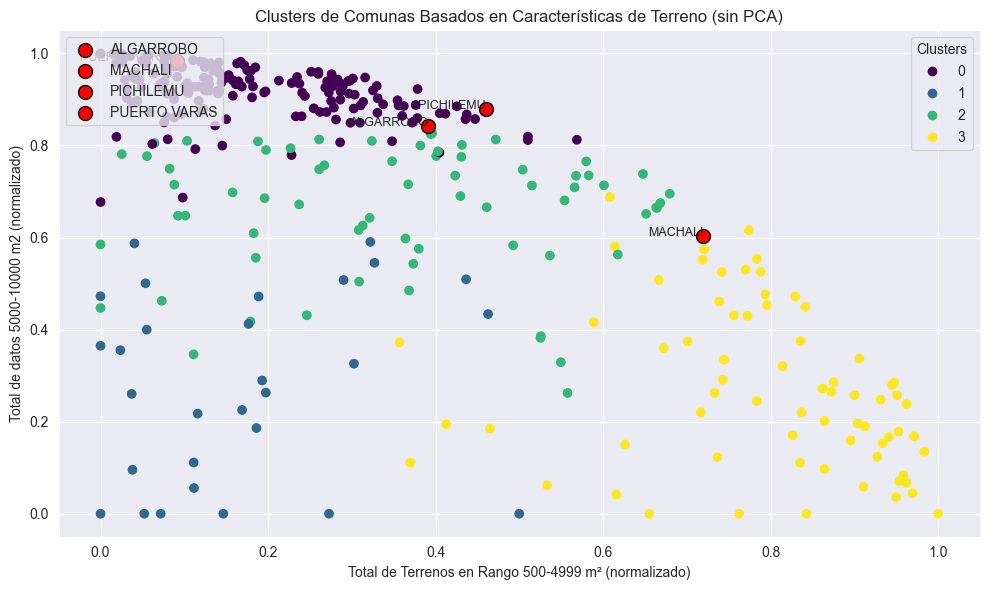


Pesos de cada variable en el clustering (valores de los centroides):
   Total 100-499 m2  Total 500-4999 m2  Total 5000-10000 m2  \
0          0.079221           0.185523             0.916687   
1          0.123355           0.168361             0.282110   
2          0.124302           0.361634             0.659282   
3          0.324435           0.796097             0.269794   

   Total 10001-100000 m2  Mediana costo_m2_uf 100-499 m2  \
0               0.250722                        0.048224   
1               0.299128                        0.648125   
2               0.551056                        0.065952   
3               0.173067                        0.077565   

   Mediana costo_m2_uf 500-4999 m2  Mediana costo_m2_uf 5000-10000 m2  \
0                         0.020587                           0.006837   
1                         0.246537                           0.022559   
2                         0.024841                           0.005342   
3                    

In [69]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total 100-499 m2','Total 500-4999 m2','Total 5000-10000 m2','Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
    'Mediana costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando RobustScaler (en lugar de StandardScaler)
scaler = Normalizer()
#scaler = MinMaxScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['Total 500-4999 m2'], X_normalizado['Total 5000-10000 m2'],
                      c=data_estadisticos['cluster'], cmap='viridis')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, 'Total 500-4999 m2'], 
                        X_normalizado.loc[pos_comunas.index, 'Total 5000-10000 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('Total de Terrenos en Rango 500-4999 m² (normalizado)')
plt.ylabel('Total de datos 5000-10000 m2 (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 8: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

# Paso 9: Guardar los resultados con clustering en un archivo CSV
# data_estadisticos.to_csv('data recuperada/estadisticos_por_comuna_con_clusters_sin_PCA.csv', index=False)

Silhouette Score para el modelo: 0.3769


C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


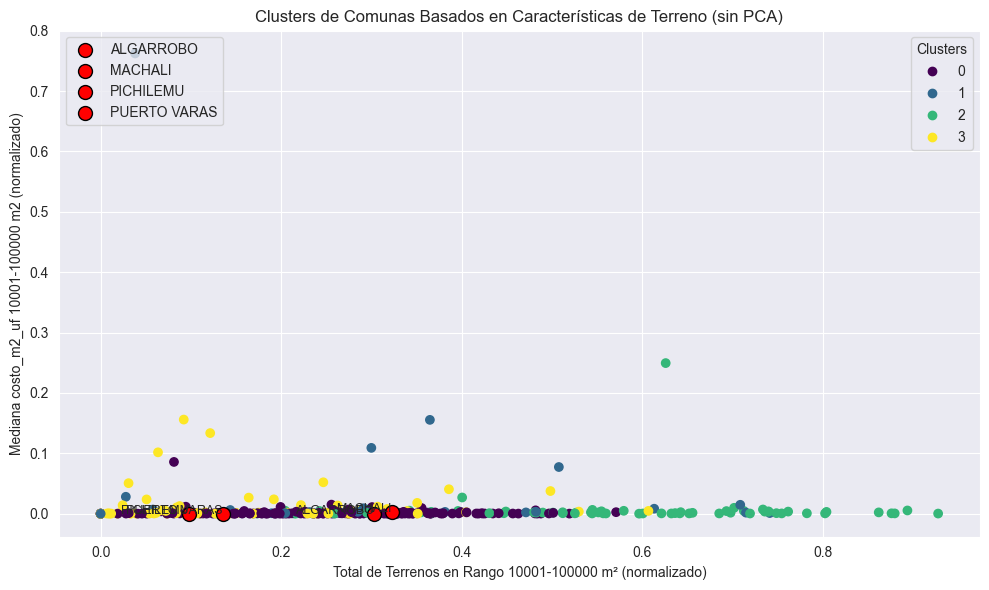


Pesos de cada variable en el clustering (valores de los centroides):
   Total 100-499 m2  Total 500-4999 m2  Total 5000-10000 m2  \
0          0.079221           0.185523             0.916687   
1          0.123355           0.168361             0.282110   
2          0.124302           0.361634             0.659282   
3          0.324435           0.796097             0.269794   

   Total 10001-100000 m2  Mediana costo_m2_uf 100-499 m2  \
0               0.250722                        0.048224   
1               0.299128                        0.648125   
2               0.551056                        0.065952   
3               0.173067                        0.077565   

   Mediana costo_m2_uf 500-4999 m2  Mediana costo_m2_uf 5000-10000 m2  \
0                         0.020587                           0.006837   
1                         0.246537                           0.022559   
2                         0.024841                           0.005342   
3                    

In [70]:

import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total 100-499 m2', 'Total 500-4999 m2', 'Total 5000-10000 m2', 'Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
    'Mediana costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando RobustScaler (en lugar de StandardScaler)
scaler = Normalizer()
#scaler = MinMaxScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['Total 10001-100000 m2'], X_normalizado['Mediana costo_m2_uf 10001-100000 m2'],
                      c=data_estadisticos['cluster'], cmap='viridis')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, 'Total 10001-100000 m2'],
                        X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 10001-100000 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('Total de Terrenos en Rango 10001-100000 m² (normalizado)')
plt.ylabel('Mediana costo_m2_uf 10001-100000 m2 (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 8: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

# Paso 9: Guardar los resultados con clustering en un archivo CSV
# data_estadisticos.to_csv('data recuperada/estadisticos_por_comuna_con_clusters_sin_PCA.csv', index=False)

### MinMaxScale y PCA

Varianzas explicadas por cada componente principal:
PC1: 0.4690
PC2: 0.1637
PC3: 0.1259
PC4: 0.0648
PC5: 0.0515

Cargas de los Componentes Principales:
     Total 100-499 m2  Total 500-4999 m2  Total 5000-10000 m2  \
PC1          0.538135           0.478052             0.437963   
PC2          0.255691           0.224096            -0.362305   
PC3         -0.303371          -0.177238             0.245495   
PC4         -0.432506          -0.175759             0.310263   
PC5         -0.147459           0.469356            -0.190907   

     Total 10001-100000 m2  Mediana costo_m2_uf 100-499 m2  \
PC1               0.521296                        0.024962   
PC2              -0.357428                        0.044673   
PC3               0.239153                       -0.018732   
PC4               0.208213                        0.191022   
PC5              -0.029491                       -0.042608   

     Mediana costo_m2_uf 500-4999 m2  Mediana costo_m2_uf 5000-10000 m2  \
PC1      

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than ava

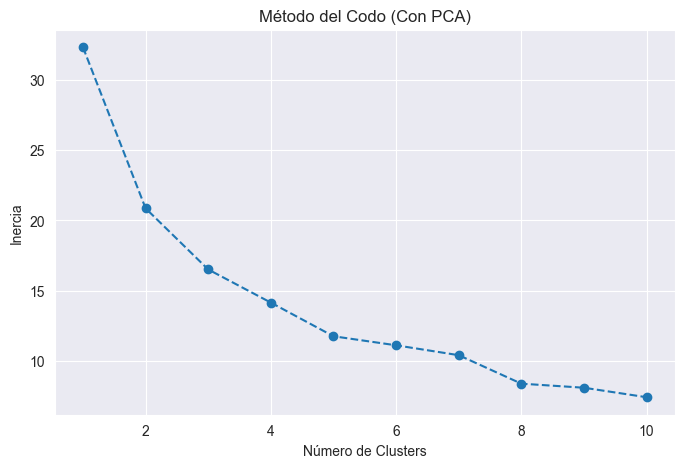

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



Silhouette Score para el modelo: 0.5078


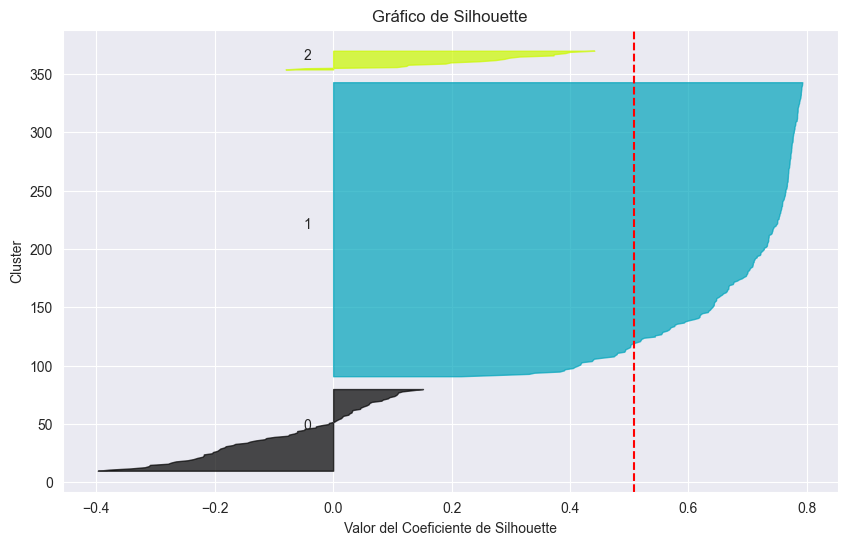


Clusters de las comunas seleccionadas:
Comuna ALGARROBO pertenece al cluster 0
Comuna PUERTO VARAS pertenece al cluster 2
Comuna MACHALI pertenece al cluster 0
Comuna PICHILEMU pertenece al cluster 0


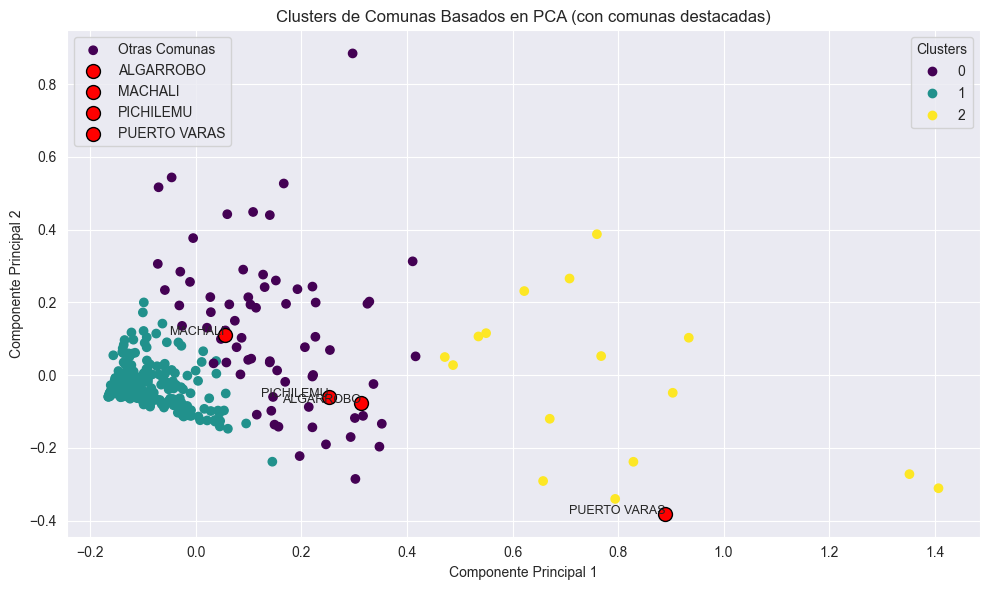


Características promedio por cluster:
         Total de Datos  Total 100-499 m2  % 100-499 m2  Total 500-4999 m2  \
cluster                                                                      
0           1024.845070        106.309859     14.331250         329.591549   
1            260.482213         13.332016      7.407217          36.474308   
2           3623.764706        341.176471     11.108462        1075.117647   

         % 500-4999 m2  Total 5000-10000 m2  % 5000-10000 m2  \
cluster                                                        
0            36.042615           419.633803        34.114187   
1            17.578739           145.731225        46.987389   
2            33.653517          1712.529412        41.804523   

         Total 10001-100000 m2  % 10001-100000 m2  Total >100000 m2  ...  \
cluster                                                              ...   
0                   136.154930          12.560968         33.154930  ...   
1                    

In [71]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Eliminar la columna "Unnamed: 0" si existe
if 'Unnamed: 0' in data_estadisticos.columns:
    data_estadisticos = data_estadisticos.drop(columns=['Unnamed: 0'])

# Paso 2: Seleccionar las variables relevantes para el clustering
variables_clustering = [
    'Total 100-499 m2', 'Total 500-4999 m2', 'Total 5000-10000 m2', 'Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
    'Mediana costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando Normalizer
#scaler = Normalizer()
scaler = MinMaxScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 4: Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=5)  # Reducir a 5 componentes principales
X_pca = pca.fit_transform(X_normalizado)

# Imprimir las varianzas explicadas por cada componente principal
varianzas_explicadas = pca.explained_variance_ratio_
print("Varianzas explicadas por cada componente principal:")
for i, varianza in enumerate(varianzas_explicadas):
    print(f"PC{i + 1}: {varianza:.4f}")

# Imprimir las cargas de los componentes principales
cargas_componentes = pd.DataFrame(pca.components_, columns=variables_clustering,
                                  index=[f'PC{i + 1}' for i in range(pca.n_components_)])
print("\nCargas de los Componentes Principales:")
print(cargas_componentes)

# Paso 5: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo (Con PCA)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

# Paso 6: Aplicar K-means con el número óptimo de clusters
kmeans = KMeans(n_clusters=3, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_pca)

# Calcular el silhouette score para evaluar la calidad de la agrupación
silhouette_avg = silhouette_score(X_pca, data_estadisticos['cluster'])
print(f"\nSilhouette Score para el modelo: {silhouette_avg:.4f}")

# Graficar el Silhouette Score para cada punto
sample_silhouette_values = silhouette_samples(X_pca, data_estadisticos['cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(3):
    ith_cluster_silhouette_values = sample_silhouette_values[data_estadisticos['cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / 3)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color,
                      alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10 for the 0 samples gap between silhouette plots

plt.title("Gráfico de Silhouette")
plt.xlabel("Valor del Coeficiente de Silhouette")
plt.ylabel("Cluster")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.grid(True)
plt.show()

# Paso 7: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['ALGARROBO', 'PUERTO VARAS', 'MACHALI', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Mostrar a qué cluster pertenecen las comunas seleccionadas
print("\nClusters de las comunas seleccionadas:")
for comuna in comunas_a_marcar:
    cluster_comuna = data_estadisticos[data_estadisticos['comuna_match'] == comuna]['cluster'].values[0]
    print(f"Comuna {comuna} pertenece al cluster {cluster_comuna}")

# Paso 8: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_estadisticos['cluster'], cmap='viridis', label='Otras Comunas')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_pca[pos_comunas.index, 0], X_pca[pos_comunas.index, 1]):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir la leyenda con los clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
plt.gca().add_artist(legend1)

# Añadir la leyenda de las comunas destacadas
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en PCA (con comunas destacadas)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 9: Mostrar las características promedio por cluster (solo columnas numéricas)
print("\nCaracterísticas promedio por cluster:")
columnas_numericas = data_estadisticos.select_dtypes(include=['float64', 'int64']).columns
caracteristicas_cluster = data_estadisticos.groupby('cluster')[columnas_numericas].mean()
print(caracteristicas_cluster)

print("\nCaracterísticas mediana por cluster:")
caracteristicas_cluster_median = data_estadisticos.groupby('cluster')[columnas_numericas].median()
print(caracteristicas_cluster_median)


### MinMax sin PCA

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than ava

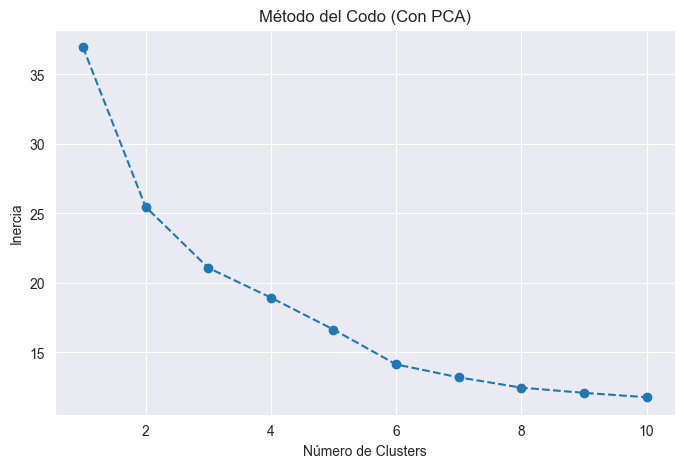

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


Silhouette Score para el modelo: 0.4764


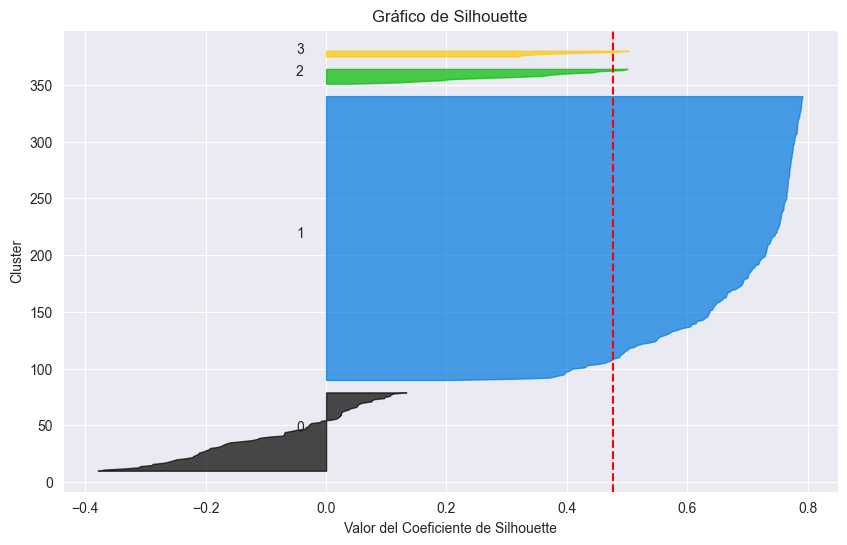

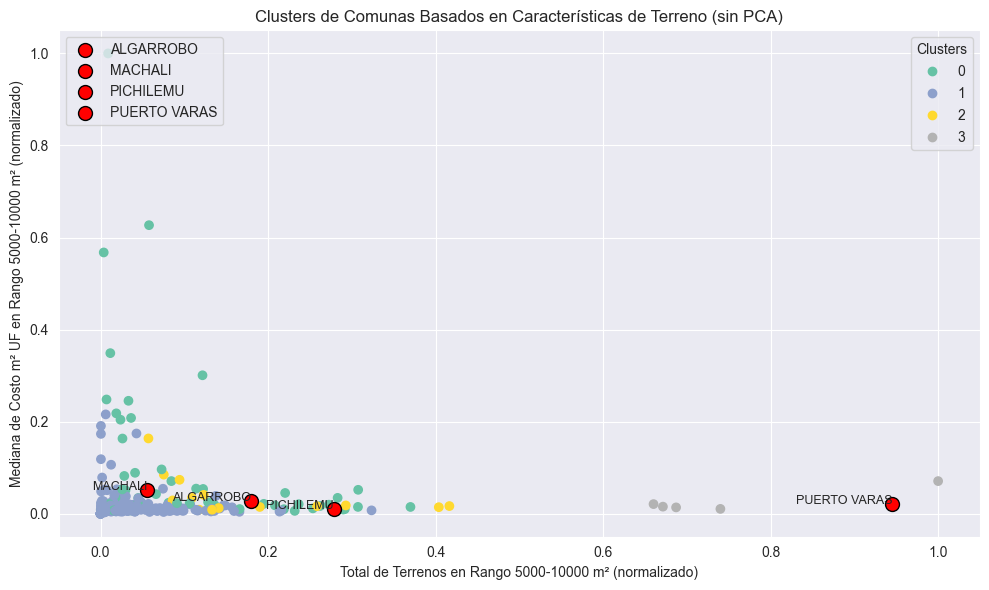


Pesos de cada variable en el clustering (valores de los centroides):
   Total 100-499 m2  Total 500-4999 m2  Total 5000-10000 m2  \
0          0.155919           0.123667             0.098131   
1          0.020690           0.015692             0.034853   
2          0.522919           0.500525             0.178512   
3          0.436137           0.400994             0.783973   

   Total 10001-100000 m2  Mediana costo_m2_uf 100-499 m2  \
0               0.153028                        0.038050   
1               0.055520                        0.025771   
2               0.303901                        0.036263   
3               0.708909                        0.046740   

   Mediana costo_m2_uf 500-4999 m2  Mediana costo_m2_uf 5000-10000 m2  \
0                         0.160268                           0.080804   
1                         0.043418                           0.015943   
2                         0.132802                           0.038270   
3                    

In [72]:

import pandas as pd
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total 100-499 m2','Total 500-4999 m2','Total 5000-10000 m2','Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
    'Mediana costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando StandardScaler
scaler = MinMaxScaler()
#scaler = StandardScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 4: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_normalizado)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo (Con PCA)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()


# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Graficar el Silhouette Score para cada punto
sample_silhouette_values = silhouette_samples(X_pca, data_estadisticos['cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(4):
    ith_cluster_silhouette_values = sample_silhouette_values[data_estadisticos['cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / 4)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10  # 10 for the 0 samples gap between silhouette plots

plt.title("Gráfico de Silhouette")
plt.xlabel("Valor del Coeficiente de Silhouette")
plt.ylabel("Cluster")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.grid(True)
plt.show()


# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['Total 5000-10000 m2'], X_normalizado['Mediana costo_m2_uf 5000-10000 m2'],
                      c=data_estadisticos['cluster'], cmap='Set2')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, 'Total 5000-10000 m2'], 
                        X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 5000-10000 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('Total de Terrenos en Rango 5000-10000 m² (normalizado)')
plt.ylabel('Mediana de Costo m² UF en Rango 5000-10000 m² (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Paso 7: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

Silhouette Score para el modelo: 0.4764


C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


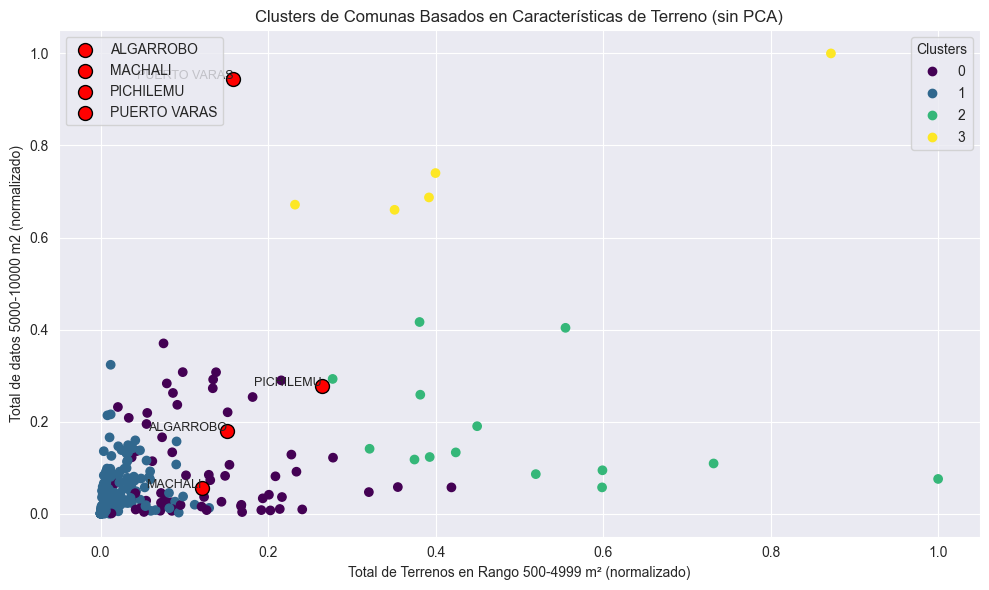


Pesos de cada variable en el clustering (valores de los centroides):
   Total 100-499 m2  Total 500-4999 m2  Total 5000-10000 m2  \
0          0.155919           0.123667             0.098131   
1          0.020690           0.015692             0.034853   
2          0.522919           0.500525             0.178512   
3          0.436137           0.400994             0.783973   

   Total 10001-100000 m2  Mediana costo_m2_uf 100-499 m2  \
0               0.153028                        0.038050   
1               0.055520                        0.025771   
2               0.303901                        0.036263   
3               0.708909                        0.046740   

   Mediana costo_m2_uf 500-4999 m2  Mediana costo_m2_uf 5000-10000 m2  \
0                         0.160268                           0.080804   
1                         0.043418                           0.015943   
2                         0.132802                           0.038270   
3                    

In [73]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total 100-499 m2', 'Total 500-4999 m2', 'Total 5000-10000 m2', 'Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
    'Mediana costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando RobustScaler (en lugar de StandardScaler)
#scaler = Normalizer()
scaler = MinMaxScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['Total 500-4999 m2'], X_normalizado['Total 5000-10000 m2'],
                      c=data_estadisticos['cluster'], cmap='viridis')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, 'Total 500-4999 m2'],
                        X_normalizado.loc[pos_comunas.index, 'Total 5000-10000 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('Total de Terrenos en Rango 500-4999 m² (normalizado)')
plt.ylabel('Total de datos 5000-10000 m2 (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 8: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

# Paso 9: Guardar los resultados con clustering en un archivo CSV
# data_estadisticos.to_csv('data recuperada/estadisticos_por_comuna_con_clusters_sin_PCA.csv', index=False)

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


Silhouette Score para el modelo: 0.4764


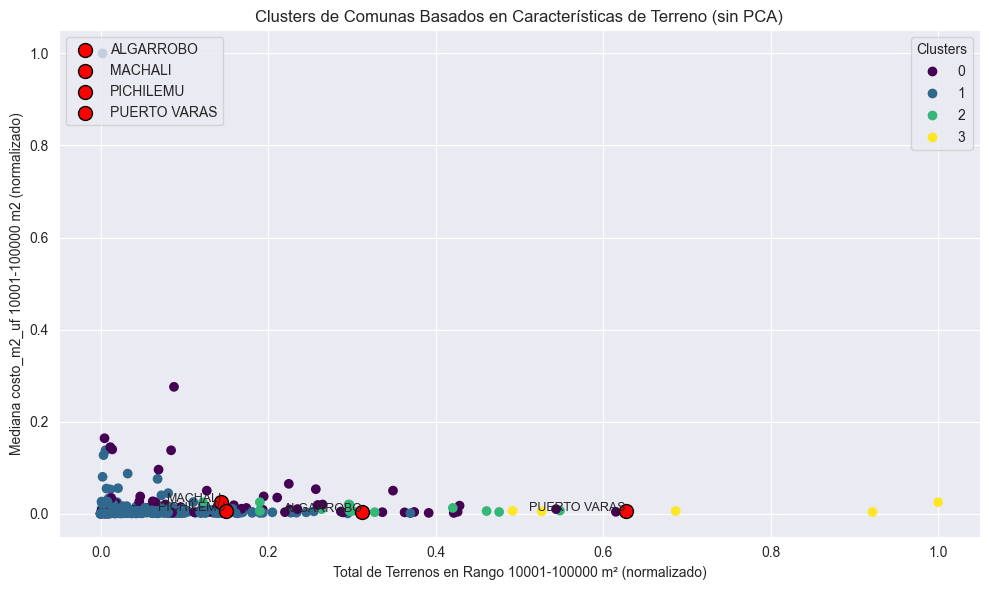


Pesos de cada variable en el clustering (valores de los centroides):
   Total 100-499 m2  Total 500-4999 m2  Total 5000-10000 m2  \
0          0.155919           0.123667             0.098131   
1          0.020690           0.015692             0.034853   
2          0.522919           0.500525             0.178512   
3          0.436137           0.400994             0.783973   

   Total 10001-100000 m2  Mediana costo_m2_uf 100-499 m2  \
0               0.153028                        0.038050   
1               0.055520                        0.025771   
2               0.303901                        0.036263   
3               0.708909                        0.046740   

   Mediana costo_m2_uf 500-4999 m2  Mediana costo_m2_uf 5000-10000 m2  \
0                         0.160268                           0.080804   
1                         0.043418                           0.015943   
2                         0.132802                           0.038270   
3                    

In [74]:

import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total 100-499 m2', 'Total 500-4999 m2', 'Total 5000-10000 m2', 'Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
    'Mediana costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando RobustScaler (en lugar de StandardScaler)
#scaler = Normalizer()
scaler = MinMaxScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['Total 10001-100000 m2'], X_normalizado['Mediana costo_m2_uf 10001-100000 m2'],
                      c=data_estadisticos['cluster'], cmap='viridis')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, 'Total 10001-100000 m2'],
                        X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 10001-100000 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('Total de Terrenos en Rango 10001-100000 m² (normalizado)')
plt.ylabel('Mediana costo_m2_uf 10001-100000 m2 (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 8: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

# Paso 9: Guardar los resultados con clustering en un archivo CSV
# data_estadisticos.to_csv('data recuperada/estadisticos_por_comuna_con_clusters_sin_PCA.csv', index=False)

# Clustering más variables

In [75]:
import pandas as pd
# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

In [76]:
data_estadisticos.columns

Index(['comuna_match', 'Total de Datos', 'Total 100-499 m2', '% 100-499 m2',
       'Total 500-4999 m2', '% 500-4999 m2', 'Total 5000-10000 m2',
       '% 5000-10000 m2', 'Total 10001-100000 m2', '% 10001-100000 m2',
       'Total >100000 m2', '% >100000 m2', 'Mediana costo_m2_uf 100-499 m2',
       'Media costo_m2_uf 100-499 m2', 'Desviación costo_m2_uf 100-499 m2',
       'Mínimo costo_m2_uf 100-499 m2', 'Máximo costo_m2_uf 100-499 m2',
       'IQR costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
       'Media costo_m2_uf 500-4999 m2', 'Desviación costo_m2_uf 500-4999 m2',
       'Mínimo costo_m2_uf 500-4999 m2', 'Máximo costo_m2_uf 500-4999 m2',
       'IQR costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
       'Media costo_m2_uf 5000-10000 m2',
       'Desviación costo_m2_uf 5000-10000 m2',
       'Mínimo costo_m2_uf 5000-10000 m2', 'Máximo costo_m2_uf 5000-10000 m2',
       'IQR costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2',
       'Me

### PCA y Normalizer

Varianzas explicadas por cada componente principal:
PC1: 0.3948
PC2: 0.2468
PC3: 0.1179
PC4: 0.0776
PC5: 0.0426

Cargas de los Componentes Principales:
     Total 100-499 m2  Total 500-4999 m2  Total 5000-10000 m2  \
PC1         -0.115254          -0.257734             0.810665   
PC2          0.216414           0.748310            -0.060454   
PC3         -0.101343          -0.354516            -0.201923   
PC4          0.029707           0.081887            -0.137815   
PC5          0.199628          -0.006278            -0.004263   

     Total 10001-100000 m2  Mediana costo_m2_uf 100-499 m2  \
PC1               0.146154                       -0.113962   
PC2              -0.017305                       -0.124636   
PC3               0.156480                        0.160265   
PC4               0.960667                        0.034753   
PC5              -0.110418                        0.534046   

     Media costo_m2_uf 100-499 m2  Desviación costo_m2_uf 100-499 m2  \
PC1         

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than ava

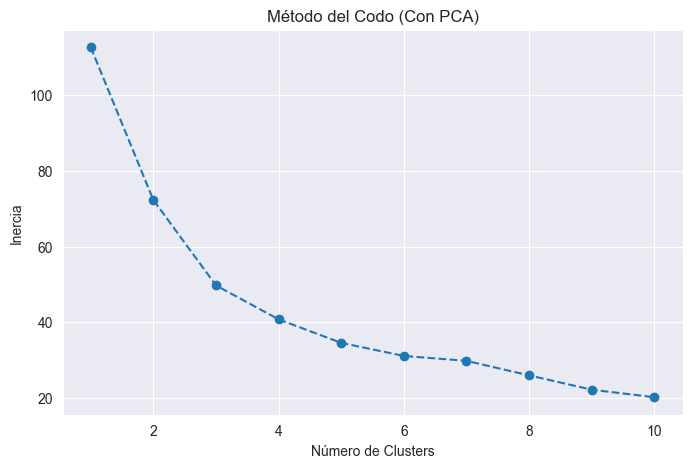

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



Silhouette Score para el modelo: 0.4416


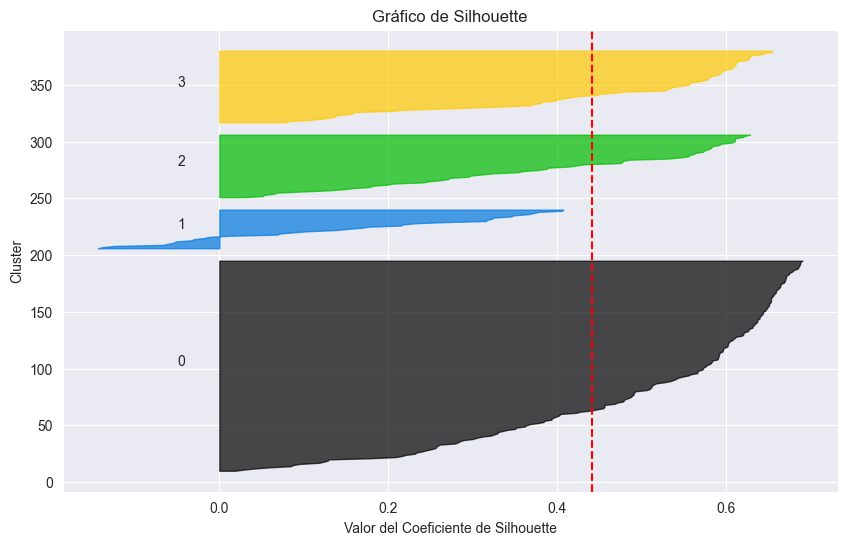


Clusters de las comunas seleccionadas:
Comuna ALGARROBO pertenece al cluster 0
Comuna PUERTO VARAS pertenece al cluster 0
Comuna MACHALI pertenece al cluster 3
Comuna PICHILEMU pertenece al cluster 0


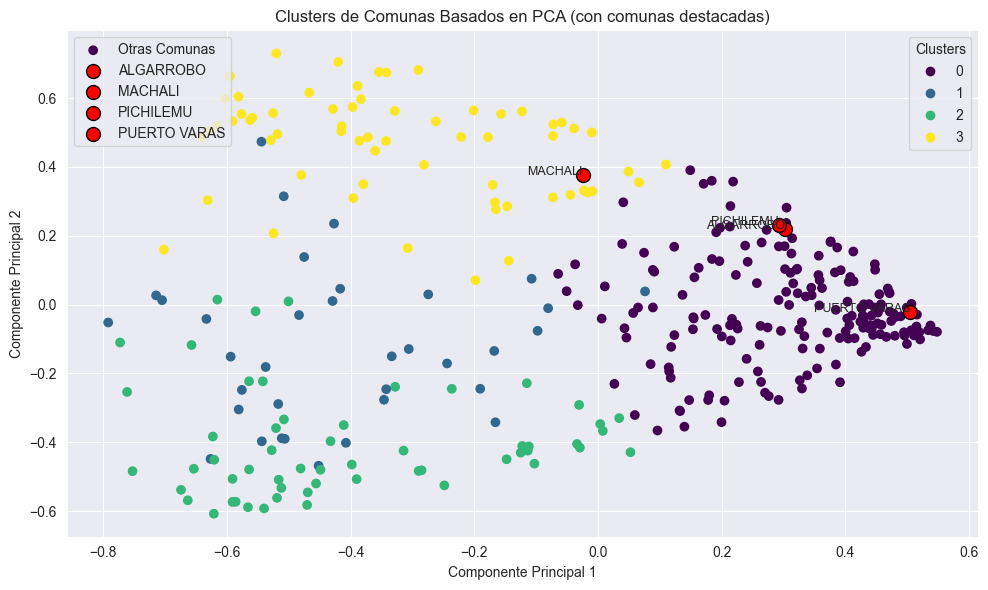


Características promedio por cluster:
         Total de Datos  Total 100-499 m2  % 100-499 m2  Total 500-4999 m2  \
cluster                                                                      
0            709.698925         37.198925      4.871738         107.946237   
1             48.342857          5.914286     12.090386          10.457143   
2            188.000000         12.785714     11.881187          35.196429   
3            875.718750        138.734375     16.964612         445.171875   

         % 500-4999 m2  Total 5000-10000 m2  % 5000-10000 m2  \
cluster                                                        
0            12.731302           422.930108        57.245744   
1            27.072762            13.028571        27.159096   
2            19.310023            85.839286        38.965805   
3            49.712911           185.140625        19.378621   

         Total 10001-100000 m2  % 10001-100000 m2  Total >100000 m2  ...  \
cluster                        

In [93]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Eliminar la columna "Unnamed: 0" si existe
if 'Unnamed: 0' in data_estadisticos.columns:
    data_estadisticos = data_estadisticos.drop(columns=['Unnamed: 0'])

# Paso 2: Seleccionar las variables relevantes para el clustering
variables_clustering = [
    'Total 100-499 m2', 'Total 500-4999 m2', 'Total 5000-10000 m2', 'Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2','Media costo_m2_uf 100-499 m2', 'Desviación costo_m2_uf 100-499 m2',
       'Mínimo costo_m2_uf 100-499 m2', 'Máximo costo_m2_uf 100-499 m2',
       'IQR costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
       'Media costo_m2_uf 500-4999 m2', 'Desviación costo_m2_uf 500-4999 m2',
       'Mínimo costo_m2_uf 500-4999 m2', 'Máximo costo_m2_uf 500-4999 m2',
       'IQR costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
       'Media costo_m2_uf 5000-10000 m2',
       'Desviación costo_m2_uf 5000-10000 m2',
       'Mínimo costo_m2_uf 5000-10000 m2', 'Máximo costo_m2_uf 5000-10000 m2',
       'IQR costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2',
       'Media costo_m2_uf 10001-100000 m2',
       'Desviación costo_m2_uf 10001-100000 m2',
       'Mínimo costo_m2_uf 10001-100000 m2',
       'Máximo costo_m2_uf 10001-100000 m2', 'IQR costo_m2_uf 10001-100000 m2',
       'Mediana costo_m2_uf >100000 m2', 'Media costo_m2_uf >100000 m2',
       'Desviación costo_m2_uf >100000 m2', 'Mínimo costo_m2_uf >100000 m2',
       'Máximo costo_m2_uf >100000 m2', 'IQR costo_m2_uf >100000 m2']

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando Normalizer
scaler = Normalizer()
#scaler = MinMaxScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 4: Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=5)  # Reducir a 5 componentes principales
X_pca = pca.fit_transform(X_normalizado)

# Imprimir las varianzas explicadas por cada componente principal
varianzas_explicadas = pca.explained_variance_ratio_
print("Varianzas explicadas por cada componente principal:")
for i, varianza in enumerate(varianzas_explicadas):
    print(f"PC{i + 1}: {varianza:.4f}")

# Imprimir las cargas de los componentes principales
cargas_componentes = pd.DataFrame(pca.components_, columns=variables_clustering,
                                  index=[f'PC{i + 1}' for i in range(pca.n_components_)])
print("\nCargas de los Componentes Principales:")
print(cargas_componentes)

# Paso 5: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo (Con PCA)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

# Paso 6: Aplicar K-means con el número óptimo de clusters
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_pca)

# Calcular el silhouette score para evaluar la calidad de la agrupación
silhouette_avg = silhouette_score(X_pca, data_estadisticos['cluster'])
print(f"\nSilhouette Score para el modelo: {silhouette_avg:.4f}")

# Graficar el Silhouette Score para cada punto
sample_silhouette_values = silhouette_samples(X_pca, data_estadisticos['cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(4):
    ith_cluster_silhouette_values = sample_silhouette_values[data_estadisticos['cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / 4)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color,
                      alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10 for the 0 samples gap between silhouette plots

plt.title("Gráfico de Silhouette")
plt.xlabel("Valor del Coeficiente de Silhouette")
plt.ylabel("Cluster")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.grid(True)
plt.show()

# Paso 7: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['ALGARROBO', 'PUERTO VARAS', 'MACHALI', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Mostrar a qué cluster pertenecen las comunas seleccionadas
print("\nClusters de las comunas seleccionadas:")
for comuna in comunas_a_marcar:
    cluster_comuna = data_estadisticos[data_estadisticos['comuna_match'] == comuna]['cluster'].values[0]
    print(f"Comuna {comuna} pertenece al cluster {cluster_comuna}")

# Paso 8: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_estadisticos['cluster'], cmap='viridis', label='Otras Comunas')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_pca[pos_comunas.index, 0], X_pca[pos_comunas.index, 1]):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir la leyenda con los clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
plt.gca().add_artist(legend1)

# Añadir la leyenda de las comunas destacadas
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en PCA (con comunas destacadas)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 9: Mostrar las características promedio por cluster (solo columnas numéricas)
print("\nCaracterísticas promedio por cluster:")
columnas_numericas = data_estadisticos.select_dtypes(include=['float64', 'int64']).columns
caracteristicas_cluster = data_estadisticos.groupby('cluster')[columnas_numericas].mean()
print(caracteristicas_cluster)

print("\nCaracterísticas mediana por cluster:")
caracteristicas_cluster_median = data_estadisticos.groupby('cluster')[columnas_numericas].median()
print(caracteristicas_cluster_median)


### PCA y MinMaxScaler

Varianzas explicadas por cada componente principal:
PC1: 0.2936
PC2: 0.1806
PC3: 0.1223
PC4: 0.0519
PC5: 0.0475

Cargas de los Componentes Principales:
     Total 100-499 m2  Total 500-4999 m2  Total 5000-10000 m2  \
PC1          0.306851           0.284506             0.179664   
PC2          0.081692           0.086816            -0.116516   
PC3          0.370428           0.308820             0.425144   
PC4          0.132844           0.039760            -0.098326   
PC5          0.035189           0.007152             0.029944   

     Total 10001-100000 m2  Mediana costo_m2_uf 100-499 m2  \
PC1               0.241255                        0.019533   
PC2              -0.128862                        0.027472   
PC3               0.476154                        0.009968   
PC4              -0.100684                       -0.057933   
PC5               0.012628                        0.053241   

     Media costo_m2_uf 100-499 m2  Desviación costo_m2_uf 100-499 m2  \
PC1         

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than ava

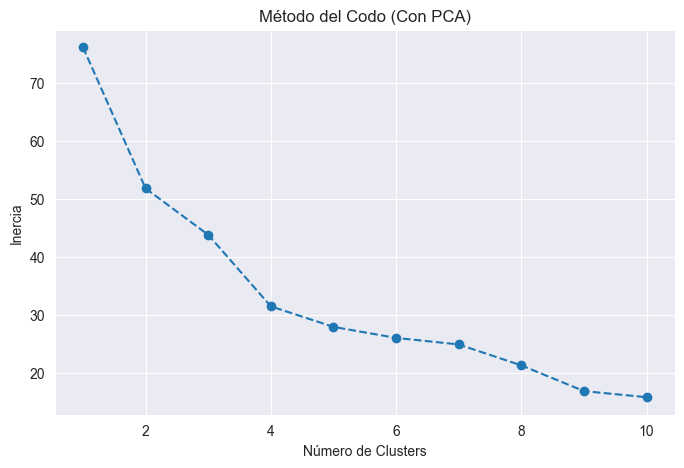

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



Silhouette Score para el modelo: 0.5803


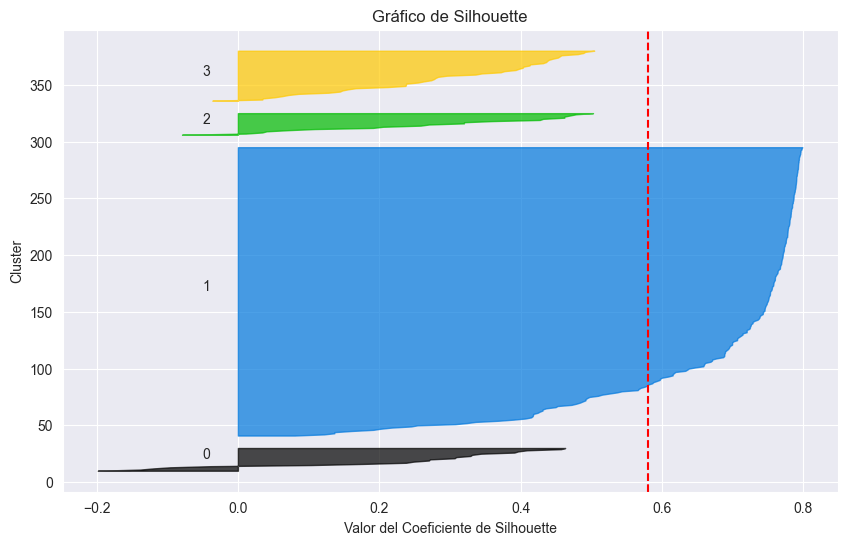


Clusters de las comunas seleccionadas:
Comuna ALGARROBO pertenece al cluster 1
Comuna PUERTO VARAS pertenece al cluster 2
Comuna MACHALI pertenece al cluster 3
Comuna PICHILEMU pertenece al cluster 3


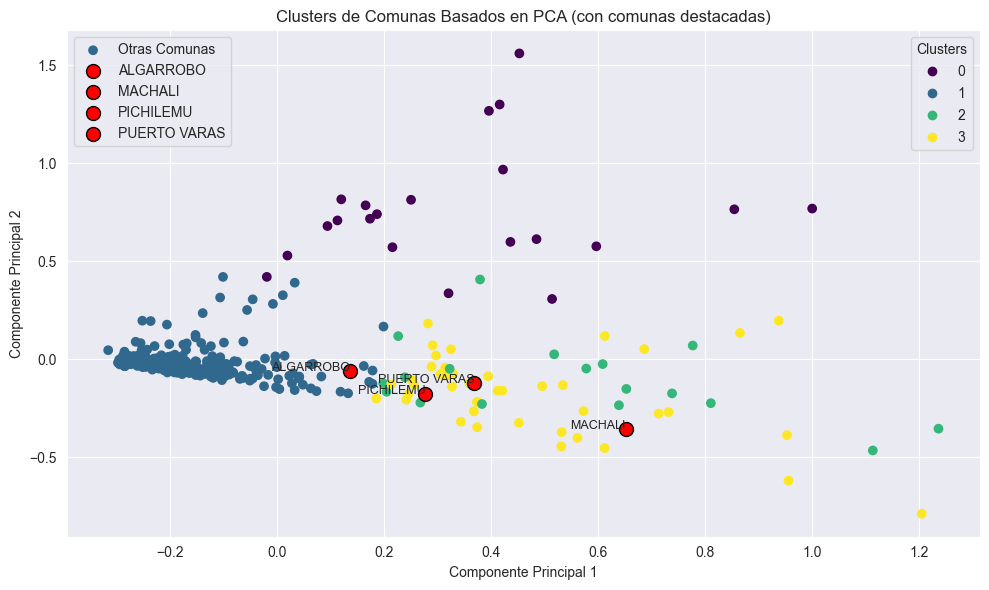


Características promedio por cluster:
         Total de Datos  Total 100-499 m2  % 100-499 m2  Total 500-4999 m2  \
cluster                                                                      
0            727.238095        139.904762     21.462885         412.428571   
1            317.800000         17.470588      7.301919          47.152941   
2           3333.250000        272.200000      8.830363         912.300000   
3            828.755556         86.311111     13.134914         266.111111   

         % 500-4999 m2  Total 5000-10000 m2  % 5000-10000 m2  \
cluster                                                        
0            54.436681           121.857143        15.509896   
1            17.381592           178.419608        47.550436   
2            29.045742          1637.900000        45.619444   
3            31.603672           332.511111        36.825236   

         Total 10001-100000 m2  % 10001-100000 m2  Total >100000 m2  ...  \
cluster                        

In [94]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Eliminar la columna "Unnamed: 0" si existe
if 'Unnamed: 0' in data_estadisticos.columns:
    data_estadisticos = data_estadisticos.drop(columns=['Unnamed: 0'])

# Paso 2: Seleccionar las variables relevantes para el clustering
variables_clustering = [
    'Total 100-499 m2', 'Total 500-4999 m2', 'Total 5000-10000 m2', 'Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2','Media costo_m2_uf 100-499 m2', 'Desviación costo_m2_uf 100-499 m2',
       'Mínimo costo_m2_uf 100-499 m2', 'Máximo costo_m2_uf 100-499 m2',
       'IQR costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
       'Media costo_m2_uf 500-4999 m2', 'Desviación costo_m2_uf 500-4999 m2',
       'Mínimo costo_m2_uf 500-4999 m2', 'Máximo costo_m2_uf 500-4999 m2',
       'IQR costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
       'Media costo_m2_uf 5000-10000 m2',
       'Desviación costo_m2_uf 5000-10000 m2',
       'Mínimo costo_m2_uf 5000-10000 m2', 'Máximo costo_m2_uf 5000-10000 m2',
       'IQR costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2',
       'Media costo_m2_uf 10001-100000 m2',
       'Desviación costo_m2_uf 10001-100000 m2',
       'Mínimo costo_m2_uf 10001-100000 m2',
       'Máximo costo_m2_uf 10001-100000 m2', 'IQR costo_m2_uf 10001-100000 m2',
       'Mediana costo_m2_uf >100000 m2', 'Media costo_m2_uf >100000 m2',
       'Desviación costo_m2_uf >100000 m2', 'Mínimo costo_m2_uf >100000 m2',
       'Máximo costo_m2_uf >100000 m2', 'IQR costo_m2_uf >100000 m2']

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando Normalizer
#scaler = Normalizer()
scaler = MinMaxScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 4: Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=5)  # Reducir a 5 componentes principales
X_pca = pca.fit_transform(X_normalizado)

# Imprimir las varianzas explicadas por cada componente principal
varianzas_explicadas = pca.explained_variance_ratio_
print("Varianzas explicadas por cada componente principal:")
for i, varianza in enumerate(varianzas_explicadas):
    print(f"PC{i + 1}: {varianza:.4f}")

# Imprimir las cargas de los componentes principales
cargas_componentes = pd.DataFrame(pca.components_, columns=variables_clustering,
                                  index=[f'PC{i + 1}' for i in range(pca.n_components_)])
print("\nCargas de los Componentes Principales:")
print(cargas_componentes)

# Paso 5: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo (Con PCA)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

# Paso 6: Aplicar K-means con el número óptimo de clusters
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_pca)

# Calcular el silhouette score para evaluar la calidad de la agrupación
silhouette_avg = silhouette_score(X_pca, data_estadisticos['cluster'])
print(f"\nSilhouette Score para el modelo: {silhouette_avg:.4f}")

# Graficar el Silhouette Score para cada punto
sample_silhouette_values = silhouette_samples(X_pca, data_estadisticos['cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(4):
    ith_cluster_silhouette_values = sample_silhouette_values[data_estadisticos['cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / 4)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color,
                      alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10 for the 0 samples gap between silhouette plots

plt.title("Gráfico de Silhouette")
plt.xlabel("Valor del Coeficiente de Silhouette")
plt.ylabel("Cluster")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.grid(True)
plt.show()

# Paso 7: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['ALGARROBO', 'PUERTO VARAS', 'MACHALI', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Mostrar a qué cluster pertenecen las comunas seleccionadas
print("\nClusters de las comunas seleccionadas:")
for comuna in comunas_a_marcar:
    cluster_comuna = data_estadisticos[data_estadisticos['comuna_match'] == comuna]['cluster'].values[0]
    print(f"Comuna {comuna} pertenece al cluster {cluster_comuna}")

# Paso 8: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_estadisticos['cluster'], cmap='viridis', label='Otras Comunas')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_pca[pos_comunas.index, 0], X_pca[pos_comunas.index, 1]):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir la leyenda con los clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
plt.gca().add_artist(legend1)

# Añadir la leyenda de las comunas destacadas
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en PCA (con comunas destacadas)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 9: Mostrar las características promedio por cluster (solo columnas numéricas)
print("\nCaracterísticas promedio por cluster:")
columnas_numericas = data_estadisticos.select_dtypes(include=['float64', 'int64']).columns
caracteristicas_cluster = data_estadisticos.groupby('cluster')[columnas_numericas].mean()
print(caracteristicas_cluster)

print("\nCaracterísticas mediana por cluster:")
caracteristicas_cluster_median = data_estadisticos.groupby('cluster')[columnas_numericas].median()
print(caracteristicas_cluster_median)


### PCA y RobustScaler

Varianzas explicadas por cada componente principal:
PC1: 0.5998
PC2: 0.1090
PC3: 0.0617
PC4: 0.0532
PC5: 0.0493

Cargas de los Componentes Principales:
     Total 100-499 m2  Total 500-4999 m2  Total 5000-10000 m2  \
PC1         -0.004251          -0.004914            -0.004406   
PC2          0.027679           0.041926            -0.007487   
PC3         -0.028239          -0.038292             0.008261   
PC4          0.007575           0.030978             0.012982   
PC5         -0.031943          -0.031870            -0.006927   

     Total 10001-100000 m2  Mediana costo_m2_uf 100-499 m2  \
PC1              -0.004262                        0.000997   
PC2              -0.003309                        0.022538   
PC3               0.004931                       -0.002985   
PC4               0.014894                        0.042408   
PC5              -0.009749                       -0.018680   

     Media costo_m2_uf 100-499 m2  Desviación costo_m2_uf 100-499 m2  \
PC1         

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than ava

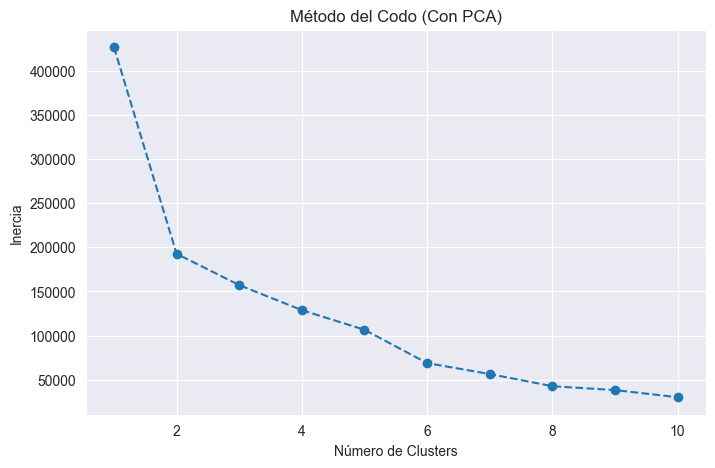

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



Silhouette Score para el modelo: 0.7643


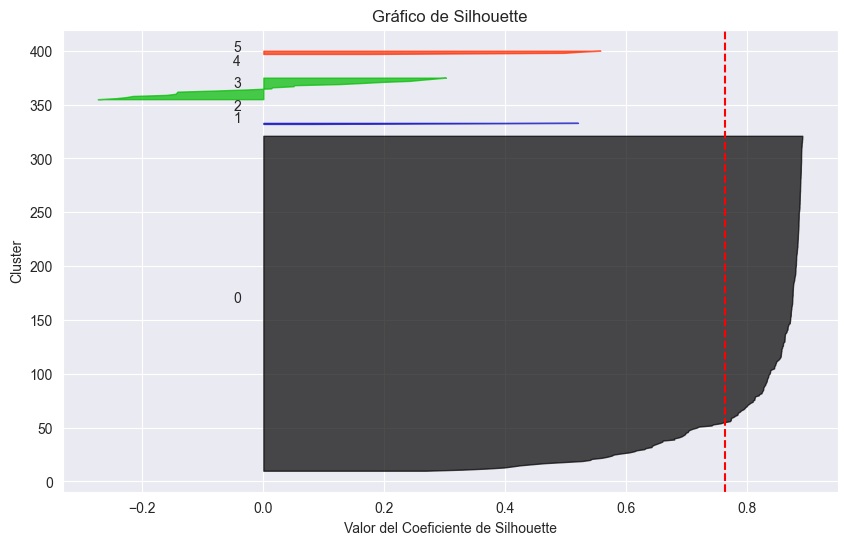


Clusters de las comunas seleccionadas:
Comuna ALGARROBO pertenece al cluster 0
Comuna PUERTO VARAS pertenece al cluster 0
Comuna MACHALI pertenece al cluster 0
Comuna PICHILEMU pertenece al cluster 0


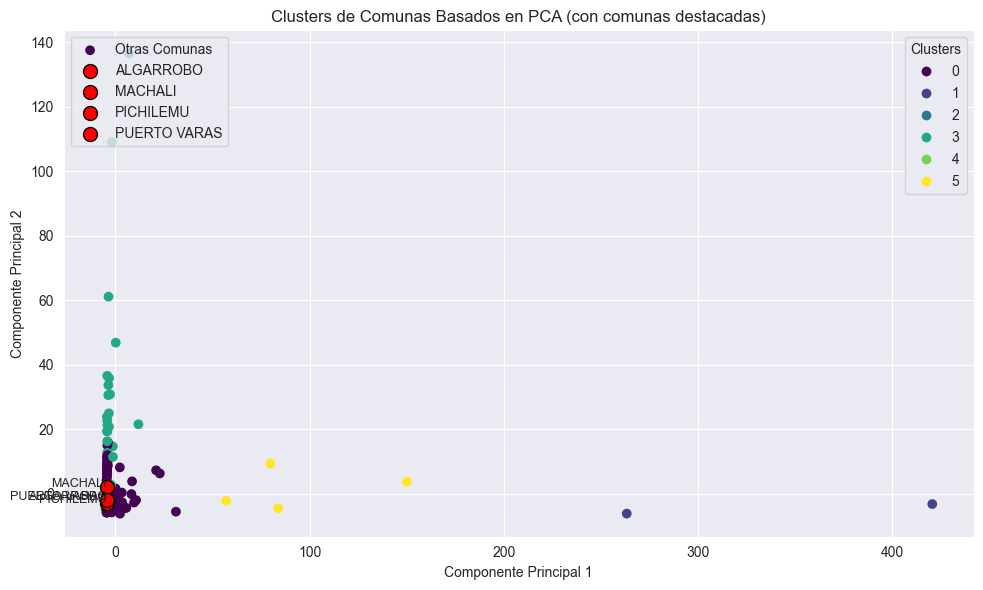


Características promedio por cluster:
         Total de Datos  Total 100-499 m2  % 100-499 m2  Total 500-4999 m2  \
cluster                                                                      
0            595.955128         46.407051      8.019404         137.554487   
1             39.500000         11.000000     27.629870          24.000000   
2             11.000000          2.000000     18.181818           2.000000   
3            636.523810        103.095238     20.166389         363.476190   
4            526.000000         12.000000      2.281369         228.000000   
5             87.250000         10.250000     19.779346          19.500000   

         % 500-4999 m2  Total 5000-10000 m2  % 5000-10000 m2  \
cluster                                                        
0            19.791100           299.198718        46.449109   
1            61.558442             2.000000         4.545455   
2            18.181818             5.000000        45.454545   
3            52.

In [95]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Eliminar la columna "Unnamed: 0" si existe
if 'Unnamed: 0' in data_estadisticos.columns:
    data_estadisticos = data_estadisticos.drop(columns=['Unnamed: 0'])

# Paso 2: Seleccionar las variables relevantes para el clustering
variables_clustering = [
    'Total 100-499 m2', 'Total 500-4999 m2', 'Total 5000-10000 m2', 'Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2','Media costo_m2_uf 100-499 m2', 'Desviación costo_m2_uf 100-499 m2',
       'Mínimo costo_m2_uf 100-499 m2', 'Máximo costo_m2_uf 100-499 m2',
       'IQR costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
       'Media costo_m2_uf 500-4999 m2', 'Desviación costo_m2_uf 500-4999 m2',
       'Mínimo costo_m2_uf 500-4999 m2', 'Máximo costo_m2_uf 500-4999 m2',
       'IQR costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
       'Media costo_m2_uf 5000-10000 m2',
       'Desviación costo_m2_uf 5000-10000 m2',
       'Mínimo costo_m2_uf 5000-10000 m2', 'Máximo costo_m2_uf 5000-10000 m2',
       'IQR costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2',
       'Media costo_m2_uf 10001-100000 m2',
       'Desviación costo_m2_uf 10001-100000 m2',
       'Mínimo costo_m2_uf 10001-100000 m2',
       'Máximo costo_m2_uf 10001-100000 m2', 'IQR costo_m2_uf 10001-100000 m2',
       'Mediana costo_m2_uf >100000 m2', 'Media costo_m2_uf >100000 m2',
       'Desviación costo_m2_uf >100000 m2', 'Mínimo costo_m2_uf >100000 m2',
       'Máximo costo_m2_uf >100000 m2', 'IQR costo_m2_uf >100000 m2']

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando Normalizer
#scaler = Normalizer()
#scaler = MinMaxScaler()
scaler = RobustScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 4: Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=5)  # Reducir a 5 componentes principales
X_pca = pca.fit_transform(X_normalizado)

# Imprimir las varianzas explicadas por cada componente principal
varianzas_explicadas = pca.explained_variance_ratio_
print("Varianzas explicadas por cada componente principal:")
for i, varianza in enumerate(varianzas_explicadas):
    print(f"PC{i + 1}: {varianza:.4f}")

# Imprimir las cargas de los componentes principales
cargas_componentes = pd.DataFrame(pca.components_, columns=variables_clustering,
                                  index=[f'PC{i + 1}' for i in range(pca.n_components_)])
print("\nCargas de los Componentes Principales:")
print(cargas_componentes)

# Paso 5: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo (Con PCA)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

# Paso 6: Aplicar K-means con el número óptimo de clusters
kmeans = KMeans(n_clusters=6, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_pca)

# Calcular el silhouette score para evaluar la calidad de la agrupación
silhouette_avg = silhouette_score(X_pca, data_estadisticos['cluster'])
print(f"\nSilhouette Score para el modelo: {silhouette_avg:.4f}")

# Graficar el Silhouette Score para cada punto
sample_silhouette_values = silhouette_samples(X_pca, data_estadisticos['cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(6):
    ith_cluster_silhouette_values = sample_silhouette_values[data_estadisticos['cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / 6)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color,
                      alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10 for the 0 samples gap between silhouette plots

plt.title("Gráfico de Silhouette")
plt.xlabel("Valor del Coeficiente de Silhouette")
plt.ylabel("Cluster")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.grid(True)
plt.show()

# Paso 7: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['ALGARROBO', 'PUERTO VARAS', 'MACHALI', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Mostrar a qué cluster pertenecen las comunas seleccionadas
print("\nClusters de las comunas seleccionadas:")
for comuna in comunas_a_marcar:
    cluster_comuna = data_estadisticos[data_estadisticos['comuna_match'] == comuna]['cluster'].values[0]
    print(f"Comuna {comuna} pertenece al cluster {cluster_comuna}")

# Paso 8: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_estadisticos['cluster'], cmap='viridis', label='Otras Comunas')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_pca[pos_comunas.index, 0], X_pca[pos_comunas.index, 1]):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir la leyenda con los clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
plt.gca().add_artist(legend1)

# Añadir la leyenda de las comunas destacadas
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en PCA (con comunas destacadas)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 9: Mostrar las características promedio por cluster (solo columnas numéricas)
print("\nCaracterísticas promedio por cluster:")
columnas_numericas = data_estadisticos.select_dtypes(include=['float64', 'int64']).columns
caracteristicas_cluster = data_estadisticos.groupby('cluster')[columnas_numericas].mean()
print(caracteristicas_cluster)

print("\nCaracterísticas mediana por cluster:")
caracteristicas_cluster_median = data_estadisticos.groupby('cluster')[columnas_numericas].median()
print(caracteristicas_cluster_median)


### Normalizer sin PCA

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than ava

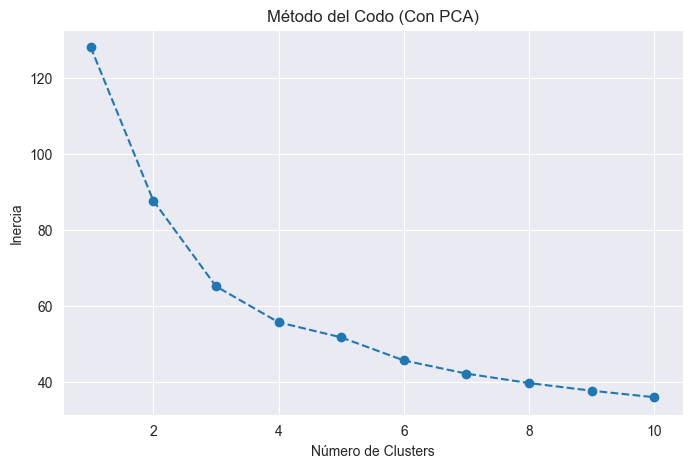

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


Silhouette Score para el modelo: 0.4001


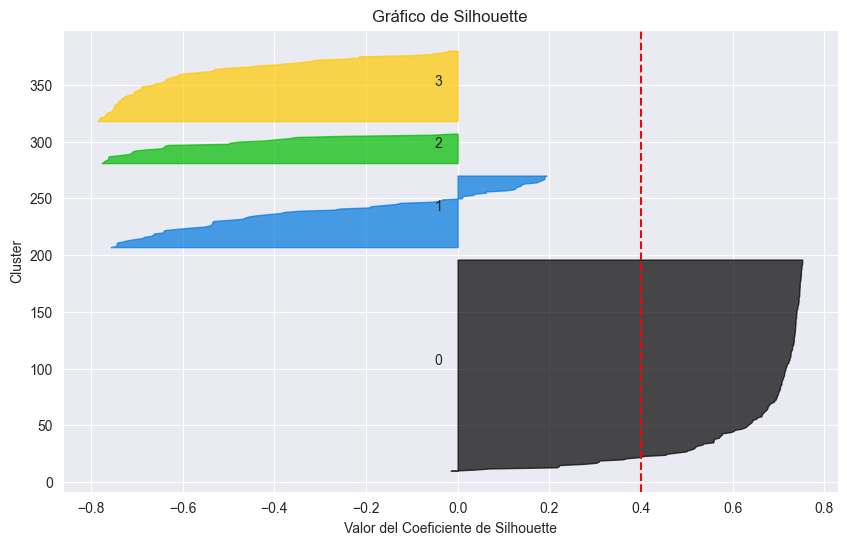

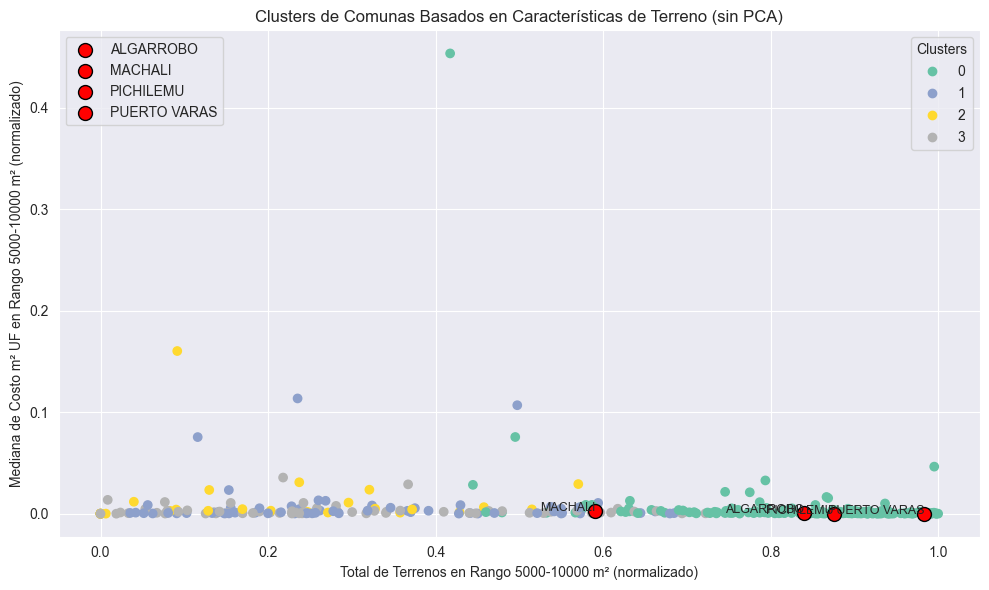


Pesos de cada variable en el clustering (valores de los centroides):
   Total 100-499 m2  Total 500-4999 m2  Total 5000-10000 m2  \
0          0.077864           0.201726             0.842734   
1          0.268559           0.750677             0.320745   
2          0.086659           0.181805             0.197935   
3          0.093125           0.141521             0.292719   

   Total 10001-100000 m2  Mediana costo_m2_uf 100-499 m2  \
0               0.295225                        0.033428   
1               0.198929                        0.038304   
2               0.185236                        0.172828   
3               0.181319                        0.139843   

   Media costo_m2_uf 100-499 m2  Desviación costo_m2_uf 100-499 m2  \
0                      0.049063                           0.047597   
1                      0.045315                           0.033730   
2                      0.180214                           0.039624   
3                      0.214712  

In [80]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total 100-499 m2', 'Total 500-4999 m2', 'Total 5000-10000 m2', 'Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2','Media costo_m2_uf 100-499 m2', 'Desviación costo_m2_uf 100-499 m2',
       'Mínimo costo_m2_uf 100-499 m2', 'Máximo costo_m2_uf 100-499 m2',
       'IQR costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
       'Media costo_m2_uf 500-4999 m2', 'Desviación costo_m2_uf 500-4999 m2',
       'Mínimo costo_m2_uf 500-4999 m2', 'Máximo costo_m2_uf 500-4999 m2',
       'IQR costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
       'Media costo_m2_uf 5000-10000 m2',
       'Desviación costo_m2_uf 5000-10000 m2',
       'Mínimo costo_m2_uf 5000-10000 m2', 'Máximo costo_m2_uf 5000-10000 m2',
       'IQR costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2',
       'Media costo_m2_uf 10001-100000 m2',
       'Desviación costo_m2_uf 10001-100000 m2',
       'Mínimo costo_m2_uf 10001-100000 m2',
       'Máximo costo_m2_uf 10001-100000 m2', 'IQR costo_m2_uf 10001-100000 m2',
       'Mediana costo_m2_uf >100000 m2', 'Media costo_m2_uf >100000 m2',
       'Desviación costo_m2_uf >100000 m2', 'Mínimo costo_m2_uf >100000 m2',
       'Máximo costo_m2_uf >100000 m2', 'IQR costo_m2_uf >100000 m2']

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando StandardScaler
scaler = Normalizer()
#scaler = StandardScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 4: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_normalizado)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo (Con PCA)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()


# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Graficar el Silhouette Score para cada punto
sample_silhouette_values = silhouette_samples(X_pca, data_estadisticos['cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(4):
    ith_cluster_silhouette_values = sample_silhouette_values[data_estadisticos['cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / 4)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10  # 10 for the 0 samples gap between silhouette plots

plt.title("Gráfico de Silhouette")
plt.xlabel("Valor del Coeficiente de Silhouette")
plt.ylabel("Cluster")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.grid(True)
plt.show()


# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['Total 5000-10000 m2'], X_normalizado['Mediana costo_m2_uf 5000-10000 m2'],
                      c=data_estadisticos['cluster'], cmap='Set2')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, 'Total 5000-10000 m2'], 
                        X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 5000-10000 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('Total de Terrenos en Rango 5000-10000 m² (normalizado)')
plt.ylabel('Mediana de Costo m² UF en Rango 5000-10000 m² (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Paso 7: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

## Cluster DBScan

Varianzas explicadas por cada componente principal:
PC1: 0.5998
PC2: 0.1090
PC3: 0.0617
PC4: 0.0532
PC5: 0.0493

Cargas de los Componentes Principales:
     Total 100-499 m2  Total 500-4999 m2  Total 5000-10000 m2  \
PC1         -0.004251          -0.004914            -0.004406   
PC2          0.027679           0.041926            -0.007487   
PC3         -0.028239          -0.038292             0.008261   
PC4          0.007575           0.030978             0.012982   
PC5         -0.031943          -0.031870            -0.006927   

     Total 10001-100000 m2  Mediana costo_m2_uf 100-499 m2  \
PC1              -0.004262                        0.000997   
PC2              -0.003309                        0.022538   
PC3               0.004931                       -0.002985   
PC4               0.014894                        0.042408   
PC5              -0.009749                       -0.018680   

     Media costo_m2_uf 100-499 m2  Desviación costo_m2_uf 100-499 m2  \
PC1         

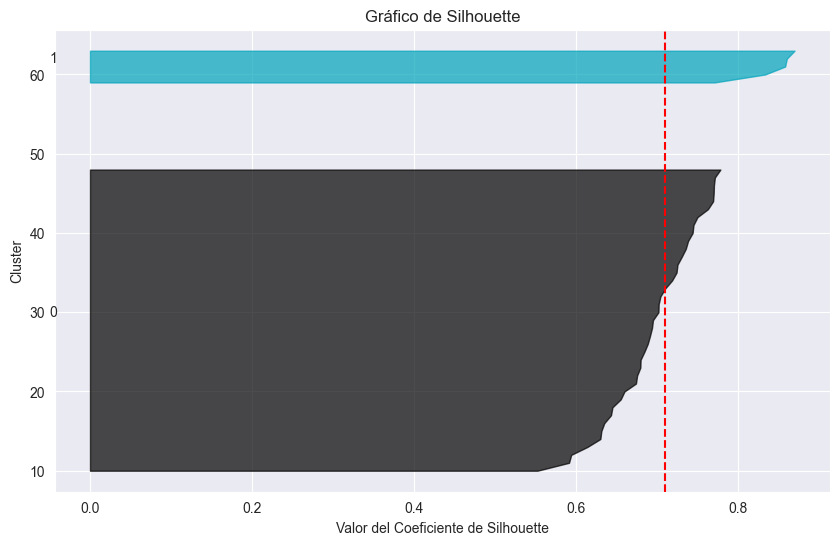


Clusters de las comunas seleccionadas:
Comuna ALGARROBO pertenece al cluster -1
Comuna PUERTO VARAS pertenece al cluster -1
Comuna MACHALI pertenece al cluster -1
Comuna PICHILEMU pertenece al cluster -1


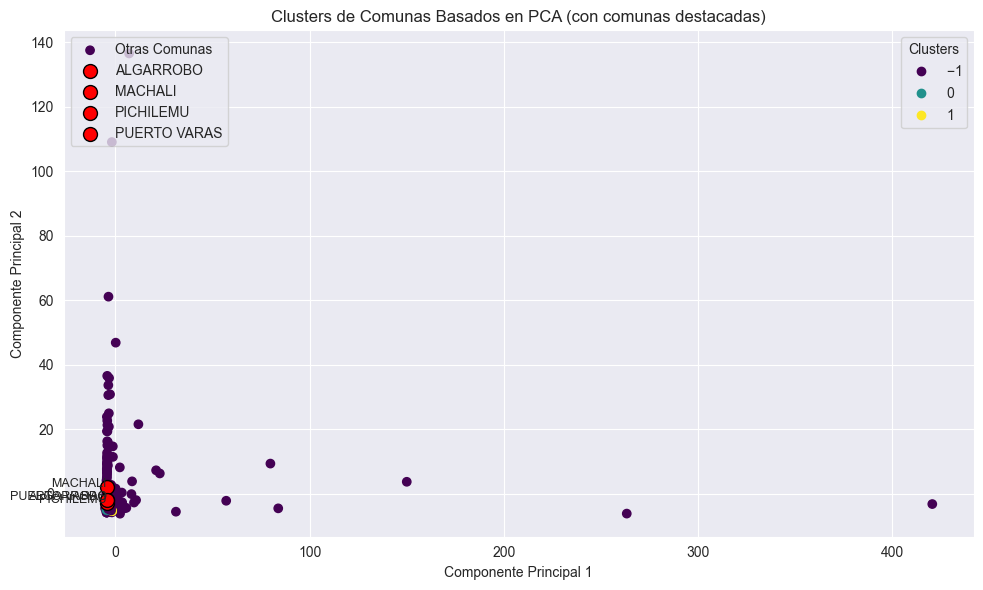

In [96]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Eliminar la columna "Unnamed: 0" si existe
if 'Unnamed: 0' in data_estadisticos.columns:
    data_estadisticos = data_estadisticos.drop(columns=['Unnamed: 0'])

# Paso 2: Seleccionar las variables relevantes para el clustering
variables_clustering = [
    'Total 100-499 m2', 'Total 500-4999 m2', 'Total 5000-10000 m2', 'Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2','Media costo_m2_uf 100-499 m2', 'Desviación costo_m2_uf 100-499 m2',
       'Mínimo costo_m2_uf 100-499 m2', 'Máximo costo_m2_uf 100-499 m2',
       'IQR costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
       'Media costo_m2_uf 500-4999 m2', 'Desviación costo_m2_uf 500-4999 m2',
       'Mínimo costo_m2_uf 500-4999 m2', 'Máximo costo_m2_uf 500-4999 m2',
       'IQR costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
       'Media costo_m2_uf 5000-10000 m2',
       'Desviación costo_m2_uf 5000-10000 m2',
       'Mínimo costo_m2_uf 5000-10000 m2', 'Máximo costo_m2_uf 5000-10000 m2',
       'IQR costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2',
       'Media costo_m2_uf 10001-100000 m2',
       'Desviación costo_m2_uf 10001-100000 m2',
       'Mínimo costo_m2_uf 10001-100000 m2',
       'Máximo costo_m2_uf 10001-100000 m2', 'IQR costo_m2_uf 10001-100000 m2',
       'Mediana costo_m2_uf >100000 m2', 'Media costo_m2_uf >100000 m2',
       'Desviación costo_m2_uf >100000 m2', 'Mínimo costo_m2_uf >100000 m2',
       'Máximo costo_m2_uf >100000 m2', 'IQR costo_m2_uf >100000 m2']

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando Normalizer
#scaler = Normalizer()
#scaler = MinMaxScaler()
scaler = RobustScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 4: Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=5)  # Reducir a 5 componentes principales
X_pca = pca.fit_transform(X_normalizado)

# Imprimir las varianzas explicadas por cada componente principal
varianzas_explicadas = pca.explained_variance_ratio_
print("Varianzas explicadas por cada componente principal:")
for i, varianza in enumerate(varianzas_explicadas):
    print(f"PC{i + 1}: {varianza:.4f}")

# Imprimir las cargas de los componentes principales
cargas_componentes = pd.DataFrame(pca.components_, columns=variables_clustering,
                                  index=[f'PC{i + 1}' for i in range(pca.n_components_)])
print("\nCargas de los Componentes Principales:")
print(cargas_componentes)

# Paso 5: Aplicar DBSCAN para el clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Ajustar los parámetros eps y min_samples según sea necesario
data_estadisticos['cluster'] = dbscan.fit_predict(X_pca)

# Filtrar los clusters que no son ruido (-1 es el ruido en DBSCAN)
clusters_unicos = np.unique(data_estadisticos['cluster'])
print(f"Clusters encontrados: {clusters_unicos}")

# Filtrar puntos de ruido (-1 indica ruido en DBSCAN)
mask_no_outliers = data_estadisticos['cluster'] != -1

# Paso 6: Calcular el silhouette score, excluyendo los puntos de ruido
if len(clusters_unicos) > 1 and len(mask_no_outliers) > 0:
    silhouette_avg = silhouette_score(X_pca[mask_no_outliers], data_estadisticos.loc[mask_no_outliers, 'cluster'])
    print(f"\nSilhouette Score para el modelo (excluyendo ruido): {silhouette_avg:.4f}")

    # Graficar el Silhouette Score para cada punto
    sample_silhouette_values = silhouette_samples(X_pca[mask_no_outliers], data_estadisticos.loc[mask_no_outliers, 'cluster'])

    plt.figure(figsize=(10, 6))
    y_lower = 10
    for i in np.unique(data_estadisticos.loc[mask_no_outliers, 'cluster']):
        ith_cluster_silhouette_values = sample_silhouette_values[data_estadisticos['cluster'][mask_no_outliers] == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / len(np.unique(data_estadisticos['cluster'])))
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color,
                          alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples gap between silhouette plots

    plt.title("Gráfico de Silhouette")
    plt.xlabel("Valor del Coeficiente de Silhouette")
    plt.ylabel("Cluster")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.grid(True)
    plt.show()

else:
    print("No se puede calcular el Silhouette Score debido a la falta de suficientes clusters o puntos de ruido.")

# Paso 7: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['ALGARROBO', 'PUERTO VARAS', 'MACHALI', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Mostrar a qué cluster pertenecen las comunas seleccionadas
print("\nClusters de las comunas seleccionadas:")
for comuna in comunas_a_marcar:
    cluster_comuna = data_estadisticos[data_estadisticos['comuna_match'] == comuna]['cluster'].values[0]
    print(f"Comuna {comuna} pertenece al cluster {cluster_comuna}")

# Paso 8: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_estadisticos['cluster'], cmap='viridis', label='Otras Comunas')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_pca[pos_comunas.index, 0], X_pca[pos_comunas.index, 1]):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir la leyenda con los clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
plt.gca().add_artist(legend1)

# Añadir la leyenda de las comunas destacadas
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en PCA (con comunas destacadas)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 9: Mostrar las características promedio por cluster


## DBScan y Normalizer

Varianzas explicadas por cada componente principal:
PC1: 0.3948
PC2: 0.2468
PC3: 0.1179
PC4: 0.0776
PC5: 0.0426

Cargas de los Componentes Principales:
     Total 100-499 m2  Total 500-4999 m2  Total 5000-10000 m2  \
PC1         -0.115254          -0.257734             0.810665   
PC2          0.216414           0.748310            -0.060454   
PC3         -0.101343          -0.354516            -0.201923   
PC4          0.029707           0.081887            -0.137815   
PC5          0.199628          -0.006278            -0.004263   

     Total 10001-100000 m2  Mediana costo_m2_uf 100-499 m2  \
PC1               0.146154                       -0.113962   
PC2              -0.017305                       -0.124636   
PC3               0.156480                        0.160265   
PC4               0.960667                        0.034753   
PC5              -0.110418                        0.534046   

     Media costo_m2_uf 100-499 m2  Desviación costo_m2_uf 100-499 m2  \
PC1         

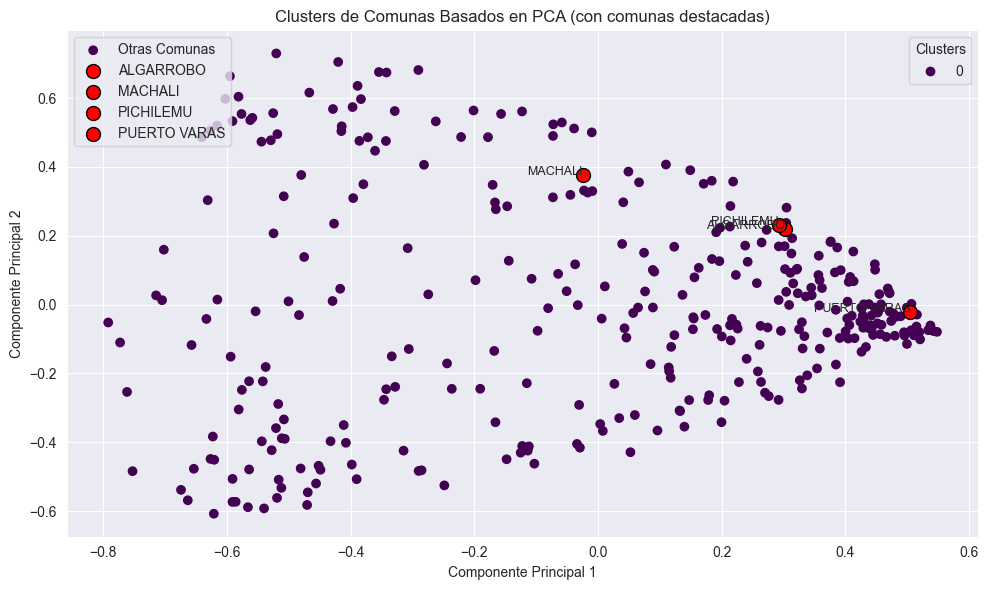

In [107]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Eliminar la columna "Unnamed: 0" si existe
if 'Unnamed: 0' in data_estadisticos.columns:
    data_estadisticos = data_estadisticos.drop(columns=['Unnamed: 0'])

# Paso 2: Seleccionar las variables relevantes para el clustering
variables_clustering = [
    'Total 100-499 m2', 'Total 500-4999 m2', 'Total 5000-10000 m2', 'Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2','Media costo_m2_uf 100-499 m2', 'Desviación costo_m2_uf 100-499 m2',
       'Mínimo costo_m2_uf 100-499 m2', 'Máximo costo_m2_uf 100-499 m2',
       'IQR costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
       'Media costo_m2_uf 500-4999 m2', 'Desviación costo_m2_uf 500-4999 m2',
       'Mínimo costo_m2_uf 500-4999 m2', 'Máximo costo_m2_uf 500-4999 m2',
       'IQR costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
       'Media costo_m2_uf 5000-10000 m2',
       'Desviación costo_m2_uf 5000-10000 m2',
       'Mínimo costo_m2_uf 5000-10000 m2', 'Máximo costo_m2_uf 5000-10000 m2',
       'IQR costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2',
       'Media costo_m2_uf 10001-100000 m2',
       'Desviación costo_m2_uf 10001-100000 m2',
       'Mínimo costo_m2_uf 10001-100000 m2',
       'Máximo costo_m2_uf 10001-100000 m2', 'IQR costo_m2_uf 10001-100000 m2',
       'Mediana costo_m2_uf >100000 m2', 'Media costo_m2_uf >100000 m2',
       'Desviación costo_m2_uf >100000 m2', 'Mínimo costo_m2_uf >100000 m2',
       'Máximo costo_m2_uf >100000 m2', 'IQR costo_m2_uf >100000 m2']

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando Normalizer
scaler = Normalizer()
#scaler = MinMaxScaler()
#scaler = RobustScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 4: Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=5)  # Reducir a 5 componentes principales
X_pca = pca.fit_transform(X_normalizado)

# Imprimir las varianzas explicadas por cada componente principal
varianzas_explicadas = pca.explained_variance_ratio_
print("Varianzas explicadas por cada componente principal:")
for i, varianza in enumerate(varianzas_explicadas):
    print(f"PC{i + 1}: {varianza:.4f}")

# Imprimir las cargas de los componentes principales
cargas_componentes = pd.DataFrame(pca.components_, columns=variables_clustering,
                                  index=[f'PC{i + 1}' for i in range(pca.n_components_)])
print("\nCargas de los Componentes Principales:")
print(cargas_componentes)

# Paso 5: Aplicar DBSCAN para el clustering
dbscan = DBSCAN(eps=1, min_samples=5)  # Ajustar los parámetros eps y min_samples según sea necesario
data_estadisticos['cluster'] = dbscan.fit_predict(X_pca)

# Filtrar los clusters que no son ruido (-1 es el ruido en DBSCAN)
clusters_unicos = np.unique(data_estadisticos['cluster'])
print(f"Clusters encontrados: {clusters_unicos}")

# Filtrar puntos de ruido (-1 indica ruido en DBSCAN)
mask_no_outliers = data_estadisticos['cluster'] != -1

# Paso 6: Calcular el silhouette score, excluyendo los puntos de ruido
if len(clusters_unicos) > 1 and len(mask_no_outliers) > 0:
    silhouette_avg = silhouette_score(X_pca[mask_no_outliers], data_estadisticos.loc[mask_no_outliers, 'cluster'])
    print(f"\nSilhouette Score para el modelo (excluyendo ruido): {silhouette_avg:.4f}")

    # Graficar el Silhouette Score para cada punto
    sample_silhouette_values = silhouette_samples(X_pca[mask_no_outliers], data_estadisticos.loc[mask_no_outliers, 'cluster'])

    plt.figure(figsize=(10, 6))
    y_lower = 10
    for i in np.unique(data_estadisticos.loc[mask_no_outliers, 'cluster']):
        ith_cluster_silhouette_values = sample_silhouette_values[data_estadisticos['cluster'][mask_no_outliers] == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / len(np.unique(data_estadisticos['cluster'])))
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color,
                          alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples gap between silhouette plots

    plt.title("Gráfico de Silhouette")
    plt.xlabel("Valor del Coeficiente de Silhouette")
    plt.ylabel("Cluster")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.grid(True)
    plt.show()

else:
    print("No se puede calcular el Silhouette Score debido a la falta de suficientes clusters o puntos de ruido.")

# Paso 7: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['ALGARROBO', 'PUERTO VARAS', 'MACHALI', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Mostrar a qué cluster pertenecen las comunas seleccionadas
print("\nClusters de las comunas seleccionadas:")
for comuna in comunas_a_marcar:
    cluster_comuna = data_estadisticos[data_estadisticos['comuna_match'] == comuna]['cluster'].values[0]
    print(f"Comuna {comuna} pertenece al cluster {cluster_comuna}")

# Paso 8: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_estadisticos['cluster'], cmap='viridis', label='Otras Comunas')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_pca[pos_comunas.index, 0], X_pca[pos_comunas.index, 1]):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir la leyenda con los clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
plt.gca().add_artist(legend1)

# Añadir la leyenda de las comunas destacadas
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en PCA (con comunas destacadas)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 9: Mostrar las características promedio por cluster


Varianzas explicadas por cada componente principal:
PC1: 0.5466
PC2: 0.2544
PC3: 0.0797
PC4: 0.0452
PC5: 0.0314
Clusters encontrados: [-1  0]
No se puede calcular el Silhouette Score debido a la falta de suficientes clusters válidos o puntos de ruido.

Clusters de las comunas seleccionadas:
Comuna ALGARROBO pertenece al cluster -1
Comuna PUERTO VARAS pertenece al cluster -1
Comuna MACHALI pertenece al cluster -1
Comuna PICHILEMU pertenece al cluster -1


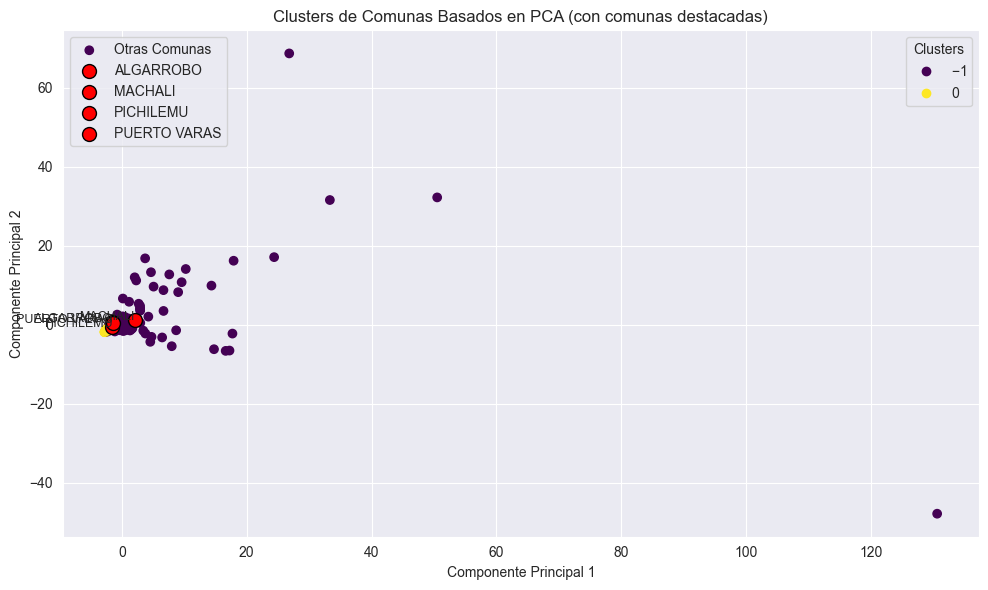

In [102]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import numpy as np

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Eliminar la columna "Unnamed: 0" si existe
if 'Unnamed: 0' in data_estadisticos.columns:
    data_estadisticos = data_estadisticos.drop(columns=['Unnamed: 0'])

# Paso 2: Seleccionar las variables relevantes para el clustering
variables_clustering = [
    'Total 100-499 m2', 'Total 500-4999 m2', 'Total 5000-10000 m2', 'Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
    'Mediana costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando RobustScaler
scaler = RobustScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 4: Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=5)  # Reducir a 5 componentes principales
X_pca = pca.fit_transform(X_normalizado)

# Imprimir las varianzas explicadas por cada componente principal
varianzas_explicadas = pca.explained_variance_ratio_
print("Varianzas explicadas por cada componente principal:")
for i, varianza in enumerate(varianzas_explicadas):
    print(f"PC{i + 1}: {varianza:.4f}")

# Paso 5: Aplicar DBSCAN para el clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Ajustar los parámetros eps y min_samples según sea necesario
data_estadisticos['cluster'] = dbscan.fit_predict(X_pca)

# Filtrar los clusters que no son ruido (-1 es el ruido en DBSCAN)
clusters_unicos = np.unique(data_estadisticos['cluster'])
print(f"Clusters encontrados: {clusters_unicos}")

# Verificar si hay más de un cluster válido (excluyendo el ruido)
mask_no_outliers = data_estadisticos['cluster'] != -1
n_clusters = len(clusters_unicos[clusters_unicos != -1])  # Excluyendo el cluster de ruido (-1)

if n_clusters > 1 and mask_no_outliers.sum() > 1:
    # Paso 6: Calcular el Silhouette Score, excluyendo los puntos de ruido
    silhouette_avg = silhouette_score(X_pca[mask_no_outliers], data_estadisticos.loc[mask_no_outliers, 'cluster'])
    print(f"\nSilhouette Score para el modelo (excluyendo ruido): {silhouette_avg:.4f}")

    # Graficar el Silhouette Score para cada punto
    sample_silhouette_values = silhouette_samples(X_pca[mask_no_outliers], data_estadisticos.loc[mask_no_outliers, 'cluster'])

    plt.figure(figsize=(10, 6))
    y_lower = 10
    for i in np.unique(data_estadisticos.loc[mask_no_outliers, 'cluster']):
        ith_cluster_silhouette_values = sample_silhouette_values[data_estadisticos['cluster'][mask_no_outliers] == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / len(np.unique(data_estadisticos['cluster'])))
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color,
                          alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples gap between silhouette plots

    plt.title("Gráfico de Silhouette")
    plt.xlabel("Valor del Coeficiente de Silhouette")
    plt.ylabel("Cluster")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.grid(True)
    plt.show()

else:
    print("No se puede calcular el Silhouette Score debido a la falta de suficientes clusters válidos o puntos de ruido.")

# Paso 7: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['ALGARROBO', 'PUERTO VARAS', 'MACHALI', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Mostrar a qué cluster pertenecen las comunas seleccionadas
print("\nClusters de las comunas seleccionadas:")
for comuna in comunas_a_marcar:
    cluster_comuna = data_estadisticos[data_estadisticos['comuna_match'] == comuna]['cluster'].values[0]
    print(f"Comuna {comuna} pertenece al cluster {cluster_comuna}")

# Paso 8: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_estadisticos['cluster'], cmap='viridis', label='Otras Comunas')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_pca[pos_comunas.index, 0], X_pca[pos_comunas.index, 1]):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir la leyenda con los clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
plt.gca().add_artist(legend1)

# Añadir la leyenda de las comunas destacadas
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en PCA (con comunas destacadas)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.tight_layout()
plt.show()


In [104]:
# Paso 1: Obtener solo las dos primeras componentes principales junto con las comunas
data_pca_comunas = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])  # Usar solo las dos primeras componentes
data_pca_comunas['comuna_match'] = data_estadisticos['comuna_match']

# Paso 2: Buscar la comuna con un valor de PC1 cercano a 120 (el más alejado en el eje PC1)
punto_destacado = data_pca_comunas.loc[data_pca_comunas['PC1'].idxmax()]

print("El punto más alejado en el eje PC1 es la siguiente comuna:")
print(punto_destacado)

# Opcional: Mostrar las primeras filas para revisar el conjunto de datos
print("\nPrimeras filas del conjunto de datos PCA con comunas:")
print(data_pca_comunas.head())



El punto más alejado en el eje PC1 es la siguiente comuna:
PC1               130.60431
PC2              -47.842207
comuna_match    ALTO BIOBIO
Name: 2, dtype: object

Primeras filas del conjunto de datos PCA con comunas:
          PC1        PC2     comuna_match
0   -1.559998   0.578858        ALGARROBO
1   -1.591336  -0.481074            ALHUE
2  130.604310 -47.842207      ALTO BIOBIO
3   -1.798733  -0.089235  ALTO DEL CARMEN
4    6.660565   8.748814    ALTO HOSPICIO


Varianzas explicadas por cada componente principal:
PC1: 0.5590
PC2: 0.1362
PC3: 0.1072
PC4: 0.0776
PC5: 0.0488
Clusters encontrados: [-1  0]
No se puede calcular el Silhouette Score debido a la falta de suficientes clusters válidos o puntos de ruido.

Clusters de las comunas seleccionadas:
Comuna ALGARROBO pertenece al cluster -1
Comuna PUERTO VARAS pertenece al cluster -1
Comuna MACHALI pertenece al cluster -1
Comuna PICHILEMU pertenece al cluster -1


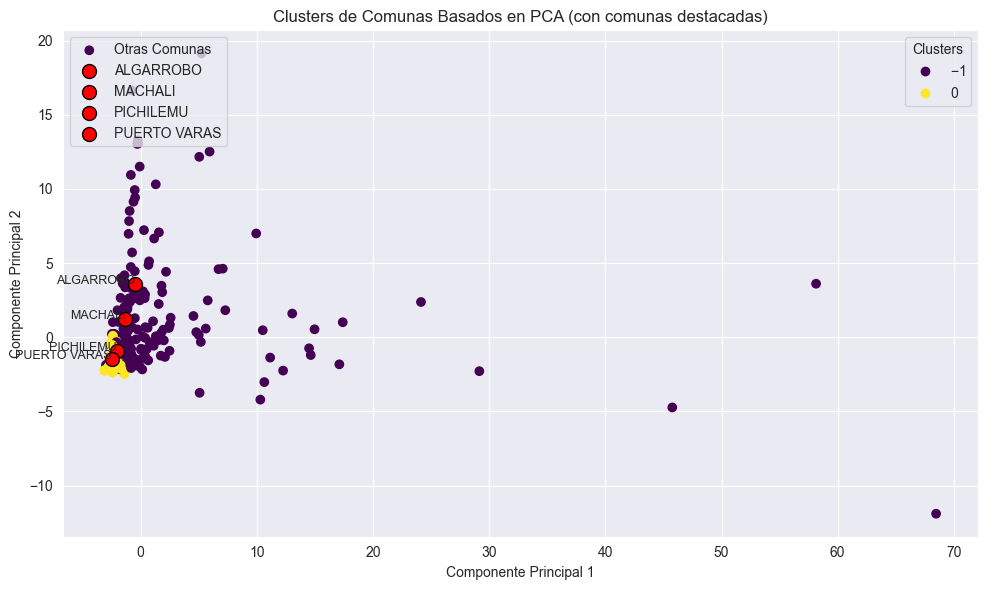

In [105]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import numpy as np

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Eliminar la columna "Unnamed: 0" si existe
if 'Unnamed: 0' in data_estadisticos.columns:
    data_estadisticos = data_estadisticos.drop(columns=['Unnamed: 0'])

# Excluir la comuna ALTO BIOBIO
data_estadisticos = data_estadisticos[data_estadisticos['comuna_match'] != 'ALTO BIOBIO']

# Paso 2: Seleccionar las variables relevantes para el clustering
variables_clustering = [
    'Total 100-499 m2', 'Total 500-4999 m2', 'Total 5000-10000 m2', 'Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
    'Mediana costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2', 'Mediana costo_m2_uf >100000 m2'
]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando RobustScaler
scaler = RobustScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 4: Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=5)  # Reducir a 5 componentes principales
X_pca = pca.fit_transform(X_normalizado)

# Imprimir las varianzas explicadas por cada componente principal
varianzas_explicadas = pca.explained_variance_ratio_
print("Varianzas explicadas por cada componente principal:")
for i, varianza in enumerate(varianzas_explicadas):
    print(f"PC{i + 1}: {varianza:.4f}")

# Paso 5: Aplicar DBSCAN para el clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Ajustar los parámetros eps y min_samples según sea necesario
data_estadisticos['cluster'] = dbscan.fit_predict(X_pca)

# Filtrar los clusters que no son ruido (-1 es el ruido en DBSCAN)
clusters_unicos = np.unique(data_estadisticos['cluster'])
print(f"Clusters encontrados: {clusters_unicos}")

# Verificar si hay más de un cluster válido (excluyendo el ruido)
mask_no_outliers = data_estadisticos['cluster'] != -1
n_clusters = len(clusters_unicos[clusters_unicos != -1])  # Excluyendo el cluster de ruido (-1)

if n_clusters > 1 and mask_no_outliers.sum() > 1:
    # Paso 6: Calcular el Silhouette Score, excluyendo los puntos de ruido
    silhouette_avg = silhouette_score(X_pca[mask_no_outliers], data_estadisticos.loc[mask_no_outliers, 'cluster'])
    print(f"\nSilhouette Score para el modelo (excluyendo ruido): {silhouette_avg:.4f}")

    # Graficar el Silhouette Score para cada punto
    sample_silhouette_values = silhouette_samples(X_pca[mask_no_outliers], data_estadisticos.loc[mask_no_outliers, 'cluster'])

    plt.figure(figsize=(10, 6))
    y_lower = 10
    for i in np.unique(data_estadisticos.loc[mask_no_outliers, 'cluster']):
        ith_cluster_silhouette_values = sample_silhouette_values[data_estadisticos['cluster'][mask_no_outliers] == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / len(np.unique(data_estadisticos['cluster'])))
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color,
                          alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples gap between silhouette plots

    plt.title("Gráfico de Silhouette")
    plt.xlabel("Valor del Coeficiente de Silhouette")
    plt.ylabel("Cluster")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.grid(True)
    plt.show()

else:
    print("No se puede calcular el Silhouette Score debido a la falta de suficientes clusters válidos o puntos de ruido.")

# Paso 7: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['ALGARROBO', 'PUERTO VARAS', 'MACHALI', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Mostrar a qué cluster pertenecen las comunas seleccionadas
print("\nClusters de las comunas seleccionadas:")
for comuna in comunas_a_marcar:
    cluster_comuna = data_estadisticos[data_estadisticos['comuna_match'] == comuna]['cluster'].values[0]
    print(f"Comuna {comuna} pertenece al cluster {cluster_comuna}")

# Paso 8: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_estadisticos['cluster'], cmap='viridis', label='Otras Comunas')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_pca[pos_comunas.index, 0], X_pca[pos_comunas.index, 1]):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir la leyenda con los clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
plt.gca().add_artist(legend1)

# Añadir la leyenda de las comunas destacadas
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en PCA (con comunas destacadas)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than ava

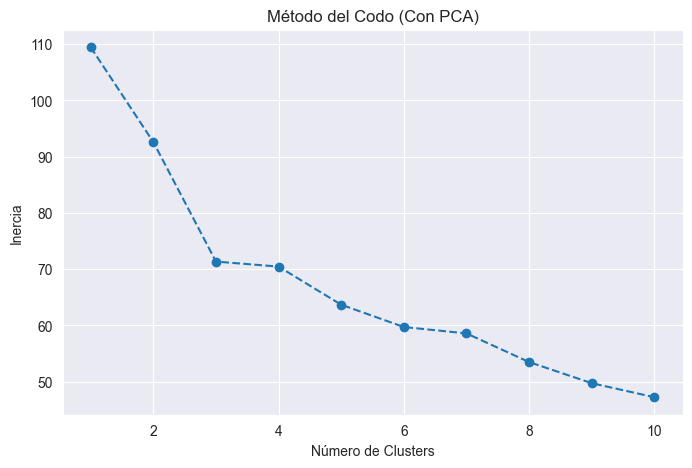

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


Silhouette Score para el modelo: 0.4462


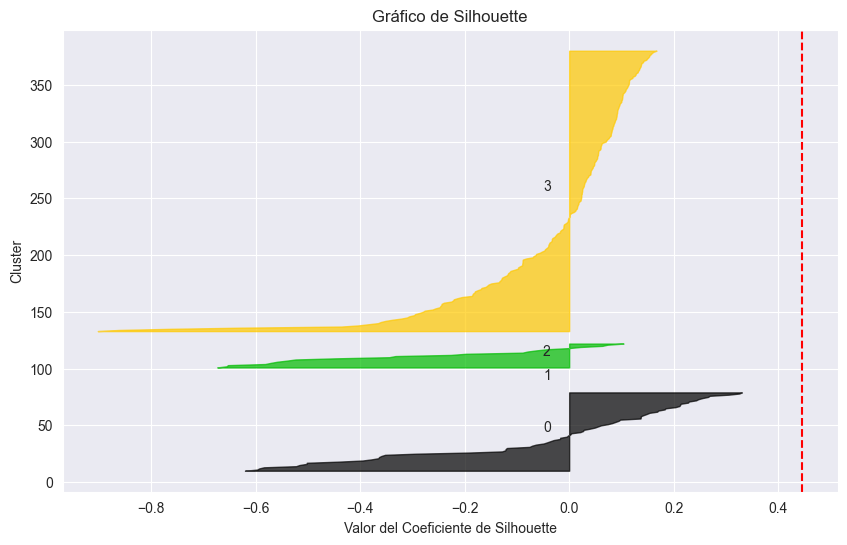

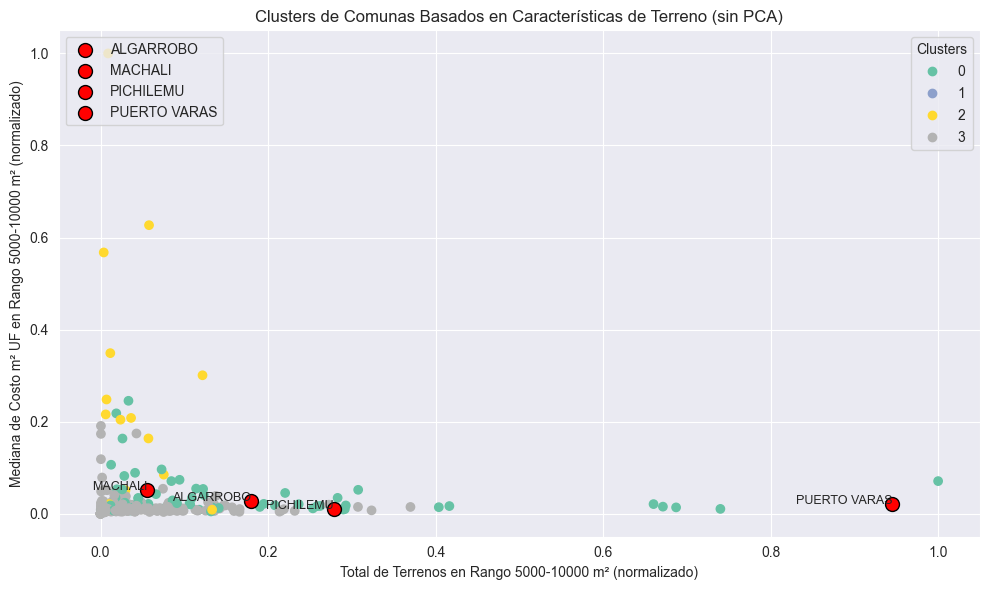


Pesos de cada variable en el clustering (valores de los centroides):
   Total 100-499 m2  Total 500-4999 m2  Total 5000-10000 m2  \
0          0.216021           0.179587             0.169002   
1          0.194704           0.169045             0.003574   
2          0.215520           0.216700             0.031343   
3          0.024143           0.018150             0.041521   

   Total 10001-100000 m2  Mediana costo_m2_uf 100-499 m2  \
0               0.229724                        0.033205   
1               0.011521                        0.042381   
2               0.065982                        0.057225   
3               0.062951                        0.025381   

   Media costo_m2_uf 100-499 m2  Desviación costo_m2_uf 100-499 m2  \
0                      0.030368                           0.011590   
1                      0.025286                           0.003861   
2                      0.044031                           0.013699   
3                      0.028852  

In [110]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total 100-499 m2', 'Total 500-4999 m2', 'Total 5000-10000 m2', 'Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2','Media costo_m2_uf 100-499 m2', 'Desviación costo_m2_uf 100-499 m2',
       'Mínimo costo_m2_uf 100-499 m2', 'Máximo costo_m2_uf 100-499 m2',
       'IQR costo_m2_uf 100-499 m2', 'Mediana costo_m2_uf 500-4999 m2',
       'Media costo_m2_uf 500-4999 m2', 'Desviación costo_m2_uf 500-4999 m2',
       'Mínimo costo_m2_uf 500-4999 m2', 'Máximo costo_m2_uf 500-4999 m2',
       'IQR costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
       'Media costo_m2_uf 5000-10000 m2',
       'Desviación costo_m2_uf 5000-10000 m2',
       'Mínimo costo_m2_uf 5000-10000 m2', 'Máximo costo_m2_uf 5000-10000 m2',
       'IQR costo_m2_uf 5000-10000 m2', 'Mediana costo_m2_uf 10001-100000 m2',
       'Media costo_m2_uf 10001-100000 m2',
       'Desviación costo_m2_uf 10001-100000 m2',
       'Mínimo costo_m2_uf 10001-100000 m2',
       'Máximo costo_m2_uf 10001-100000 m2', 'IQR costo_m2_uf 10001-100000 m2',
       'Mediana costo_m2_uf >100000 m2', 'Media costo_m2_uf >100000 m2',
       'Desviación costo_m2_uf >100000 m2', 'Mínimo costo_m2_uf >100000 m2',
       'Máximo costo_m2_uf >100000 m2', 'IQR costo_m2_uf >100000 m2']

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando StandardScaler
scaler = MinMaxScaler()
#scaler = StandardScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 4: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_normalizado)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo (Con PCA)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()


# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Graficar el Silhouette Score para cada punto
sample_silhouette_values = silhouette_samples(X_pca, data_estadisticos['cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(4):
    ith_cluster_silhouette_values = sample_silhouette_values[data_estadisticos['cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / 4)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10  # 10 for the 0 samples gap between silhouette plots

plt.title("Gráfico de Silhouette")
plt.xlabel("Valor del Coeficiente de Silhouette")
plt.ylabel("Cluster")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.grid(True)
plt.show()


# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['Total 5000-10000 m2'], X_normalizado['Mediana costo_m2_uf 5000-10000 m2'],
                      c=data_estadisticos['cluster'], cmap='Set2')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, 'Total 5000-10000 m2'], 
                        X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 5000-10000 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('Total de Terrenos en Rango 5000-10000 m² (normalizado)')
plt.ylabel('Mediana de Costo m² UF en Rango 5000-10000 m² (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Paso 7: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

## MinMax media, mediana y desv

### Sin PCA

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than ava

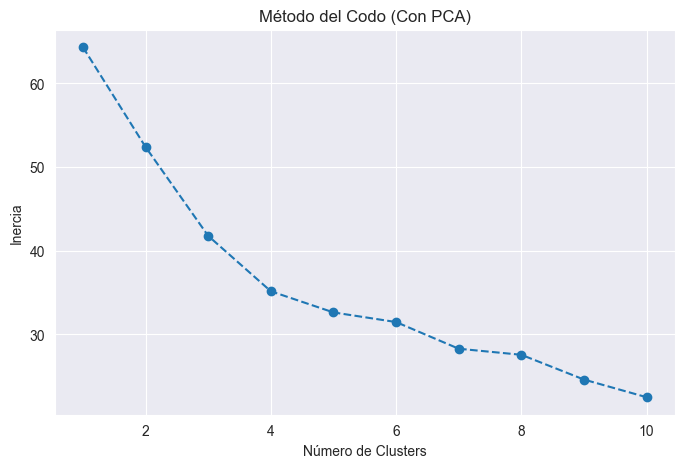

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


Silhouette Score para el modelo: 0.4980


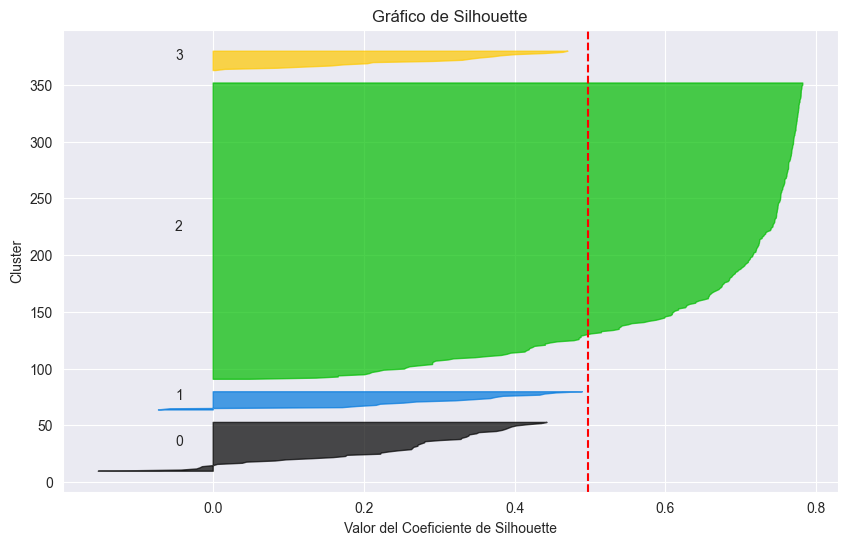

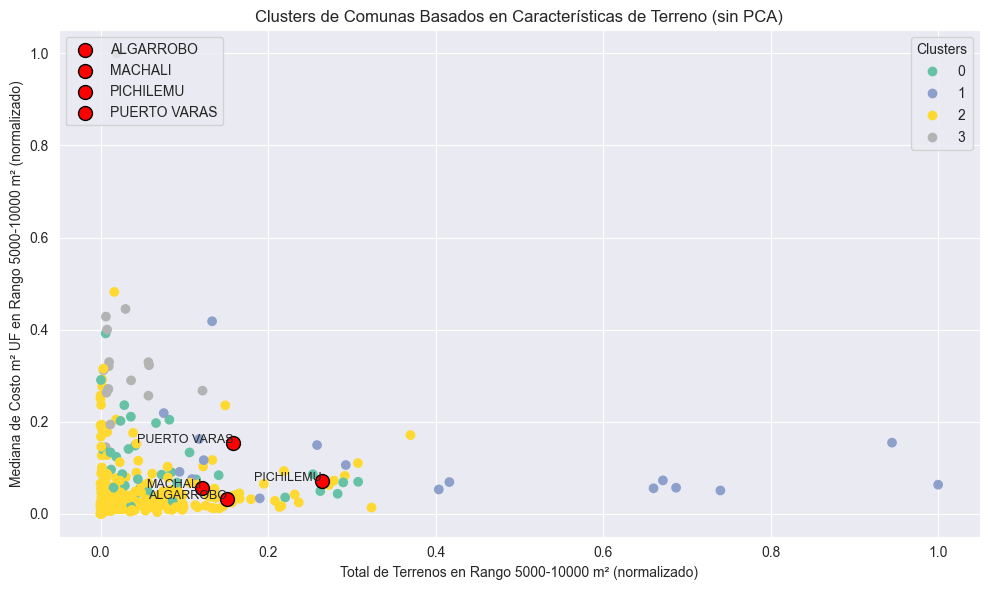


Pesos de cada variable en el clustering (valores de los centroides):
   Total 100-499 m2  Total 500-4999 m2  Total 5000-10000 m2  \
0          0.138983           0.113008             0.073180   
1          0.523823           0.469037             0.406985   
2          0.028596           0.021879             0.046630   
3          0.196262           0.185017             0.025812   

   Total 10001-100000 m2  Mediana costo_m2_uf 100-499 m2  \
0               0.137778                        0.031464   
1               0.470249                        0.042816   
2               0.070351                        0.025959   
3               0.037058                        0.055919   

   Media costo_m2_uf 100-499 m2  Desviación costo_m2_uf 100-499 m2  \
0                      0.031030                           0.012765   
1                      0.037761                           0.015469   
2                      0.028833                           0.012643   
3                      0.039642  

In [204]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total 100-499 m2', 'Total 500-4999 m2', 'Total 5000-10000 m2', 'Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2','Media costo_m2_uf 100-499 m2', 'Desviación costo_m2_uf 100-499 m2',
       
     'Mediana costo_m2_uf 500-4999 m2',
       'Media costo_m2_uf 500-4999 m2', 'Desviación costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
       'Media costo_m2_uf 5000-10000 m2',
       'Desviación costo_m2_uf 5000-10000 m2',       
        'Mediana costo_m2_uf 10001-100000 m2',
       'Media costo_m2_uf 10001-100000 m2',
       'Desviación costo_m2_uf 10001-100000 m2',      
       'Mediana costo_m2_uf >100000 m2', 'Media costo_m2_uf >100000 m2',
       'Desviación costo_m2_uf >100000 m2']

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando StandardScaler
scaler = MinMaxScaler()
#scaler = StandardScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 4: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_normalizado)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo (Con PCA)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()


# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Graficar el Silhouette Score para cada punto
sample_silhouette_values = silhouette_samples(X_pca, data_estadisticos['cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(4):
    ith_cluster_silhouette_values = sample_silhouette_values[data_estadisticos['cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / 4)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10  # 10 for the 0 samples gap between silhouette plots

plt.title("Gráfico de Silhouette")
plt.xlabel("Valor del Coeficiente de Silhouette")
plt.ylabel("Cluster")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.grid(True)
plt.show()


# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_normalizado['Total 5000-10000 m2'], X_normalizado['Mediana costo_m2_uf 500-4999 m2'],
                      c=data_estadisticos['cluster'], cmap='Set2')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, 'Total 500-4999 m2'], 
                        X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 500-4999 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('Total de Terrenos en Rango 5000-10000 m² (normalizado)')
plt.ylabel('Mediana de Costo m² UF en Rango 5000-10000 m² (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Paso 7: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

### Con PCA

Varianzas explicadas por cada componente principal:
PC1: 0.3246
PC2: 0.1820
PC3: 0.1669
PC4: 0.0589
PC5: 0.0474

Cargas de los Componentes Principales:
     Total 100-499 m2  Total 500-4999 m2  Total 5000-10000 m2  \
PC1          0.457133           0.416404             0.309074   
PC2          0.177984           0.129431             0.401418   
PC3          0.202382           0.182563            -0.029631   
PC4          0.434436           0.180576            -0.378727   
PC5          0.175605           0.095420            -0.149089   

     Total 10001-100000 m2  Mediana costo_m2_uf 100-499 m2  \
PC1               0.386341                        0.025207   
PC2               0.430863                       -0.012088   
PC3              -0.033027                        0.034845   
PC4              -0.340576                       -0.058736   
PC5              -0.121517                        0.022002   

     Media costo_m2_uf 100-499 m2  Desviación costo_m2_uf 100-499 m2  \
PC1         

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than ava

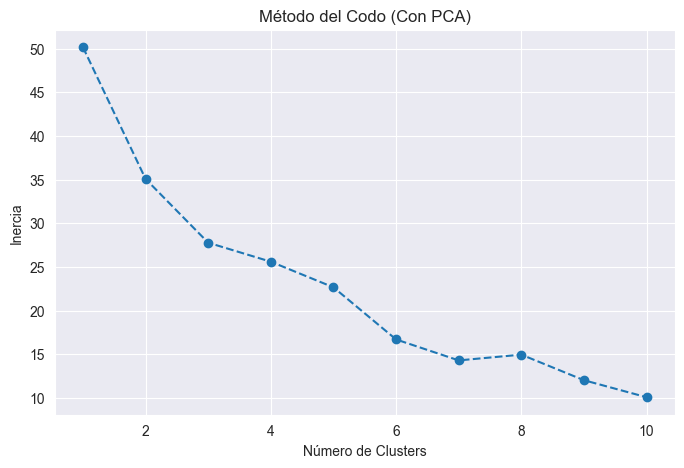


Silhouette Score para el modelo: 0.5508


C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


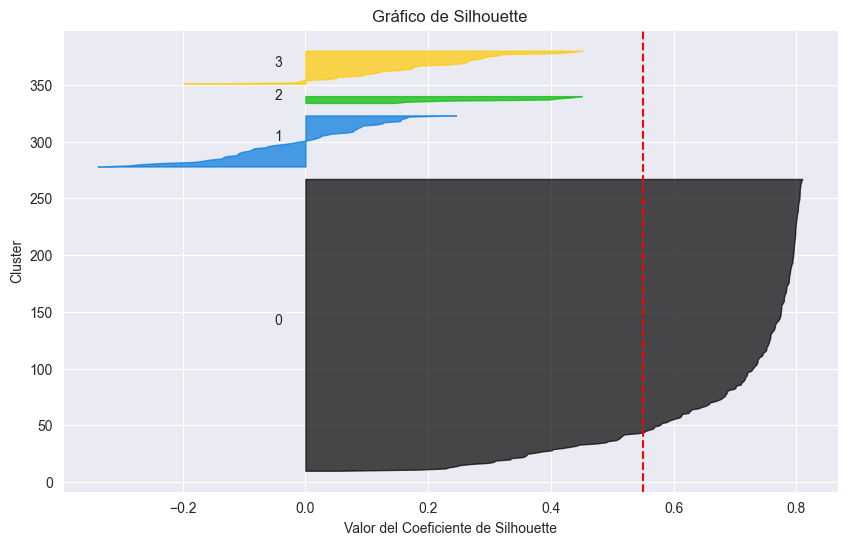


Clusters de las comunas seleccionadas:
Comuna ALGARROBO pertenece al cluster 3
Comuna PUERTO VARAS pertenece al cluster 2
Comuna MACHALI pertenece al cluster 1
Comuna PICHILEMU pertenece al cluster 3


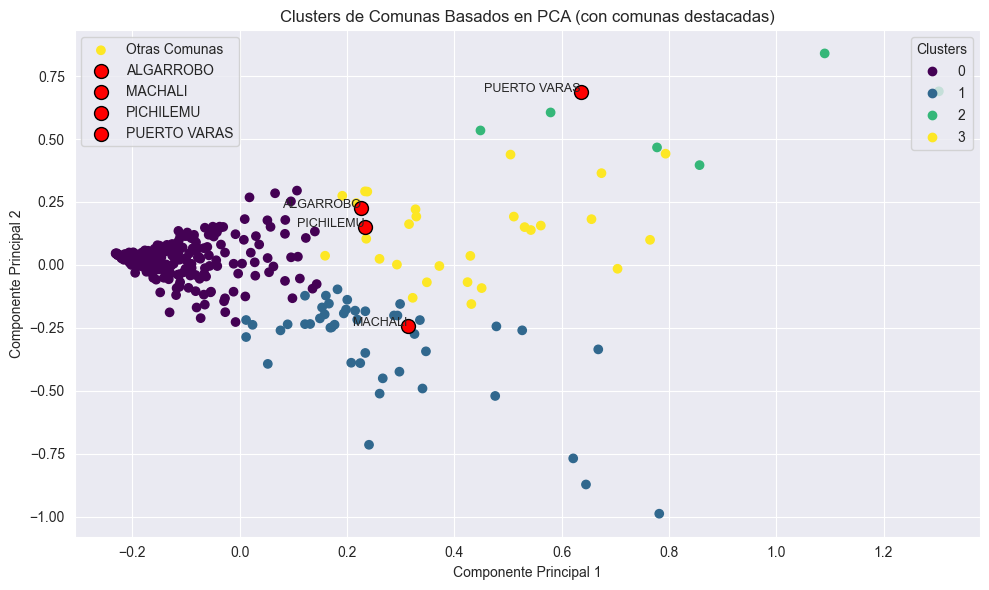


Características promedio por cluster:
         Total de Datos  Total 100-499 m2  % 100-499 m2  Total 500-4999 m2  \
cluster                                                                      
0            310.868217         16.104651      7.336990          44.926357   
1            567.108696         88.782609     17.177474         277.652174   
2           5059.857143        296.285714      6.042869         978.428571   
3           1952.000000        213.600000     11.832703         656.466667   

         % 500-4999 m2  Total 5000-10000 m2  % 5000-10000 m2  \
cluster                                                        
0            17.272519           175.310078        47.576019   
1            43.868913           123.391304        24.299786   
2            19.208832          3062.428571        60.469609   
3            32.327159           781.133333        40.163440   

         Total 10001-100000 m2  % 10001-100000 m2  Total >100000 m2  ...  \
cluster                        

In [116]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, Normalizer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Eliminar la columna "Unnamed: 0" si existe
if 'Unnamed: 0' in data_estadisticos.columns:
    data_estadisticos = data_estadisticos.drop(columns=['Unnamed: 0'])

# Paso 2: Seleccionar las variables relevantes para el clustering
variables_clustering = [
    'Total 100-499 m2', 'Total 500-4999 m2', 'Total 5000-10000 m2', 'Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2','Media costo_m2_uf 100-499 m2', 'Desviación costo_m2_uf 100-499 m2',
       
     'Mediana costo_m2_uf 500-4999 m2',
       'Media costo_m2_uf 500-4999 m2', 'Desviación costo_m2_uf 500-4999 m2', 'Mediana costo_m2_uf 5000-10000 m2',
       'Media costo_m2_uf 5000-10000 m2',
       'Desviación costo_m2_uf 5000-10000 m2',       
        'Mediana costo_m2_uf 10001-100000 m2',
       'Media costo_m2_uf 10001-100000 m2',
       'Desviación costo_m2_uf 10001-100000 m2',      
       'Mediana costo_m2_uf >100000 m2', 'Media costo_m2_uf >100000 m2',
       'Desviación costo_m2_uf >100000 m2']

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando Normalizer
#scaler = Normalizer()
scaler = MinMaxScaler()
#scaler = RobustScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 4: Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=5)  # Reducir a 5 componentes principales
X_pca = pca.fit_transform(X_normalizado)

# Imprimir las varianzas explicadas por cada componente principal
varianzas_explicadas = pca.explained_variance_ratio_
print("Varianzas explicadas por cada componente principal:")
for i, varianza in enumerate(varianzas_explicadas):
    print(f"PC{i + 1}: {varianza:.4f}")

# Imprimir las cargas de los componentes principales
cargas_componentes = pd.DataFrame(pca.components_, columns=variables_clustering,
                                  index=[f'PC{i + 1}' for i in range(pca.n_components_)])
print("\nCargas de los Componentes Principales:")
print(cargas_componentes)

# Paso 5: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo (Con PCA)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

# Paso 6: Aplicar K-means con el número óptimo de clusters
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_pca)

# Calcular el silhouette score para evaluar la calidad de la agrupación
silhouette_avg = silhouette_score(X_pca, data_estadisticos['cluster'])
print(f"\nSilhouette Score para el modelo: {silhouette_avg:.4f}")

# Graficar el Silhouette Score para cada punto
sample_silhouette_values = silhouette_samples(X_pca, data_estadisticos['cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(4):
    ith_cluster_silhouette_values = sample_silhouette_values[data_estadisticos['cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / 4)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color,
                      alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10 for the 0 samples gap between silhouette plots

plt.title("Gráfico de Silhouette")
plt.xlabel("Valor del Coeficiente de Silhouette")
plt.ylabel("Cluster")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.grid(True)
plt.show()

# Paso 7: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['ALGARROBO', 'PUERTO VARAS', 'MACHALI', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Mostrar a qué cluster pertenecen las comunas seleccionadas
print("\nClusters de las comunas seleccionadas:")
for comuna in comunas_a_marcar:
    cluster_comuna = data_estadisticos[data_estadisticos['comuna_match'] == comuna]['cluster'].values[0]
    print(f"Comuna {comuna} pertenece al cluster {cluster_comuna}")

# Paso 8: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_estadisticos['cluster'], cmap='viridis', label='Otras Comunas')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_pca[pos_comunas.index, 0], X_pca[pos_comunas.index, 1]):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir la leyenda con los clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
plt.gca().add_artist(legend1)

# Añadir la leyenda de las comunas destacadas
plt.legend(loc="upper left")

# Personalizar el gráfico
plt.title('Clusters de Comunas Basados en PCA (con comunas destacadas)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 9: Mostrar las características promedio por cluster (solo columnas numéricas)
print("\nCaracterísticas promedio por cluster:")
columnas_numericas = data_estadisticos.select_dtypes(include=['float64', 'int64']).columns
caracteristicas_cluster = data_estadisticos.groupby('cluster')[columnas_numericas].mean()
print(caracteristicas_cluster)

print("\nCaracterísticas mediana por cluster:")
caracteristicas_cluster_median = data_estadisticos.groupby('cluster')[columnas_numericas].median()
print(caracteristicas_cluster_median)

## media, mediana, min, max

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than ava

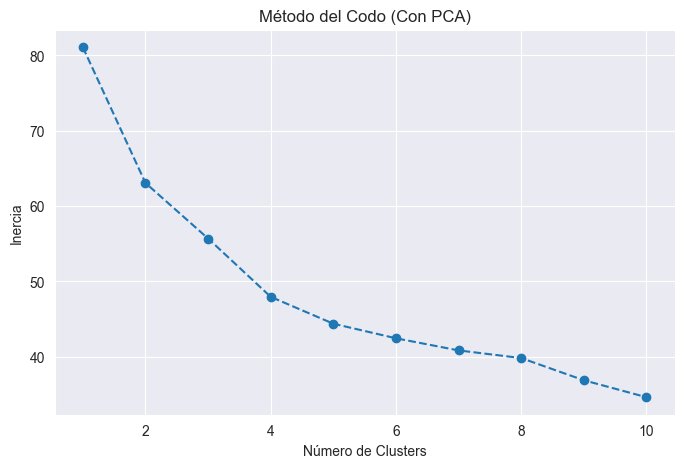

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


Silhouette Score para el modelo: 0.4071


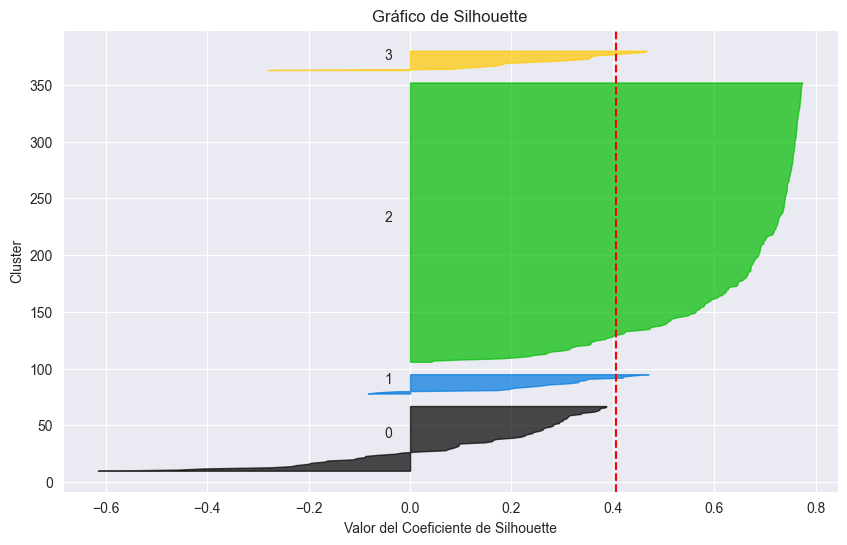

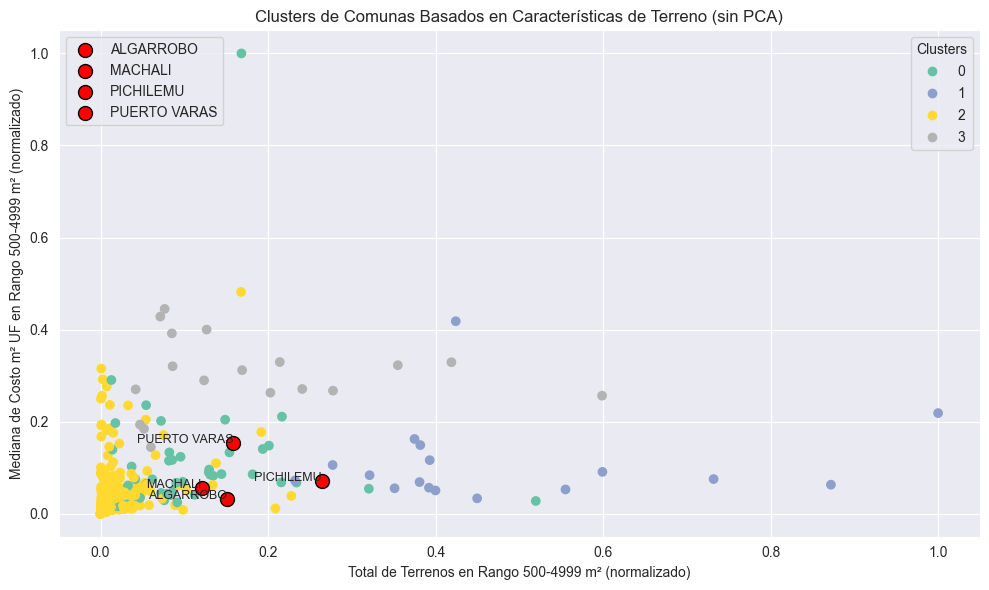


Pesos de cada variable en el clustering (valores de los centroides):
   Total 100-499 m2  Total 500-4999 m2  Total 5000-10000 m2  \
0          0.118192           0.099281             0.088684   
1          0.519124           0.460825             0.392211   
2          0.025647           0.019061             0.041155   
3          0.195050           0.180405             0.025084   

   Total 10001-100000 m2  Mediana costo_m2_uf 100-499 m2  \
0               0.151537                        0.032613   
1               0.462302                        0.041335   
2               0.062310                        0.025603   
3               0.036354                        0.053367   

   Media costo_m2_uf 100-499 m2  Mínimo costo_m2_uf 100-499 m2  \
0                      0.031560                       0.015926   
1                      0.036372                       0.000076   
2                      0.028830                       0.042707   
3                      0.037157                  

In [207]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total 100-499 m2', 'Total 500-4999 m2', 'Total 5000-10000 m2', 'Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2','Media costo_m2_uf 100-499 m2',
       'Mínimo costo_m2_uf 100-499 m2', 'Máximo costo_m2_uf 100-499 m2',
    'Mediana costo_m2_uf 500-4999 m2',
       'Media costo_m2_uf 500-4999 m2',
       'Mínimo costo_m2_uf 500-4999 m2', 'Máximo costo_m2_uf 500-4999 m2',
        'Mediana costo_m2_uf 5000-10000 m2',
       'Media costo_m2_uf 5000-10000 m2',
       'Mínimo costo_m2_uf 5000-10000 m2', 'Máximo costo_m2_uf 5000-10000 m2',
       'Mediana costo_m2_uf 10001-100000 m2',
       'Media costo_m2_uf 10001-100000 m2',
       'Mínimo costo_m2_uf 10001-100000 m2',
       'Máximo costo_m2_uf 10001-100000 m2', 
       'Mediana costo_m2_uf >100000 m2', 'Media costo_m2_uf >100000 m2',
    'Mínimo costo_m2_uf >100000 m2',
       'Máximo costo_m2_uf >100000 m2' ]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando StandardScaler
scaler = MinMaxScaler()
#scaler = StandardScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 4: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_normalizado)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo (Con PCA)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()


# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Graficar el Silhouette Score para cada punto
sample_silhouette_values = silhouette_samples(X_pca, data_estadisticos['cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(4):
    ith_cluster_silhouette_values = sample_silhouette_values[data_estadisticos['cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / 4)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10  # 10 for the 0 samples gap between silhouette plots

plt.title("Gráfico de Silhouette")
plt.xlabel("Valor del Coeficiente de Silhouette")
plt.ylabel("Cluster")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.grid(True)
plt.show()


# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter( X_normalizado['Total 500-4999 m2'],X_normalizado['Mediana costo_m2_uf 500-4999 m2'],
                      c=data_estadisticos['cluster'], cmap='Set2')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, 'Total 500-4999 m2'], 
                        X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 500-4999 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('Total de Terrenos en Rango 500-4999 m² (normalizado)')
plt.ylabel('Mediana de Costo m² UF en Rango 500-4999 m² (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Paso 7: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

In [ ]:
variables_clustering = [
    'Total 100-499 m2', 'Total 500-4999 m2', 'Total 5000-10000 m2', 'Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2','Media costo_m2_uf 100-499 m2', 'Desviación costo_m2_uf 100-499 m2',
       'Mínimo costo_m2_uf 100-499 m2', 'Máximo costo_m2_uf 100-499 m2',
    'Mediana costo_m2_uf 500-4999 m2',
       'Media costo_m2_uf 500-4999 m2', 'Desviación costo_m2_uf 500-4999 m2',
       'Mínimo costo_m2_uf 500-4999 m2', 'Máximo costo_m2_uf 500-4999 m2',
        'Mediana costo_m2_uf 5000-10000 m2',
       'Media costo_m2_uf 5000-10000 m2',
       'Desviación costo_m2_uf 5000-10000 m2',
       'Mínimo costo_m2_uf 5000-10000 m2', 'Máximo costo_m2_uf 5000-10000 m2',
       'Mediana costo_m2_uf 10001-100000 m2',
       'Media costo_m2_uf 10001-100000 m2',
       'Desviación costo_m2_uf 10001-100000 m2',
       'Mínimo costo_m2_uf 10001-100000 m2',
       'Máximo costo_m2_uf 10001-100000 m2', 
       'Mediana costo_m2_uf >100000 m2', 'Media costo_m2_uf >100000 m2',
       'Desviación costo_m2_uf >100000 m2', 'Mínimo costo_m2_uf >100000 m2',
       'Máximo costo_m2_uf >100000 m2' ]

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than ava

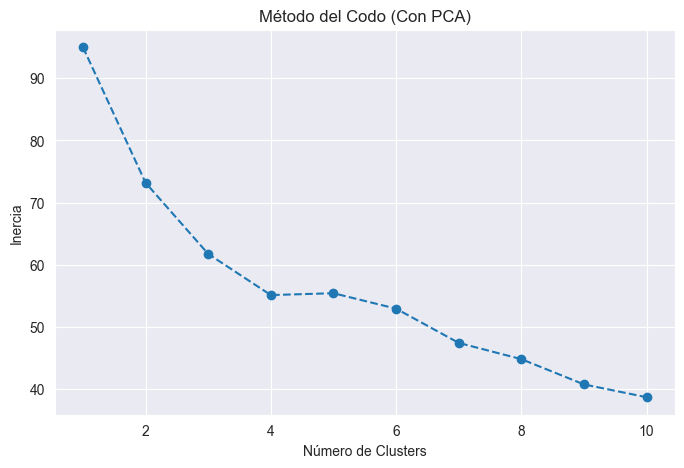

C:\Users\franc\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


Silhouette Score para el modelo: 0.4435


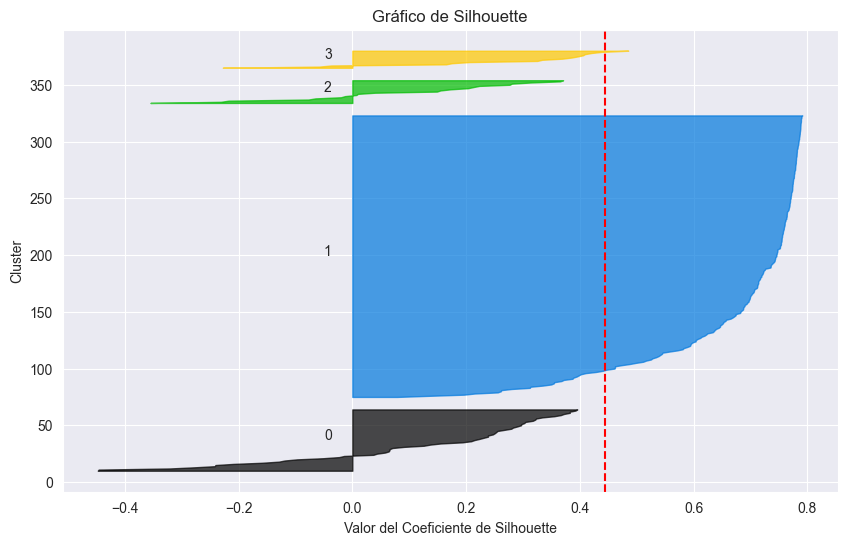

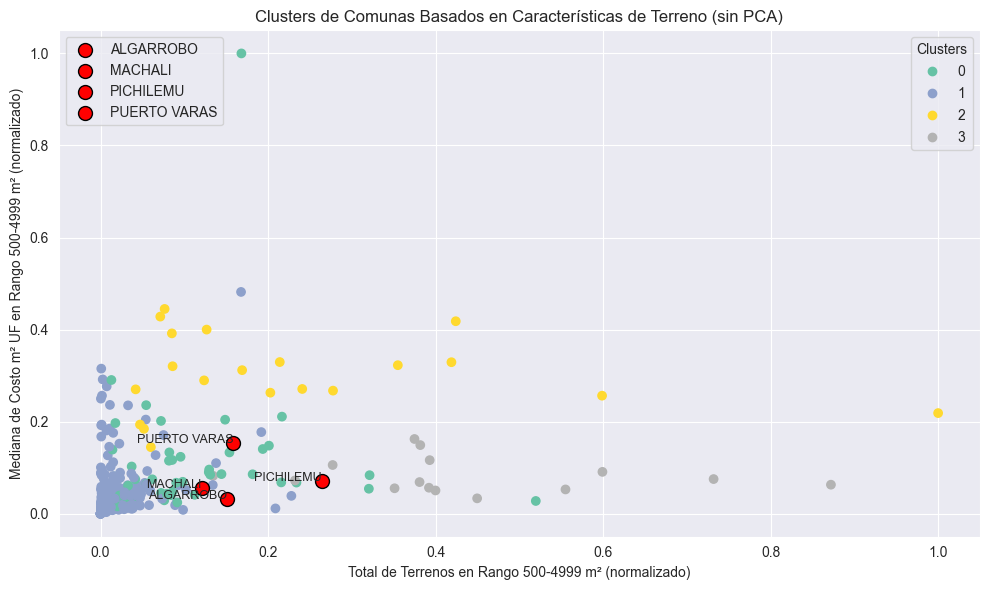


Pesos de cada variable en el clustering (valores de los centroides):
   Total 100-499 m2  Total 500-4999 m2  Total 5000-10000 m2  \
0          0.126820           0.106906             0.087946   
1          0.025785           0.019167             0.041447   
2          0.220961           0.222490             0.031496   
3          0.500584           0.417748             0.437604   

   Total 10001-100000 m2  Mediana costo_m2_uf 100-499 m2  \
0               0.153770                        0.032562   
1               0.062989                        0.025435   
2               0.054477                        0.058426   
3               0.491863                        0.035569   

   Media costo_m2_uf 100-499 m2  Desviación costo_m2_uf 100-499 m2  \
0                      0.031543                           0.012632   
1                      0.028739                           0.012718   
2                      0.041398                           0.009237   
3                      0.032179  

In [206]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Cargar los datos de estadísticas por comuna y rango de superficie
data_estadisticos = pd.read_csv('data recuperada/estadisticos_por_comuna_y_rango.csv')

# Paso 2: Seleccionar las variables para el clustering (eliminando el primer rango '100-499 m2')
variables_clustering = [
    'Total 100-499 m2', 'Total 500-4999 m2', 'Total 5000-10000 m2', 'Total 10001-100000 m2',
    'Mediana costo_m2_uf 100-499 m2','Media costo_m2_uf 100-499 m2', 'Desviación costo_m2_uf 100-499 m2',
       'Mínimo costo_m2_uf 100-499 m2', 'Máximo costo_m2_uf 100-499 m2',
    'Mediana costo_m2_uf 500-4999 m2',
       'Media costo_m2_uf 500-4999 m2', 'Desviación costo_m2_uf 500-4999 m2',
       'Mínimo costo_m2_uf 500-4999 m2', 'Máximo costo_m2_uf 500-4999 m2',
        'Mediana costo_m2_uf 5000-10000 m2',
       'Media costo_m2_uf 5000-10000 m2',
       'Desviación costo_m2_uf 5000-10000 m2',
       'Mínimo costo_m2_uf 5000-10000 m2', 'Máximo costo_m2_uf 5000-10000 m2',
       'Mediana costo_m2_uf 10001-100000 m2',
       'Media costo_m2_uf 10001-100000 m2',
       'Desviación costo_m2_uf 10001-100000 m2',
       'Mínimo costo_m2_uf 10001-100000 m2',
       'Máximo costo_m2_uf 10001-100000 m2', 
       'Mediana costo_m2_uf >100000 m2', 'Media costo_m2_uf >100000 m2',
       'Desviación costo_m2_uf >100000 m2', 'Mínimo costo_m2_uf >100000 m2',
       'Máximo costo_m2_uf >100000 m2' ]

# Extraer las variables para el clustering
X = data_estadisticos[variables_clustering]

# Paso 3: Normalizar las características usando StandardScaler
scaler = MinMaxScaler()
#scaler = StandardScaler()
X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=variables_clustering)

# Paso 4: Método del codo para determinar el número óptimo de clusters
inertia = []
for k in range(1, 11):  # Probar con diferentes valores de K
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_normalizado)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo (Con PCA)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()


# Paso 5: Aplicar K-means con el número óptimo de clusters (por ejemplo, K=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data_estadisticos['cluster'] = kmeans.fit_predict(X_normalizado)

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_normalizado, data_estadisticos['cluster'])
print(f"Silhouette Score para el modelo: {silhouette_avg:.4f}")

# Graficar el Silhouette Score para cada punto
sample_silhouette_values = silhouette_samples(X_pca, data_estadisticos['cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(4):
    ith_cluster_silhouette_values = sample_silhouette_values[data_estadisticos['cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / 4)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10  # 10 for the 0 samples gap between silhouette plots

plt.title("Gráfico de Silhouette")
plt.xlabel("Valor del Coeficiente de Silhouette")
plt.ylabel("Cluster")

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.grid(True)
plt.show()


# Paso 6: Identificar las posiciones de las comunas específicas
comunas_a_marcar = ['PUERTO VARAS', 'MACHALI', 'ALGARROBO', 'PICHILEMU']
pos_comunas = data_estadisticos[data_estadisticos['comuna_match'].isin(comunas_a_marcar)]

# Paso 7: Visualización de los clusters con identificación de comunas
plt.figure(figsize=(10, 6))
scatter = plt.scatter( X_normalizado['Total 500-4999 m2'],X_normalizado['Mediana costo_m2_uf 500-4999 m2'],
                      c=data_estadisticos['cluster'], cmap='Set2')

# Añadir puntos destacados para las comunas especificadas
for comuna, x, y in zip(pos_comunas['comuna_match'], X_normalizado.loc[pos_comunas.index, 'Total 500-4999 m2'], 
                        X_normalizado.loc[pos_comunas.index, 'Mediana costo_m2_uf 500-4999 m2']):
    plt.scatter(x, y, color='red', s=100, label=f'{comuna}', edgecolor='black')
    plt.text(x, y, comuna, fontsize=9, ha='right')

# Añadir leyenda de clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Añadir la leyenda personalizada
plt.legend(loc="upper left")
plt.title('Clusters de Comunas Basados en Características de Terreno (sin PCA)')
plt.xlabel('Total de Terrenos en Rango 500-4999 m² (normalizado)')
plt.ylabel('Mediana de Costo m² UF en Rango 500-4999 m² (normalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Paso 7: Mostrar cuánto pesa cada variable en el clustering
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=variables_clustering)
print("\nPesos de cada variable en el clustering (valores de los centroides):")
print(centroides)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Calcular la matriz de correlación de X_normalizado
corrmat = X_normalizado.corr()

# Paso 2: Definir el tamaño del gráfico
plt.figure(figsize=(20, 20))

# Paso 3: Crear el heatmap de la matriz de correlación con anotaciones
sns.heatmap(corrmat, annot=True, cmap='coolwarm', center=0)

# Paso 4: Ajustar el diseño y mostrar el gráfico
plt.title('Matriz de Correlación - Variables Normalizadas')
plt.tight_layout()
plt.show()
